参考: 

https://www.kaggle.com/code/junkoda/basic-spectrogram-image-classification

https://www.kaggle.com/code/werus23/g2net-pytorch-with-generated-data

In [1]:
# たまにgpu取れないときあるので取れないときは終わらせる
import torch
if torch.cuda.is_available() == False:
    raise Exception

In [2]:
!nvidia-smi

Mon Dec 26 00:39:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.31       Driver Version: 465.31       CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:08:00.0 Off |                  N/A |
|  0%   35C    P8    24W / 350W |     27MiB / 24268MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# papermill parameters
cfg_optimizer = "adamw" # "sam"
device_ids = [0]
epochs = 15
gradient_accumulation_steps = 1
is_syncBN = False

#lr = 5e-3  # 高すぎるみたい
lr = 4e-4

warmup_t = 3
#warmup_t = 1

min_lr_ratio = 1e-2

weight_decay = 1e-5  # 1e-6にしてもほぼ変わらない
#weight_decay = 1e-6

is_wandb = True
is_wandb = False
n_seeds = 1
cfg_seeds = [0]

cfg_apex = True
#cfg_apex = False  # ampなしにしても変わらず

#BATCH_SIZE = 2
#BATCH_SIZE = 8  # 8にしても16と変わらず学習遅くなるだけ
BATCH_SIZE = 16
#BATCH_SIZE = 32  # 32以降ぐらいからbatch上げるとepochごとのスコア安定しない
#BATCH_SIZE = 64
#BATCH_SIZE = 128
#BATCH_SIZE = 384

load_model_path = "none"
#load_model_path = "/volume/kaggle/g2net2/output/tmp/tmp_fold0_seed0_best_score.pth"
#model_cls = "CustomModel"
#model_cls = "CustomModelDrop"
model_cls = "CustomModelMultiOutput"
#model_cls = "CustomModelMultiInput"
#model_cls = "CustomModelLargeKernel"

# https://www.kaggle.com/code/hirune924/2ndplace-solution/notebook
cfg_drop_rate = 0.4
cfg_drop_path_rate = 0.2

#MODEL_NAME = ""
MODEL_NAME = "mobilenetv3_small_050"
#MODEL_NAME = "tf_efficientnetv2_b1"
#MODEL_NAME = "tf_efficientnet_b4_ap"
#MODEL_NAME = "tf_efficientnet_b5_ns"
#MODEL_NAME = "tf_efficientnet_b7_ns"
#MODEL_NAME = "seresnext101d_32x8d"
cfg_pretrained = True

n_fold = 5
#trn_fold = [0,1,2,3,4]
#is_trn_allfold = True
trn_fold = [0]
#trn_fold = "[3]"
is_trn_allfold = False

cfg_scheduler = 'CosineLRScheduler'  # warmup
#cfg_scheduler = 'CosineLRScheduler_cycle_limit3'  # warmup

# data params
cfg_ch = 2
#cfg_step = 64
cfg_step = 128
#cfg_step = 256
#cfg_step = 340
#cfg_step = 512
#cfg_step = 5760
cfg_spec_max = 4096
#cfg_spec_max = 4224  # 33 * 128
#cfg_spec_max = 5760

size_h, size_w = 360, cfg_step
#size_h, size_w = 360, 128
#size_h, size_w = 360, 256

# train+test set stat img  https://www.kaggle.com/code/anonamename/g2net2-mean-std-calc-img4096
# np.mean(p.reshape(freq, step, spec_max//step), axis=2)直後の統計値
cfg_p_mean = [2.4080, 2.3525]  # [H1, L1]
cfg_p_std = [0.6578, 0.8358]  # [H1, L1]

#normalize_type = "default-norm|ts-ma"
#normalize_type = "default-norm|p-norm|ts-ma"
#normalize_type = "ts-ma|p-stand"
#normalize_type = "ts-ma|p-common-stand"
#normalize_type = "ts-ma|p-max"
#normalize_type = "ts-ma|p-robustscaler"
#normalize_type = "same_ts_interval|ts-ma|p-stand"
#normalize_type = "largekernel|ts-ma"
#normalize_type = "largekernel|p-robustscaler|ts-ma"
normalize_type = "largekernel|p-robustscaler|ts-ma|clip"
#normalize_type = "largekernel|p-stand|ts-ma"
#normalize_type = "largekernel"

cfg_is_add_ch = False
cfg_is_train_zip_dataset = False
cfg_prob_mixup = 0.0

#cfg_prob_sample_mixup = 0.0
#cfg_prob_sample_mixup = 0.5
cfg_prob_sample_mixup = 0.8

cfg_is_sample_mixup_use_pseudo = True
#cfg_is_sample_mixup_use_pseudo = False

cfg_prob_add_sample_nega_mixup = 0.0
#cfg_prob_add_sample_nega_mixup = 0.5

#cfg_prob_mean_mixup = 0.0
cfg_prob_mean_mixup = 0.3

#cfg_prob_noise_band = 0.0
cfg_prob_noise_band = 0.3

#cfg_prob_noise_spot = 0.0
cfg_prob_noise_spot = 0.05

#cfg_prob_noise_vline = 0.0
cfg_prob_noise_vline = 0.2

#cfg_prob_noise_hband = 0.0
cfg_prob_noise_hband = 0.2
cfg_prob_noise_hband = 0.5

cfg_prob_spec_start_random = 0.0
#cfg_prob_spec_start_random = 0.5

#cfg_prob_swap_ch_nega = 0.0
cfg_prob_swap_ch_nega = 0.5

#cfg_prob_flip_nega = 0.0
cfg_prob_flip_nega = 0.5

#cfg_prob_swap_nega = 0.0
cfg_prob_swap_nega = 0.5

cfg_prob_vshift_nega = 0.0
#cfg_prob_vshift_nega = 0.5

#cfg_prob_vshift = 0.0
cfg_prob_vshift = 1.0

#cfg_freq_mask_num = 0  # マスクする横線
#cfg_time_mask_num = 0  # マスクする縦線
cfg_freq_mask_num = 2
cfg_time_mask_num = 1
cfg_freq_mask_param = 10
cfg_time_mask_param = 10
#cfg_freq_mask_param = 30
#cfg_time_mask_param = 50

cfg_cv_col = "target"
#cfg_cv_col = "freq_min//10"
#cfg_cv_col = "freq_min//10_target"

cfg_add_split_str = ""
#cfg_add_split_str = "KFold"
#cfg_add_split_str = "StratifiedKFold"

cfg_is_npy = True
#cfg_is_npy = False

FCOFF = 1e22
#FCOFF = 5e22

ADD_DIRS_STR = ""
#ADD_DIRS_STR = "[EX003_NOISE, EX003_NOISE1]"
#ADD_DIRS_STR = "[EX003_NOISE, EX004_SIGNAL]"
#ADD_DIRS_STR = "[EX003_NOISE, EX004_SIGNAL, EX004_SIGNAL_ISO]"
#ADD_DIRS_STR = "[EX003_NOISE, EX003_NOISE1, EX005_SIGNAL, EX005_SIGNAL_ISO]"
#ADD_DIRS_STR = "[EX003_NOISE, EX003_NOISE1, EX005_SIGNAL1, EX005_SIGNAL_ISO1]"
#ADD_DIRS_STR = "[EX003_NOISE, EX003_NOISE1, EX003_NOISE2, EX004_SIGNAL, EX004_SIGNAL_ISO, EX005_SIGNAL, EX005_SIGNAL_ISO]"
#ADD_DIRS_STR = "[EX003_NOISE, EX006_SIGNAL800]"
ADD_DIRS_STR = "[EX003_NOISE2, EX005_SIGNAL, EX005_SIGNAL1, EX005_SIGNAL_ISO, EX005_SIGNAL_ISO1, EX006_NOISE1400, EX006_SIGNAL800, EX006_SIGNAL_ISO800]"

IS_ADD_ALL_TRAIN1 = False
#IS_ADD_ALL_TRAIN1 = True


PSEUDO_CSV = ""
PSEUDO_CSV = "./kaggle_dl/sub_csvs/sub_avg_lb0761.csv"
cfg_pseudo_max = 0.9
cfg_pseudo_min = 0.1
#cfg_pseudo_max = 0.0  # pseudoの閾値なし
#cfg_pseudo_min = 0.0  # pseudoの閾値なし
#cfg_is_pseudo_hard = True
cfg_is_pseudo_hard = False

cfg_pseudo_type = ""
#cfg_pseudo_type = "real"
#cfg_pseudo_type = "sim"


ADD_PSEUDO_DIRS = ""
ADD_PSEUDO_DIRS = "[EX007_NONSTAT_NOISE800]"


cfg_freq_div_n = 10
#cfg_freq_div_n = 50
#cfg_freq_div_n = 100

cfg_pseudo_sim_max = cfg_pseudo_max
cfg_pseudo_sim_min = cfg_pseudo_min
#cfg_pseudo_sim_max = 0.8
#cfg_pseudo_sim_min = 0.4
#cfg_pseudo_sim_max = 0.0
#cfg_pseudo_sim_min = 0.0

cfg_pseudo_real_max = cfg_pseudo_max
cfg_pseudo_real_min = cfg_pseudo_min

is_matplotlib_agg = False
#is_matplotlib_agg = True  # 可視化なしにする

IS_MAKE_SUB = False
#IS_MAKE_SUB = True

#DEBUG = False
DEBUG = True

# ==============================================================
# kqi_3090_ex075_v2 base Parameters
# ==============================================================
add_name = "_pseudo_multioutput_freq_b5_ap_freq_div_n50"
BATCH_SIZE = 64
MODEL_NAME = "tf_efficientnet_b5_ap"
model_cls = "CustomModelMultiOutput"
epochs = 50
normalize_type = "largekernel|p-robustscaler|ts-ma|clip"
cfg_apex = True
cfg_step = 128
size_w = 128
cfg_is_sample_mixup_use_pseudo = True
cfg_add_split_str = "StratifiedKFold"
ADD_DIRS_STR = "[EX003_NOISE2, EX005_SIGNAL, EX005_SIGNAL1, EX005_SIGNAL_ISO, EX005_SIGNAL_ISO1, EX006_NOISE1400, EX006_SIGNAL800, EX006_SIGNAL_ISO800]"

PSEUDO_CSV = "./kaggle_dl/sub_csvs/sub_avg_lb0761.csv"
ADD_PSEUDO_DIRS = "[EX007_NONSTAT_NOISE800]"
cfg_pseudo_max = 0.9
cfg_pseudo_min = 0.1

cfg_is_pseudo_hard = False
cfg_freq_div_n = 50
IS_ADD_ALL_TRAIN1 = False
IS_MAKE_SUB = True
n_fold = 5
#is_trn_allfold = True
#DEBUG = False
# ==============================================================

# ==============================================================
# kqi_3090_ex075_v2_tta_v3_miximp_hvflip_pseudo_lb0771_1000_simall_100ep Parameters
# ==============================================================
PSEUDO_CSV = "./kaggle_dl/sub_csvs/sub_avg_lb0771.csv"
cfg_pseudo_max = 1.0 
cfg_pseudo_min = 0.0
cfg_pseudo_sim_max = 0.0
cfg_pseudo_real_max = -1
epochs = 100
# ==============================================================

#PSEUDO_CSV = "./kqi_dl/lb0.774_kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep/lb0.774_kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep_submission.csv"
#PSEUDO_CSV = "./kqi_dl/lb0.775_kqi_3090_ex075_v2_tta_v3_pseudo_v3_hvflip_stride12_lb0771_1000_simall_100ep/lb0.775_kqi_3090_ex075_v2_tta_v3_pseudo_v3_hvflip_stride12_lb0771_1000_simall_100ep_submission_tta012.csv"
PSEUDO_CSV = "./kaggle_dl/sub_csvs/sub_avg_ver25_lb0777.csv"

DEL_Outlier_Pseudo_MEAN_TH = 0
#DEL_Outlier_Pseudo_MEAN_TH = 5

DEL_Outlier_Pseudo_STD_TH = 0
#DEL_Outlier_Pseudo_STD_TH = 10

## pseudo全部入れる
#cfg_pseudo_max = 0.0
#cfg_pseudo_min = 1.0
#cfg_pseudo_sim_max = -1
#cfg_pseudo_real_max = -1

## pseudo sim全部入れる+real[<0.1,>0.9]だけ入れる
#cfg_pseudo_max = 0.9
#cfg_pseudo_min = 0.1
#cfg_pseudo_sim_max = 0
#cfg_pseudo_real_max = 0.9
#cfg_pseudo_real_min = 0.1

cfg_alb_norm_mean_th = 0  # albで画像正規化しない
#cfg_alb_norm_mean_th = DEL_Outlier_Pseudo_MEAN_TH  # これ以上の h1_mean+l1_mean を取る画像は除いて統計値出してalbで正規化する。
#cfg_alb_norm_mean_th = 1000000  # 全データで正規化

cfg_alb_norm_std_th = 0  # albで画像正規化しない
#cfg_alb_norm_std_th = DEL_Outlier_Pseudo_STD_TH  # これ以上の h1_std+l1_std を取る画像は除いて統計値出してalbで正規化する。trainの h1_std,l1_std は 0.42 ぐらいがmax値
#cfg_alb_norm_std_th = 1000000  # 全データで正規化

ADD_DIRS_STR = "[EX003_NOISE2, EX005_SIGNAL, EX005_SIGNAL1, EX005_SIGNAL_ISO, EX005_SIGNAL_ISO1, EX006_NOISE1400, EX006_SIGNAL800, EX006_SIGNAL_ISO800, EX007_NONSTAT_NOISE800, EX009_NOISE_ART]"
ADD_PSEUDO_DIRS = ""

model_cls = "CustomModelMultiOutputStride12"

add_name = ""

In [4]:
# Parameters
add_name = "_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007"
PSEUDO_CSV = "./kaggle_dl/sub_csvs/sub_avg_lb0771.csv"
cfg_pseudo_max = 0.0
cfg_pseudo_min = 0.0
cfg_pseudo_sim_max = -1
cfg_pseudo_real_max = -1
epochs = 100
cfg_alb_norm_mean_th = 5
cfg_alb_norm_std_th = 10
DEL_Outlier_Pseudo_MEAN_TH = 5
DEL_Outlier_Pseudo_STD_TH = 10
ADD_DIRS_STR = "[EX003_NOISE2, EX005_SIGNAL, EX005_SIGNAL1, EX005_SIGNAL_ISO, EX005_SIGNAL_ISO1, EX006_NOISE1400, EX006_SIGNAL800, EX006_SIGNAL_ISO800, EX007_NONSTAT_NOISE800]"
ADD_PSEUDO_DIRS = ""
model_cls = "CustomModelMultiOutputStride12"
is_trn_allfold = True
is_wandb = True
DEBUG = False


In [5]:
# papermillで引数をlistで渡さなかった場合の対策
if isinstance(device_ids, int):
    device_ids = [0]
    
# trn_foldをpapermillで渡したときの対策
if type(trn_fold) is str:
    trn_fold = eval(trn_fold)
    
# 全fold学習
if is_trn_allfold:
    trn_fold = list(range(n_fold))
    
# 複数seedで学習
if n_seeds > 1:
    cfg_seeds = list(range(n_seeds))
    
# ダウンロードしたデータで事前学習する場合はfold=0のみ
if cfg_is_train_zip_dataset:
    trn_fold = [0]
    
# フラグあればch増やす
if cfg_is_add_ch:
    cfg_ch = 2 + 2 
    
# 移動平均の場合は画像の横幅-1する
if "ts-ma" in normalize_type:
    size_w -= 1
    
# フーリエ係数変える場合
if FCOFF != 1e22:
    normalize_type += f"_{str(FCOFF)}"
    
## largekernelを使う場合
#if "largekernel" in normalize_type:
#    cfg_spec_max = 5760
    
# LargeKernelモデルを使う場合
if model_cls == "CustomModelLargeKernel":
    MODEL_NAME = ""
    cfg_step = 5760
    cfg_spec_max = 5760
    size_h, size_w = 360, cfg_step
    normalize_type = "largekernel"
    cfg_prob_mean_mixup = 0.0
    cfg_prob_spec_start_random = 0.0
    cfg_time_mask_param = int( 10 * (cfg_spec_max / 128) )

In [6]:
import os
#import ipynbname
#NAME = ipynbname.name()
if DEBUG:
    NAME = f"tmp"
    #NAME = f"tmp_real"
    #NAME = f"tmp_no-alb"
    #NAME = f"tmp_VerticalFlip"
    #NAME = f"tmp_HorizontalFlip"
    #NAME = f"tmp_no-alb_EX003_NOISE01"
else:
    if "/kqi/output" in os.getcwd():
        NAME = f"kqi_3090_ex075_v2{add_name}"
    else:
        NAME = f"3090_kqi_ex075_v2{add_name}"
print(NAME)

3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007


# Directory

In [7]:
import os, sys

if "kaggle_web_client" in sys.modules:
    INPUT_DIR_TRAIN = "/kaggle/input/g2net-detecting-continuous-gravitational-waves"
    INPUT_DIR_TEST = "/kaggle/input/g2net-detecting-continuous-gravitational-waves"
    OUTPUT_DIR = f"./output/{NAME}"

elif "/work" in os.getcwd():
    INPUT_DIR_TRAIN = f"/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves"  # SSD
    INPUT_DIR_TEST = f"/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves"  # SSD
    OUTPUT_DIR = f"/volume/kaggle/g2net2/output/{NAME}"  # HDD
    
    # ============================================
    # 生成データのパス
    # ============================================
    EX003_NOISE = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex003_generating_noise"  # SSD 500件
    EX003_NOISE1 = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex003_generating_noise_1_gap"  # SSD 1000件
    EX003_NOISE2 = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex003_generating_noise_2_gap"  # SSD 3000件
    EX003_NOISE5000 = f"/volume/kaggle/g2net2/pyfstat_output/ex003_generating_noise_gap5000"  # HDD 5000件
    EX004_SIGNAL = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex004_generating_signal_gap"  # SSD 200件
    EX004_SIGNAL_ISO = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex004_generating_signal_gap_iso"  # SSD 200件
    EX005_SIGNAL = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex005_generating_signal_gap"  # SSD 400件
    EX005_SIGNAL_ISO = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex005_generating_signal_gap_iso"  # SSD 400件
    EX005_SIGNAL1 = f"/volume/kaggle/g2net2/pyfstat_output/ex005_generating_signal_gap_1"  # HDD 800件
    EX005_SIGNAL_ISO1 = f"/volume/kaggle/g2net2/pyfstat_output/ex005_generating_signal_gap_iso_1"  # HDD 800件
    EX006_NOISE1400 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_noise_gap1400"  # HDD 1400件
    EX006_SIGNAL800 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_signal_gap800"  # HDD 800件
    EX006_SIGNAL_ISO800 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_signal_gap_iso800"  # HDD 800件
    EX006_NOISE5000 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_noise_gap5000"  # HDD 5000件
    EX006_SIGNAL2000 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_signal_gap2000"  # HDD 2000件
    EX006_SIGNAL_ISO2000 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_signal_gap_iso2000"  # HDD 2000件
    EX007_NONSTAT_NOISE800 = f"/volume/kaggle/g2net2/pyfstat_output/ex007_generating_noise_nonstationary800"  # HDD 800件
    EX007_NONSTAT_NOISE1000 = f"/volume/kaggle/g2net2/pyfstat_output/ex007_generating_noise_nonstationary1000"  # HDD 1000件
    EX008_SIGNAL_D5075_400 = f"/volume/kaggle/g2net2/pyfstat_output/ex008_generating_signal_d5075_400"  # HDD 400件
    EX008_SIGNAL_D5075_ISO400 = f"/volume/kaggle/g2net2/pyfstat_output/ex008_generating_signal_d5075_iso400"  # HDD 400件
    EX008_SIGNAL_D5075_ISO400 = f"/volume/kaggle/g2net2/pyfstat_output/ex008_generating_signal_d5075_iso400"  # HDD 400件
    EX009_NOISE_ART = f"/volume/kaggle/g2net2/pyfstat_output/ex009_generating_noise_artifacts_n_len3"  # HDD 150件ぐらい
    
    # ============================================
    # npyの保存先パス
    # ============================================
    NPY_DIR = f"/volume-ssd/kaggle_g2net2/npys"  # SSD
    

elif "/kqi/output" in os.getcwd():
    INPUT_DIR_TRAIN = f"/workspace/g2net2/input"  # cp_SSD
    INPUT_DIR_TEST = f"/kqi/output/g2net-detecting-continuous-gravitational-waves"
    OUTPUT_DIR = f"./output/{NAME}"
    
    # ============================================
    # 生成データのパス
    # ============================================
    _dir = f"/workspace/g2net2/pyfstat_output/{normalize_type}"
    EX003_NOISE = f"{_dir}/ex003_generating_noise"  # SSD 500件
    EX003_NOISE1 = f"{_dir}/ex003_generating_noise_1_gap"  # SSD 1000件
    EX003_NOISE2 = f"{_dir}/ex003_generating_noise_2_gap"  # SSD 3000件
    EX003_NOISE5000 = f"{_dir}/ex003_generating_noise_gap5000"  # SSD 5000件
    EX004_SIGNAL = f"{_dir}/ex004_generating_signal_gap"  # SSD 200件
    EX004_SIGNAL_ISO = f"{_dir}/ex004_generating_signal_gap_iso"  # SSD 200件
    EX005_SIGNAL = f"{_dir}/ex005_generating_signal_gap"  # SSD 400件
    EX005_SIGNAL_ISO = f"{_dir}/ex005_generating_signal_gap_iso"  # SSD 400件
    EX005_SIGNAL1 = f"{_dir}/ex005_generating_signal_gap_1"  # SSD 800件
    EX005_SIGNAL_ISO1 = f"{_dir}/ex005_generating_signal_gap_iso_1"  # SSD 800件
    EX006_NOISE1400 = f"{_dir}/ex006_generating_noise_gap1400"  # SSD 1400件
    EX006_SIGNAL800 = f"{_dir}/ex006_generating_signal_gap800"  # SSD 800件
    EX006_SIGNAL_ISO800 = f"{_dir}/ex006_generating_signal_gap_iso800"  # SSD 800件
    EX006_NOISE5000 = f"{_dir}/ex006_generating_noise_gap5000"  # SSD 5000件
    EX006_SIGNAL2000 = f"{_dir}/ex006_generating_signal_gap2000"  # SSD 2000件
    EX006_SIGNAL_ISO2000 = f"{_dir}/ex006_generating_signal_gap_iso2000"  # SSD 2000件
    EX007_NONSTAT_NOISE800 = f"{_dir}/ex007_generating_noise_nonstationary800"  # SSD 800件
    EX007_NONSTAT_NOISE1000 = f"{_dir}/ex007_generating_noise_nonstationary1000"  # SSD 1000件
    EX008_SIGNAL_D5075_400 = f"{_dir}/ex008_generating_signal_d5075_400"  # SSD 400件
    EX008_SIGNAL_D5075_ISO400 = f"{_dir}/ex008_generating_signal_d5075_iso400"  # SSD 400件
    EX009_NOISE_ART = f"{_dir}/ex009_generating_noise_artifacts_n_len3"  # SSD 150件ぐらい
    
    # ============================================
    # npyの保存先パス
    # ============================================
    NPY_DIR = f"/workspace/g2net2/pyfstat_output"  # SSD
    
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(OUTPUT_DIR)

/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007


# Data

In [8]:
import os, sys
import shutil
import cv2
import glob
import random
import h5py
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from pathlib import Path
from sklearn.preprocessing import LabelEncoder, RobustScaler, MinMaxScaler

pd.set_option('display.max_columns', None)

if is_matplotlib_agg:
    import matplotlib
    matplotlib.use('Agg')
    from matplotlib import pyplot as plt
else:
    from matplotlib import pyplot as plt

In [9]:
%reload_ext autoreload
%autoreload 2
from src.zip_dataset import ZipDataset
from src import largekernel

/opt/conda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /opt/conda/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


In [10]:
if cfg_is_train_zip_dataset:
    
    zip_path = f'{INPUT_DIR_TRAIN}/../g2net-generated-signals'
    zip_mod = 100
    zip_dataset = ZipDataset(path=f'{zip_path}/archive', mod=zip_mod)
    
    # ZipDatasetのラベルをcsvにしておく
    if os.path.exists(f'{zip_path}/zip_df.csv') == False:
        zip_labels = []
        zip_paths = []
        for i, (img, y) in tqdm(enumerate(zip_dataset), total=len(zip_dataset)):
            y = int(y)
            zip_labels.append(y)
            zip_paths.append(f'{zip_path}/archive/{y}_data_{zip_mod*(1+(i)//zip_mod)}/signals_{i%zip_mod}.npy')
            if i == 14900-1:
                break
        zip_df = pd.DataFrame({"id": range(len(zip_labels)), 
                               "target": zip_labels,
                               "path": zip_paths,
                               "fold": -1,
                              })
        zip_df.to_csv(f'{zip_path}/zip_df.csv', index=False)
        

#train_df = pd.read_csv(INPUT_DIR_TRAIN + '/train_labels.csv')
# https://www.kaggle.com/code/anonamename/eda-g2net2-detecting-continuous-gw/data?scriptVersionId=109790473
train_df = pd.read_csv(f"./kaggle_dl/eda-g2net2-detecting-continuous-gw_v3/train_summary.csv").rename(columns={"Unnamed: 0":'id'})
train_df["path"] = INPUT_DIR_TRAIN + "/train/" + train_df["id"] + ".hdf5"
train_df = train_df[train_df.target >= 0]  # Remove 3 unknowns (target = -1)
train_df["orig"] = 1  # オリジナルデータのフラグ
# 画像の平均、標準偏差列追加
# https://www.kaggle.com/code/anonamename/g2net2-mean-std-calc-ma-img4096?scriptVersionId=110505352
train_ma_img_mean_std = pd.read_csv(f"./kaggle_dl/g2net2_mean_std_calc_ma_img4096_v2/train_mean_std.csv").drop(['target'], axis=1)
train_df = pd.merge(train_df, train_ma_img_mean_std, on="id")
print("train_df.shape:", train_df.shape)
#display(train_df)
#print(train_df["freq_min//10"].max(), train_df["freq_min//10"].min())

# MultiOutputに使う freq_min//N 列をつくる
train_df["freq_min//N"] = train_df["freq min"] // cfg_freq_div_n
print(train_df["freq_min//N"].max(), train_df["freq_min//N"].min())

# h1_mean+l1_mean, h1_std+l1_std 列追加
train_df["h1_l1_mean"] = train_df["h1_mean"] + train_df["l1_mean"]
train_df["h1_l1_std"] = train_df["h1_std"] + train_df["l1_std"]

#test_df = pd.read_csv(INPUT_DIR_TEST + '/sample_submission.csv')
# https://www.kaggle.com/code/anonamename/eda-g2net2-detecting-continuous-gw/data?scriptVersionId=109790473
test_df = pd.read_csv(f"./kaggle_dl/eda-g2net2-detecting-continuous-gw_v3/test_summary.csv").rename(columns={"Unnamed: 0":'id'})
test_df["target"] = 0.5
test_df["path"] = INPUT_DIR_TEST + "/test/" + test_df["id"] + ".hdf5"
test_df["orig"] = 1  # オリジナルデータのフラグ
test_df["freq_min//10"] = test_df["freq min"]//10
# 画像の平均、標準偏差列追加
# https://www.kaggle.com/code/anonamename/g2net2-mean-std-calc-ma-img4096?scriptVersionId=110505352
test_ma_img_mean_std = pd.read_csv(f"./kaggle_dl/g2net2_mean_std_calc_ma_img4096_v2/test_mean_std.csv").drop(['target'], axis=1)
test_df = pd.merge(test_df, test_ma_img_mean_std, on="id")

# リアルデータ/シュミレーションデータを区別するためのタイムスタンプのブロックごとでの標準偏差の差の列を追加
# stddiff == 0 はタイムスタンプのブロックごとでの差がない（=ガウスノイズ）なのでシュミレーションデータ
# https://www.kaggle.com/code/anonamename/g2net2-winning-strategy-with-external-data?scriptVersionId=112011488
df_stat_test = pd.read_csv(f"./kaggle_dl/g2net2-winning-strategy-with-external-data_v1/df_stat_test.csv").drop(['fname'], axis=1)
test_df = pd.merge(test_df, df_stat_test, on="id")

# リアルデータとシュミレーションデータのフラグ
_real_sim_flags = test_df["h1_stddiff"] + test_df["l1_stddiff"]
_real_sim_flags = _real_sim_flags.to_numpy()
test_df["real_sim"] = np.array([1 if _f > 0 else 0 for _f in _real_sim_flags])  # リアルデータ=1,シュミレーションデータ=0
print("test real_sim_flags:")
print(test_df["real_sim"].value_counts())

print("test_df.shape:", test_df.shape)
#display(test_df)
#print(test_df["freq_min//10"].max(), test_df["freq_min//10"].min())

# MultiOutputに使う freq_min//N 列をつくる
test_df["freq_min//N"] = test_df["freq min"] // cfg_freq_div_n
print(test_df["freq_min//N"].max(), test_df["freq_min//N"].min())

# h1_mean+l1_mean, h1_std+l1_std 列追加
test_df["h1_l1_mean"] = test_df["h1_mean"] + test_df["l1_mean"]
test_df["h1_l1_std"] = test_df["h1_std"] + test_df["l1_std"]


train_df.shape: (600, 22)
9.0 1.0
test real_sim_flags:
0    6478
1    1497
Name: real_sim, dtype: int64
test_df.shape: (7975, 29)
10.0 0.0


In [11]:
# ==================================================
# test_dfをリアルデータ/シュミレーションデータだけにする
# ==================================================
if cfg_pseudo_type == "real":
    test_df = test_df[(test_df["h1_stddiff"] + test_df["l1_stddiff"] > 0)].reset_index(drop=True)  #  shape: (1497, xxx)
elif cfg_pseudo_type == "sim":
    test_df = test_df[(test_df["h1_stddiff"] + test_df["l1_stddiff"] == 0)].reset_index(drop=True)  #  shape: (6478, xxx)
print("test_df.shape:", test_df.shape)

test_df.shape: (7975, 32)


In [12]:
# ==================================================
# 学習に使う生成データのパスやラベルをcsvにする
# ==================================================
if ADD_DIRS_STR != "":
    add_df_all = None
    for _add_dir in eval(ADD_DIRS_STR):
        if "/kqi/output" in os.getcwd():
            _suff = ".npy"
        else:
            _suff = ".hdf5"
        if "generating_noise" in _add_dir:
            _target = 0
        else:
            _target = 1
        add_df = pd.DataFrame({"path": sorted(glob.glob(f"{_add_dir}/*{_suff}")), 
                               "target": _target})
        add_df["id"] = [Path(p).stem for p in add_df["path"]]
        add_df["sqrtSX"] = add_df["id"].apply(lambda x: x.split("_")[1].split("sqrtSX")[1])
        add_df["F0"] = add_df["id"].apply(lambda x: x.split("_")[2].split("F0")[1])

        if "_signal" in _add_dir:
            add_df["F1"] = add_df["id"].apply(lambda x: x.split("_")[3].split("F1")[1])
            add_df["h0deg"] = add_df["id"].apply(lambda x: x.split("_")[4].split("h0deg")[1])

        add_df["type"] = add_df["id"].apply(lambda x: x.split("_")[-1])

        # どのデータかわかるようにディレクトリの名前残しとく
        add_df["dir_name"] = Path(_add_dir).name

        if "ex003_generating_noise" in _add_dir: 
            # gapデータだけにする
            add_df = add_df[add_df["type"] == "gap"]

            ## segmentデータだけにする
            #add_df = add_df[add_df["type"] != "gap"]
            
        # df_summary.csv 連結
        _sum_df = pd.read_csv(f"{_add_dir}/df_summary.csv").drop("target", axis=1)
        add_df = pd.merge(add_df, _sum_df, on="id")

        # MultiOutputに使う freq_min//N 列をつくる
        add_df["freq_min//N"] = add_df["freq min"] // cfg_freq_div_n
        print(add_df["freq_min//N"].max(), add_df["freq_min//N"].min())
        
        if add_df is None:
            add_df_all = add_df
        else:
            add_df_all = pd.concat([add_df_all, add_df]).reset_index(drop=True)

    add_df_all.to_csv(f"{OUTPUT_DIR}/add_data.csv", index=False)  # 学習直前でロードするためにcsvにしておく
    print("add_df_all.shape:", add_df_all.shape)
    #display(add_df_all)
    #print(add_df_all["freq_min//10"].value_counts())
    #print(add_df_all["freq_min//10"].max(), add_df_all["freq_min//10"].min())

9.0 1.0
9.0 1.0
9.0 1.0
9.0 1.0
9.0 1.0
9.0 1.0
9.0 1.0
9.0 1.0
9.0 1.0
add_df_all.shape: (9196, 24)


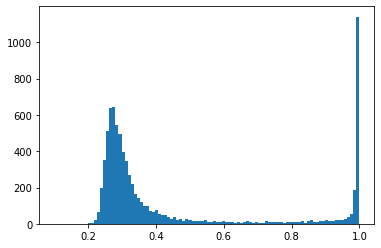

In [13]:
pseudo_df = pd.read_csv(PSEUDO_CSV)
plt.hist(pseudo_df["target"], bins=100, label="use target_real")
plt.show()

np.clip(pseudo_df['target'], 0.2, None)
10.0 0.0
(7975, 32)
(7327, 32)


0    6478
1     849
Name: real_sim, dtype: int64


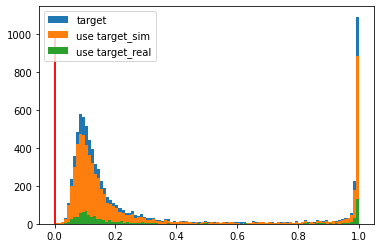

pseudo_df.shape: (7327, 32)


In [14]:
# ==================================================
# for Pseudo
# ==================================================
from sklearn.preprocessing import MinMaxScaler

if PSEUDO_CSV != "":
    pseudo_df = pd.read_csv(PSEUDO_CSV)
    pseudo_df["path"] = INPUT_DIR_TEST + "/test/" + pseudo_df["id"] + ".hdf5"
    #display(pseudo_df)
    
    if PSEUDO_CSV == "./kaggle_dl/sub_csvs/sub_avg_lb0771.csv":
        print("np.clip(pseudo_df['target'], 0.2, None)")
        # lb0.771のは最小値に外れ値があるのでclip
        pseudo_df["target"] = np.clip(pseudo_df["target"], 0.2, None)
        
    elif PSEUDO_CSV == "./kaggle_dl/sub_csvs/sub_avg_ver18_lb0772.csv":
        print("np.clip(pseudo_df['target'], 0.2, None)")
        # lb0.772のは最小値に外れ値があるのでclip
        pseudo_df["target"] = np.clip(pseudo_df["target"], 0.2, None)
        
    elif PSEUDO_CSV == "./kqi_dl/lb0.774_kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep/lb0.774_kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep_submission.csv":
        print("np.clip(pseudo_df['target'], 0.21, None)")
        # lb0.774のは最小値に外れ値があるのでclip
        pseudo_df["target"] = np.clip(pseudo_df["target"], 0.21, None)
        
    elif PSEUDO_CSV == "./kqi_dl/lb0.775_kqi_3090_ex075_v2_tta_v3_pseudo_v3_hvflip_stride12_lb0771_1000_simall_100ep/lb0.775_kqi_3090_ex075_v2_tta_v3_pseudo_v3_hvflip_stride12_lb0771_1000_simall_100ep_submission_tta012.csv":
        print("np.clip(pseudo_df['target'], 0.22, None)")
        # lb0.775のは最小値に外れ値があるのでclip
        pseudo_df["target"] = np.clip(pseudo_df["target"], 0.22, None)
        
    elif PSEUDO_CSV == "./kaggle_dl/sub_csvs/sub_avg_ver25_lb0777.csv":
        print("np.clip(pseudo_df['target'], 0.22, None)")
        # lb0.775のは最小値に外れ値があるのでclip
        pseudo_df["target"] = np.clip(pseudo_df["target"], 0.22, None)
    
    pseudo_df = pd.merge(pseudo_df, test_df[["id", "real_sim"]], on="id")
    
    # 確信度0-1に正規化
    pseudo_df["target"] = MinMaxScaler().fit_transform(pseudo_df["target"].values.reshape(-1, 1))
    #display(pseudo_df)
    
    # 分布可視化
    plt.hist(pseudo_df["target"], bins=100, label="target")
    
    p_sim_df = pseudo_df[pseudo_df["real_sim"] == 0].copy()
    p_real_df = pseudo_df[pseudo_df["real_sim"] == 1].copy()
    
    # 確信度が高い低いものだけ採用。0なら全部入れる
    if cfg_pseudo_max > 0:
        pseudo_df = pseudo_df[ (pseudo_df["target"] > cfg_pseudo_max) | (pseudo_df["target"] < cfg_pseudo_min) ].reset_index(drop=True)
        #display(pseudo_df)
        
    # simデータが高い低いものだけ採用
    if cfg_pseudo_sim_max > 0:
        p_sim_df = p_sim_df[ (p_sim_df["target"] > cfg_pseudo_sim_max) | (p_sim_df["target"] < cfg_pseudo_sim_min) ].reset_index(drop=True)
        pseudo_df = pd.concat([pseudo_df, p_sim_df]).drop_duplicates()
    elif cfg_pseudo_sim_max == 0:
        # 0なら全部入れる
        pseudo_df = pd.concat([pseudo_df, p_sim_df]).drop_duplicates()
    elif cfg_pseudo_sim_max == -1:
        # -1なら追加なし
        pass
        
    # realデータが高い低いものだけ採用
    if cfg_pseudo_real_max > 0:
        p_real_df = p_sim_df[ (p_sim_df["target"] > cfg_pseudo_real_max) | (p_sim_df["target"] < cfg_pseudo_real_min) ].reset_index(drop=True)
        pseudo_df = pd.concat([pseudo_df, p_real_df]).drop_duplicates()
    elif cfg_pseudo_real_max == 0:
        # 0なら全部入れる
        pseudo_df = pd.concat([pseudo_df, p_real_df]).drop_duplicates()
    elif cfg_pseudo_real_max == -1:
        # -1なら追加なし
        pass
        
    # ハードラベルにする
    if cfg_is_pseudo_hard:
        pseudo_df.loc[pseudo_df["target"] >= 0.5, "target"] = 1
        pseudo_df.loc[pseudo_df["target"] < 0.5, "target"] = 0
        pseudo_df["target"] = pseudo_df["target"].astype(int)
        #display(pseudo_df)
        print("pseudo_df['target'].value_counts():")
        print(pseudo_df["target"].value_counts())
        pseudo_df.target.plot.hist()
        plt.show()
        
    # test setと同じサイズに変更
    pseudo_df = pd.merge(pseudo_df[["id", "target"]], test_df.drop("target", axis=1), on="id").reset_index(drop=True)
    
    # MultiOutputに使う freq_min//N 列をつくる
    pseudo_df["freq_min//N"] = pseudo_df["freq min"] // cfg_freq_div_n
    print(pseudo_df["freq_min//N"].max(), pseudo_df["freq_min//N"].min())

    # 振幅が外れ値のpseudo_label除く
    if (DEL_Outlier_Pseudo_MEAN_TH > 0) or (DEL_Outlier_Pseudo_STD_TH > 0):
        print(pseudo_df.shape)
        pseudo_df = pseudo_df[
            (pseudo_df["h1_l1_mean"] <= DEL_Outlier_Pseudo_MEAN_TH)
            & (pseudo_df["h1_l1_std"] <= DEL_Outlier_Pseudo_STD_TH)
        ].reset_index(drop=True)
        print(pseudo_df.shape)
        display(
            pseudo_df[["h1_mean", "l1_mean", "h1_std", "l1_std", "h1_l1_mean", "h1_l1_std"]]
            .describe()
            .style.background_gradient(cmap="Blues")
        )
        print(pseudo_df["real_sim"].value_counts())
        
    # 分布可視化
    plt.hist(pseudo_df.loc[pseudo_df["real_sim"]==0, "target"], bins=100, label="use target_sim")
    plt.hist(pseudo_df.loc[pseudo_df["real_sim"]==1, "target"], bins=100, label="use target_real")
    plt.vlines(cfg_pseudo_max, 0, 1000, colors="red")
    plt.vlines(cfg_pseudo_min, 0, 1000, colors="red")
    plt.legend()
    plt.show()
    plt.clf()  # メモリ解放
    plt.close()
    
    pseudo_df.to_csv(f"{OUTPUT_DIR}/pseudo_df.csv", index=False)  # 学習直前でロードするためにcsvにしておく
    print("pseudo_df.shape:", pseudo_df.shape)
    #display(pseudo_df)
    #print(pseudo_df["freq_min//10"].value_counts())
    #print(pseudo_df["freq_min//10"].max(), pseudo_df["freq_min//10"].min())

In [15]:
# ==================================================
# for Pseudo 追加
# ==================================================
if ADD_PSEUDO_DIRS != "":
    
    add_pseudo_df = None
    for _add_dir in eval(ADD_PSEUDO_DIRS):
        if "/kqi/output" in os.getcwd():
            _suff = ".npy"
        else:
            _suff = ".hdf5"
    
        _add_df = pd.read_csv(_add_dir + "/df.csv")
        _add_df["path"] = _add_dir + "/" + _add_df["id"] + _suff
        
        # df_summary.csv 連結
        _sum_df = pd.read_csv(f"{_add_dir}/df_summary.csv").drop("target", axis=1)
        _add_df = pd.merge(_add_df, _sum_df, on="id")
        
        if add_pseudo_df is None:
            add_pseudo_df = _add_df
        else:
            add_pseudo_df = pd.concat([add_pseudo_df, _add_df]).reset_index(drop=True)
            
        # MultiOutputに使う freq_min//N 列をつくる
        add_pseudo_df["freq_min//N"] = add_pseudo_df["freq min"] // cfg_freq_div_n
        print(add_pseudo_df["freq_min//N"].max(), add_pseudo_df["freq_min//N"].min())

    add_pseudo_df.to_csv(f"{OUTPUT_DIR}/add_pseudo_df.csv", index=False)  # 学習直前でロードするためにcsvにしておく
    print("add_pseudo_df.shape:", add_pseudo_df.shape)
    #display(add_pseudo_df)
    #print(add_pseudo_df["freq_min//10"].value_counts())
    #print(add_pseudo_df["freq_min//10"].max(), add_pseudo_df["freq_min//10"].min())

In [16]:
#=====

In [17]:
if cfg_spec_max == 4096:
    # https://www.kaggle.com/code/anonamename/g2net2-mean-psd/notebook?scriptVersionId=109593703
    # shape: (360, 4096)
    a_abs_mean_h1 = np.load(f"./kaggle_dl/g2net2_Mean_PSD_v2/df_DET_H1.npy")  # データセットの移動平均の絶対値
    a_abs_mean_l1 = np.load(f"./kaggle_dl/g2net2_Mean_PSD_v2/df_DET_L1.npy")  # データセットの移動平均の絶対値
elif cfg_spec_max == 4279:
    # https://www.kaggle.com/code/anonamename/g2net2-mean-psd-spec-max4279?scriptVersionId=110466908
    # shape: (360, 4279)
    a_abs_mean_h1 = np.load(f"./kaggle_dl/g2net2-mean-psd-spec-max4279_v1/df_DET_H1.npy")  # データセットの移動平均の絶対値
    a_abs_mean_l1 = np.load(f"./kaggle_dl/g2net2-mean-psd-spec-max4279_v1/df_DET_L1.npy")  # データセットの移動平均の絶対値
elif cfg_spec_max == 5760:
    # https://www.kaggle.com/code/anonamename/g2net2-mean-psd-largekernel-abs?scriptVersionId=111603297
    # shape: (360, 5760)
    a_abs_mean_h1 = np.load(f"./kaggle_dl/g2net2-mean-psd-largekernel-abs_v1/df_DET_H1.npy")  # データセットの移動平均の絶対値
    a_abs_mean_l1 = np.load(f"./kaggle_dl/g2net2-mean-psd-largekernel-abs_v1/df_DET_L1.npy")  # データセットの移動平均の絶対値


In [18]:
# ====================================================================================
# 前処理の helper 関数
# ====================================================================================
def get_cut_ids(ts, step: int):
    """同程度の時間幅になるタイムスタンプのインデックスを取得"""
    full_length = ts.max() - ts.min() + 1
    cut_length = full_length // step  # この時間単位でidx取得する
    cut_ids = [0] 
    _store = 0
    for i in range(1, len(ts)):
        _store += ts[i] - ts[i-1]
        if _store > cut_length:
            cut_ids.append(i)
            _store = 0
    if cut_ids[-1] != len(ts) - 1:
        cut_ids += [len(ts) - 1] 
    return cut_ids  # リストの長さはstepより少ないので注意すること


def standardization(x , mu: float, std: float, max_pixel_value=None):
    """標準化"""
    if max_pixel_value is None:
        return (x - mu) / std
    else:
        # https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.Normalize
        return (x - mu * max_pixel_value) / (std * max_pixel_value)

    
def a2p(a):
    """振幅をパワーに変換"""
    a = a[:,:]
    a = a * FCOFF
    #a = a * 1e22  # Fourier coefficient complex64  # 正規化しない場合ではこの係数だと振幅大きいデータでnanになる
    #a = a * 1e21
    #a = a * 1e20  # 振幅低くなりすぎて精度でない
    p = a.real**2 + a.imag**2  # power. shape=(360, 4224など)
    return p


def power_norm(p, norm_type: str, s: str = ""):
    """パワーを正規化"""
    if "p-norm" in norm_type:
        # normalize
        p /= np.mean(p)
    elif "p-stand" in norm_type:
        # チャネルごとの平均と標準偏差で標準化
        p = standardization(p, p.mean(), p.std())
    elif "p-common-stand" in norm_type:
        # データセット全体の統計値で標準化
        if s == "H1":
            p = standardization(p, cfg_p_mean[0], cfg_p_std[0])
        else:
            p = standardization(p, cfg_p_mean[1], cfg_p_std[1])
    elif "p-max" in norm_type:
        # 最大値で割って0-1にする
        p /= np.max(p)
        # MinMaxScaler
        #p = MinMaxScaler().fit_transform(p)
    elif "p-robustscaler" in norm_type:
        # RobustScaler
        p = RobustScaler().fit_transform(p)
    return p


def power_a_comp(p, step: int, spec_max: int, freq: int, norm_type: str):
    """パワーをtimestepsごとに平均+resizeして圧縮する"""
    if "ts-ma" in norm_type:
        ### timestepsごとに移動平均. compress 4096 -> 127
        
        # https://www.kaggle.com/anonamename/g2net2-exporing-test-train-datasets
        n_ma = spec_max//step

        # 累積合計を計算。 np.cumsum(np.array([1, 2, 3, 4, 5, 6])): [ 1  3  6 10 15 21]
        power_ma_cumsum = np.cumsum(p, axis=1)  

        # 累積合計をMA個の要素ごとの平均とる
        power_ma_cumsum_0 = np.concatenate((np.zeros((p.shape[0],1)), power_ma_cumsum), axis=1)[:,::n_ma]  

        # 累積合計を平均で引き算。numpy.diff() は受け取った配列の隣り合う要素同士の差分をとる
        p = np.diff(power_ma_cumsum_0, axis=1)[:,:-1]/n_ma  
        
    elif "ts-a" in norm_type:
        # timestepsごとに平均. compress 4096 -> 128
        p = np.mean(p.reshape(freq, step, spec_max//step), axis=2)
        
    return p

def power_img_clip(img):
    """
    H1とL1でパワーの最大値が違いすぎる画像はノイズっぽいので、最大値が小さい方のチャネルを基準にして最大値大きい方のチャネルの値をクリッピングする
    """
    #th_max = 1.5
    th_max = 2.0
    th_clip = 1.25
    #print(np.max(img[0]), np.max(img[1]))
    if (np.max(img[0]) > np.max(img[1])*th_max):  # 一方のチャネルよりも最大値が th_max 倍も大きい場合
        img[0] = np.clip(img[0], None, np.max(img[1])*th_clip)  # 値小さい方のチャネルの最大値 x th_clip の値で閾値以上の部分クリッピング
        
        _x_clip = img[0][img[0] == np.max(img[1])*th_clip]  # クリッピング部分
        _x_other = img[0][img[0] != np.max(img[1])*th_clip]  # クリッピングしてない部分
        
        # クリッピングしてない部分の平均と標準偏差でガウスノイズ生成してクリッピング部分の値を置き換える
        img[0][img[0] == np.max(img[1])*th_clip] = np.random.normal(np.mean(_x_other), np.std(_x_other), _x_clip.shape)
        
        #img[0] = RobustScaler().fit_transform(img[0])
        
    if (np.max(img[1]) > np.max(img[0])*th_max):  # 一方のチャネルよりも最大値が th_max 倍も大きい場合
        img[1] = np.clip(img[1], None, np.max(img[0])*th_clip)  # 値小さい方のチャネルの最大値 x th_clip の値で閾値以上の部分クリッピング
        
        _x_clip = img[1][img[1] == np.max(img[0])*th_clip]  # クリッピング部分
        _x_other = img[1][img[1] != np.max(img[0])*th_clip]  # クリッピングしてない部分
        
        # クリッピングしてない部分の平均と標準偏差でガウスノイズ生成してクリッピング部分の値を置き換える
        img[1][img[1] == np.max(img[0])*th_clip] = np.random.normal(np.mean(_x_other), np.std(_x_other), _x_clip.shape)
        
        #img[1] = RobustScaler().fit_transform(img[1])

    return img

# ====================================================================================
# 前処理のメイン関数
# ====================================================================================
def amp2power(a, s, step, spec_max, norm_type, freq, ts=None):
    """振幅をパワーに変換して前処理も実行するメイン関数"""
    
    if "spec-sequence_a" in norm_type:
        ### gap区切りでパワーを圧縮してから正規化
        # 振幅をパワーに変換
        p = a2p(a)

        # 1つ隣のタイムポイントで引き算して+1800。基本の間隔は1800なので連続して計測してる場合は0になる
        gap_length = ts[1:] - (ts[:-1] + 1800)  

        # 隣接データでタイムポイントが0以上になった1800以上空いてるデータ点のインデックスのリスト
        gap_length_nonzero_idx = np.argwhere(gap_length != 0).flatten()
        #gap_length_nonzero_idx = gap_length_nonzero_idx[::2]  # 1つ飛ばしでidx取る場合

        # gapがある時刻区切りで平均化
        p_sequence_a = np.empty((freq, len(gap_length_nonzero_idx)+1), dtype=np.float32)
        s_idx = 0
        for i, e_idx in enumerate(gap_length_nonzero_idx):
            #print(i, s_idx, e_idx, np.mean(p[:,s_idx:e_idx], axis=1).shape, p_sequence_a[:,i].shape)
            p_sequence_a[:,i] = np.mean(p[:,s_idx:e_idx], axis=1)
            s_idx = e_idx
        if e_idx != len(gap_length_nonzero_idx)-1:
            p_sequence_a[:,-1] = np.mean(p[:,e_idx:], axis=1)

        # 後続処理のためstep単位のサイズにしておく
        spec_max = step*(p_sequence_a.shape[1]//step)
        p = p_sequence_a[:,:spec_max]
    
        p = power_a_comp(p, step, spec_max, freq, norm_type)  # パワーを圧縮
        p = power_norm(p, norm_type, s=s)  # パワーを正規化
        
    else:
        if "default-norm" in norm_type:
            ### パワーを正規化してから圧縮(public NBの前処理)
            p = a2p(a)  # 振幅をパワーに変換
            p = power_norm(p, norm_type, s=s)  # パワーを正規化
            p = power_a_comp(p, step, spec_max, freq, norm_type)  # パワーを圧縮
        else:
            ### パワーを圧縮してから正規化
            p = a2p(a)  # 振幅をパワーに変換
            p = power_a_comp(p, step, spec_max, freq, norm_type)  # パワーを圧縮
            p = power_norm(p, norm_type, s=s)  # パワーを正規化
            
    return p


# https://www.kaggle.com/code/junkoda/basic-spectrogram-image-classification
def hdf5_to_img(h_path, step, spec_max, 
                norm_type=normalize_type, 
                ch=2, 
                freq=360,
               ):
    """hdf5ファイルロードしてパワーの画像に変換する"""
    
    if "largekernel" in norm_type:
        # publicNBの前処理
        # https://www.kaggle.com/code/laeyoung/g2net-large-kernel-inference/notebook
        if "p-robustscaler" in norm_type:
            fid, power, h1_m, l1_m = largekernel.dataload(h_path, is_robustscaler=True)
        else:
            fid, power, h1_m, l1_m = largekernel.dataload(h_path, is_robustscaler=False)
        ps = largekernel.preprocess(1, power, h1_m, l1_m, is_cuda=False, is_tta=True)[0]
        
        ## パワー圧縮前に外れ値クリッピング
        #if "clip" in norm_type:
        #    ps = power_img_clip( np.stack([ ps[0], ps[1] ] ) )
        
        p_h1 = power_a_comp(ps[0], step, 5760, freq, norm_type)  # パワーを圧縮
        p_l1 = power_a_comp(ps[1], step, 5760, freq, norm_type)  # パワーを圧縮
        img = np.stack([ p_h1, p_l1 ] ).astype(np.float32)
        
        # パワー圧縮後に外れ値クリッピング
        if "clip" in norm_type:
            img = power_img_clip(img)
        
        return img
    
    file_id = Path(h_path).stem
    img = None
    with h5py.File(h_path, 'r') as f:
        g = f[file_id]
        
        a_h1, ts_h1 = g["H1"]['SFTs'][:], g["H1"]['timestamps_GPS'][:]
        a_l1, ts_l1 = g["L1"]['SFTs'][:], g["L1"]['timestamps_GPS'][:]
        
        ## 振幅の外れ値クリッピング
        #if "clip" in norm_type:
        #    a_clip = power_img_clip( np.stack([ a_h1, a_l1 ] ) )
        #    a_h1, a_l1 = a_clip[0], a_clip[1]
        
        if "same_ts_interval" in norm_type:
            ### H1,L1のズレを軽減するために、同じ時間間隔でパワーを平均してから正規化
            
            # 同程度の時間幅になるタイムスタンプのインデックスを取得
            h1_cut_ids = get_cut_ids(ts_h1, step+10)  # stepより小さくなるから大きめに取る
            l1_cut_ids = get_cut_ids(ts_l1, step+10)  # stepより小さくなるから大きめに取る
            #print(len(ts_h1), h1_cut_ids)
            #print(len(ts_l1), l1_cut_ids)
            
            # サイズ揃える
            n_min = min(len(h1_cut_ids), len(l1_cut_ids))
            img = np.empty((ch, freq, n_min-1), dtype=np.float32)
            p_h1 = a2p(a_h1)
            p_l1 = a2p(a_l1)
            for i in range(1, n_min):
                img[0,:,i-1] = np.mean(p_h1[:,h1_cut_ids[i-1]:h1_cut_ids[i]], axis=1)  # パワーを圧縮
                img[1,:,i-1] = np.mean(p_l1[:,l1_cut_ids[i-1]:l1_cut_ids[i]], axis=1)  # パワーを圧縮
            img[0] = power_norm(img[0], norm_type, s="H1")  # パワーを正規化
            img[1] = power_norm(img[1], norm_type, s="L1")  # パワーを正規化
            if "ts-ma" in norm_type:
                img = img[:,:,:step-1]
            else:
                img = img[:,:,:step]
            #print(img.shape)
            
        else:
            ### 振幅をパワーに変換
            p_h1 = amp2power(a_h1, "H1", step, spec_max, norm_type, freq, ts=ts_h1)
            p_l1 = amp2power(a_l1, "L1", step, spec_max, norm_type, freq, ts=ts_l1)
            # サイズ揃える
            min_len = min(p_h1.shape[1], p_l1.shape[1])
            img = np.stack([ p_h1[:,:min_len], p_l1[:,:min_len] ] ).astype(np.float32)
            
        # パワー圧縮後に外れ値クリッピング
        if "clip" in norm_type:
            img = power_img_clip(img)
        
    return img

# Quick EDA

In [19]:
def show_1img_2ch(img):
    
    if normalize_type == "default_3ch":
        plt.figure(figsize=(20, 12))
        
        for i in range(img.shape[0]):
            plt.subplot(1, 6, i+1)
            plt.title('Spectrogram')
            plt.xlabel('time')
            plt.ylabel('frequency')
            plt.imshow(img[i])
            plt.colorbar()
            
        plt.tight_layout()
        plt.show()
        plt.clf()  # メモリ解放
        plt.close()
    else:
        plt.figure(figsize=(10, 10))
        
        plt.subplot(1, 2, 1)
        plt.title('H1 Spectrogram')
        plt.xlabel('time')
        plt.ylabel('frequency')
        plt.imshow(img[0])
        plt.colorbar()

        plt.subplot(1, 2, 2)
        plt.title('L1 Spectrogram')
        plt.xlabel('time')
        plt.ylabel('frequency')
        plt.imshow(img[1])
        plt.colorbar()

        plt.tight_layout()
        plt.show()
        plt.clf()  # メモリ解放
        plt.close()

In [20]:
#normalize_type = "largekernel|p-robustscaler|ts-ma"
#normalize_type = "largekernel|p-robustscaler|ts-ma|clip"
#
#print()
#_path = test_df.iloc[806]["path"]
#if "/kqi/output" in os.getcwd():
#    _path = "/kqi/output/g2net-detecting-continuous-gravitational-waves/test/698567d90.hdf5"
#else:
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/698567d90.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/7921a1a90.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/308417080.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/7ee0a00f8.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/9f37c3fde.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/0bf7da48d.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/b0990161d.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/d1da4fc07.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/4ca95032a.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/5e2305d9d.hdf5"
#    pass
#print(_path)
#img = hdf5_to_img(_path, cfg_step, cfg_spec_max, 
#                  norm_type=normalize_type, 
#                  ch=cfg_ch, 
#                  freq=360)
#print("img.max(), img.min():", img.max(), img.min())
#print("img.shape:", img.shape)
#print("y:", test_df.iloc[806]["target"])
#show_1img_2ch(img)
#print(img)

=> train label dist
1    400
0    200
Name: target, dtype: int64

=> train+test SFTs w
H1 SFTs w max(), min() 4887.0 4281.0
L1 SFTs w max(), min() 4878.0 4279.0

=> normalize_type: largekernel|p-robustscaler|ts-ma|clip
/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/train/02887d232.hdf5
img.max(), img.min(): 0.98065305 -0.21488716
img.shape: (2, 360, 127)
y: 1


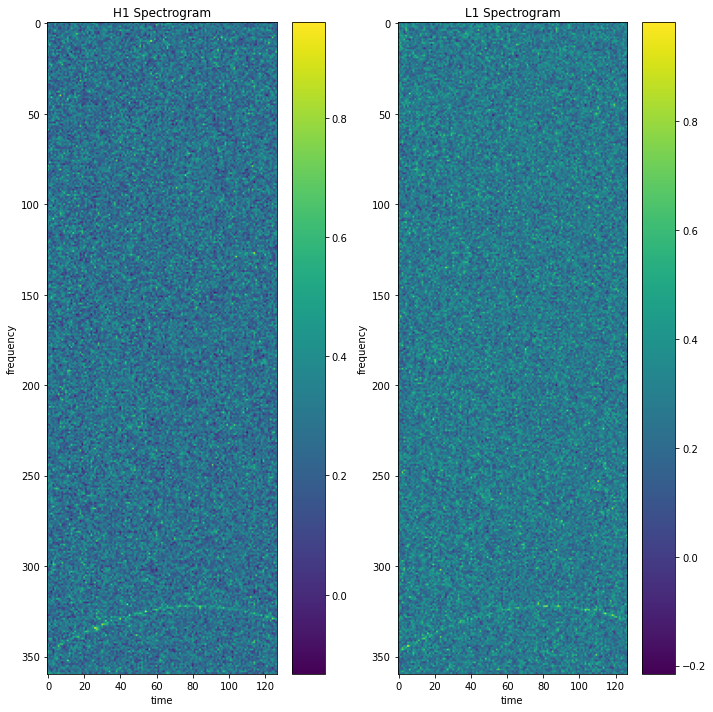

[[[0.35452235 0.14961474 0.33968183 ... 0.24742839 0.14463434 0.39938694]
  [0.2611888  0.4052323  0.23059689 ... 0.3000868  0.21152344 0.1974745 ]
  [0.10701338 0.2668063  0.27681237 ... 0.32322863 0.23451877 0.22223307]
  ...
  [0.31458613 0.24622752 0.02045513 ... 0.086301   0.17409939 0.27231988]
  [0.32338277 0.42374784 0.14893036 ... 0.39658204 0.3378879  0.03461371]
  [0.53561616 0.5145869  0.46702763 ... 0.30373535 0.33903265 0.279796  ]]

 [[0.1438058  0.27603748 0.16885151 ... 0.28923067 0.27438423 0.25036892]
  [0.54484856 0.26137552 0.44855195 ... 0.5445177  0.26966688 0.28990886]
  [0.27975225 0.26008388 0.48412114 ... 0.21518284 0.38659397 0.30888942]
  ...
  [0.17470047 0.22588708 0.09281849 ... 0.1878228  0.20659722 0.197111  ]
  [0.08579326 0.3584927  0.59807014 ... 0.35620388 0.14344347 0.4163113 ]
  [0.18120077 0.31115356 0.24057066 ... 0.21892904 0.38403863 0.37262914]]]

/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/0040fc1b3.hdf5
im

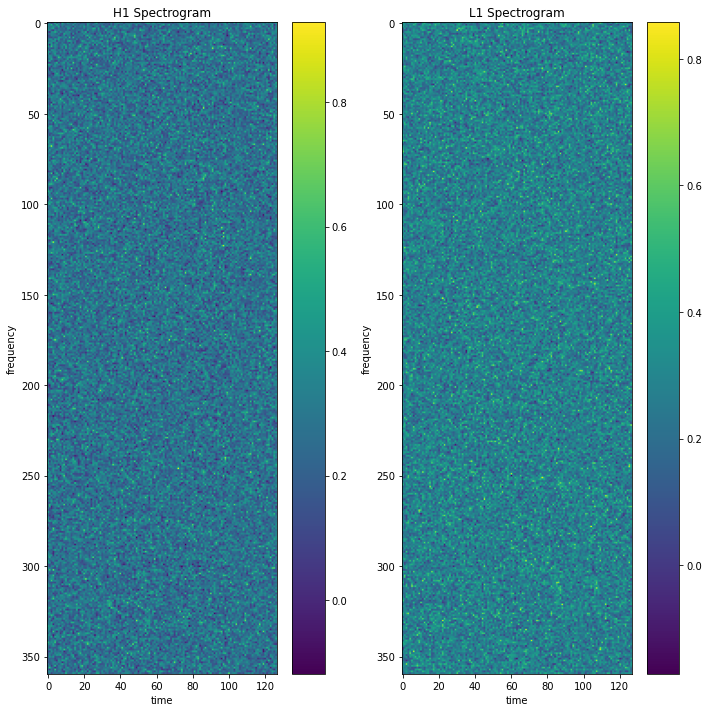

[[[0.0777996  0.32967365 0.03680975 ... 0.22034776 0.30780438 0.46071234]
  [0.43269637 0.32472864 0.5836586  ... 0.5270345  0.00513238 0.2650472 ]
  [0.3315693  0.32498905 0.2944106  ... 0.34633246 0.13378906 0.3407091 ]
  ...
  [0.18048933 0.05236905 0.2839613  ... 0.20228136 0.03729384 0.3282552 ]
  [0.33733582 0.3844889  0.31242514 ... 0.46357423 0.3938124  0.26174045]
  [0.17724101 0.3317081  0.09024942 ... 0.3520128  0.13036025 0.23701985]]

 [[0.42781076 0.33849174 0.20807554 ... 0.21072592 0.16651747 0.10786947]
  [0.32008842 0.38500202 0.2310256  ... 0.38838163 0.332921   0.23005642]
  [0.48866844 0.22756225 0.37785798 ... 0.44817436 0.07503527 0.13509385]
  ...
  [0.25166294 0.32143602 0.30389765 ... 0.35215116 0.39118925 0.14822592]
  [0.17174847 0.31814975 0.4142854  ... 0.04171821 0.32453343 0.18767633]
  [0.15847763 0.2148445  0.30511883 ... 0.3456977  0.37381727 0.30547145]]]


In [21]:
print("=> train label dist")
print(train_df.target.value_counts())
print()

print("=> train+test SFTs w")
_df = pd.concat([train_df, test_df])
print("H1 SFTs w max(), min()", _df["H1 SFTs w"].max(), _df["H1 SFTs w"].min())
print("L1 SFTs w max(), min()", _df["L1 SFTs w"].max(), _df["L1 SFTs w"].min())
print()

#normalize_type = "default-norm|p-norm|ts-a"
#normalize_type = "default-norm|p-norm|ts-ma"
#normalize_type = "spec-sequence_a|ts-ma|p-norm"
#normalize_type = "spec-sequence_a|ts-ma|p-stand"
#normalize_type = "spec-sequence_a|ts-ma|p-common-stand"
#normalize_type = "ts-ma|p-norm"
#normalize_type = "ts-ma|p-stand"
#normalize_type = "ts-ma|p-common-stand"
#normalize_type = "ts-ma|p-robustscaler"
#normalize_type = "same_ts_interval|p-stand"
#normalize_type = "same_ts_interval|p-common-stand"
#normalize_type = "largekernel|ts-ma"
#normalize_type = "largekernel|p-robustscaler|ts-ma"
#normalize_type = "largekernel|p-robustscaler|ts-ma|clip"
#normalize_type = "largekernel"

#cfg_step = 32
#cfg_step = 64
#cfg_step = 128

#cfg_spec_max = 4096
#cfg_spec_max = 4224


# 画像可視化
print("=> normalize_type:", normalize_type)

_i = 10
_path = train_df.iloc[_i]["path"]
#_path = add_df_all.iloc[_i]["path"]
#if "/work" in os.getcwd():
#    _path = sorted(glob.glob(f"{ADD_DIR_TRAIN}/*.hdf5"))[-1]
print(_path)
img = hdf5_to_img(_path, cfg_step, cfg_spec_max, 
                  norm_type=normalize_type, 
                  ch=cfg_ch, 
                  freq=360,
                 )
print("img.max(), img.min():", img.max(), img.min())
print("img.shape:", img.shape)
print("y:", train_df.iloc[_i]["target"])
show_1img_2ch(img)
print(img)

print()
_path = test_df.iloc[_i]["path"]
#_path = test_df.iloc[806]["path"]
#if "/kqi/output" in os.getcwd():
#    _path = "/kqi/output/g2net-detecting-continuous-gravitational-waves/test/698567d90.hdf5"
#else:
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/698567d90.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/7921a1a90.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/308417080.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/7ee0a00f8.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/9f37c3fde.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/0bf7da48d.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/b0990161d.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/d1da4fc07.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/4ca95032a.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/5e2305d9d.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/a666b93a9.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/d6828b59a.hdf5"
print(_path)
img = hdf5_to_img(_path, cfg_step, cfg_spec_max, 
                  norm_type=normalize_type, 
                  ch=cfg_ch, 
                  freq=360)
print("img.max(), img.min():", img.max(), img.min())
print("img.shape:", img.shape)
print("y:", test_df.iloc[806]["target"])
show_1img_2ch(img)
print(img)

In [22]:
#%debug

In [23]:
#=====

# To npy

In [24]:
#!rm -r {NPY_DIR}/{normalize_type}

In [25]:
import multiprocessing
from concurrent.futures import ThreadPoolExecutor

def hdf5_to_npy(h_paths, out_dir):
    """
    前処理したhdf5データをnpyに保存する
    """
    if cfg_is_npy and (os.path.exists(out_dir) == False): 
        os.makedirs(out_dir, exist_ok=True)
        for _path in tqdm(h_paths):
            img = hdf5_to_img(_path, cfg_step, cfg_spec_max, 
                              norm_type=normalize_type, 
                              ch=cfg_ch, 
                              freq=360,
                             )
            np.save(os.path.join(out_dir, f'{Path(_path).stem}.npy'), np.array(img))
    else:
        print(f"INFO: Exist {out_dir}")


if cfg_is_npy:
    _npy_dir = f"{NPY_DIR}/{normalize_type}"
    _max_workers = multiprocessing.cpu_count()  # total CPU
    with ThreadPoolExecutor(max_workers=_max_workers, thread_name_prefix="thread") as executor:
        hdf5_to_npy(train_df["path"].to_numpy(), f"{_npy_dir}/train")
        if IS_MAKE_SUB or (PSEUDO_CSV != ""):
            hdf5_to_npy(test_df["path"].to_numpy(), f"{_npy_dir}/test")
        if ADD_DIRS_STR != "":
            for _add_dir in eval(ADD_DIRS_STR):
                hdf5_to_npy(sorted(glob.glob(f"{_add_dir}/*.hdf5")), f"{_npy_dir}/{Path(_add_dir).stem}")
        if ADD_PSEUDO_DIRS != "":
            for _add_dir in eval(ADD_PSEUDO_DIRS):
                hdf5_to_npy(sorted(glob.glob(f"{_add_dir}/*.hdf5")), f"{_npy_dir}/{Path(_add_dir).stem}")
        
    # path書き換え
    train_df["path"] = f"{_npy_dir}/train/" + train_df["id"] + ".npy"
    print(train_df["path"].iloc[0])  # パス確認
    if IS_MAKE_SUB:
        test_df["path"] = f"{_npy_dir}/test/" + test_df["id"] + ".npy"
        print(test_df["path"].iloc[0])  # パス確認
    if ADD_DIRS_STR != "":
        add_df_all["path"] = [
            f"{_npy_dir}/{Path(p).parent.stem}/{Path(p).stem}.npy"
            for p in add_df_all["path"].to_numpy()
        ]
        add_df_all.to_csv(f"{OUTPUT_DIR}/add_data.csv", index=False)  # 学習直前でロードするためにcsvにしておく
        print(add_df_all["path"].iloc[0])  # パス確認
    if PSEUDO_CSV != "":
        pseudo_df["path"] = f"{_npy_dir}/test/" + pseudo_df["id"] + ".npy"
        pseudo_df.to_csv(f"{OUTPUT_DIR}/pseudo_df.csv", index=False)  # 学習直前でロードするためにcsvにしておく
        print(pseudo_df["path"].iloc[0])  # パス確認
    if ADD_PSEUDO_DIRS != "":
        add_pseudo_df["path"] = [
            f"{_npy_dir}/{Path(p).parent.stem}/{Path(p).stem}.npy"
            for p in add_pseudo_df["path"].to_numpy()
        ]
        add_pseudo_df.to_csv(f"{OUTPUT_DIR}/add_pseudo_df.csv", index=False)  # 学習直前でロードするためにcsvにしておく
        print(add_pseudo_df["path"].iloc[0])  # パス確認

INFO: Exist /volume-ssd/kaggle_g2net2/npys/largekernel|p-robustscaler|ts-ma|clip/train
INFO: Exist /volume-ssd/kaggle_g2net2/npys/largekernel|p-robustscaler|ts-ma|clip/test
INFO: Exist /volume-ssd/kaggle_g2net2/npys/largekernel|p-robustscaler|ts-ma|clip/ex003_generating_noise_2_gap
INFO: Exist /volume-ssd/kaggle_g2net2/npys/largekernel|p-robustscaler|ts-ma|clip/ex005_generating_signal_gap
INFO: Exist /volume-ssd/kaggle_g2net2/npys/largekernel|p-robustscaler|ts-ma|clip/ex005_generating_signal_gap_1
INFO: Exist /volume-ssd/kaggle_g2net2/npys/largekernel|p-robustscaler|ts-ma|clip/ex005_generating_signal_gap_iso
INFO: Exist /volume-ssd/kaggle_g2net2/npys/largekernel|p-robustscaler|ts-ma|clip/ex005_generating_signal_gap_iso_1
INFO: Exist /volume-ssd/kaggle_g2net2/npys/largekernel|p-robustscaler|ts-ma|clip/ex006_generating_noise_gap1400
INFO: Exist /volume-ssd/kaggle_g2net2/npys/largekernel|p-robustscaler|ts-ma|clip/ex006_generating_signal_gap800
INFO: Exist /volume-ssd/kaggle_g2net2/npys/la

In [26]:
#=====

# Libraries

In [27]:
import warnings
warnings.filterwarnings("ignore")  

import os
import gc
import cv2
import math
import copy
import time
import random
import shutil
import yaml
import glob
from pprint import pprint
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter, OrderedDict
import traceback
import imagesize

# For data manipulation
import numpy as np
import pandas as pd
import seaborn as sns
#import plotly.express as px
from PIL import Image
from matplotlib import pyplot as plt

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
from torch.optim import Adam, SGD, AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

import torchaudio

# Utils
import pickle, joblib
from tqdm import tqdm
tqdm.pandas()

# Sklearn Imports
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold, StratifiedGroupKFold

# For Image Models
import timm
print("timm:", timm.__version__)
from timm.data import ImageDataset
from timm.data.mixup import Mixup, one_hot
from timm.data.auto_augment import rand_augment_transform
from timm.loss.cross_entropy import SoftTargetCrossEntropy, LabelSmoothingCrossEntropy
from timm.scheduler import CosineLRScheduler  # warmupつきCosineAnnealingLR

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# tta
import ttach as tta

# DDP
# 何故か3090ではエラーになる
#from accelerate import Accelerator, DistributedType, DistributedDataParallelKwargs

## Synchronized-BatchNorm for DP
## https://blog.shikoan.com/sync-batch-norm-pytorch/
#import sys
#sys.path.append('./Synchronized-BatchNorm-PyTorch')
#from sync_batchnorm import convert_model, DataParallelWithCallback 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

TORCH_VERSION = '.'.join(torch.__version__.split('.')[:3])
print('torch:', TORCH_VERSION)

timm: 0.6.12
device: cuda
torch: 1.13.0+cu117


In [28]:
%reload_ext autoreload
%autoreload 2
from src.sam import SAM, ASAM
from src.cv_split import cv_split, cv_split_kfold

In [29]:
## timmのモデル一覧
## https://github.com/rwightman/pytorch-image-models/blob/master/results/README.md
##!pip install "git+https://github.com/rwightman/pytorch-image-models.git"
#import timm
#from pprint import pprint
#model_names = timm.list_models(pretrained=True)
#pprint(model_names)

In [30]:
#def test_timm_lr_Scheduler():
#    """
#    timmのlr_Schedulerの動作確認
#    https://timm.fast.ai/SGDR#cycle_limit=2
#    """
#    from timm import create_model 
#    from timm.optim import create_optimizer
#    from types import SimpleNamespace
#    from matplotlib import pyplot as plt
#
#    def get_lr_per_epoch(scheduler, num_epoch):
#        lr_per_epoch = []
#        for epoch in range(num_epoch):
#            lr_per_epoch.append(scheduler.get_epoch_values(epoch))
#        return lr_per_epoch
#
#    model = create_model('resnet34')
#
#    num_epoch = 50
#    
#    args = SimpleNamespace()
#    args.weight_decay = 0
#    args.lr = 1e-2
#    args.opt = 'adam' 
#    args.momentum = 0.9
#
#    optimizer = create_optimizer(args, model)
#
#    scheduler = CosineLRScheduler(optimizer, 
#                                  t_initial=num_epoch//3,  # 総エポック数
#                                  lr_min=args.lr*1e-2,  # 最小学習率
#                                  warmup_t=3,  # ウォームアップ完了時のエポック数
#                                  warmup_lr_init=args.lr*1e-2,  # ウォームアップの初期学習率
#                                  warmup_prefix=True,  # Warmupが完了したタイミングの学習率をオプティマイザーで設定した基本学習率にするかどうか
#                                  cycle_limit=1,  # lr restartの回数
#                                 )
#    lr_per_epoch = get_lr_per_epoch(scheduler, num_epoch)
#
#    plt.plot([i for i in range(num_epoch)], lr_per_epoch);
#    
#test_timm_lr_Scheduler()

# CFG

In [31]:
import os, yaml, shutil

class Config:
    def __init__(self):
        self.name=NAME
        self.train=True
        self.debug=DEBUG
        self.print_freq=1000
        self.is_save_per_steps=False
        self.target_col="target"
        self.num_classes=1
        self.loss = "nn.BCEWithLogitsLoss"
        
        self.model_cls=model_cls
        self.apex=cfg_apex
        self.load_model_path=load_model_path
        #self.load_model_path=f"{OUTPUT_DIR}/tmp_fold0_seed0_best_score.pth"
        #self.is_load_opt=True
        self.is_load_opt=False
        
        # ============== model params ==============
        self.model_name=MODEL_NAME
        self.size_h=size_h
        self.size_w=size_w
        self.batch_size=BATCH_SIZE
        self.gradient_accumulation_steps=gradient_accumulation_steps
        self.is_syncBN = is_syncBN
        self.pretrained = cfg_pretrained
        self.drop_rate = cfg_drop_rate
        self.drop_path_rate = cfg_drop_path_rate
        # ==========================================
        
        self.num_workers=8#16 if "/work" in os.getcwd() else 8
        self.epochs=epochs
        self.optimizer=cfg_optimizer
        self.lr=lr
        self.warmup_lr_init=self.lr*min_lr_ratio
        self.min_lr=self.lr*min_lr_ratio
        self.weight_decay=weight_decay
        self.scheduler=cfg_scheduler  # 'CosineLRScheduler'  # warmup
        self.warmup_t=warmup_t
        self.T_max=epochs
        self.max_grad_norm=1000
        
        self.cv_col=cfg_cv_col
        self.seeds=cfg_seeds
        self.n_fold=n_fold
        self.trn_fold=trn_fold
        
        self.is_wandb=is_wandb
        self.device_ids=device_ids
        
        # ============== data params ==============
        self.step=cfg_step
        self.spec_max=cfg_spec_max
        self.ch=cfg_ch
        self.freq=360
        self.norm_type=normalize_type
        # ==========================================
        
        # 自作mixup
        self.prob_mixup = cfg_prob_mixup  # 0.0なら発生確率=0
        self.mix_alpha = 1.0
        self.is_mix_or = True
        #self.mixup_off_epoch = self.epochs-5  # 最後の5epochはmixup/cutmixなしにする
        self.mixup_off_epoch = 0  # 常にmixup/cutmixなし
        
        # label=0ならlabel=0or1とmix, label=1ならlabel=0とmixする確率
        self.prob_sample_mixup = cfg_prob_sample_mixup
        # sample_mixupのデータはpseudoデータだけにするか
        self.is_sample_mixup_use_pseudo = cfg_is_sample_mixup_use_pseudo
        
        # 追加データのtarget=0とオリジナルのtarget=0とのmixup確率
        self.prob_add_sample_nega_mixup = cfg_prob_add_sample_nega_mixup
        
        # データセットの移動平均のpowerとのmixupの確率
        self.prob_mean_mixup = cfg_prob_mean_mixup
        
        # ch追加するか
        self.is_add_ch = cfg_is_add_ch
        
        # スペクトログラムの開始点をランダムに変えるか
        self.prob_spec_start_random = cfg_prob_spec_start_random
        
        # test setのような縦線や横線のノイズ入れる確率
        self.prob_noise_band = cfg_prob_noise_band
        
        # test setのような外れ点ノイズ入れる確率
        self.prob_noise_spot = cfg_prob_noise_spot
        
        # test setのようなまばらな外れ縦線ノイズ入れる確率
        self.prob_noise_vline = cfg_prob_noise_vline
        
        # test setのようなまばらな外れ横バンドノイズ入れる確率
        self.prob_noise_hband = cfg_prob_noise_hband
        
        # target=0のデータのチャネル入れ替える確率
        self.prob_swap_ch_nega = cfg_prob_swap_ch_nega
        
        # target=0のデータhflipする確率
        self.prob_flip_nega = cfg_prob_flip_nega
        
        # target=0のデータ同士をシャッフルする確率
        self.prob_swap_nega = cfg_prob_swap_nega
        
        # target=0のデータをVshiftする確率
        self.prob_vshift_nega = cfg_prob_vshift_nega
        
        # データ関係なくVshiftする確率
        self.prob_vshift = cfg_prob_vshift
        
        # torchaudioで縦横cutout(マスク)する本数
        self.time_mask_num = cfg_time_mask_num  # 縦線
        self.freq_mask_num = cfg_freq_mask_num  # 横線
        self.time_mask_param = cfg_time_mask_param  # マスクの可能な最大長。[0, time_mask_param) 
        self.freq_mask_param = cfg_freq_mask_param  # マスクの可能な最大長。[0, freq_mask_param) 
        
        # zip_datasetをtrainにして学習するか
        self.is_train_zip_dataset = cfg_is_train_zip_dataset
        
        # 生成したデータは別の切り方でfold分けるときに使うKfoldのAPI名(StratifiedKFold, KFoldなど)。""なら別の切り方でfold分けない
        self.add_split_str = cfg_add_split_str
        
        # データをnpyに変換するか
        self.is_npy = cfg_is_npy
        
        # 学習に追加した生成データのディレクトリ名
        self.add_dirs_str = ADD_DIRS_STR
        
        # 学習に追加したtestの疑似ラベルに使うcsv、確信度の閾値、ハードラベルにするか
        self.pseudo_csv = PSEUDO_CSV
        self.pseudo_ths = [cfg_pseudo_max, cfg_pseudo_min]
        self.is_pseudo_hard = cfg_is_pseudo_hard
        
        # 学習に追加したtestの疑似ラベルをリアルデータ/シュミレーションデータだけにするか
        self.pseudo_type = cfg_pseudo_type
        
        # 追加の疑似ラベルのディレクトリ名
        self.add_pseudo_dirs = ADD_PSEUDO_DIRS
        
        # MultiOutputに使う列の要素。freq_min//cfg_freq_div_n の freq_min//N 列をつくる
        self.freq_div_n = cfg_freq_div_n
        
        # これ以上の h1_mean+l1_mean, h1_std+l1_std を取る画像は除いて統計値出し、その統計値でalbの正規化行う
        self.alb_norm_mean_th = cfg_alb_norm_mean_th 
        self.alb_norm_std_th = cfg_alb_norm_std_th  
        

CFG = Config()
        
if CFG.debug:
    #CFG.seeds=[0,1,2]
    CFG.is_wandb=False
    #CFG.is_wandb=True
    CFG.print_freq=10
    CFG.epochs=1
    #CFG.epochs=5
    #CFG.warmup_t=1
    #CFG.mixup_off_epoch=3
    #CFG.epochs=1
    #CFG.mixup_off_epoch=1
    #CFG.epochs=10
    #CFG.trn_fold=[0]
    #CFG.trn_fold=[0,1,2,3,4]
#    train_df = cv_split(train_df, 0, 10, cv_col="target")
#    train_df = train_df[train_df["fold"] == 0].reset_index(drop=True)
#    print("debug train_df.shape:", train_df.shape)
#    test_df = test_df.iloc[:30]
#    print("debug test_df.shape:", test_df.shape)
    # モデル削除
    !rm -f {OUTPUT_DIR}/*pth
    
with open(OUTPUT_DIR + "/cfg.yaml", "w") as wf:
    yaml.dump(CFG.__dict__, wf)
        
if len(CFG.device_ids) > 1:
    os.environ["CUDA_VISIBLE_DEVICES"] = ",".join([str(_) for _ in CFG.device_ids])
    print("os.environ['CUDA_VISIBLE_DEVICES']:", os.environ["CUDA_VISIBLE_DEVICES"])
    CFG.batch_size = CFG.batch_size*len(CFG.device_ids)
else:
    os.environ["CUDA_VISIBLE_DEVICES"] = str(CFG.device_ids[0])
    print("os.environ['CUDA_VISIBLE_DEVICES']:", os.environ["CUDA_VISIBLE_DEVICES"])
    # For descriptive error messages
    os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
    
pprint(CFG.__dict__)

os.environ['CUDA_VISIBLE_DEVICES']: 0
{'T_max': 100,
 'add_dirs_str': '[EX003_NOISE2, EX005_SIGNAL, EX005_SIGNAL1, '
                 'EX005_SIGNAL_ISO, EX005_SIGNAL_ISO1, EX006_NOISE1400, '
                 'EX006_SIGNAL800, EX006_SIGNAL_ISO800, '
                 'EX007_NONSTAT_NOISE800]',
 'add_pseudo_dirs': '',
 'add_split_str': 'StratifiedKFold',
 'alb_norm_mean_th': 5,
 'alb_norm_std_th': 10,
 'apex': True,
 'batch_size': 64,
 'ch': 2,
 'cv_col': 'target',
 'debug': False,
 'device_ids': [0],
 'drop_path_rate': 0.2,
 'drop_rate': 0.4,
 'epochs': 100,
 'freq': 360,
 'freq_div_n': 50,
 'freq_mask_num': 2,
 'freq_mask_param': 10,
 'gradient_accumulation_steps': 1,
 'is_add_ch': False,
 'is_load_opt': False,
 'is_mix_or': True,
 'is_npy': True,
 'is_pseudo_hard': False,
 'is_sample_mixup_use_pseudo': True,
 'is_save_per_steps': False,
 'is_syncBN': False,
 'is_train_zip_dataset': False,
 'is_wandb': True,
 'load_model_path': 'none',
 'loss': 'nn.BCEWithLogitsLoss',
 'lr': 0.0004,
 'm

# Utils

In [32]:
def init_logger(log_file=OUTPUT_DIR + '/train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    #torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print('> SEEDING DONE')

# Wandb

In [33]:
if CFG.is_wandb:
    import wandb
    try:
        from kaggle_secrets import UserSecretsClient
        user_secrets = UserSecretsClient()
        api_key = user_secrets.get_secret("WANDB")
        wandb.login(key=api_key)
        anonymous = None
    except:
        wandb.login(key="")  # 自分の api key でログイン  # https://wandb.ai/settings
        wandb.init(project="", entity='', name=NAME)
        wandb.config.update(CFG.__dict__)  # ハイパラ登録

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: anonamename. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Dataset

In [34]:
class TrainDataset(Dataset):
    def __init__(self, train, transforms=None, 
                 is_npy=True,
                 is_add_ch=False,
                 prob_spec_start_random=0.0,
                 prob_sample_mixup=0.0,
                 is_sample_mixup_use_pseudo=CFG.is_sample_mixup_use_pseudo,
                 prob_add_sample_nega_mixup=0.0,
                 prob_mean_mixup=0.0, 
                 prob_noise_band=0.0,
                 prob_noise_spot=0.0,
                 prob_noise_vline=0.0,
                 prob_noise_hband=0.0,
                 prob_swap_ch_nega=0.0,
                 prob_flip_nega=0.0,
                 prob_swap_nega=0.0,
                 prob_vshift_nega=0.0,
                 prob_vshift=0.0,
                 time_mask_num=0,
                 freq_mask_num=0,
                 time_mask_param=CFG.time_mask_param,
                 freq_mask_param=CFG.freq_mask_param,
                ):
        self.train = train
        self.file_names = train['path'].values
        self.labels = train['target'].values
        self.transforms = transforms
        
        self.labels_freq = train['freq_min//N'].values - (40 // CFG.freq_div_n)  # for MultiOutput
        
        self.orig_flags = train['orig'].values  # np.nanは追加データ
        
        self.is_npy = is_npy  # npyをロードするか
        
        self.prob_spec_start_random = prob_spec_start_random  # スペクトログラムの開始点をランダムに変える確率
        
        self.is_add_ch = is_add_ch  # ch増やすか
        
        #self.train0 = train[train["target"] == 0]   # label=0のdf
        if is_sample_mixup_use_pseudo:
            #self.train0 = train[train["target"] < 0.5]   # label=0のdf pseudoのデータもmix
            self.train0 = pseudo_df[pseudo_df["target"] < 0.5]   # label=0のdf pseudoのデータだけでmix
            if ADD_PSEUDO_DIRS != "":
                self.train0 = pd.concat([self.train0, add_pseudo_df], ignore_index=True)
        else:
            self.train0 = train[train["target"] < 0.5]   # label=0のdf pseudoのデータもmix
        
        self.train0_orig = train[train["target"] < 0.5].dropna(subset=['freq min']).reset_index(drop=True)  # label=0かつオリジナルデータのdf
        
        self.prob_sample_mixup = prob_sample_mixup  # label=0ならlabel=0or1とmix, label=1ならlabel=0とmixする確率
        
        self.prob_add_sample_nega_mixup = prob_add_sample_nega_mixup  # 追加データのtarget=0とオリジナルのtarget=0とをmixup確率
        
        self.prob_mean_mixup = prob_mean_mixup  # データセットの移動平均のpowerとのmixup
        
        self.prob_noise_band = prob_noise_band  # test setのような縦線や横線のノイズ入れる確率
        
        self.prob_noise_spot = prob_noise_spot  # test setのような外れ点ノイズ入れる確率
        
        self.prob_noise_vline = prob_noise_vline  # test setのようなまばらな外れ縦線ノイズ入れる確率
        
        self.prob_noise_hband = prob_noise_hband  # test setのようなまばらな外れ横バンドノイズ入れる確率
        
        self.prob_swap_ch_nega = prob_swap_ch_nega # negaサンプルch入れ替える確率
        
        self.prob_flip_nega = prob_flip_nega  # negaサンプルhflipする確率
        
        self.prob_swap_nega = prob_swap_nega  # negaサンプル別の使う確率
        
        self.prob_vshift_nega = prob_vshift_nega  # negaサンプルのみ縦方向に平行移動(VShift)する確率
        
        self.prob_vshift = prob_vshift  # 縦方向に平行移動(VShift)する確率
        
        self.time_mask_num = time_mask_num # number of time masking
        self.freq_mask_num = freq_mask_num # number of frequency masking
        self.transforms_time_mask = nn.Sequential(
            # time_mask_param はマスクする幅の最大長。[0, time_mask_param) 
            torchaudio.transforms.TimeMasking(time_mask_param=time_mask_param),
        )
        self.transforms_freq_mask = nn.Sequential(
            # freq_mask_param はマスクする幅の最大長。[0, freq_mask_param) 
            torchaudio.transforms.FrequencyMasking(freq_mask_param=freq_mask_param),
        )    
        
    def __len__(self):
        return len(self.train)
    
    def load_img(self, path):
        if self.is_npy:
            img = np.load(path)
        else:
            img = hdf5_to_img(path, CFG.step, CFG.spec_max, 
                              norm_type=CFG.norm_type, 
                              ch=CFG.ch, 
                              freq=CFG.freq)  # (C,H,W)
        img = img.transpose(1, 2, 0)  # (H,W,C)
    
        ### 振幅の開始点をランダムに変更
        if (np.random.rand() > 1 - self.prob_spec_start_random) and (img.shape[1] > CFG.size_w):
            spec_start = img.shape[1] - CFG.size_w
            spec_start = int(np.random.uniform(low=0, high=spec_start))
            img = img[:, spec_start:spec_start+CFG.size_w, :]  # shape=(360, size_w, 2)
            #print("spec_start:", spec_start)
        
        ### 横幅のサイズはsize_wまでにする
        if CFG.size_w > 0:
            img = img[:, :CFG.size_w, :]  # shape=(360, size_w, 2)
        
        #print("img.shape:", img.shape)
        return img
    
    def __getitem__(self, index):
        label = self.labels[index]
        label = torch.tensor(label, dtype=torch.float)
        img = self.load_img(self.file_names[index])
        
        orig_flag = self.orig_flags[index]
        
        # ===============================================
        # for MultiOutput
        # ===============================================
        label_freq = self.labels_freq[index]
        label_freq = torch.tensor(label_freq, dtype=torch.long)
        label_freq = one_hot(label_freq, (500 // CFG.freq_div_n) - (40 // CFG.freq_div_n) + 1, device='cpu')
        
        # ===============================================
        # test setのような縦線や横線のノイズ入れる
        # ===============================================
        if np.random.rand() > 1 - self.prob_noise_band:
            # H1の横線
            w_n_line = np.random.randint(1, 3)  # 横線何本入れるか
            for _ in range(w_n_line):
                _s = np.random.randint(0, img.shape[0])  # 横線の開始位置
                _b = np.random.randint(1, 5)  # 横線の太さ
                _ratio = np.random.uniform(0.05, 1.1)
                img[_s:_s+_b, :, 0] += img[:,:,0].max()*_ratio  # 係数掛ける
            #print(f"{index} H1 h_noise_band {w_n_line}")
        if np.random.rand() > 1 - self.prob_noise_band:
            # L1の横線
            w_n_line = np.random.randint(1, 3)  # 横線何本入れるか
            for _ in range(w_n_line):
                _s = np.random.randint(0, img.shape[0])  # 横線の開始位置
                _b = np.random.randint(1, 5)  # 横線の太さ
                _ratio = np.random.uniform(0.05, 1.1)
                img[_s:_s+_b, :, 1] += img[:,:,1].max()*_ratio  # 係数掛ける
            #print(f"{index} L1 h_noise_band {w_n_line}")
        if np.random.rand() > 1 - self.prob_noise_band:
            # H1の縦線
            v_n_line = np.random.randint(1, 6)  # 縦線何本入れるか
            for _ in range(v_n_line):
                _s = np.random.randint(0, img.shape[1])  # 縦線の開始位置
                _b = np.random.randint(1, 15)  # 縦線の太さ
                _ratio = np.random.uniform(0.05, 0.4)
                img[:, _s:_s+_b, 0] += img[:,:,0].max()*_ratio  # 係数掛ける
            #print(f"{index} H1 v_noise_band {v_n_line}")
        if np.random.rand() > 1 - self.prob_noise_band:
            # L1の縦線
            v_n_line = np.random.randint(1, 6)  # 縦線何本入れるか
            for _ in range(v_n_line):
                _s = np.random.randint(0, img.shape[1])  # 縦線の開始位置
                _b = np.random.randint(1, 15)  # 縦線の太さ
                _ratio = np.random.uniform(0.05, 0.4)
                img[:, _s:_s+_b, 1] += img[:,:,1].max()*_ratio  # 係数掛ける
            #print(f"{index} L1 v_noise_band {v_n_line}")
            
        # ===============================================
        # test setのような外れ点ノイズ入れる
        # ===============================================
        if np.random.rand() > 1 - self.prob_noise_spot:
            # H1の外れ点
            n_area = np.random.randint(1, 3)  # 外れ領域何個入れるか
            for _ in range(n_area):
                _y = np.random.randint(0, img.shape[0])  # y軸の開始位置
                _x = np.random.randint(0, img.shape[1])  # x軸の開始位置
                _xb = np.random.randint(1, 5)  # 外れ領域の大きさ
                _yb = np.random.randint(1, 20)  # 外れ領域の大きさ
                _ratio = np.random.uniform(1.5, 2)
                img[_y:_y+_yb, _x:_x+_xb, 0] += img[:,:,0].max()*_ratio  # 係数掛ける
                #img[_y:_y+_yb, _x:_x+_xb, 0] *= _ratio  # 係数掛ける
            #print(f"{index} H1 noise_spot {n_area}")
        if np.random.rand() > 1 - self.prob_noise_spot:
            # L1の外れ点
            n_area = np.random.randint(1, 3)  # 外れ領域何個入れるか
            for _ in range(n_area):
                _y = np.random.randint(0, img.shape[0])  # y軸の開始位置
                _x = np.random.randint(0, img.shape[1])  # x軸の開始位置
                _xb = np.random.randint(1, 5)  # 外れ領域の大きさ
                _yb = np.random.randint(1, 20)  # 外れ領域の大きさ
                _ratio = np.random.uniform(1.5, 2)
                img[_y:_y+_yb, _x:_x+_xb, 1] += img[:,:,1].max()*_ratio  # 係数掛ける
                #img[_y:_y+_yb, _x:_x+_xb, 1] *= _ratio  # 係数掛ける
            #print(f"{index} L1 noise_spot {n_area}")
            
        # ===============================================
        # test setのようなまばらな外れ縦線ノイズ入れる
        # ===============================================
        if np.random.rand() > 1 - self.prob_noise_vline:
            # H1の外れ縦線
            v_n_line = np.random.randint(1,8)  # 縦線何本入れるか
            for _ in range(v_n_line):
                _s = np.random.randint(0, img.shape[1])  # 縦線の開始位置
                _b = np.random.randint(1, 2)  # 縦線の太さ
                _ratio = np.random.uniform(3, 5)
                _mu = img[:,:,0].max()/2
                _gs_n = np.random.normal(loc=_mu, scale=_mu/_ratio, size=img[:, _s:_s+_b, 0].shape) # ガウシアンノイズ
                # 一部マスク
                if np.random.rand() > 0.5:
                    _gs_n *= np.random.randint(0,2,_gs_n.shape) # 0/1のどっちか発生して掛ける
                # 上半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(1, _gs_n.shape[0]//2)
                    _gs_n[:_mask,:] = 0
                # 下半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(_gs_n.shape[0]//2, _gs_n.shape[0])
                    _gs_n[_mask:,:] = 0
                img[:, _s:_s+_b, 0] += _gs_n
            #print(f"{index} H1 noise_vline {v_n_line}")
        if np.random.rand() > 1 - self.prob_noise_vline:
            # L1の外れ縦線
            v_n_line = np.random.randint(1, 5)  # 縦線何本入れるか
            for _ in range(v_n_line):
                _s = np.random.randint(0, img.shape[1])  # 縦線の開始位置
                _b = np.random.randint(1, 2)  # 縦線の太さ
                _ratio = np.random.uniform(3, 5)
                _mu = img[:,:,1].max()/2
                _gs_n = np.random.normal(loc=_mu, scale=_mu/_ratio, size=img[:, _s:_s+_b, 1].shape) # ガウシアンノイズ
                # 一部マスク
                if np.random.rand() > 0.5:
                    _gs_n *= np.random.randint(0,2,_gs_n.shape) # 0/1のどっちか発生して掛ける
                # 上半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(1, _gs_n.shape[0]//2)
                    _gs_n[:_mask,:] = 0
                # 下半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(_gs_n.shape[0]//2, _gs_n.shape[0])
                    _gs_n[_mask:,:] = 0
                img[:, _s:_s+_b, 1] += _gs_n
            #print(f"{index} L1 noise_vline {v_n_line}")
            
        # ===============================================
        # test setのようなまばらな外れ横バンドノイズ入れる
        # ===============================================
        if np.random.rand() > 1 - self.prob_noise_hband:
            # H1の外れ横バンド
            w_n_line = np.random.randint(1, 3)  # バンド何本入れるか
            for _ in range(w_n_line):
                _s = np.random.randint(0, img.shape[0])  # 横線の開始位置
                _b = np.random.randint(1, 10)  # 横線の太さ
                _ratio = np.random.uniform(2, 5)
                _mu = img[:,:,0].max()/2
                _gs_n = np.random.normal(loc=_mu, scale=_mu/_ratio, size=img[_s:_s+_b, :, 0].shape) # ガウシアンノイズ
                # 一部マスク
                if np.random.rand() > 0.5:
                    _gs_n *= np.random.randint(0,2,_gs_n.shape) # 0/1のどっちか発生して掛ける
                # 右半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(1, _gs_n.shape[1]//2)
                    _gs_n[:,:_mask] = 0
                # 左半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(_gs_n.shape[1]//2, _gs_n.shape[1])
                    _gs_n[:,_mask:] = 0
                # ゼブラマスク
                if np.random.rand() > 0.5:
                    _gs_n[::2,:] = 0  # 1飛ばし。例: array([0, 2, 4, 6, 8])
                if np.random.rand() > 0.5:
                    _gs_n[::3,:] = 0
                if np.random.rand() > 0.5:
                    _gs_n[::5,:] = 0
                if np.random.rand() > 0.5:
                    _gs_n[::7,:] = 0
                img[_s:_s+_b, :, 0] += _gs_n
            #print(f"{index} H1 h_noise_band {w_n_line}")
        if np.random.rand() > 1 - self.prob_noise_hband:
            # L1の外れ横バンド
            w_n_line = np.random.randint(1, 3)  # バンド何本入れるか
            for _ in range(w_n_line):
                _s = np.random.randint(0, img.shape[0])  # 横線の開始位置
                _b = np.random.randint(1, 10)  # 横線の太さ
                _ratio = np.random.uniform(2, 5)
                _mu = img[:,:,0].max()/2
                _gs_n = np.random.normal(loc=_mu, scale=_mu/_ratio, size=img[_s:_s+_b, :, 1].shape) # ガウシアンノイズ
                # 一部マスク
                if np.random.rand() > 0.5:
                    _gs_n *= np.random.randint(0,2,_gs_n.shape) # 0/1のどっちか発生して掛ける
                # 右半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(1, _gs_n.shape[1]//2)
                    _gs_n[:,:_mask] = 0
                # 左半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(_gs_n.shape[1]//2, _gs_n.shape[1])
                    _gs_n[:,_mask:] = 0
                # ゼブラマスク
                if np.random.rand() > 0.5:
                    _gs_n[::2,:] = 0  # 1飛ばし。例: array([0, 2, 4, 6, 8])
                if np.random.rand() > 0.5:
                    _gs_n[::3,:] = 0
                if np.random.rand() > 0.5:
                    _gs_n[::5,:] = 0
                if np.random.rand() > 0.5:
                    _gs_n[::7,:] = 0
                img[_s:_s+_b, :, 1] += _gs_n
            #print(f"{index} L1 h_noise_band {w_n_line}")
            
        # ソフトラベルの対策。negativeとみなすラベルの値
        nega_th = 0.5
        
        # ===============================================
        # VShift
        # ===============================================
        # https://www.kaggle.com/code/myso1987/g2net-basic-audio-data-augmentation
        if (np.random.rand() > 1 - self.prob_vshift):
            img = np.roll(img, np.random.randint(low=0, high=img.shape[0]), axis=0)
            #print("vshift")
        ### Negative VShift
        if (label < nega_th) and (np.random.rand() > 1 - self.prob_vshift_nega):
            img = np.roll(img, np.random.randint(low=0, high=img.shape[0]), axis=0)
            #print("vshift_nega")
        
        # ===============================================
        # Negative Swap CH
        # ===============================================
        if (label < nega_th) and (np.random.rand() > 1 - self.prob_swap_ch_nega):
            i0 = img[:,:,0].copy()
            img[:,:,0] = img[:,:,1]
            img[:,:,1] = i0
            #print("swap_ch_nega")
        
        # ===============================================
        # 前回コンペ8位のaug
        # https://www.kaggle.com/competitions/g2net-gravitational-wave-detection/discussion/275335
        # ===============================================
        # LIGO Swap は A.ChannelShuffle で実行
        
        # Negative Flip
        if (label < nega_th) and (np.random.rand() > 1 - self.prob_flip_nega):
            img = img[:, ::-1, :].copy()  # hflip
            #print("hflip_nega")
        if (label < nega_th) and (np.random.rand() > 1 - self.prob_flip_nega):
            img = img[::-1, :, :].copy()  # vflip
            #print("vflip_nega")
        
        # Swap with Other Negative
        if (label < nega_th) and (self.prob_swap_nega > 0.0):
            sample = self.train0.sample()
            sample_img = self.load_img(sample.iloc[0]['path'])
            if np.random.uniform() > 1 - self.prob_swap_nega:
                img[:,:,0] = sample_img[:,:,0]
                #print("h1 swap_nega")
            if np.random.uniform() > 1 - self.prob_swap_nega:
                img[:,:,1] = sample_img[:,:,1]
                #print("l1 swap_nega")
            
        # ===============================================
        # Sample Mixup
        # ===============================================
        # label=0ならlabel=0or1とmix, label=1ならlabel=0とmix
        if np.random.rand() > 1 - self.prob_sample_mixup:
            if label < nega_th:
                sample = self.train.sample()
            else:
                sample = self.train0.sample()
            sample_img = self.load_img(sample.iloc[0]['path'])
            img = (img + sample_img) / 2.0
            # mix_sample_lam の割合で混ぜる
            #mix_sample_lam = np.clip(np.random.beta(1.0, 1.0),0.1,0.9)
            #img = mix_sample_lam*img + (1-mix_sample_lam)*sample_img
            
            if sample.iloc[0]['target'] >= nega_th:
                label = torch.tensor(sample.iloc[0]['target']).float()
            
            # for MultiOutput
            sample_label_freq = sample.iloc[0]['freq_min//N'] - (40 // CFG.freq_div_n)
            sample_label_freq = torch.tensor(sample_label_freq, dtype=torch.long)
            sample_label_freq = one_hot(sample_label_freq, (500 // CFG.freq_div_n) - (40 // CFG.freq_div_n) + 1, device='cpu')
            label_freq = (label_freq + sample_label_freq) / 2.0
            
            #print("sample_mixup", sample.iloc[0]['target'])
            
        # ===============================================
        # Add Data Nega Sample Mixup
        # ===============================================
        # target=0について add_data と orig_data をmixup
        if np.random.rand() > 1 - self.prob_add_sample_nega_mixup:
            if np.isnan(orig_flag):
                # orig_flagがnegaならadd_data
                if label < nega_th:
                    sample = self.train0_orig.sample()
                sample_img = self.load_img(sample.iloc[0]['path'])
                # mix_sample_lam の割合で混ぜる
                mix_sample_lam = np.clip(np.random.beta(1.0, 1.0),0.1,0.9)
                img = mix_sample_lam*img + (1-mix_sample_lam)*sample_img
                #print("add_sample_nega_mixup")
        
        # ===============================================
        # Mean Mixup
        # ===============================================
        # データセット全体の移動平均とmix
        if np.random.rand() > 1 - self.prob_mean_mixup:

            # データセット全体の移動平均の振幅をパワーに変換
            abs_mean_img = np.empty((CFG.ch, CFG.freq, CFG.step), dtype=np.float32)
            if ("ts-ma" in CFG.norm_type) and (cfg_step % 64 == 0):
                # step%64=0の移動平均は1要素減る
                abs_mean_img = np.empty((CFG.ch, CFG.freq, CFG.step-1), dtype=np.float32)
            abs_mean_img[0] = amp2power(a_abs_mean_h1, "H1", CFG.step, CFG.spec_max, CFG.norm_type, CFG.freq)
            abs_mean_img[1] = amp2power(a_abs_mean_l1, "L1", CFG.step, CFG.spec_max, CFG.norm_type, CFG.freq)
            abs_mean_img = abs_mean_img.transpose(1, 2, 0)  # (H,W,C)
            # 横幅のサイズはsize_wまでにする
            if CFG.size_w > 0:
                abs_mean_img = abs_mean_img[:, :CFG.size_w, :]  # shape=(360, size_w, 2)
            
            # mean_lam の割合で混ぜる
            mean_lam = np.clip(np.random.beta(1.0, 1.0),0.1,0.9)
            img = mean_lam*img + (1-mean_lam)*abs_mean_img
        
            # 移動平均と混ぜた分のラベルもmix
            if label < nega_th:
                label += 0.1*(1-mean_lam)
            #print("mean_mixup")
            
        # ===============================================
        # ch増やす
        # ===============================================
        if self.is_add_ch:
            img = np.stack([img[:,:,0], img[:,:,1],
                            img[:,:,0] + img[:,:,1], 
                            img[:,:,0] - img[:,:,1]])  # (C,H,W)
            img = img.transpose(1, 2, 0)  # (H,W,C)
              
        if self.transforms:
            img = self.transforms(image=img)["image"]  # (C,H,W)

        # ===============================================
        # Torchaudio Masking
        # ===============================================
        # https://www.kaggle.com/code/myso1987/g2net-basic-audio-data-augmentation
        # imgはtorch型の(C,H,W)形式じゃないとだめ
        if np.random.rand() > 1 - 0.5:
            for _ in range(self.time_mask_num): # time masking
                img = self.transforms_time_mask(img)
        if np.random.rand() > 1 - 0.5:
            for _ in range(self.freq_mask_num): # frequency masking
                img = self.transforms_freq_mask(img)
            
        return img, label, label_freq

# calc_mean_std

In [35]:
%reload_ext autoreload
%autoreload 2
from src import calc_mean_std

_df = pd.concat([train_df, test_df])
print(_df.shape)

# 外れ値のデータは除く
_df = _df[
    (_df["h1_l1_mean"] <= CFG.alb_norm_mean_th)
    & (_df["h1_l1_std"] <= CFG.alb_norm_std_th)
].reset_index(drop=True)
print(_df.shape)
display(_df[["h1_mean", "l1_mean", "h1_std", "l1_std", "h1_l1_mean", "h1_l1_std"]].describe().style.background_gradient(cmap="Blues"))

_dataset = TrainDataset(_df, 
                        is_npy=CFG.is_npy, 
                        is_add_ch=CFG.is_add_ch,)
_loader = DataLoader(_dataset, 
                     #batch_size=CFG.batch_size * 2, # batch_size=1でないとだめ
                     shuffle=False, 
                     num_workers=CFG.num_workers, pin_memory=False, drop_last=False)
X_MEAN, X_STD, X_MAX = calc_mean_std.calc_mean_std_max(_dataset, _loader, N_CHANNELS=CFG.ch)

(8575, 33)
(7927, 33)


==> Computing mean and std..


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7927/7927 [00:08<00:00, 948.54it/s]

mean, std, max: [0.2797384  0.27972412] [0.12301076 0.12294598] [2.8376431 2.6048286]


# Transform

In [36]:
def get_transforms(*, data):
    if data == 'train':
        return A.Compose([
            #A.Resize(CFG.size_h, CFG.size_w),
            #A.ChannelShuffle(always_apply=False, p=0.5),
            #A.GridDropout(ratio=0.5, holes_number_x=4, holes_number_y=8, random_offset=True, p=0.5),
            A.VerticalFlip(p=0.5),
            A.HorizontalFlip(p=0.5),
            #A.ShiftScaleRotate(p=0.5, shift_limit=0, scale_limit=(0, 0.2), rotate_limit=0),
            #A.ShiftScaleRotate(p=0.5, shift_limit=0.2, scale_limit=0, rotate_limit=0),
            #A.ShiftScaleRotate(p=0.5, shift_limit=0.2, scale_limit=0, rotate_limit=0, border_mode=cv2.BORDER_WRAP),
            ToTensorV2(),
        ])
    elif data == 'valid':
        return A.Compose([
            #A.Resize(CFG.size_h, CFG.size_w),
            ToTensorV2(),
        ])
    elif data == 'train_norm':
        print("train_norm")
        return A.Compose([
            #A.Resize(CFG.size_h, CFG.size_w),
            #A.ChannelShuffle(always_apply=False, p=0.5),
            #A.GridDropout(ratio=0.5, holes_number_x=4, holes_number_y=8, random_offset=True, p=0.5),
            A.VerticalFlip(p=0.5),
            A.HorizontalFlip(p=0.5),
            #A.ShiftScaleRotate(p=0.5, shift_limit=0, scale_limit=(0, 0.2), rotate_limit=0),
            #A.ShiftScaleRotate(p=0.5, shift_limit=0.2, scale_limit=0, rotate_limit=0),
            #A.ShiftScaleRotate(p=0.5, shift_limit=0.2, scale_limit=0, rotate_limit=0, border_mode=cv2.BORDER_WRAP),
            A.Normalize(
                mean=X_MEAN, std=X_STD, max_pixel_value=np.max(X_MAX),
                p=1.0,
            ),
            ToTensorV2(),
        ])
    elif data == 'valid_norm':
        print("valid_norm")
        return A.Compose([
            #A.Resize(CFG.size_h, CFG.size_w),
            A.Normalize(
                mean=X_MEAN, std=X_STD, max_pixel_value=np.max(X_MAX),
                p=1.0,
            ),
            ToTensorV2(),
        ])
    #elif data == 'tta1':
    #    return A.Compose([
    #        A.Resize(CFG.size_h, CFG.size_w),
    #        A.ChannelShuffle(always_apply=True, p=1.0),
    #        ToTensorV2(),
    #    ])

In [37]:
def mixup(x, y, alpha):
    """
    Usage:
        x, y = batch["x"], batch["y"]
        x, y_mixs = mixup(x, y.long(), 1.0)
        y_hat = model(x.float())
        loss = criterion(y_hat, y_mixs[0], mix_decision) * y_mixs[2] + criterion(y_hat, y_mixs[1], mix_decision) * (1.0 - y_mixs[2])
    """
    indices = torch.randperm(x.size(0))
    shuffled_x = x[indices]
    shuffled_y = y[indices]

    lam = np.clip(np.random.beta(alpha, alpha),0.3,0.7)
    x = lam*x + (1-lam)*shuffled_x
    ys = (y, shuffled_y, lam)

    return x, ys

# Dataloader check

torch.Size([15, 2, 360, 127]) torch.Size([15]) torch.Size([15, 1, 11])


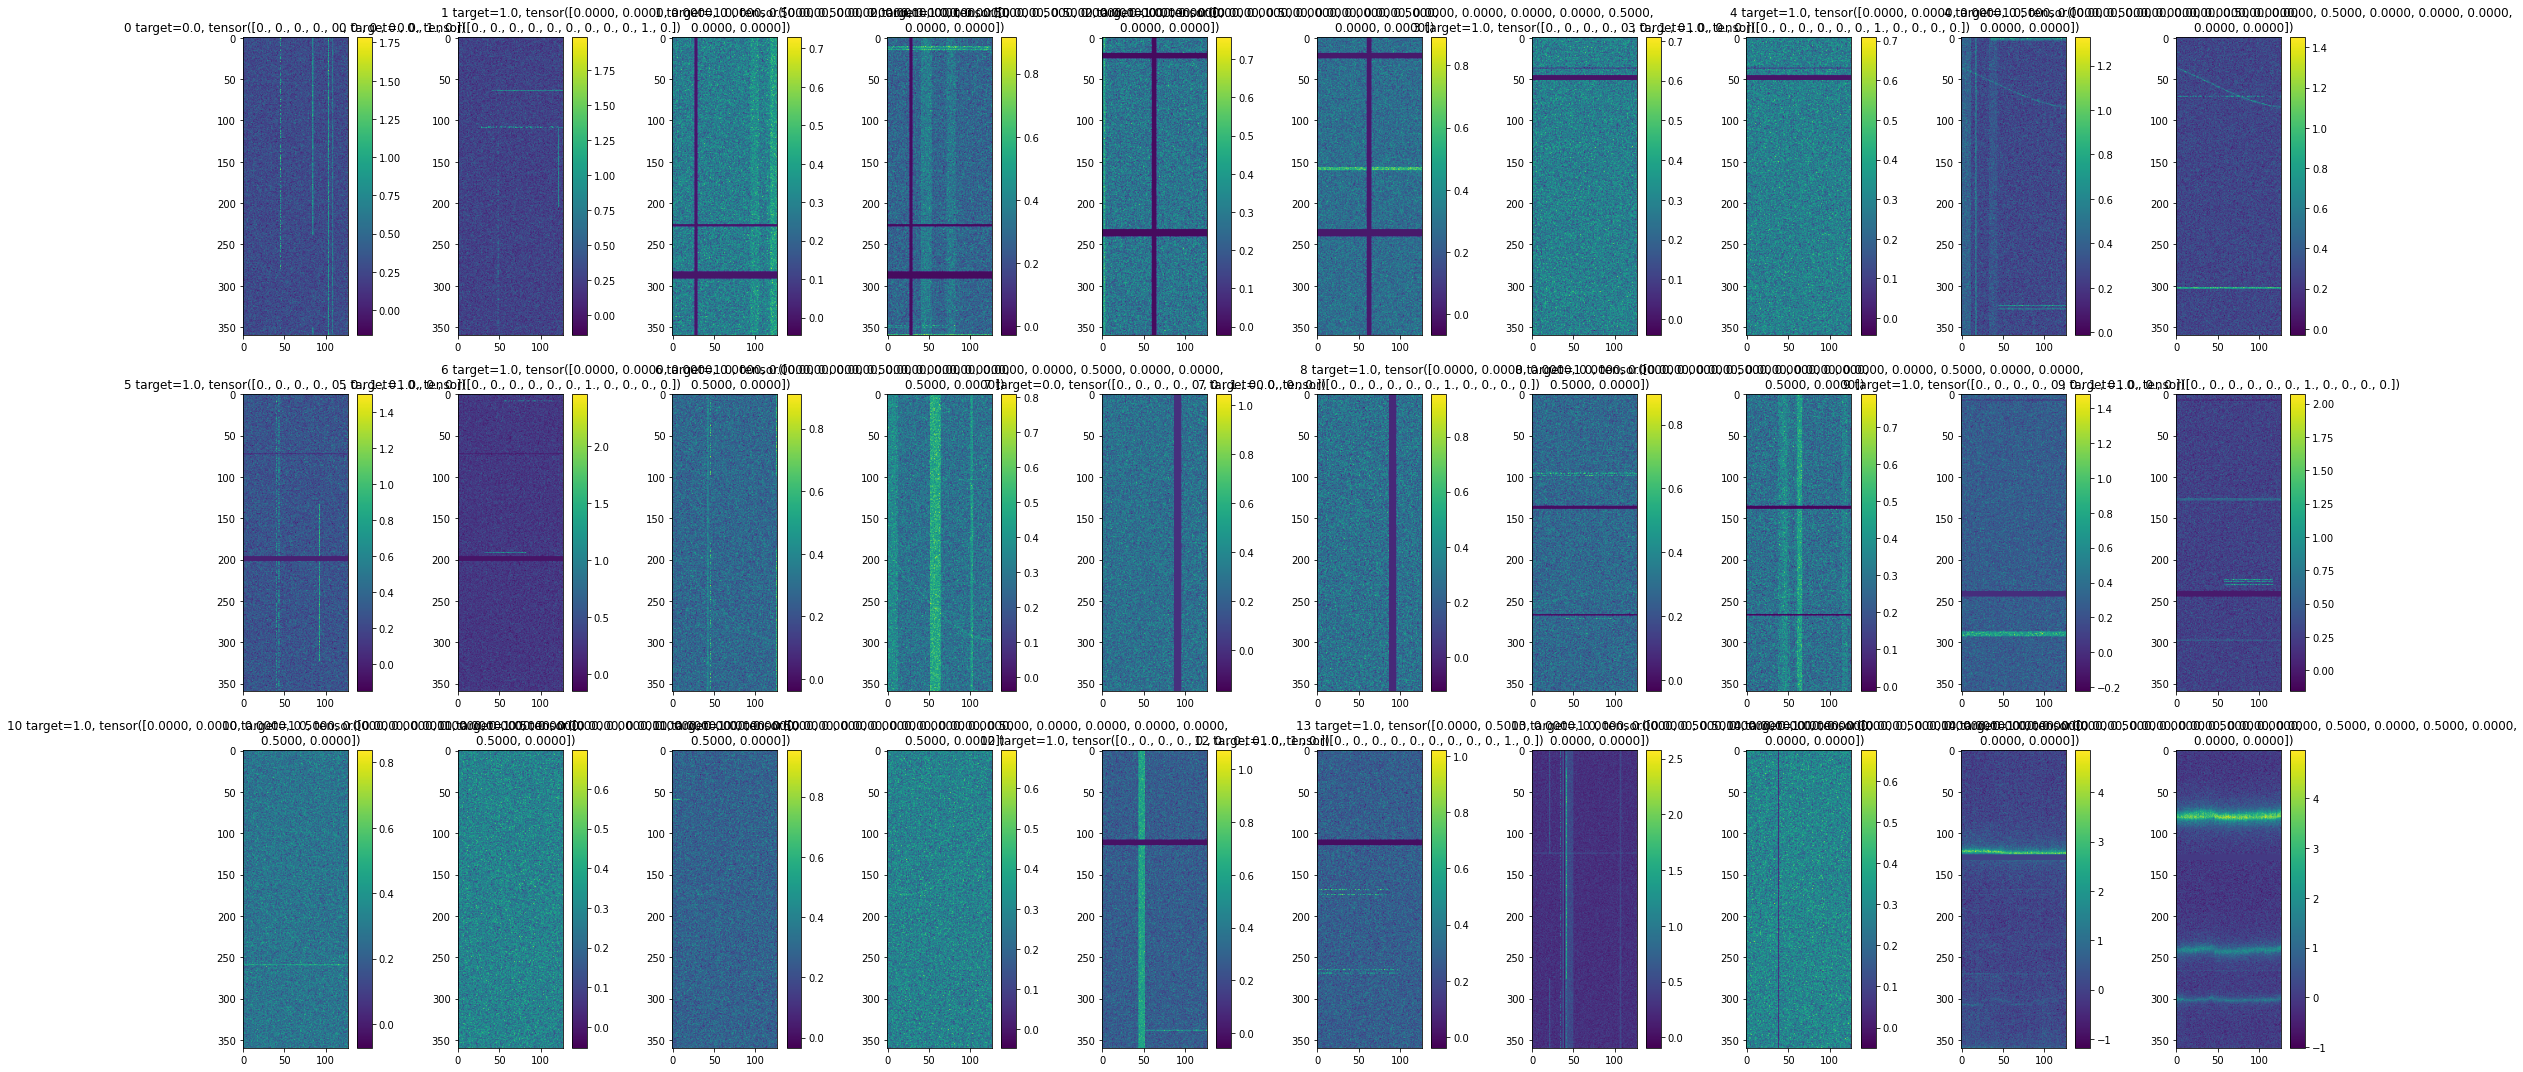

In [38]:
#%%time
# timeでファイルioに時間かかるか確認
if CFG.is_train_zip_dataset:
    train_dataset = ZipDataset(
        path=f"{zip_path}/archive", mod=zip_mod, transforms=get_transforms(data="train")
    )
else:
    train_dataset = TrainDataset(
        train_df,
        #pd.concat([train_df, add_df_all]),
        transforms=get_transforms(data="train"),
        #transforms=get_transforms(data="train_norm"),
        is_npy=CFG.is_npy,
        is_add_ch=CFG.is_add_ch,
        prob_spec_start_random=CFG.prob_spec_start_random,
        prob_sample_mixup=CFG.prob_sample_mixup,
        prob_add_sample_nega_mixup=CFG.prob_add_sample_nega_mixup,
        prob_mean_mixup=CFG.prob_mean_mixup,
        prob_noise_band=CFG.prob_noise_band,
        prob_noise_spot=CFG.prob_noise_spot,
        prob_noise_vline=CFG.prob_noise_vline,
        prob_noise_hband=CFG.prob_noise_hband,
        prob_swap_ch_nega=CFG.prob_swap_ch_nega,
        prob_flip_nega=CFG.prob_flip_nega,
        prob_swap_nega=CFG.prob_swap_nega,
        prob_vshift_nega=CFG.prob_vshift_nega,
        prob_vshift=CFG.prob_vshift,
        time_mask_num=CFG.time_mask_num,
        freq_mask_num=CFG.freq_mask_num,
    )
    #train_dataset = TrainDataset(
    #    #train_df,
    #    pd.concat([train_df, add_df_all]),
    #    transforms=get_transforms(data="train"),
    #    is_npy=CFG.is_npy,
    #    #is_add_ch=True,
    #    #prob_spec_start_random=1.0,
    #    prob_add_sample_nega_mixup=1.0,
    #    prob_sample_mixup=1.0,
    #    prob_mean_mixup=1.0,
    #    prob_noise_band=1.0,
    #    prob_noise_spot=1.0,
    #    prob_noise_vline=1.0,
    #    prob_noise_hband=1.0,
    #    #prob_swap_ch_nega=1.0,
    #    #prob_flip_nega=1.0,
    #    #prob_swap_nega=1.0,
    #    #prob_vshift_nega=1.0,
    #    #prob_vshift=1.0,
    #    #time_mask_num=5,
    #    #freq_mask_num=5,
    #)
train_loader = DataLoader(
    train_dataset,
    batch_size=15,
    shuffle=True,
    num_workers=0, pin_memory=True, drop_last=True,
    #collate_fn=mixup_collate_fn,
)
for step, (images, labels, labels_freq) in enumerate(train_loader):
    print(images.shape, labels.shape, labels_freq.shape)
    
    if normalize_type == "largekernel":
        plt.figure(figsize=(30,25))
    else:
        plt.figure(figsize=(30,15))
    i = 1
    for idx, (im, la, la_f) in enumerate(zip(images, labels, labels_freq)):
        #print(la_f.shape)
        #print(la_f.squeeze().shape)
        im = im.transpose(0, 1).transpose(1, 2)  # (H,W,C)
        
        if normalize_type == "largekernel":
            plt.subplot(5*3, 2, i)
        else:
            plt.subplot(3, 5*2, i)
        plt.imshow(im[:,:,0])
        plt.colorbar()
        #plt.colorbar(orientation='horizontal')
        plt.title(f"{idx} target={round(float(la.numpy()), 3)}, {la_f.squeeze()}", fontsize=12)
        i += 1
        
        if normalize_type == "largekernel":
            plt.subplot(5*3, 2, i)
        else:
            plt.subplot(3, 5*2, i)
        plt.imshow(im[:,:,1])
        plt.colorbar()
        #plt.colorbar(orientation='horizontal')
        plt.title(f"{idx} target={round(float(la.numpy()), 3)}, {la_f.squeeze()}", fontsize=12)
        i += 1
        
        if i > 30:
            break
            
    plt.tight_layout()
    plt.show()
    break

In [39]:
#%debug

In [40]:
#=====

# Model

In [41]:
class CustomModel(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                     num_classes=CFG.num_classes, 
                                     in_chans=CFG.ch)        
    def forward(self, x, labels=None):
        return self.net(x)[:,0]

#print(CFG.model_name)
#m = CustomModel(pretrained=CFG.pretrained).cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#o = m(x.cuda())
#print(o, o.shape)
##m

In [42]:
# https://www.kaggle.com/code/hirune924/2ndplace-solution/notebook を参考にdropout入れて過学習避ける
class CustomModelDrop(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                     num_classes=CFG.num_classes, 
                                     in_chans=CFG.ch, 
                                     drop_rate=CFG.drop_rate,  # headのドロップアウト率 (デフォルト: 0)
                                     drop_path_rate=CFG.drop_path_rate  # 中間層のドロップアウト率 (デフォルト: 0)
                                    )        
    def forward(self, x, labels=None):
        return self.net(x)[:,0]

#print(CFG.model_name)
#m = CustomModelDrop(pretrained=CFG.pretrained).cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#o = m(x.cuda())
#print(o, o.shape)
##m

In [43]:
class CustomModelMultiOutput(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                     num_classes=0, 
                                     in_chans=CFG.ch)   
        self.head1 = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features, CFG.num_classes)
        )
        self.head2 = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features, (500 // CFG.freq_div_n) - (40 // CFG.freq_div_n) + 1)  # 40-500Hz // CFG.freq_div_n
        )
    def forward(self, x, labels=None):
        feat = self.net(x)
        y1 = self.head1(feat)
        y2 = self.head2(feat)
        return y1[:,0], y2

#print(CFG.model_name)
#m = CustomModelMultiOutput(pretrained=CFG.pretrained).cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#o1, o2 = m(x.cuda())
#print(o1, o1.shape)
#print(o2, o2.shape)
##m

In [44]:
class CustomModelMultiOutputDrop(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                     num_classes=0, 
                                     in_chans=CFG.ch,
                                     drop_rate=CFG.drop_rate,  # headのドロップアウト率 (デフォルト: 0)
                                     drop_path_rate=CFG.drop_path_rate  # 中間層のドロップアウト率 (デフォルト: 0)
                                    )   
        self.head1 = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features, CFG.num_classes)
        )
        self.head2 = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features, (500 // CFG.freq_div_n) - (40 // CFG.freq_div_n) + 1)  # 40-500Hz // CFG.freq_div_n
        )
    def forward(self, x, labels=None):
        feat = self.net(x)
        y1 = self.head1(feat)
        y2 = self.head2(feat)
        return y1[:,0], y2

#print(CFG.model_name)
#m = CustomModelMultiOutputDrop(pretrained=CFG.pretrained).cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#o1, o2 = m(x.cuda())
#print(o1, o1.shape)
#print(o2, o2.shape)
##m

In [45]:
from src import layer_edit
class CustomModelMultiOutputStride12(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                     num_classes=0, 
                                     in_chans=CFG.ch)
        
        # 最初の conv レイヤーのモデル ストライドをfirst_strideに変更
        self.net = layer_edit.patch_first_conv_stride(self.net, first_stride=(1,2))
        
        self.head1 = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features, CFG.num_classes)
        )
        self.head2 = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features, (500 // CFG.freq_div_n) - (40 // CFG.freq_div_n) + 1)  # 40-500Hz // cfg.freq_div_n
        )
    def forward(self, x, labels=None):
        feat = self.net(x)
        y1 = self.head1(feat)
        y2 = self.head2(feat)
        return y1[:,0], y2

In [46]:
#=====

In [47]:
class CustomModelAddEmb(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                     num_classes=0, 
                                     in_chans=CFG.ch)   
        self.head = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features+(500 // CFG.freq_div_n) - (40 // CFG.freq_div_n) + 1, CFG.num_classes)  # embを1次元増やす
        )
    def forward(self, x, add_x):
        feat = self.net(x)
        #print(feat.shape, add_x.shape)
        y = self.head( torch.cat((feat, add_x), 1) )
        return y[:,0]

#print(CFG.model_name)
#m = CustomModelAddEmb(pretrained=CFG.pretrained).cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#add_x = torch.rand(CFG.batch_size, (500 // CFG.freq_div_n) - (40 // CFG.freq_div_n) + 1)
#o = m(x.cuda(), add_x.cuda())
#print(o, o.shape)
##m

In [48]:
#=====

In [49]:
class CustomModelMultiInput(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net1 = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                      num_classes=0, 
                                      in_chans=CFG.ch//2) 
        self.net2 = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                      num_classes=0, 
                                      in_chans=CFG.ch//2)
        self.head = nn.Sequential(
            nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net1.num_features + self.net2.num_features, CFG.num_classes)
        )
        
    def forward(self, x, labels=None):
        
        x1 = x[:, :CFG.ch//2, :, :]
        x2 = x[:, CFG.ch//2:, :, :]
        #print(x1.shape, x2.shape)
        
        feat1 = self.net1(x1)
        feat2 = self.net2(x2)
        y = self.head( torch.cat((feat1, feat2), 1) )
        #print(feat1.shape, feat2.shape, y.shape)
        
        return y[:,0]

#print(CFG.model_name)
#m = CustomModelMultiInput(pretrained=CFG.pretrained).cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#o = m(x.cuda())
#print(o, o.shape)
##m

In [50]:
#=====

In [51]:
class CustomModelLargeKernel(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        if pretrained:
            pth = "/volume/kaggle/g2net2/kaggle_dl/g2net-detecting-continuous-gravitational-waves-v0/model_best.pth"
        else:
            pth = ""
        self.net = largekernel.get_model(
            model_name="tf_efficientnetv2_b0",
            path=pth,
            conv_in_chans=32
        )
        self.net.classifier = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features, CFG.num_classes)
        )
        
    def forward(self, x, labels=None):
        return self.net(x)[:,0]

#print(CFG.model_name)
#m = CustomModelLargeKernel().cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#o = m(x.cuda())
#print(o, o.shape)
##m

In [52]:
#=====

In [53]:
# https://github.com/sinpcw/kaggle-whale2/blob/master/models.py
def loadpth(pth: str, map_location=None) -> OrderedDict:
    """
    パラメータロードのヘルパー関数.
    DataParallel化したモデルは module.xxxx という形式で保存されるため読込み時にmodule.から始まる場合はそれを取除く.
    """
    ostate = torch.load(pth, map_location=map_location)['model']
    nstate = OrderedDict()
    for k, v in ostate.items():
        if k.startswith('module.'):
            nstate[k[len('module.'):]] = v
        else:
            nstate[k] = v
    return nstate

# Metric

In [54]:
def get_score(labels: np.ndarray, predictions: np.ndarray):
    # predictions が nan になったときの対策
    try:
        return roc_auc_score(labels, predictions)
    except:
        return 0.0

# Helper

In [55]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

In [56]:
def forward_step(step, losses, batch_size, model, criterion, images, labels, prob_mixup, optimizer, scaler, optimizer_step,
                 labels_freq, criterion2):  # for MultiOutput
    """
    SAMは2回forward必要だからforwardの処理（loss計算+backward）切り出す
    """
    # SAM 1st/2nd Path
    optimizer.step = optimizer_step
    
    # ===========================================
    # model forward for mixup
    # ===========================================
    if np.random.rand() > 1 - prob_mixup:
        x, y_mixs = mixup(images, labels.long(), CFG.mix_alpha)  # y_mixs=(target, shuffled_target, lambda)
        if CFG.apex:
            with autocast():
                outputs, outputs2 = model(x.float())  # for MultiOutput
                if CFG.is_mix_or:
                    y_mix_or = y_mixs[0] + y_mixs[1] - (y_mixs[0] * y_mixs[1])  # 元ラベルと混ぜるラベルどっちかが1なら1にする  https://www.kaggle.com/c/seti-breakthrough-listen/discussion/266397
                    loss = criterion(outputs, y_mix_or.float())
                else:
                    loss = criterion(outputs, y_mixs[0]) * y_mixs[2] + criterion(outputs, y_mixs[1]) * (1.0 - y_mixs[2])
        else:
            outputs, outputs2 = model(x.float())  # for MultiOutput
            if CFG.is_mix_or:
                y_mix_or = y_mixs[0] + y_mixs[1] - (y_mixs[0] * y_mixs[1])  # 元ラベルと混ぜるラベルどっちかが1なら1にする  https://www.kaggle.com/c/seti-breakthrough-listen/discussion/266397
                loss = criterion(outputs, y_mix_or.float())
            else:
                loss = criterion(outputs, y_mixs[0]) * y_mixs[2] + criterion(outputs, y_mixs[1]) * (1.0 - y_mixs[2])
    else:
        if CFG.apex:
            with autocast():
                outputs, outputs2 = model(images)  # 予測値の算出  for MultiOutput
                loss = criterion(outputs, labels)  # 目標値と予測値から目的関数の値を算出
        else:
            outputs, outputs2 = model(images)  # 予測値の算出  for MultiOutput
            loss = criterion(outputs, labels)  # 目標値と予測値から目的関数の値を算出
            
    loss2 = criterion2(outputs2, labels_freq.squeeze())  # for MultiOutput
    loss = (loss + loss2) / 2.0  # for MultiOutput
    
    # ===========================================
    # record loss
    # ===========================================
    losses.update(loss.item(), batch_size)  # loggerにloss保存
    if CFG.gradient_accumulation_steps > 1:
        loss = loss / CFG.gradient_accumulation_steps  # normalize loss to account for batch accumulation
    if CFG.apex:
        scaler.scale(loss).backward()  # 各パラメータの勾配を算出
    else:
        loss.backward()  # 誤差逆伝播して各パラメータの勾配を算出
    grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)  # 勾配クリッピング
    
    # ===========================================
    # optimizer step
    # ===========================================
    if (step + 1) % CFG.gradient_accumulation_steps == 0:
        if CFG.apex:
            scaler.step(optimizer)  # 勾配の情報を用いたパラメータの更新
            scaler.update()
        else:
            optimizer.step()  # 勾配の情報を用いたパラメータの更新
        optimizer.zero_grad()  # 勾配情報の初期化
        
    return optimizer, scaler, losses, grad_norm

In [57]:
def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device, 
             prob_mixup=False, mixup_fn=None,
             criterion2=None):  # for MultiOutput
    model.train()
    if CFG.apex:
        scaler = GradScaler()
    else:
        scaler = None
    losses = AverageMeter()
    
    start = end = time.time()
    
    for step, (images, labels, labels_freq) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        #print(images.max())
        
        labels_freq = labels_freq.to(device)  # for MultiOutput
        
        ## ===========================================
        ## timm mixup/cutmix
        ## ===========================================
        #if mixup_fn is not None:
        #    images, labels = mixup_fn(images, labels)
        #else:
        #    labels = one_hot(labels, CFG.num_classes, device=device)
        
        if isinstance(optimizer, SAM) or isinstance(optimizer, ASAM):
            optimizer, scaler, _, _ = forward_step(step, losses, batch_size, model, criterion, images, labels, 
                                                   prob_mixup, optimizer, scaler, 
                                                   optimizer.first_step,
                                                   labels_freq, criterion2)  # for MultiOutput
            optimizer, scaler, losses, grad_norm = forward_step(step, losses, batch_size, model, criterion, images, labels, 
                                                                prob_mixup, optimizer, scaler, 
                                                                optimizer.second_step,
                                                                labels_freq, criterion2)  # for MultiOutput
        else:
            optimizer, scaler, losses, grad_norm = forward_step(step, losses, batch_size, model, criterion, images, labels, 
                                                                prob_mixup, optimizer, scaler, 
                                                                optimizer.step,
                                                                labels_freq, criterion2)  # for MultiOutput
            
        end = time.time()
        
        # ===========================================
        # logging
        # ===========================================
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.4e}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=optimizer.param_groups[0]["lr"]))
        
        if CFG.is_save_per_steps:
            torch.save(
                {
                    "model": model.state_dict(),
                    "optimizer": optimizer.state_dict(),
                    "scheduler": scheduler.state_dict(),
                },
                OUTPUT_DIR + "/per_steps.pth",
            )

    torch.cuda.empty_cache()
    gc.collect()
    
    return losses.avg

In [58]:
@torch.inference_mode()  # pytorch >= 1.9
def valid_fn(valid_loader, model, criterion, device, 
             criterion2):  # for MultiOutput
    model.eval()
    losses = AverageMeter()
    preds = []
    
    start = end = time.time()
    
    for step, (images, labels, labels_freq) in enumerate(valid_loader):  # for MultiOutput
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        #print(images.max())
        
        labels_freq = labels_freq.to(device)  # for MultiOutput
        
        # ===========================================
        # compute loss
        # ===========================================
        with torch.no_grad():
            # for MultiOutput
            outputs, outputs2 = model(images)  # logit
        loss = criterion(outputs, labels)
        loss2 = criterion2(outputs2, labels_freq.squeeze())  # for MultiOutput
        loss = (loss + loss2) / 2.0  # for MultiOutput
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        
        ## ===========================================
        ## record topk index
        ## ===========================================
        #_, tk = torch.topk(outputs, 5, dim=1)
        #topk_indexs = tk.to('cpu').detach().numpy()
        #preds.append(topk_indexs[:,0])  # top1
        # for BCE
        preds.append(outputs.sigmoid().cpu().detach().numpy())
        
        end = time.time()
        
        # ===========================================
        # logging
        # ===========================================
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
            
    predictions = np.concatenate(preds)
    
    # 推論うまくいかず欠損になったのは0にする
    predictions = np.nan_to_num(predictions, nan=0)
    
    torch.cuda.empty_cache()
    gc.collect()
    
    return losses.avg, predictions

# Train loop

In [59]:
def train_loop(folds, fold, seed):
    
    LOGGER.info(f"========== fold: {fold}, seed: {seed} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index
    
    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)
    valid_labels = valid_folds[CFG.target_col].values
    
    if CFG.is_train_zip_dataset:
        train_dataset = ZipDataset(path=f'{zip_path}/archive', mod=zip_mod, transforms=get_transforms(data='train'))
        valid_dataset = TrainDataset(valid_folds, is_npy=False, transforms=get_transforms(data='valid'))
    else:
        if (CFG.alb_norm_mean_th > 0) or (CFG.alb_norm_std_th > 0):
            train_transforms_type = 'train_norm'
            valid_transforms_type = 'valid_norm'
        else:
            train_transforms_type = 'train'
            valid_transforms_type = 'valid'
        train_dataset = TrainDataset(train_folds, 
                                     transforms=get_transforms(data=train_transforms_type), 
                                     is_npy=CFG.is_npy,
                                     is_add_ch=CFG.is_add_ch,
                                     prob_spec_start_random=CFG.prob_spec_start_random,
                                     prob_sample_mixup=CFG.prob_sample_mixup,
                                     prob_add_sample_nega_mixup=CFG.prob_add_sample_nega_mixup,
                                     prob_mean_mixup=CFG.prob_mean_mixup,
                                     prob_noise_band=CFG.prob_noise_band,
                                     prob_noise_spot=CFG.prob_noise_spot,
                                     prob_noise_vline=CFG.prob_noise_vline,
                                     prob_noise_hband=CFG.prob_noise_hband,
                                     prob_swap_ch_nega=CFG.prob_swap_ch_nega,
                                     prob_flip_nega=CFG.prob_flip_nega,
                                     prob_swap_nega=CFG.prob_swap_nega,
                                     prob_vshift_nega=CFG.prob_vshift_nega,
                                     prob_vshift=CFG.prob_vshift,
                                     time_mask_num=CFG.time_mask_num,
                                     freq_mask_num=CFG.freq_mask_num,
                                    )
        valid_dataset = TrainDataset(valid_folds, 
                                     transforms=get_transforms(data=valid_transforms_type),
                                     is_npy=CFG.is_npy,
                                     is_add_ch=CFG.is_add_ch,
                                    )
    
    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size, 
                              shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size * 2, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
    # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineLRScheduler':
            # https://blog.shikoan.com/timm-cosine-lr-scheduler/
            scheduler = CosineLRScheduler(optimizer, t_initial=CFG.epochs, lr_min=CFG.min_lr, 
                                          warmup_t=CFG.warmup_t, warmup_lr_init=CFG.warmup_lr_init, warmup_prefix=True)
        elif CFG.scheduler=='CosineLRScheduler_cycle_limit3':
            _cycle_limit = 3
            # https://timm.fast.ai/SGDR#cycle_limit=2
            scheduler = CosineLRScheduler(optimizer, t_initial=CFG.epochs//_cycle_limit, lr_min=CFG.min_lr, 
                                          warmup_t=CFG.warmup_t, warmup_lr_init=CFG.warmup_lr_init, warmup_prefix=True,
                                          cycle_limit=_cycle_limit,
                                         )
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = eval(CFG.model_cls)(pretrained=CFG.pretrained)
    
    if os.path.exists(CFG.load_model_path):
        LOGGER.info("=> loading checkpoint '{}'".format(CFG.load_model_path))
        states = torch.load(CFG.load_model_path, map_location=torch.device("cpu"))
        if len(CFG.device_ids) > 1:
            model.load_state_dict( loadpth(CFG.load_model_path, map_location=torch.device("cpu")) )
        else:
            model.load_state_dict(states["model"])
    
    if len(CFG.device_ids) > 1:
        if CFG.is_syncBN:
            # https://blog.shikoan.com/sync-batch-norm-pytorch/
            model = convert_model(model).to(device) # Batch NormをSync Batch Normに変換
            model = DataParallelWithCallback(model, device_ids=CFG.device_ids) # Data Parallel
            LOGGER.info(f"=> train Data Parallel {CFG.device_ids} use SyncBN")
        else:
            model.to(device)
            model = nn.DataParallel(model, device_ids=CFG.device_ids)  # Data Parallel
            LOGGER.info(f"=> train Data Parallel {CFG.device_ids}")
        # https://aru47.hatenablog.com/entry/2020/11/06/225052
        cudnn.benchmark = True
    else:
        model.to(device)

    if CFG.optimizer == "adam":
        optimizer = Adam(model.parameters(), lr=CFG.lr, amsgrad=False, weight_decay=CFG.weight_decay)
    elif CFG.optimizer == "adamw":
        optimizer = AdamW(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
    elif CFG.optimizer == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
    elif CFG.optimizer == 'momentum':
        optimizer = optim.SGD(model.parameters(), lr=CFG.lr, momentum=0.9, weight_decay=CFG.weight_decay)
    elif CFG.optimizer == 'nesterov':
        optimizer = optim.SGD(model.parameters(), lr=CFG.lr, momentum=0.9, weight_decay=CFG.weight_decay, nesterov=True)
    elif CFG.optimizer == 'sam':
        optimizer = SAM(model.parameters(), torch.optim.AdamW, lr=CFG.lr, weight_decay=CFG.weight_decay, rho=0.05)
        
    scheduler = get_scheduler(optimizer)
    
    if os.path.exists(CFG.load_model_path):
        if CFG.is_load_opt:
            LOGGER.info("=> loading optimizer and scheduler")
            optimizer.load_state_dict(states["optimizer"])
            scheduler.load_state_dict(states["scheduler"])

    if CFG.is_wandb:
        # wandbでpytorchのモデル監視
        wandb.watch(model)
            
    # ====================================================
    # loop
    # ====================================================
    train_criterion = eval(CFG.loss)().to(device)
    valid_criterion = eval(CFG.loss)().to(device)
    # for MultiOutput
    train_criterion2 = nn.CrossEntropyLoss().to(device)
    valid_criterion2 = nn.CrossEntropyLoss().to(device)
    
    best_score = -np.inf
    best_loss = np.inf
    
    #mixup_fn = Mixup(**CFG.mixup_args)
    mixup_fn = None
    prob_mixup = CFG.prob_mixup
    
    for epoch in range(CFG.epochs):
        
        # mixup_off_epoch以上はmixup/cutmixなしにする
        if epoch >= CFG.mixup_off_epoch:
            mixup_fn = None
            prob_mixup = 0.0
            #LOGGER.info(f'Epoch {epoch+1} - mixup_fn=None')
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(fold, train_loader, model, train_criterion, optimizer, epoch, scheduler, device, 
                            prob_mixup=prob_mixup,
                            criterion2=train_criterion2)  # for MultiOutput

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, valid_criterion, device,
                                       valid_criterion2)  # for MultiOutput
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()
        elif isinstance(scheduler, CosineLRScheduler):
            # https://blog.shikoan.com/timm-cosine-lr-scheduler/
            scheduler.step(epoch+1)
            
        # scoring
        score = get_score(valid_labels, preds)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        LOGGER.info(f'Epoch {epoch+1} - lr: {optimizer.param_groups[0]["lr"]:.4e}')
       
        if CFG.is_wandb:
            # save log wandb
            wandb.log({f"[fold{fold}] epoch": epoch+1,
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score,
                       f"[fold{fold}] lr": optimizer.param_groups[0]["lr"]})
        
        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            best_pth = OUTPUT_DIR + f'/{CFG.name}_fold{fold}_seed{seed}_best_score.pth'
            torch.save({'model': model.state_dict(),
                        "optimizer": optimizer.state_dict(),
                        "scheduler": scheduler.state_dict(),
                        'preds': preds},
                        best_pth)
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            LOGGER.info(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
            best_pth = OUTPUT_DIR + f'/{CFG.name}_fold{fold}_seed{seed}_best_loss.pth'
            torch.save({'model': model.state_dict(),
                        "optimizer": optimizer.state_dict(),
                        "scheduler": scheduler.state_dict(),
                        'preds': preds},
                        best_pth)
            
    valid_folds['preds'] = torch.load(OUTPUT_DIR + f'/{CFG.name}_fold{fold}_seed{seed}_best_score.pth', map_location=torch.device('cpu'))['preds'].tolist()
    #valid_folds['preds'] = torch.load(OUTPUT_DIR + f'/{CFG.name}_fold{fold}_seed{seed}_best_loss.pth', map_location=torch.device('cpu'))['preds'].tolist()

    return valid_folds

# Main

In [60]:
def get_result(result_df, preds_col="preds", add_info=""):
    labels = result_df[CFG.target_col].values
    preds = result_df[preds_col].values
    preds = np.array([np.array(p) for p in preds])
    score = get_score(labels, preds)
    LOGGER.info(f'{add_info}Score: {score:<.4f}')
    return score
    

def main(df):
    if CFG.train:
        oof_scores = []
        for seed in CFG.seeds:
            seed_torch(seed)
            
            # 生成データロード
            if ADD_DIRS_STR != "":
                add_df = pd.read_csv(f"{OUTPUT_DIR}/add_data.csv")
                if CFG.debug:
                    add_df = cv_split_kfold(add_df, 0, 10)
                    add_df = add_df[add_df["fold"] == 0].reset_index(drop=True)
                LOGGER.info(f"add_df.shape: {str(add_df.shape)}")

                # cv_split
                if CFG.add_split_str == "":
                    folds = pd.concat([df, add_df], ignore_index=True)
                    folds = cv_split(folds, seed, CFG.n_fold, cv_col=CFG.cv_col)  # StratifiedKFold
                else:
                    # オリジナルデータと生成データは別の切り方でfold分ける
                    if CFG.add_split_str == "KFold":
                        add_df = cv_split_kfold(add_df, seed, CFG.n_fold)
                    else:
                        add_df = cv_split(add_df, seed, CFG.n_fold, cv_col=CFG.cv_col)  # StratifiedKFold

                    folds = cv_split(df, seed, CFG.n_fold, cv_col=CFG.cv_col)  # StratifiedKFold
                    folds = pd.concat([folds, add_df], ignore_index=True) 
                    
                # 生成データのtarget=1はすべてtrainに使う
                if IS_ADD_ALL_TRAIN1:
                    _orig_folds = folds.dropna(subset=['freq_min//10_target'])
                    _add_folds = folds.dropna(subset=['type'])
                    _add_target0 = _add_folds[_add_folds[CFG.target_col] == 0]
                    _add_target1 = _add_folds[_add_folds[CFG.target_col] == 1]
                    _add_target1["fold"] = -1    
                    folds = pd.concat([_orig_folds, _add_target0, _add_target1]).reset_index(drop=True)
                    print(folds.groupby(['fold', CFG.target_col]).size())

            else:
                folds = cv_split(df, seed, CFG.n_fold, cv_col=CFG.cv_col)  # StratifiedKFold
                
            # zip_df.csvでfinetuneする場合
            if CFG.is_train_zip_dataset:
                folds = pd.read_csv(f'{zip_path}/zip_df.csv')                
                df["fold"] = 0
                folds = pd.concat([folds, df], ignore_index=True)
                
            # 疑似ラベル全foldのtrainに入れる
            if PSEUDO_CSV != "":
                pseudo_df = pd.read_csv(f"{OUTPUT_DIR}/pseudo_df.csv")
                if CFG.debug:
                    pseudo_df = cv_split_kfold(pseudo_df, 0, 30)
                    pseudo_df = pseudo_df[pseudo_df["fold"] == 0].reset_index(drop=True)
                LOGGER.info(f"pseudo_df.shape: {str(pseudo_df.shape)}")
                pseudo_df["fold"] = -1
                folds = pd.concat([folds, pseudo_df], ignore_index=True)
            if ADD_PSEUDO_DIRS != "":
                add_pseudo_df = pd.read_csv(f"{OUTPUT_DIR}/add_pseudo_df.csv")
                if CFG.debug:
                    add_pseudo_df = cv_split_kfold(add_pseudo_df, 0, 30)
                    add_pseudo_df = add_pseudo_df[add_pseudo_df["fold"] == 0].reset_index(drop=True)
                LOGGER.info(f"add_pseudo_df.shape: {str(add_pseudo_df.shape)}")
                add_pseudo_df["fold"] = -1
                folds = pd.concat([folds, add_pseudo_df], ignore_index=True)
                
            folds.to_csv(OUTPUT_DIR +f"/folds_seed{seed}.csv", index=False)
            LOGGER.info(f"folds.shape: {str(folds.shape)}")
            
            # train fold
            scores = []
            oof_df = pd.DataFrame()
            for fold in range(CFG.n_fold):
                if fold in CFG.trn_fold:
                    _oof_df = train_loop(folds, fold, seed)
                    oof_df = pd.concat([oof_df, _oof_df])
                    LOGGER.info(f"========== fold: {fold} seed: {seed} result ==========")
                    _score = get_result(_oof_df, add_info=f"fold{fold} ")
                    scores.append(_score)
                    
                    gc.collect()
                    torch.cuda.empty_cache()
                    
            # CV result
            LOGGER.info(f"========== CV ==========")
            LOGGER.info(f'macro mean folds Score ± std: {np.mean(scores):<.4f} ± {np.std(scores):<.4f}')
            oof_score = get_result(oof_df, add_info=f"oof ")
            oof_scores.append(oof_score)
            # save result
            oof_df.to_csv(OUTPUT_DIR + f'/{CFG.name}_oof_df_seed{seed}.csv', index=False)
            
            if CFG.is_wandb:
                # save log wandb
                wandb.log({f"[fold{str(CFG.trn_fold)}] best_score": oof_score})
            
            plt.hist(oof_df["preds"], bins=100)
            plt.show()
            plt.clf()  # メモリ解放
            plt.close()
            
        if len(oof_scores) > 1:
            LOGGER.info(f'seed macro mean oof Score ± std: {np.mean(oof_scores):<.4f} ± {np.std(oof_scores):<.4f}') 

add_df.shape: (9196, 24)
pseudo_df.shape: (7327, 32)


> SEEDING DONE
fold0: (1840,)
fold1: (1839,)
fold2: (1839,)
fold3: (1839,)
fold4: (1839,)
fold  target
0     0         1040
      1          800
1     0         1039
      1          800
2     0         1039
      1          800
3     0         1039
      1          800
4     0         1039
      1          800
dtype: int64
fold0: (120,)
fold1: (120,)
fold2: (120,)
fold3: (120,)
fold4: (120,)
fold  target
0     0         40
      1         80
1     0         40
      1         80
2     0         40
      1         80
3     0         40
      1         80
4     0         40
      1         80
dtype: int64


folds.shape: (17123, 40)
========== fold: 0, seed: 0 training ==========


train_norm
valid_norm
Epoch: [1][0/236] Elapsed 0m 4s (remain 15m 57s) Loss: 1.5401(1.5401) Grad: 44972.5977  LR: 4.0000e-06  
Epoch: [1][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.5202(1.5345) Grad: 48177.0664  LR: 4.0000e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 19s) Loss: 1.5495(1.5495) 


Epoch 1 - avg_train_loss: 1.5345  avg_val_loss: 1.5445  time: 115s
Epoch 1 - Score: 0.6889
Epoch 1 - lr: 1.3600e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.5359(1.5445) 


Epoch 1 - Save Best Score: 0.6889 Model
Epoch 1 - Save Best Loss: 1.5445 Model


Epoch: [2][0/236] Elapsed 0m 2s (remain 10m 25s) Loss: 1.5324(1.5324) Grad: 49708.7461  LR: 1.3600e-04  
Epoch: [2][235/236] Elapsed 1m 49s (remain 0m 0s) Loss: 1.3806(1.4015) Grad: 56480.2539  LR: 1.3600e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3329(1.3329) 


Epoch 2 - avg_train_loss: 1.4015  avg_val_loss: 1.3101  time: 115s
Epoch 2 - Score: 0.8189
Epoch 2 - lr: 2.6800e-04
Epoch 2 - Save Best Score: 0.8189 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2057(1.3101) 


Epoch 2 - Save Best Loss: 1.3101 Model


Epoch: [3][0/236] Elapsed 0m 2s (remain 8m 17s) Loss: 1.3840(1.3840) Grad: 45092.2188  LR: 2.6800e-04  
Epoch: [3][235/236] Elapsed 1m 49s (remain 0m 0s) Loss: 1.4200(1.3679) Grad: 54983.3203  LR: 2.6800e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3052(1.3052) 


Epoch 3 - avg_train_loss: 1.3679  avg_val_loss: 1.2874  time: 116s
Epoch 3 - Score: 0.8295
Epoch 3 - lr: 4.0000e-04
Epoch 3 - Save Best Score: 0.8295 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1949(1.2874) 


Epoch 3 - Save Best Loss: 1.2874 Model


Epoch: [4][0/236] Elapsed 0m 2s (remain 11m 0s) Loss: 1.3650(1.3650) Grad: 40854.8477  LR: 4.0000e-04  
Epoch: [4][235/236] Elapsed 1m 49s (remain 0m 0s) Loss: 1.3355(1.3587) Grad: 24035.3789  LR: 4.0000e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2705(1.2705) 


Epoch 4 - avg_train_loss: 1.3587  avg_val_loss: 1.2805  time: 115s
Epoch 4 - Score: 0.8480
Epoch 4 - lr: 3.9990e-04
Epoch 4 - Save Best Score: 0.8480 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2272(1.2805) 


Epoch 4 - Save Best Loss: 1.2805 Model


Epoch: [5][0/236] Elapsed 0m 2s (remain 10m 22s) Loss: 1.3337(1.3337) Grad: 27356.3887  LR: 3.9990e-04  
Epoch: [5][235/236] Elapsed 1m 49s (remain 0m 0s) Loss: 1.3584(1.3497) Grad: 24209.6211  LR: 3.9990e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3051(1.3051) 


Epoch 5 - avg_train_loss: 1.3497  avg_val_loss: 1.3007  time: 115s
Epoch 5 - Score: 0.8418
Epoch 5 - lr: 3.9961e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1732(1.3007) 
Epoch: [6][0/236] Elapsed 0m 2s (remain 9m 33s) Loss: 1.3430(1.3430) Grad: 26874.2207  LR: 3.9961e-04  
Epoch: [6][235/236] Elapsed 1m 49s (remain 0m 0s) Loss: 1.3252(1.3410) Grad: 26041.1191  LR: 3.9961e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2162(1.2162) 


Epoch 6 - avg_train_loss: 1.3410  avg_val_loss: 1.2613  time: 115s
Epoch 6 - Score: 0.8516
Epoch 6 - lr: 3.9912e-04
Epoch 6 - Save Best Score: 0.8516 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1659(1.2613) 


Epoch 6 - Save Best Loss: 1.2613 Model


Epoch: [7][0/236] Elapsed 0m 2s (remain 9m 4s) Loss: 1.3471(1.3471) Grad: 34965.6875  LR: 3.9912e-04  
Epoch: [7][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.3730(1.3362) Grad: 24922.4316  LR: 3.9912e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2406(1.2406) 


Epoch 7 - avg_train_loss: 1.3362  avg_val_loss: 1.2627  time: 114s
Epoch 7 - Score: 0.8567
Epoch 7 - lr: 3.9844e-04
Epoch 7 - Save Best Score: 0.8567 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1887(1.2627) 
Epoch: [8][0/236] Elapsed 0m 2s (remain 11m 1s) Loss: 1.3676(1.3676) Grad: 21682.8457  LR: 3.9844e-04  
Epoch: [8][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.3164(1.3316) Grad: 21165.8516  LR: 3.9844e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2185(1.2185) 


Epoch 8 - avg_train_loss: 1.3316  avg_val_loss: 1.2512  time: 115s
Epoch 8 - Score: 0.8530
Epoch 8 - lr: 3.9756e-04
Epoch 8 - Save Best Loss: 1.2512 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1782(1.2512) 
Epoch: [9][0/236] Elapsed 0m 2s (remain 9m 57s) Loss: 1.3132(1.3132) Grad: 21550.1094  LR: 3.9756e-04  
Epoch: [9][235/236] Elapsed 1m 50s (remain 0m 0s) Loss: 1.3405(1.3346) Grad: 20982.9004  LR: 3.9756e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2465(1.2465) 


Epoch 9 - avg_train_loss: 1.3346  avg_val_loss: 1.2537  time: 116s
Epoch 9 - Score: 0.8622
Epoch 9 - lr: 3.9649e-04
Epoch 9 - Save Best Score: 0.8622 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1639(1.2537) 
Epoch: [10][0/236] Elapsed 0m 2s (remain 9m 6s) Loss: 1.3376(1.3376) Grad: 21742.8828  LR: 3.9649e-04  
Epoch: [10][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.3009(1.3311) Grad: 26092.9336  LR: 3.9649e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2207(1.2207) 


Epoch 10 - avg_train_loss: 1.3311  avg_val_loss: 1.2319  time: 115s
Epoch 10 - Score: 0.8644
Epoch 10 - lr: 3.9523e-04
Epoch 10 - Save Best Score: 0.8644 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1693(1.2319) 


Epoch 10 - Save Best Loss: 1.2319 Model


Epoch: [11][0/236] Elapsed 0m 2s (remain 10m 50s) Loss: 1.3497(1.3497) Grad: 23979.0781  LR: 3.9523e-04  
Epoch: [11][235/236] Elapsed 1m 49s (remain 0m 0s) Loss: 1.2938(1.3281) Grad: 18501.4785  LR: 3.9523e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1855(1.1855) 


Epoch 11 - avg_train_loss: 1.3281  avg_val_loss: 1.2736  time: 116s
Epoch 11 - Score: 0.8670
Epoch 11 - lr: 3.9378e-04
Epoch 11 - Save Best Score: 0.8670 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1851(1.2736) 
Epoch: [12][0/236] Elapsed 0m 3s (remain 12m 3s) Loss: 1.3418(1.3418) Grad: 19636.8203  LR: 3.9378e-04  
Epoch: [12][235/236] Elapsed 1m 50s (remain 0m 0s) Loss: 1.3117(1.3247) Grad: 18345.6582  LR: 3.9378e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2781(1.2781) 


Epoch 12 - avg_train_loss: 1.3247  avg_val_loss: 1.2663  time: 116s
Epoch 12 - Score: 0.8656
Epoch 12 - lr: 3.9214e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1336(1.2663) 
Epoch: [13][0/236] Elapsed 0m 2s (remain 9m 2s) Loss: 1.3098(1.3098) Grad: 18022.3945  LR: 3.9214e-04  


wandb: Network error (ReadTimeout), entering retry loop.


Epoch: [13][235/236] Elapsed 1m 50s (remain 0m 0s) Loss: 1.3730(1.3270) Grad: 25235.0391  LR: 3.9214e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2690(1.2690) 


Epoch 13 - avg_train_loss: 1.3270  avg_val_loss: 1.2585  time: 116s
Epoch 13 - Score: 0.8573
Epoch 13 - lr: 3.9031e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1368(1.2585) 
Epoch: [14][0/236] Elapsed 0m 2s (remain 8m 53s) Loss: 1.3339(1.3339) Grad: 27693.4570  LR: 3.9031e-04  
Epoch: [14][235/236] Elapsed 1m 49s (remain 0m 0s) Loss: 1.3626(1.3227) Grad: 27759.6309  LR: 3.9031e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2277(1.2277) 


wandb: ERROR Error while calling W&B API: internal database error (<Response [500]>)
Epoch 14 - avg_train_loss: 1.3227  avg_val_loss: 1.2409  time: 115s
Epoch 14 - Score: 0.8603
Epoch 14 - lr: 3.8829e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1654(1.2409) 
Epoch: [15][0/236] Elapsed 0m 2s (remain 10m 9s) Loss: 1.2599(1.2599) Grad: 17629.6406  LR: 3.8829e-04  
Epoch: [15][235/236] Elapsed 1m 52s (remain 0m 0s) Loss: 1.3760(1.3225) Grad: 27396.1582  LR: 3.8829e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2765(1.2765) 
EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1623(1.2370) 


Epoch 15 - avg_train_loss: 1.3225  avg_val_loss: 1.2370  time: 118s
Epoch 15 - Score: 0.8590
Epoch 15 - lr: 3.8610e-04


Epoch: [16][0/236] Elapsed 0m 2s (remain 11m 10s) Loss: 1.3053(1.3053) Grad: 18992.4746  LR: 3.8610e-04  
Epoch: [16][235/236] Elapsed 3m 47s (remain 0m 0s) Loss: 1.3323(1.3185) Grad: 19599.7246  LR: 3.8610e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2330(1.2330) 


Epoch 16 - avg_train_loss: 1.3185  avg_val_loss: 1.2515  time: 233s
Epoch 16 - Score: 0.8595
Epoch 16 - lr: 3.8372e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1483(1.2515) 
Epoch: [17][0/236] Elapsed 0m 2s (remain 9m 33s) Loss: 1.3252(1.3252) Grad: 16956.4102  LR: 3.8372e-04  
Epoch: [17][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.2960(1.3214) Grad: 15025.0615  LR: 3.8372e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2967(1.2967) 
EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1406(1.2554) 


Epoch 17 - avg_train_loss: 1.3214  avg_val_loss: 1.2554  time: 115s
Epoch 17 - Score: 0.8638
Epoch 17 - lr: 3.8116e-04


Epoch: [18][0/236] Elapsed 0m 2s (remain 9m 4s) Loss: 1.3294(1.3294) Grad: 22368.8359  LR: 3.8116e-04  


wandb: Network error (ReadTimeout), entering retry loop.


Epoch: [18][235/236] Elapsed 1m 49s (remain 0m 0s) Loss: 1.2988(1.3163) Grad: 18958.3574  LR: 3.8116e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3081(1.3081) 


Epoch 18 - avg_train_loss: 1.3163  avg_val_loss: 1.2485  time: 115s
Epoch 18 - Score: 0.8606
Epoch 18 - lr: 3.7842e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1376(1.2485) 
Epoch: [19][0/236] Elapsed 0m 2s (remain 9m 3s) Loss: 1.2747(1.2747) Grad: 13710.4844  LR: 3.7842e-04  
Epoch: [19][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.3423(1.3178) Grad: 24258.0918  LR: 3.7842e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2610(1.2610) 


Epoch 19 - avg_train_loss: 1.3178  avg_val_loss: 1.2435  time: 115s
Epoch 19 - Score: 0.8562
Epoch 19 - lr: 3.7551e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1352(1.2435) 
Epoch: [20][0/236] Elapsed 0m 2s (remain 10m 12s) Loss: 1.3477(1.3477) Grad: 20992.7871  LR: 3.7551e-04  
Epoch: [20][235/236] Elapsed 1m 49s (remain 0m 0s) Loss: 1.2888(1.3153) Grad: 17339.3379  LR: 3.7551e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2432(1.2432) 


Epoch 20 - avg_train_loss: 1.3153  avg_val_loss: 1.2373  time: 115s
Epoch 20 - Score: 0.8698
Epoch 20 - lr: 3.7243e-04
Epoch 20 - Save Best Score: 0.8698 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1510(1.2373) 
Epoch: [21][0/236] Elapsed 0m 2s (remain 10m 6s) Loss: 1.2891(1.2891) Grad: 23774.0820  LR: 3.7243e-04  


wandb: Network error (ReadTimeout), entering retry loop.


Epoch: [21][235/236] Elapsed 3m 46s (remain 0m 0s) Loss: 1.3824(1.3172) Grad: 23702.0703  LR: 3.7243e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 17s) Loss: 1.2353(1.2353) 


Epoch 21 - avg_train_loss: 1.3172  avg_val_loss: 1.2327  time: 235s
Epoch 21 - Score: 0.8598
Epoch 21 - lr: 3.6918e-04


EVAL: [15/16] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1414(1.2327) 
Epoch: [22][0/236] Elapsed 0m 4s (remain 17m 48s) Loss: 1.3293(1.3293) Grad: 18314.1855  LR: 3.6918e-04  


wandb: Network error (ReadTimeout), entering retry loop.


Epoch: [22][235/236] Elapsed 6m 18s (remain 0m 0s) Loss: 1.3284(1.3125) Grad: 25044.8594  LR: 3.6918e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1918(1.1918) 


Epoch 22 - avg_train_loss: 1.3125  avg_val_loss: 1.2259  time: 384s
Epoch 22 - Score: 0.8624
Epoch 22 - lr: 3.6576e-04
Epoch 22 - Save Best Loss: 1.2259 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1667(1.2259) 
Epoch: [23][0/236] Elapsed 0m 2s (remain 10m 0s) Loss: 1.3322(1.3322) Grad: 21952.2891  LR: 3.6576e-04  
Epoch: [23][235/236] Elapsed 1m 49s (remain 0m 0s) Loss: 1.3537(1.3156) Grad: 21572.4766  LR: 3.6576e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1746(1.1746) 


Epoch 23 - avg_train_loss: 1.3156  avg_val_loss: 1.2367  time: 115s
Epoch 23 - Score: 0.8785
Epoch 23 - lr: 3.6219e-04
Epoch 23 - Save Best Score: 0.8785 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1681(1.2367) 
Epoch: [24][0/236] Elapsed 0m 2s (remain 9m 24s) Loss: 1.3354(1.3354) Grad: 29073.0254  LR: 3.6219e-04  
Epoch: [24][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.3711(1.3144) Grad: 25401.6074  LR: 3.6219e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2166(1.2166) 


Epoch 24 - avg_train_loss: 1.3144  avg_val_loss: 1.2281  time: 115s
Epoch 24 - Score: 0.8639
Epoch 24 - lr: 3.5845e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1525(1.2281) 
Epoch: [25][0/236] Elapsed 0m 2s (remain 8m 14s) Loss: 1.2773(1.2773) Grad: 19708.5020  LR: 3.5845e-04  
Epoch: [25][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.3285(1.3134) Grad: 23840.7441  LR: 3.5845e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2386(1.2386) 


Epoch 25 - avg_train_loss: 1.3134  avg_val_loss: 1.2184  time: 114s
Epoch 25 - Score: 0.8655
Epoch 25 - lr: 3.5456e-04
Epoch 25 - Save Best Loss: 1.2184 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1646(1.2184) 
Epoch: [26][0/236] Elapsed 0m 2s (remain 11m 7s) Loss: 1.3688(1.3688) Grad: 29762.0391  LR: 3.5456e-04  
Epoch: [26][235/236] Elapsed 1m 49s (remain 0m 0s) Loss: 1.2966(1.3130) Grad: 20661.0781  LR: 3.5456e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1852(1.1852) 


Epoch 26 - avg_train_loss: 1.3130  avg_val_loss: 1.2082  time: 115s
Epoch 26 - Score: 0.8621
Epoch 26 - lr: 3.5052e-04
Epoch 26 - Save Best Loss: 1.2082 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1586(1.2082) 
Epoch: [27][0/236] Elapsed 0m 2s (remain 9m 44s) Loss: 1.2875(1.2875) Grad: 20265.3379  LR: 3.5052e-04  
Epoch: [27][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.3280(1.3089) Grad: 25727.3848  LR: 3.5052e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.1855(1.1855) 


Epoch 27 - avg_train_loss: 1.3089  avg_val_loss: 1.2226  time: 114s
Epoch 27 - Score: 0.8585
Epoch 27 - lr: 3.4634e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1424(1.2226) 
Epoch: [28][0/236] Elapsed 0m 2s (remain 9m 22s) Loss: 1.3225(1.3225) Grad: 21578.3320  LR: 3.4634e-04  
Epoch: [28][235/236] Elapsed 1m 49s (remain 0m 0s) Loss: 1.2742(1.3091) Grad: 26167.8516  LR: 3.4634e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1980(1.1980) 


Epoch 28 - avg_train_loss: 1.3091  avg_val_loss: 1.2334  time: 115s
Epoch 28 - Score: 0.8789
Epoch 28 - lr: 3.4201e-04
Epoch 28 - Save Best Score: 0.8789 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1438(1.2334) 
Epoch: [29][0/236] Elapsed 0m 2s (remain 10m 59s) Loss: 1.3234(1.3234) Grad: 16444.5918  LR: 3.4201e-04  


wandb: ERROR Error while calling W&B API: internal database error (<Response [500]>)


Epoch: [29][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.3585(1.3097) Grad: 25049.6055  LR: 3.4201e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1839(1.1839) 


Epoch 29 - avg_train_loss: 1.3097  avg_val_loss: 1.2172  time: 115s
Epoch 29 - Score: 0.8698
Epoch 29 - lr: 3.3754e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1466(1.2172) 
Epoch: [30][0/236] Elapsed 0m 2s (remain 9m 56s) Loss: 1.3208(1.3208) Grad: 17866.7070  LR: 3.3754e-04  
Epoch: [30][235/236] Elapsed 1m 49s (remain 0m 0s) Loss: 1.2710(1.3106) Grad: 19126.6992  LR: 3.3754e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1975(1.1975) 


Epoch 30 - avg_train_loss: 1.3106  avg_val_loss: 1.2194  time: 115s
Epoch 30 - Score: 0.8644
Epoch 30 - lr: 3.3294e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1593(1.2194) 
Epoch: [31][0/236] Elapsed 0m 2s (remain 9m 54s) Loss: 1.3226(1.3226) Grad: 17882.4941  LR: 3.3294e-04  
Epoch: [31][235/236] Elapsed 1m 49s (remain 0m 0s) Loss: 1.3024(1.3081) Grad: 16020.7646  LR: 3.3294e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2183(1.2183) 


Epoch 31 - avg_train_loss: 1.3081  avg_val_loss: 1.2072  time: 115s
Epoch 31 - Score: 0.8651
Epoch 31 - lr: 3.2821e-04
Epoch 31 - Save Best Loss: 1.2072 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1377(1.2072) 
Epoch: [32][0/236] Elapsed 0m 2s (remain 9m 23s) Loss: 1.3367(1.3367) Grad: 20734.2090  LR: 3.2821e-04  
Epoch: [32][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.2856(1.3061) Grad: 17438.4727  LR: 3.2821e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2243(1.2243) 


Epoch 32 - avg_train_loss: 1.3061  avg_val_loss: 1.2132  time: 114s
Epoch 32 - Score: 0.8691
Epoch 32 - lr: 3.2336e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1355(1.2132) 
Epoch: [33][0/236] Elapsed 0m 2s (remain 9m 30s) Loss: 1.2909(1.2909) Grad: 17441.4707  LR: 3.2336e-04  
Epoch: [33][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.2654(1.3078) Grad: 15815.5049  LR: 3.2336e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2073(1.2073) 


Epoch 33 - avg_train_loss: 1.3078  avg_val_loss: 1.2255  time: 114s
Epoch 33 - Score: 0.8671
Epoch 33 - lr: 3.1838e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1448(1.2255) 
Epoch: [34][0/236] Elapsed 0m 2s (remain 10m 10s) Loss: 1.2794(1.2794) Grad: 13027.4062  LR: 3.1838e-04  
Epoch: [34][235/236] Elapsed 1m 49s (remain 0m 0s) Loss: 1.2909(1.3054) Grad: 21303.8359  LR: 3.1838e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2665(1.2665) 
EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1475(1.2316) 


Epoch 34 - avg_train_loss: 1.3054  avg_val_loss: 1.2316  time: 116s
Epoch 34 - Score: 0.8565
Epoch 34 - lr: 3.1329e-04


Epoch: [35][0/236] Elapsed 0m 2s (remain 9m 33s) Loss: 1.2893(1.2893) Grad: 16391.0723  LR: 3.1329e-04  


wandb: Network error (ReadTimeout), entering retry loop.


Epoch: [35][235/236] Elapsed 1m 49s (remain 0m 0s) Loss: 1.2553(1.3053) Grad: 20522.5293  LR: 3.1329e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1872(1.1872) 
EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1460(1.2096) 


Epoch 35 - avg_train_loss: 1.3053  avg_val_loss: 1.2096  time: 115s
Epoch 35 - Score: 0.8556
Epoch 35 - lr: 3.0809e-04


Epoch: [36][0/236] Elapsed 0m 2s (remain 10m 56s) Loss: 1.2386(1.2386) Grad: 14068.5469  LR: 3.0809e-04  
Epoch: [36][235/236] Elapsed 1m 49s (remain 0m 0s) Loss: 1.3147(1.3066) Grad: 19856.5332  LR: 3.0809e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1974(1.1974) 


Epoch 36 - avg_train_loss: 1.3066  avg_val_loss: 1.1965  time: 115s
Epoch 36 - Score: 0.8657
Epoch 36 - lr: 3.0279e-04
Epoch 36 - Save Best Loss: 1.1965 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1336(1.1965) 
Epoch: [37][0/236] Elapsed 0m 2s (remain 10m 27s) Loss: 1.2779(1.2779) Grad: 18620.2520  LR: 3.0279e-04  
Epoch: [37][235/236] Elapsed 1m 49s (remain 0m 0s) Loss: 1.3293(1.3031) Grad: 18406.6250  LR: 3.0279e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2011(1.2011) 


Epoch 37 - avg_train_loss: 1.3031  avg_val_loss: 1.2105  time: 115s
Epoch 37 - Score: 0.8588
Epoch 37 - lr: 2.9739e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1401(1.2105) 
Epoch: [38][0/236] Elapsed 0m 2s (remain 10m 18s) Loss: 1.3369(1.3369) Grad: 22078.9414  LR: 2.9739e-04  


wandb: Network error (ReadTimeout), entering retry loop.
wandb: ERROR Error while calling W&B API: internal database error (<Response [500]>)


Epoch: [38][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.2873(1.3049) Grad: 17548.5957  LR: 2.9739e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2073(1.2073) 


Epoch 38 - avg_train_loss: 1.3049  avg_val_loss: 1.2096  time: 114s
Epoch 38 - Score: 0.8663
Epoch 38 - lr: 2.9189e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1476(1.2096) 
Epoch: [39][0/236] Elapsed 0m 2s (remain 8m 37s) Loss: 1.3244(1.3244) Grad: 18649.0605  LR: 2.9189e-04  
Epoch: [39][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3359(1.3009) Grad: 18954.4629  LR: 2.9189e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2233(1.2233) 


Epoch 39 - avg_train_loss: 1.3009  avg_val_loss: 1.2256  time: 114s
Epoch 39 - Score: 0.8605
Epoch 39 - lr: 2.8630e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1467(1.2256) 
Epoch: [40][0/236] Elapsed 0m 2s (remain 10m 3s) Loss: 1.2652(1.2652) Grad: 18339.5078  LR: 2.8630e-04  
Epoch: [40][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.2875(1.3009) Grad: 18741.9238  LR: 2.8630e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 13s) Loss: 1.1986(1.1986) 


Epoch 40 - avg_train_loss: 1.3009  avg_val_loss: 1.2164  time: 114s
Epoch 40 - Score: 0.8665
Epoch 40 - lr: 2.8064e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1248(1.2164) 
Epoch: [41][0/236] Elapsed 0m 2s (remain 9m 4s) Loss: 1.2840(1.2840) Grad: 15292.6182  LR: 2.8064e-04  
Epoch: [41][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.3169(1.3030) Grad: 26935.7969  LR: 2.8064e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 16s) Loss: 1.1902(1.1902) 


Epoch 41 - avg_train_loss: 1.3030  avg_val_loss: 1.2353  time: 114s
Epoch 41 - Score: 0.8698
Epoch 41 - lr: 2.7489e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1426(1.2353) 
Epoch: [42][0/236] Elapsed 0m 2s (remain 8m 43s) Loss: 1.2963(1.2963) Grad: 16175.3066  LR: 2.7489e-04  
Epoch: [42][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.3243(1.3013) Grad: 26728.3438  LR: 2.7489e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2236(1.2236) 


Epoch 42 - avg_train_loss: 1.3013  avg_val_loss: 1.2158  time: 114s
Epoch 42 - Score: 0.8662
Epoch 42 - lr: 2.6907e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1304(1.2158) 
Epoch: [43][0/236] Elapsed 0m 2s (remain 11m 10s) Loss: 1.2933(1.2933) Grad: 30320.7324  LR: 2.6907e-04  
Epoch: [43][235/236] Elapsed 1m 49s (remain 0m 0s) Loss: 1.3399(1.2992) Grad: 20303.6426  LR: 2.6907e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1625(1.1625) 


Epoch 43 - avg_train_loss: 1.2992  avg_val_loss: 1.2128  time: 115s
Epoch 43 - Score: 0.8743
Epoch 43 - lr: 2.6319e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1233(1.2128) 
Epoch: [44][0/236] Elapsed 0m 2s (remain 9m 47s) Loss: 1.3707(1.3707) Grad: 19312.4473  LR: 2.6319e-04  
Epoch: [44][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3037(1.2974) Grad: 17007.9102  LR: 2.6319e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1664(1.1664) 


Epoch 44 - avg_train_loss: 1.2974  avg_val_loss: 1.1922  time: 114s
Epoch 44 - Score: 0.8745
Epoch 44 - lr: 2.5724e-04
Epoch 44 - Save Best Loss: 1.1922 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1396(1.1922) 


wandb: ERROR Error while calling W&B API: internal database error (<Response [500]>)


Epoch: [45][0/236] Elapsed 0m 2s (remain 10m 11s) Loss: 1.2794(1.2794) Grad: 20233.6074  LR: 2.5724e-04  
Epoch: [45][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.3322(1.2991) Grad: 18605.3203  LR: 2.5724e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2035(1.2035) 


Epoch 45 - avg_train_loss: 1.2991  avg_val_loss: 1.2016  time: 114s
Epoch 45 - Score: 0.8643
Epoch 45 - lr: 2.5124e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1214(1.2016) 
Epoch: [46][0/236] Elapsed 0m 2s (remain 11m 24s) Loss: 1.3753(1.3753) Grad: 17056.1836  LR: 2.5124e-04  
Epoch: [46][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.2956(1.2988) Grad: 18710.2344  LR: 2.5124e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.1778(1.1778) 


Epoch 46 - avg_train_loss: 1.2988  avg_val_loss: 1.1962  time: 114s
Epoch 46 - Score: 0.8667
Epoch 46 - lr: 2.4519e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1375(1.1962) 
Epoch: [47][0/236] Elapsed 0m 2s (remain 8m 57s) Loss: 1.2633(1.2633) Grad: 15834.0107  LR: 2.4519e-04  
Epoch: [47][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.3134(1.2976) Grad: 16426.2461  LR: 2.4519e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2593(1.2593) 


Epoch 47 - avg_train_loss: 1.2976  avg_val_loss: 1.2290  time: 114s
Epoch 47 - Score: 0.8606
Epoch 47 - lr: 2.3910e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1373(1.2290) 
Epoch: [48][0/236] Elapsed 0m 2s (remain 10m 0s) Loss: 1.3543(1.3543) Grad: 15519.6689  LR: 2.3910e-04  
Epoch: [48][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.2890(1.2961) Grad: 26852.9531  LR: 2.3910e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1815(1.1815) 


Epoch 48 - avg_train_loss: 1.2961  avg_val_loss: 1.1998  time: 114s
Epoch 48 - Score: 0.8604
Epoch 48 - lr: 2.3297e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1171(1.1998) 
Epoch: [49][0/236] Elapsed 0m 2s (remain 9m 50s) Loss: 1.3140(1.3140) Grad: 22118.6797  LR: 2.3297e-04  
Epoch: [49][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.3421(1.2963) Grad: 20225.8730  LR: 2.3297e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1836(1.1836) 


Epoch 49 - avg_train_loss: 1.2963  avg_val_loss: 1.2227  time: 114s
Epoch 49 - Score: 0.8376
Epoch 49 - lr: 2.2682e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3121(1.2227) 
Epoch: [50][0/236] Elapsed 0m 2s (remain 9m 12s) Loss: 1.3248(1.3248) Grad: 19557.8711  LR: 2.2682e-04  
Epoch: [50][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.2735(1.2949) Grad: 19295.0664  LR: 2.2682e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2204(1.2204) 


Epoch 50 - avg_train_loss: 1.2949  avg_val_loss: 1.2069  time: 114s
Epoch 50 - Score: 0.8627
Epoch 50 - lr: 2.2063e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1234(1.2069) 
Epoch: [51][0/236] Elapsed 0m 2s (remain 9m 53s) Loss: 1.3329(1.3329) Grad: 16145.8223  LR: 2.2063e-04  
Epoch: [51][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.2400(1.2962) Grad: 16503.5508  LR: 2.2063e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.1869(1.1869) 


Epoch 51 - avg_train_loss: 1.2962  avg_val_loss: 1.1946  time: 114s
Epoch 51 - Score: 0.8694
Epoch 51 - lr: 2.1443e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1211(1.1946) 
Epoch: [52][0/236] Elapsed 0m 2s (remain 9m 14s) Loss: 1.2883(1.2883) Grad: 20623.5098  LR: 2.1443e-04  
Epoch: [52][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.2557(1.2950) Grad: 17755.7617  LR: 2.1443e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1644(1.1644) 


Epoch 52 - avg_train_loss: 1.2950  avg_val_loss: 1.2174  time: 114s
Epoch 52 - Score: 0.8764
Epoch 52 - lr: 2.0822e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1403(1.2174) 
Epoch: [53][0/236] Elapsed 0m 2s (remain 9m 2s) Loss: 1.3090(1.3090) Grad: 25465.9941  LR: 2.0822e-04  
Epoch: [53][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.2671(1.2921) Grad: 17364.8867  LR: 2.0822e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1596(1.1596) 


Epoch 53 - avg_train_loss: 1.2921  avg_val_loss: 1.1918  time: 114s
Epoch 53 - Score: 0.8724
Epoch 53 - lr: 2.0200e-04
Epoch 53 - Save Best Loss: 1.1918 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1326(1.1918) 
Epoch: [54][0/236] Elapsed 0m 2s (remain 9m 42s) Loss: 1.2552(1.2552) Grad: 18472.9258  LR: 2.0200e-04  
Epoch: [54][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.2907(1.2915) Grad: 24886.3848  LR: 2.0200e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.1643(1.1643) 
EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1423(1.2139) 


Epoch 54 - avg_train_loss: 1.2915  avg_val_loss: 1.2139  time: 114s
Epoch 54 - Score: 0.8710
Epoch 54 - lr: 1.9578e-04


Epoch: [55][0/236] Elapsed 0m 2s (remain 10m 38s) Loss: 1.2898(1.2898) Grad: 22563.1035  LR: 1.9578e-04  
Epoch: [55][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.2692(1.2932) Grad: 18102.1113  LR: 1.9578e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2257(1.2257) 


Epoch 55 - avg_train_loss: 1.2932  avg_val_loss: 1.2202  time: 115s
Epoch 55 - Score: 0.8651
Epoch 55 - lr: 1.8957e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1314(1.2202) 
Epoch: [56][0/236] Elapsed 0m 2s (remain 10m 16s) Loss: 1.2774(1.2774) Grad: 33596.8164  LR: 1.8957e-04  
Epoch: [56][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.3097(1.2929) Grad: 19605.4805  LR: 1.8957e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.1722(1.1722) 


Epoch 56 - avg_train_loss: 1.2929  avg_val_loss: 1.1866  time: 114s
Epoch 56 - Score: 0.8670
Epoch 56 - lr: 1.8337e-04
Epoch 56 - Save Best Loss: 1.1866 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1251(1.1866) 
Epoch: [57][0/236] Elapsed 0m 2s (remain 10m 3s) Loss: 1.3264(1.3264) Grad: 15252.0312  LR: 1.8337e-04  
Epoch: [57][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.2776(1.2926) Grad: 29497.8945  LR: 1.8337e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1531(1.1531) 


Epoch 57 - avg_train_loss: 1.2926  avg_val_loss: 1.2178  time: 114s
Epoch 57 - Score: 0.8746
Epoch 57 - lr: 1.7718e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1356(1.2178) 
Epoch: [58][0/236] Elapsed 0m 2s (remain 9m 34s) Loss: 1.3158(1.3158) Grad: 20826.4570  LR: 1.7718e-04  
Epoch: [58][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.3110(1.2922) Grad: 19091.3984  LR: 1.7718e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1681(1.1681) 


Epoch 58 - avg_train_loss: 1.2922  avg_val_loss: 1.2345  time: 114s
Epoch 58 - Score: 0.8736
Epoch 58 - lr: 1.7103e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2620(1.2345) 
Epoch: [59][0/236] Elapsed 0m 2s (remain 10m 17s) Loss: 1.2955(1.2955) Grad: 18843.6855  LR: 1.7103e-04  
Epoch: [59][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.2887(1.2878) Grad: 27465.3359  LR: 1.7103e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2403(1.2403) 


Epoch 59 - avg_train_loss: 1.2878  avg_val_loss: 1.2007  time: 114s
Epoch 59 - Score: 0.8723
Epoch 59 - lr: 1.6490e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1211(1.2007) 
Epoch: [60][0/236] Elapsed 0m 2s (remain 10m 14s) Loss: 1.2924(1.2924) Grad: 23058.5410  LR: 1.6490e-04  
Epoch: [60][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.3145(1.2917) Grad: 18763.8301  LR: 1.6490e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.1822(1.1822) 


Epoch 60 - avg_train_loss: 1.2917  avg_val_loss: 1.1800  time: 115s
Epoch 60 - Score: 0.8688
Epoch 60 - lr: 1.5881e-04
Epoch 60 - Save Best Loss: 1.1800 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1167(1.1800) 
Epoch: [61][0/236] Elapsed 0m 2s (remain 10m 18s) Loss: 1.2716(1.2716) Grad: 22793.7930  LR: 1.5881e-04  
Epoch: [61][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.2865(1.2903) Grad: 21456.2246  LR: 1.5881e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1728(1.1728) 


Epoch 61 - avg_train_loss: 1.2903  avg_val_loss: 1.1783  time: 114s
Epoch 61 - Score: 0.8752
Epoch 61 - lr: 1.5276e-04
Epoch 61 - Save Best Loss: 1.1783 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1332(1.1783) 
Epoch: [62][0/236] Elapsed 0m 2s (remain 9m 5s) Loss: 1.2831(1.2831) Grad: 18975.0273  LR: 1.5276e-04  
Epoch: [62][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.2940(1.2872) Grad: 23329.4805  LR: 1.5276e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2401(1.2401) 


Epoch 62 - avg_train_loss: 1.2872  avg_val_loss: 1.2295  time: 114s
Epoch 62 - Score: 0.8703
Epoch 62 - lr: 1.4676e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1349(1.2295) 
Epoch: [63][0/236] Elapsed 0m 2s (remain 11m 42s) Loss: 1.3007(1.3007) Grad: 20219.2031  LR: 1.4676e-04  
Epoch: [63][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.2850(1.2877) Grad: 29905.7637  LR: 1.4676e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 16s) Loss: 1.1550(1.1550) 


Epoch 63 - avg_train_loss: 1.2877  avg_val_loss: 1.1892  time: 115s
Epoch 63 - Score: 0.8665
Epoch 63 - lr: 1.4081e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1226(1.1892) 
Epoch: [64][0/236] Elapsed 0m 2s (remain 9m 6s) Loss: 1.2489(1.2489) Grad: 19162.1016  LR: 1.4081e-04  
Epoch: [64][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.2944(1.2910) Grad: 19843.5645  LR: 1.4081e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.1718(1.1718) 


Epoch 64 - avg_train_loss: 1.2910  avg_val_loss: 1.1848  time: 114s
Epoch 64 - Score: 0.8706
Epoch 64 - lr: 1.3493e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1202(1.1848) 
Epoch: [65][0/236] Elapsed 0m 2s (remain 8m 56s) Loss: 1.2632(1.2632) Grad: 19600.2637  LR: 1.3493e-04  
Epoch: [65][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.2662(1.2873) Grad: 34372.7969  LR: 1.3493e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1739(1.1739) 


Epoch 65 - avg_train_loss: 1.2873  avg_val_loss: 1.1801  time: 114s
Epoch 65 - Score: 0.8686
Epoch 65 - lr: 1.2911e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1199(1.1801) 
Epoch: [66][0/236] Elapsed 0m 2s (remain 10m 24s) Loss: 1.2750(1.2750) Grad: 28726.7207  LR: 1.2911e-04  
Epoch: [66][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.2883(1.2864) Grad: 30869.3320  LR: 1.2911e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1774(1.1774) 


Epoch 66 - avg_train_loss: 1.2864  avg_val_loss: 1.1898  time: 114s
Epoch 66 - Score: 0.8702
Epoch 66 - lr: 1.2336e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1199(1.1898) 
Epoch: [67][0/236] Elapsed 0m 2s (remain 8m 23s) Loss: 1.3020(1.3020) Grad: 20031.4844  LR: 1.2336e-04  
Epoch: [67][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2739(1.2851) Grad: 19415.2598  LR: 1.2336e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1720(1.1720) 


Epoch 67 - avg_train_loss: 1.2851  avg_val_loss: 1.1825  time: 114s
Epoch 67 - Score: 0.8690
Epoch 67 - lr: 1.1770e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1170(1.1825) 
Epoch: [68][0/236] Elapsed 0m 2s (remain 8m 55s) Loss: 1.2453(1.2453) Grad: 20317.1484  LR: 1.1770e-04  
Epoch: [68][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.2271(1.2848) Grad: 24443.6484  LR: 1.1770e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1805(1.1805) 


Epoch 68 - avg_train_loss: 1.2848  avg_val_loss: 1.2207  time: 114s
Epoch 68 - Score: 0.8705
Epoch 68 - lr: 1.1211e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1227(1.2207) 
Epoch: [69][0/236] Elapsed 0m 2s (remain 9m 48s) Loss: 1.3441(1.3441) Grad: 22724.4141  LR: 1.1211e-04  
Epoch: [69][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.3483(1.2858) Grad: 21918.4512  LR: 1.1211e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1733(1.1733) 


Epoch 69 - avg_train_loss: 1.2858  avg_val_loss: 1.2301  time: 114s
Epoch 69 - Score: 0.8836
Epoch 69 - lr: 1.0661e-04
Epoch 69 - Save Best Score: 0.8836 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1854(1.2301) 
Epoch: [70][0/236] Elapsed 0m 2s (remain 8m 57s) Loss: 1.3160(1.3160) Grad: 23508.8184  LR: 1.0661e-04  
Epoch: [70][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.3005(1.2842) Grad: 20454.8320  LR: 1.0661e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2211(1.2211) 


Epoch 70 - avg_train_loss: 1.2842  avg_val_loss: 1.2053  time: 114s
Epoch 70 - Score: 0.8644
Epoch 70 - lr: 1.0121e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1278(1.2053) 
Epoch: [71][0/236] Elapsed 0m 2s (remain 9m 2s) Loss: 1.2569(1.2569) Grad: 19490.7559  LR: 1.0121e-04  
Epoch: [71][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.1858(1.2814) Grad: 18392.0898  LR: 1.0121e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2197(1.2197) 


Epoch 71 - avg_train_loss: 1.2814  avg_val_loss: 1.2031  time: 114s
Epoch 71 - Score: 0.8718
Epoch 71 - lr: 9.5906e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1320(1.2031) 
Epoch: [72][0/236] Elapsed 0m 2s (remain 11m 4s) Loss: 1.2931(1.2931) Grad: 26084.5410  LR: 9.5906e-05  
Epoch: [72][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.3140(1.2855) Grad: 18103.4590  LR: 9.5906e-05  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.1645(1.1645) 


Epoch 72 - avg_train_loss: 1.2855  avg_val_loss: 1.1927  time: 114s
Epoch 72 - Score: 0.8702
Epoch 72 - lr: 9.0707e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1210(1.1927) 
Epoch: [73][0/236] Elapsed 0m 2s (remain 9m 20s) Loss: 1.2648(1.2648) Grad: 22995.0098  LR: 9.0707e-05  
Epoch: [73][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.2721(1.2838) Grad: 20138.0703  LR: 9.0707e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1723(1.1723) 


Epoch 73 - avg_train_loss: 1.2838  avg_val_loss: 1.2026  time: 115s
Epoch 73 - Score: 0.8765
Epoch 73 - lr: 8.5619e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1159(1.2026) 
Epoch: [74][0/236] Elapsed 0m 2s (remain 10m 44s) Loss: 1.2896(1.2896) Grad: 22014.5566  LR: 8.5619e-05  
Epoch: [74][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.3040(1.2831) Grad: 30778.9863  LR: 8.5619e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1900(1.1900) 


Epoch 74 - avg_train_loss: 1.2831  avg_val_loss: 1.2280  time: 114s
Epoch 74 - Score: 0.8366
Epoch 74 - lr: 8.0644e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2942(1.2280) 
Epoch: [75][0/236] Elapsed 0m 2s (remain 9m 39s) Loss: 1.2942(1.2942) Grad: 29583.9141  LR: 8.0644e-05  
Epoch: [75][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.2975(1.2832) Grad: 31309.0938  LR: 8.0644e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1813(1.1813) 


Epoch 75 - avg_train_loss: 1.2832  avg_val_loss: 1.1859  time: 114s
Epoch 75 - Score: 0.8710
Epoch 75 - lr: 7.5790e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1059(1.1859) 
Epoch: [76][0/236] Elapsed 0m 2s (remain 9m 36s) Loss: 1.2893(1.2893) Grad: 26451.8633  LR: 7.5790e-05  
Epoch: [76][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.2955(1.2827) Grad: 24550.2012  LR: 7.5790e-05  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2080(1.2080) 


Epoch 76 - avg_train_loss: 1.2827  avg_val_loss: 1.1937  time: 114s
Epoch 76 - Score: 0.8662
Epoch 76 - lr: 7.1060e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1269(1.1937) 
Epoch: [77][0/236] Elapsed 0m 2s (remain 9m 19s) Loss: 1.3148(1.3148) Grad: 22582.9473  LR: 7.1060e-05  
Epoch: [77][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.3229(1.2820) Grad: 21305.7930  LR: 7.1060e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1922(1.1922) 


Epoch 77 - avg_train_loss: 1.2820  avg_val_loss: 1.1924  time: 114s
Epoch 77 - Score: 0.8694
Epoch 77 - lr: 6.6460e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1012(1.1924) 
Epoch: [78][0/236] Elapsed 0m 2s (remain 9m 53s) Loss: 1.2769(1.2769) Grad: 19634.2246  LR: 6.6460e-05  
Epoch: [78][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.3411(1.2804) Grad: 30431.3398  LR: 6.6460e-05  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.1633(1.1633) 


Epoch 78 - avg_train_loss: 1.2804  avg_val_loss: 1.2112  time: 114s
Epoch 78 - Score: 0.8352
Epoch 78 - lr: 6.1993e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2899(1.2112) 
Epoch: [79][0/236] Elapsed 0m 2s (remain 10m 20s) Loss: 1.3100(1.3100) Grad: 27691.3008  LR: 6.1993e-05  
Epoch: [79][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.2899(1.2823) Grad: 26086.1738  LR: 6.1993e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1588(1.1588) 


Epoch 79 - avg_train_loss: 1.2823  avg_val_loss: 1.1804  time: 115s
Epoch 79 - Score: 0.8733
Epoch 79 - lr: 5.7664e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1143(1.1804) 
Epoch: [80][0/236] Elapsed 0m 2s (remain 9m 38s) Loss: 1.3435(1.3435) Grad: 24526.2383  LR: 5.7664e-05  
Epoch: [80][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.2376(1.2731) Grad: 23144.4785  LR: 5.7664e-05  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.1887(1.1887) 


Epoch 80 - avg_train_loss: 1.2731  avg_val_loss: 1.1967  time: 114s
Epoch 80 - Score: 0.8722
Epoch 80 - lr: 5.3478e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1184(1.1967) 
Epoch: [81][0/236] Elapsed 0m 2s (remain 10m 24s) Loss: 1.3216(1.3216) Grad: 26076.4922  LR: 5.3478e-05  
Epoch: [81][235/236] Elapsed 1m 49s (remain 0m 0s) Loss: 1.3084(1.2804) Grad: 20319.5156  LR: 5.3478e-05  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 16s) Loss: 1.1457(1.1457) 


Epoch 81 - avg_train_loss: 1.2804  avg_val_loss: 1.1788  time: 115s
Epoch 81 - Score: 0.8737
Epoch 81 - lr: 4.9438e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1153(1.1788) 
Epoch: [82][0/236] Elapsed 0m 2s (remain 9m 24s) Loss: 1.2336(1.2336) Grad: 17686.7363  LR: 4.9438e-05  
Epoch: [82][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.2497(1.2774) Grad: 21658.1055  LR: 4.9438e-05  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.1618(1.1618) 


Epoch 82 - avg_train_loss: 1.2774  avg_val_loss: 1.1847  time: 114s
Epoch 82 - Score: 0.8711
Epoch 82 - lr: 4.5549e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1276(1.1847) 
Epoch: [83][0/236] Elapsed 0m 2s (remain 10m 3s) Loss: 1.2820(1.2820) Grad: 60569.0039  LR: 4.5549e-05  
Epoch: [83][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.2549(1.2803) Grad: 23833.7148  LR: 4.5549e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1595(1.1595) 


Epoch 83 - avg_train_loss: 1.2803  avg_val_loss: 1.1796  time: 114s
Epoch 83 - Score: 0.8718
Epoch 83 - lr: 4.1815e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1146(1.1796) 
Epoch: [84][0/236] Elapsed 0m 2s (remain 10m 14s) Loss: 1.2704(1.2704) Grad: 24023.1660  LR: 4.1815e-05  
Epoch: [84][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.3030(1.2766) Grad: 21762.1035  LR: 4.1815e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1493(1.1493) 


Epoch 84 - avg_train_loss: 1.2766  avg_val_loss: 1.1843  time: 114s
Epoch 84 - Score: 0.8703
Epoch 84 - lr: 3.8238e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1164(1.1843) 
Epoch: [85][0/236] Elapsed 0m 2s (remain 8m 56s) Loss: 1.2539(1.2539) Grad: 21098.5332  LR: 3.8238e-05  
Epoch: [85][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.2807(1.2766) Grad: 21368.1641  LR: 3.8238e-05  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 16s) Loss: 1.1760(1.1760) 


Epoch 85 - avg_train_loss: 1.2766  avg_val_loss: 1.1911  time: 114s
Epoch 85 - Score: 0.8733
Epoch 85 - lr: 3.4823e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1249(1.1911) 
Epoch: [86][0/236] Elapsed 0m 2s (remain 11m 42s) Loss: 1.3270(1.3270) Grad: 27427.0449  LR: 3.4823e-05  
Epoch: [86][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.3051(1.2780) Grad: 20880.9590  LR: 3.4823e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1873(1.1873) 


Epoch 86 - avg_train_loss: 1.2780  avg_val_loss: 1.1880  time: 115s
Epoch 86 - Score: 0.8699
Epoch 86 - lr: 3.1573e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1297(1.1880) 
Epoch: [87][0/236] Elapsed 0m 2s (remain 10m 28s) Loss: 1.2133(1.2133) Grad: 24266.7070  LR: 3.1573e-05  
Epoch: [87][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.3061(1.2784) Grad: 32112.2070  LR: 3.1573e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1809(1.1809) 


Epoch 87 - avg_train_loss: 1.2784  avg_val_loss: 1.1830  time: 114s
Epoch 87 - Score: 0.8719
Epoch 87 - lr: 2.8491e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1151(1.1830) 
Epoch: [88][0/236] Elapsed 0m 2s (remain 8m 52s) Loss: 1.2610(1.2610) Grad: 25774.1074  LR: 2.8491e-05  
Epoch: [88][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.2263(1.2742) Grad: 25558.9844  LR: 2.8491e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1751(1.1751) 


Epoch 88 - avg_train_loss: 1.2742  avg_val_loss: 1.2253  time: 114s
Epoch 88 - Score: 0.8716
Epoch 88 - lr: 2.5581e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1601(1.2253) 
Epoch: [89][0/236] Elapsed 0m 2s (remain 10m 16s) Loss: 1.2999(1.2999) Grad: 21880.5332  LR: 2.5581e-05  
Epoch: [89][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.3126(1.2782) Grad: 28285.1719  LR: 2.5581e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1592(1.1592) 


Epoch 89 - avg_train_loss: 1.2782  avg_val_loss: 1.1993  time: 115s
Epoch 89 - Score: 0.8762
Epoch 89 - lr: 2.2844e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1409(1.1993) 
Epoch: [90][0/236] Elapsed 0m 2s (remain 10m 8s) Loss: 1.2866(1.2866) Grad: 24092.2656  LR: 2.2844e-05  
Epoch: [90][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.3766(1.2774) Grad: 23103.9766  LR: 2.2844e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1480(1.1480) 


Epoch 90 - avg_train_loss: 1.2774  avg_val_loss: 1.2094  time: 114s
Epoch 90 - Score: 0.8728
Epoch 90 - lr: 2.0285e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1533(1.2094) 
Epoch: [91][0/236] Elapsed 0m 2s (remain 9m 56s) Loss: 1.2988(1.2988) Grad: 33843.8086  LR: 2.0285e-05  
Epoch: [91][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.2428(1.2767) Grad: 24879.5430  LR: 2.0285e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1442(1.1442) 


Epoch 91 - avg_train_loss: 1.2767  avg_val_loss: 1.1779  time: 114s


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1184(1.1779) 


Epoch 91 - Score: 0.8743
Epoch 91 - lr: 1.7904e-05
Epoch 91 - Save Best Loss: 1.1779 Model


Epoch: [92][0/236] Elapsed 0m 2s (remain 9m 30s) Loss: 1.3038(1.3038) Grad: 35580.0625  LR: 1.7904e-05  
Epoch: [92][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.2320(1.2760) Grad: 27912.5312  LR: 1.7904e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1743(1.1743) 


Epoch 92 - avg_train_loss: 1.2760  avg_val_loss: 1.1852  time: 114s
Epoch 92 - Score: 0.8695
Epoch 92 - lr: 1.5706e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1224(1.1852) 
Epoch: [93][0/236] Elapsed 0m 2s (remain 10m 32s) Loss: 1.2567(1.2567) Grad: 20211.2598  LR: 1.5706e-05  
Epoch: [93][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.2151(1.2793) Grad: 34612.1914  LR: 1.5706e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1503(1.1503) 


Epoch 93 - avg_train_loss: 1.2793  avg_val_loss: 1.1869  time: 114s
Epoch 93 - Score: 0.8728
Epoch 93 - lr: 1.3691e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1182(1.1869) 
Epoch: [94][0/236] Elapsed 0m 2s (remain 9m 37s) Loss: 1.3755(1.3755) Grad: 29872.7715  LR: 1.3691e-05  
Epoch: [94][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.2184(1.2739) Grad: 22781.1484  LR: 1.3691e-05  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.1826(1.1826) 


Epoch 94 - avg_train_loss: 1.2739  avg_val_loss: 1.1827  time: 114s
Epoch 94 - Score: 0.8711
Epoch 94 - lr: 1.1862e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1286(1.1827) 
Epoch: [95][0/236] Elapsed 0m 2s (remain 8m 22s) Loss: 1.2295(1.2295) Grad: 25947.6895  LR: 1.1862e-05  
Epoch: [95][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.2629(1.2763) Grad: 21920.7637  LR: 1.1862e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1539(1.1539) 


Epoch 95 - avg_train_loss: 1.2763  avg_val_loss: 1.1825  time: 114s
Epoch 95 - Score: 0.8737
Epoch 95 - lr: 1.0221e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1171(1.1825) 
Epoch: [96][0/236] Elapsed 0m 2s (remain 10m 31s) Loss: 1.3094(1.3094) Grad: 24020.2402  LR: 1.0221e-05  
Epoch: [96][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.2985(1.2747) Grad: 29613.1816  LR: 1.0221e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1605(1.1605) 


Epoch 96 - avg_train_loss: 1.2747  avg_val_loss: 1.1820  time: 114s
Epoch 96 - Score: 0.8753
Epoch 96 - lr: 8.7685e-06


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1190(1.1820) 
Epoch: [97][0/236] Elapsed 0m 2s (remain 10m 9s) Loss: 1.2585(1.2585) Grad: 32074.5215  LR: 8.7685e-06  
Epoch: [97][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.2605(1.2749) Grad: 22798.7695  LR: 8.7685e-06  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1463(1.1463) 


Epoch 97 - avg_train_loss: 1.2749  avg_val_loss: 1.1781  time: 115s
Epoch 97 - Score: 0.8721
Epoch 97 - lr: 7.5071e-06


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1176(1.1781) 
Epoch: [98][0/236] Elapsed 0m 2s (remain 10m 12s) Loss: 1.2888(1.2888) Grad: 29023.7246  LR: 7.5071e-06  
Epoch: [98][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.2883(1.2786) Grad: 24727.7305  LR: 7.5071e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.1581(1.1581) 


Epoch 98 - avg_train_loss: 1.2786  avg_val_loss: 1.1863  time: 114s
Epoch 98 - Score: 0.8710
Epoch 98 - lr: 6.4377e-06


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1166(1.1863) 
Epoch: [99][0/236] Elapsed 0m 2s (remain 10m 43s) Loss: 1.2569(1.2569) Grad: 22876.9355  LR: 6.4377e-06  
Epoch: [99][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.3335(1.2730) Grad: 25267.3848  LR: 6.4377e-06  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1475(1.1475) 


Epoch 99 - avg_train_loss: 1.2730  avg_val_loss: 1.1839  time: 115s
Epoch 99 - Score: 0.8757
Epoch 99 - lr: 5.5613e-06


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1163(1.1839) 
Epoch: [100][0/236] Elapsed 0m 2s (remain 8m 28s) Loss: 1.2579(1.2579) Grad: 30933.7559  LR: 5.5613e-06  
Epoch: [100][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.3166(1.2770) Grad: 29518.6523  LR: 5.5613e-06  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1282(1.1282) 


Epoch 100 - avg_train_loss: 1.2770  avg_val_loss: 1.1927  time: 114s
Epoch 100 - Score: 0.8808
Epoch 100 - lr: 4.8787e-06


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1429(1.1927) 


========== fold: 0 seed: 0 result ==========
fold0 Score: 0.8836
========== fold: 1, seed: 0 training ==========


train_norm
valid_norm
Epoch: [1][0/236] Elapsed 0m 2s (remain 9m 38s) Loss: 1.5493(1.5493) Grad: 48006.2930  LR: 4.0000e-06  
Epoch: [1][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.5364(1.5375) Grad: 45373.3672  LR: 4.0000e-06  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.5663(1.5663) 


Epoch 1 - avg_train_loss: 1.5375  avg_val_loss: 1.5345  time: 114s
Epoch 1 - Score: 0.6943
Epoch 1 - lr: 1.3600e-04
Epoch 1 - Save Best Score: 0.6943 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.4749(1.5345) 


Epoch 1 - Save Best Loss: 1.5345 Model


Epoch: [2][0/236] Elapsed 0m 2s (remain 8m 32s) Loss: 1.5347(1.5347) Grad: 44779.6797  LR: 1.3600e-04  
Epoch: [2][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.3818(1.4058) Grad: 45823.2227  LR: 1.3600e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3992(1.3992) 


Epoch 2 - avg_train_loss: 1.4058  avg_val_loss: 1.3221  time: 113s
Epoch 2 - Score: 0.7977
Epoch 2 - lr: 2.6800e-04
Epoch 2 - Save Best Score: 0.7977 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1981(1.3221) 


Epoch 2 - Save Best Loss: 1.3221 Model


Epoch: [3][0/236] Elapsed 0m 2s (remain 9m 48s) Loss: 1.3305(1.3305) Grad: 41021.9648  LR: 2.6800e-04  
Epoch: [3][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3512(1.3671) Grad: 30531.9199  LR: 2.6800e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.5823(1.5823) 


Epoch 3 - avg_train_loss: 1.3671  avg_val_loss: 1.4116  time: 113s
Epoch 3 - Score: 0.7904
Epoch 3 - lr: 4.0000e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1605(1.4116) 
Epoch: [4][0/236] Elapsed 0m 2s (remain 9m 30s) Loss: 1.3826(1.3826) Grad: 44188.8320  LR: 4.0000e-04  
Epoch: [4][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3300(1.3605) Grad: 27491.5625  LR: 4.0000e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3455(1.3455) 


Epoch 4 - avg_train_loss: 1.3605  avg_val_loss: 1.3048  time: 113s
Epoch 4 - Score: 0.8270
Epoch 4 - lr: 3.9990e-04
Epoch 4 - Save Best Score: 0.8270 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1768(1.3048) 


Epoch 4 - Save Best Loss: 1.3048 Model


Epoch: [5][0/236] Elapsed 0m 2s (remain 8m 45s) Loss: 1.2889(1.2889) Grad: 24799.1836  LR: 3.9990e-04  
Epoch: [5][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.3707(1.3487) Grad: 29479.6270  LR: 3.9990e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3409(1.3409) 


Epoch 5 - avg_train_loss: 1.3487  avg_val_loss: 1.2896  time: 112s
Epoch 5 - Score: 0.8565
Epoch 5 - lr: 3.9961e-04
Epoch 5 - Save Best Score: 0.8565 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1574(1.2896) 


Epoch 5 - Save Best Loss: 1.2896 Model


Epoch: [6][0/236] Elapsed 0m 2s (remain 9m 41s) Loss: 1.3778(1.3778) Grad: 48382.0000  LR: 3.9961e-04  
Epoch: [6][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.3453(1.3465) Grad: 27507.6191  LR: 3.9961e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2576(1.2576) 


Epoch 6 - avg_train_loss: 1.3465  avg_val_loss: 1.2519  time: 113s
Epoch 6 - Score: 0.8700
Epoch 6 - lr: 3.9912e-04
Epoch 6 - Save Best Score: 0.8700 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1976(1.2519) 


Epoch 6 - Save Best Loss: 1.2519 Model


Epoch: [7][0/236] Elapsed 0m 2s (remain 10m 17s) Loss: 1.3489(1.3489) Grad: 25918.5488  LR: 3.9912e-04  
Epoch: [7][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.3837(1.3426) Grad: 11118.8584  LR: 3.9912e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3245(1.3245) 


Epoch 7 - avg_train_loss: 1.3426  avg_val_loss: 1.2801  time: 113s
Epoch 7 - Score: 0.8472
Epoch 7 - lr: 3.9844e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2059(1.2801) 
Epoch: [8][0/236] Elapsed 0m 2s (remain 10m 28s) Loss: 1.3616(1.3616) Grad: 19706.6836  LR: 3.9844e-04  
Epoch: [8][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.2930(1.3408) Grad: 9288.6309  LR: 3.9844e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3629(1.3629) 


Epoch 8 - avg_train_loss: 1.3408  avg_val_loss: 1.3041  time: 113s
Epoch 8 - Score: 0.8607
Epoch 8 - lr: 3.9756e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1753(1.3041) 
Epoch: [9][0/236] Elapsed 0m 1s (remain 7m 16s) Loss: 1.2988(1.2988) Grad: 18865.7969  LR: 3.9756e-04  
Epoch: [9][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.2994(1.3316) Grad: 20690.3711  LR: 3.9756e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3007(1.3007) 


Epoch 9 - avg_train_loss: 1.3316  avg_val_loss: 1.2651  time: 112s
Epoch 9 - Score: 0.8618
Epoch 9 - lr: 3.9649e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1442(1.2651) 
Epoch: [10][0/236] Elapsed 0m 2s (remain 8m 11s) Loss: 1.3548(1.3548) Grad: 23589.2891  LR: 3.9649e-04  
Epoch: [10][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.3254(1.3295) Grad: 20055.0020  LR: 3.9649e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2122(1.2122) 


Epoch 10 - avg_train_loss: 1.3295  avg_val_loss: 1.2388  time: 112s
Epoch 10 - Score: 0.8676
Epoch 10 - lr: 3.9523e-04
Epoch 10 - Save Best Loss: 1.2388 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1637(1.2388) 
Epoch: [11][0/236] Elapsed 0m 2s (remain 9m 7s) Loss: 1.3330(1.3330) Grad: 24591.1562  LR: 3.9523e-04  
Epoch: [11][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.3129(1.3264) Grad: 28959.8105  LR: 3.9523e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3472(1.3472) 


Epoch 11 - avg_train_loss: 1.3264  avg_val_loss: 1.2544  time: 112s
Epoch 11 - Score: 0.8682
Epoch 11 - lr: 3.9378e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1305(1.2544) 
Epoch: [12][0/236] Elapsed 0m 2s (remain 8m 58s) Loss: 1.3115(1.3115) Grad: 34964.5195  LR: 3.9378e-04  
Epoch: [12][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.3308(1.3260) Grad: 20915.6582  LR: 3.9378e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2851(1.2851) 


Epoch 12 - avg_train_loss: 1.3260  avg_val_loss: 1.2532  time: 112s
Epoch 12 - Score: 0.8479
Epoch 12 - lr: 3.9214e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1570(1.2532) 
Epoch: [13][0/236] Elapsed 0m 2s (remain 10m 32s) Loss: 1.3624(1.3624) Grad: 19870.4141  LR: 3.9214e-04  
Epoch: [13][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2491(1.3244) Grad: 18015.7129  LR: 3.9214e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3610(1.3610) 


Epoch 13 - avg_train_loss: 1.3244  avg_val_loss: 1.2853  time: 113s
Epoch 13 - Score: 0.8562
Epoch 13 - lr: 3.9031e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1274(1.2853) 
Epoch: [14][0/236] Elapsed 0m 2s (remain 10m 7s) Loss: 1.2827(1.2827) Grad: 17502.5977  LR: 3.9031e-04  
Epoch: [14][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.3009(1.3198) Grad: 18703.1348  LR: 3.9031e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2426(1.2426) 


Epoch 14 - avg_train_loss: 1.3198  avg_val_loss: 1.2350  time: 112s
Epoch 14 - Score: 0.8566
Epoch 14 - lr: 3.8829e-04
Epoch 14 - Save Best Loss: 1.2350 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1487(1.2350) 
Epoch: [15][0/236] Elapsed 0m 2s (remain 8m 43s) Loss: 1.2707(1.2707) Grad: 17403.8203  LR: 3.8829e-04  
Epoch: [15][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.3536(1.3243) Grad: 19655.0879  LR: 3.8829e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2878(1.2878) 


Epoch 15 - avg_train_loss: 1.3243  avg_val_loss: 1.2442  time: 112s
Epoch 15 - Score: 0.8624
Epoch 15 - lr: 3.8610e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1756(1.2442) 
Epoch: [16][0/236] Elapsed 0m 2s (remain 8m 59s) Loss: 1.3190(1.3190) Grad: 25300.0918  LR: 3.8610e-04  
Epoch: [16][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.2758(1.3211) Grad: 14401.8486  LR: 3.8610e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3068(1.3068) 


Epoch 16 - avg_train_loss: 1.3211  avg_val_loss: 1.2505  time: 112s
Epoch 16 - Score: 0.8589
Epoch 16 - lr: 3.8372e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1549(1.2505) 
Epoch: [17][0/236] Elapsed 0m 2s (remain 10m 19s) Loss: 1.3341(1.3341) Grad: 19315.1836  LR: 3.8372e-04  
Epoch: [17][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3177(1.3187) Grad: 30465.0078  LR: 3.8372e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3883(1.3883) 


Epoch 17 - avg_train_loss: 1.3187  avg_val_loss: 1.3548  time: 113s
Epoch 17 - Score: 0.7065
Epoch 17 - lr: 3.8116e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3729(1.3548) 
Epoch: [18][0/236] Elapsed 0m 2s (remain 8m 59s) Loss: 1.3200(1.3200) Grad: 24162.5527  LR: 3.8116e-04  
Epoch: [18][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.2770(1.3207) Grad: 19603.1387  LR: 3.8116e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2616(1.2616) 


Epoch 18 - avg_train_loss: 1.3207  avg_val_loss: 1.2292  time: 112s
Epoch 18 - Score: 0.8696
Epoch 18 - lr: 3.7842e-04
Epoch 18 - Save Best Loss: 1.2292 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1441(1.2292) 
Epoch: [19][0/236] Elapsed 0m 2s (remain 8m 47s) Loss: 1.3122(1.3122) Grad: 18571.7480  LR: 3.7842e-04  
Epoch: [19][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.3292(1.3168) Grad: 14570.0908  LR: 3.7842e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3205(1.3205) 


Epoch 19 - avg_train_loss: 1.3168  avg_val_loss: 1.2543  time: 112s
Epoch 19 - Score: 0.8523
Epoch 19 - lr: 3.7551e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1384(1.2543) 
Epoch: [20][0/236] Elapsed 0m 2s (remain 9m 20s) Loss: 1.3363(1.3363) Grad: 20579.8789  LR: 3.7551e-04  
Epoch: [20][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.3461(1.3213) Grad: 11599.3389  LR: 3.7551e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2552(1.2552) 


Epoch 20 - avg_train_loss: 1.3213  avg_val_loss: 1.2970  time: 113s
Epoch 20 - Score: 0.8777
Epoch 20 - lr: 3.7243e-04
Epoch 20 - Save Best Score: 0.8777 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1559(1.2970) 
Epoch: [21][0/236] Elapsed 0m 2s (remain 9m 44s) Loss: 1.3123(1.3123) Grad: 26917.6328  LR: 3.7243e-04  
Epoch: [21][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.3520(1.3160) Grad: 18547.0547  LR: 3.7243e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2772(1.2772) 


Epoch 21 - avg_train_loss: 1.3160  avg_val_loss: 1.2762  time: 112s
Epoch 21 - Score: 0.8221
Epoch 21 - lr: 3.6918e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2890(1.2762) 
Epoch: [22][0/236] Elapsed 0m 2s (remain 10m 17s) Loss: 1.2883(1.2883) Grad: 19160.7969  LR: 3.6918e-04  
Epoch: [22][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3236(1.3139) Grad: 30053.1094  LR: 3.6918e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3250(1.3250) 


Epoch 22 - avg_train_loss: 1.3139  avg_val_loss: 1.2449  time: 113s
Epoch 22 - Score: 0.8574
Epoch 22 - lr: 3.6576e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1316(1.2449) 
Epoch: [23][0/236] Elapsed 0m 2s (remain 9m 19s) Loss: 1.3447(1.3447) Grad: 27593.2969  LR: 3.6576e-04  
Epoch: [23][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.2968(1.3135) Grad: 20913.0469  LR: 3.6576e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2410(1.2410) 


Epoch 23 - avg_train_loss: 1.3135  avg_val_loss: 1.2221  time: 113s
Epoch 23 - Score: 0.8529
Epoch 23 - lr: 3.6219e-04
Epoch 23 - Save Best Loss: 1.2221 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1713(1.2221) 
Epoch: [24][0/236] Elapsed 0m 2s (remain 9m 18s) Loss: 1.3172(1.3172) Grad: 19154.9766  LR: 3.6219e-04  
Epoch: [24][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.3133(1.3128) Grad: 21525.2773  LR: 3.6219e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2873(1.2873) 


Epoch 24 - avg_train_loss: 1.3128  avg_val_loss: 1.2274  time: 113s
Epoch 24 - Score: 0.8485
Epoch 24 - lr: 3.5845e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1316(1.2274) 
Epoch: [25][0/236] Elapsed 0m 2s (remain 9m 8s) Loss: 1.2522(1.2522) Grad: 20895.8965  LR: 3.5845e-04  
Epoch: [25][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.3460(1.3122) Grad: 37682.5156  LR: 3.5845e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2617(1.2617) 


Epoch 25 - avg_train_loss: 1.3122  avg_val_loss: 1.2254  time: 113s
Epoch 25 - Score: 0.8605
Epoch 25 - lr: 3.5456e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1463(1.2254) 
Epoch: [26][0/236] Elapsed 0m 2s (remain 9m 23s) Loss: 1.3412(1.3412) Grad: 30939.2559  LR: 3.5456e-04  
Epoch: [26][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2889(1.3101) Grad: 20758.5098  LR: 3.5456e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2732(1.2732) 


Epoch 26 - avg_train_loss: 1.3101  avg_val_loss: 1.2199  time: 113s
Epoch 26 - Score: 0.8512
Epoch 26 - lr: 3.5052e-04
Epoch 26 - Save Best Loss: 1.2199 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1379(1.2199) 
Epoch: [27][0/236] Elapsed 0m 2s (remain 8m 59s) Loss: 1.3057(1.3057) Grad: 20692.1582  LR: 3.5052e-04  
Epoch: [27][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.3512(1.3111) Grad: 23709.9414  LR: 3.5052e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2205(1.2205) 


Epoch 27 - avg_train_loss: 1.3111  avg_val_loss: 1.2484  time: 112s
Epoch 27 - Score: 0.8508
Epoch 27 - lr: 3.4634e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3246(1.2484) 
Epoch: [28][0/236] Elapsed 0m 2s (remain 9m 15s) Loss: 1.2947(1.2947) Grad: 22756.8066  LR: 3.4634e-04  
Epoch: [28][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.2904(1.3110) Grad: 23004.0371  LR: 3.4634e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2679(1.2679) 


Epoch 28 - avg_train_loss: 1.3110  avg_val_loss: 1.2272  time: 112s
Epoch 28 - Score: 0.8484
Epoch 28 - lr: 3.4201e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1348(1.2272) 
Epoch: [29][0/236] Elapsed 0m 2s (remain 9m 30s) Loss: 1.2497(1.2497) Grad: 16695.8105  LR: 3.4201e-04  
Epoch: [29][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.3128(1.3117) Grad: 22742.0254  LR: 3.4201e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2761(1.2761) 


Epoch 29 - avg_train_loss: 1.3117  avg_val_loss: 1.2210  time: 113s
Epoch 29 - Score: 0.8472
Epoch 29 - lr: 3.3754e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1337(1.2210) 
Epoch: [30][0/236] Elapsed 0m 2s (remain 9m 47s) Loss: 1.3330(1.3330) Grad: 18320.1758  LR: 3.3754e-04  
Epoch: [30][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.3281(1.3093) Grad: 24635.9688  LR: 3.3754e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2691(1.2691) 


Epoch 30 - avg_train_loss: 1.3093  avg_val_loss: 1.2455  time: 113s
Epoch 30 - Score: 0.8504
Epoch 30 - lr: 3.3294e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1442(1.2455) 
Epoch: [31][0/236] Elapsed 0m 2s (remain 10m 27s) Loss: 1.2754(1.2754) Grad: 19044.5840  LR: 3.3294e-04  
Epoch: [31][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3069(1.3084) Grad: 22136.3438  LR: 3.3294e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2575(1.2575) 


Epoch 31 - avg_train_loss: 1.3084  avg_val_loss: 1.2193  time: 113s
Epoch 31 - Score: 0.8660
Epoch 31 - lr: 3.2821e-04
Epoch 31 - Save Best Loss: 1.2193 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1321(1.2193) 
Epoch: [32][0/236] Elapsed 0m 2s (remain 8m 22s) Loss: 1.2635(1.2635) Grad: 19056.6172  LR: 3.2821e-04  
Epoch: [32][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.3748(1.3071) Grad: 23813.6582  LR: 3.2821e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2509(1.2509) 


Epoch 32 - avg_train_loss: 1.3071  avg_val_loss: 1.2475  time: 112s
Epoch 32 - Score: 0.8587
Epoch 32 - lr: 3.2336e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1502(1.2475) 
Epoch: [33][0/236] Elapsed 0m 2s (remain 10m 5s) Loss: 1.3342(1.3342) Grad: 25935.6621  LR: 3.2336e-04  
Epoch: [33][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.2910(1.3056) Grad: 19743.1562  LR: 3.2336e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2822(1.2822) 


Epoch 33 - avg_train_loss: 1.3056  avg_val_loss: 1.2238  time: 113s
Epoch 33 - Score: 0.8693
Epoch 33 - lr: 3.1838e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1588(1.2238) 
Epoch: [34][0/236] Elapsed 0m 2s (remain 9m 21s) Loss: 1.3070(1.3070) Grad: 22361.9844  LR: 3.1838e-04  
Epoch: [34][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.3520(1.3021) Grad: 24223.9453  LR: 3.1838e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2757(1.2757) 


Epoch 34 - avg_train_loss: 1.3021  avg_val_loss: 1.2365  time: 112s
Epoch 34 - Score: 0.8496
Epoch 34 - lr: 3.1329e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1482(1.2365) 
Epoch: [35][0/236] Elapsed 0m 2s (remain 10m 36s) Loss: 1.2766(1.2766) Grad: 21669.2969  LR: 3.1329e-04  
Epoch: [35][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.2888(1.3049) Grad: 21521.6699  LR: 3.1329e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2503(1.2503) 


Epoch 35 - avg_train_loss: 1.3049  avg_val_loss: 1.2513  time: 113s
Epoch 35 - Score: 0.8546
Epoch 35 - lr: 3.0809e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1393(1.2513) 
Epoch: [36][0/236] Elapsed 0m 2s (remain 9m 25s) Loss: 1.2917(1.2917) Grad: 24871.9355  LR: 3.0809e-04  
Epoch: [36][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.2798(1.3009) Grad: 21719.7168  LR: 3.0809e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3034(1.3034) 


Epoch 36 - avg_train_loss: 1.3009  avg_val_loss: 1.2389  time: 113s
Epoch 36 - Score: 0.8500
Epoch 36 - lr: 3.0279e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1364(1.2389) 
Epoch: [37][0/236] Elapsed 0m 2s (remain 8m 25s) Loss: 1.2352(1.2352) Grad: 22572.0723  LR: 3.0279e-04  
Epoch: [37][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.3210(1.3012) Grad: 20880.1465  LR: 3.0279e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2142(1.2142) 


Epoch 37 - avg_train_loss: 1.3012  avg_val_loss: 1.2403  time: 112s
Epoch 37 - Score: 0.8865
Epoch 37 - lr: 2.9739e-04
Epoch 37 - Save Best Score: 0.8865 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2522(1.2403) 
Epoch: [38][0/236] Elapsed 0m 2s (remain 10m 47s) Loss: 1.2762(1.2762) Grad: 16597.2793  LR: 2.9739e-04  
Epoch: [38][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.2980(1.2992) Grad: 24355.5312  LR: 2.9739e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2999(1.2999) 


Epoch 38 - avg_train_loss: 1.2992  avg_val_loss: 1.2269  time: 113s
Epoch 38 - Score: 0.8548
Epoch 38 - lr: 2.9189e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1297(1.2269) 
Epoch: [39][0/236] Elapsed 0m 2s (remain 9m 29s) Loss: 1.3797(1.3797) Grad: 22517.5859  LR: 2.9189e-04  
Epoch: [39][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.2768(1.2987) Grad: 19611.6348  LR: 2.9189e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2366(1.2366) 


Epoch 39 - avg_train_loss: 1.2987  avg_val_loss: 1.2648  time: 112s
Epoch 39 - Score: 0.8262
Epoch 39 - lr: 2.8630e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2671(1.2648) 
Epoch: [40][0/236] Elapsed 0m 2s (remain 9m 1s) Loss: 1.2905(1.2905) Grad: 24198.6055  LR: 2.8630e-04  
Epoch: [40][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.2520(1.3030) Grad: 23865.8789  LR: 2.8630e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.1901(1.1901) 


Epoch 40 - avg_train_loss: 1.3030  avg_val_loss: 1.2443  time: 113s
Epoch 40 - Score: 0.8700
Epoch 40 - lr: 2.8064e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1836(1.2443) 
Epoch: [41][0/236] Elapsed 0m 2s (remain 8m 39s) Loss: 1.2585(1.2585) Grad: 14996.1924  LR: 2.8064e-04  
Epoch: [41][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.3433(1.2978) Grad: 20725.5020  LR: 2.8064e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3200(1.3200) 


Epoch 41 - avg_train_loss: 1.2978  avg_val_loss: 1.2235  time: 112s
Epoch 41 - Score: 0.8512
Epoch 41 - lr: 2.7489e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1354(1.2235) 
Epoch: [42][0/236] Elapsed 0m 2s (remain 9m 31s) Loss: 1.2962(1.2962) Grad: 20330.4590  LR: 2.7489e-04  
Epoch: [42][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.2655(1.2986) Grad: 18858.1152  LR: 2.7489e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2554(1.2554) 


Epoch 42 - avg_train_loss: 1.2986  avg_val_loss: 1.2146  time: 113s
Epoch 42 - Score: 0.8574
Epoch 42 - lr: 2.6907e-04
Epoch 42 - Save Best Loss: 1.2146 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1376(1.2146) 
Epoch: [43][0/236] Elapsed 0m 3s (remain 11m 55s) Loss: 1.2980(1.2980) Grad: 20135.4668  LR: 2.6907e-04  
Epoch: [43][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3260(1.3010) Grad: 23115.0742  LR: 2.6907e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2360(1.2360) 


Epoch 43 - avg_train_loss: 1.3010  avg_val_loss: 1.2354  time: 113s
Epoch 43 - Score: 0.8596
Epoch 43 - lr: 2.6319e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1396(1.2354) 
Epoch: [44][0/236] Elapsed 0m 2s (remain 11m 11s) Loss: 1.2682(1.2682) Grad: 22255.5566  LR: 2.6319e-04  
Epoch: [44][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3685(1.2982) Grad: 22724.0098  LR: 2.6319e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2814(1.2814) 


Epoch 44 - avg_train_loss: 1.2982  avg_val_loss: 1.2657  time: 113s
Epoch 44 - Score: 0.8559
Epoch 44 - lr: 2.5724e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1183(1.2657) 
Epoch: [45][0/236] Elapsed 0m 2s (remain 9m 45s) Loss: 1.2263(1.2263) Grad: 18968.5820  LR: 2.5724e-04  
Epoch: [45][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3699(1.2982) Grad: 34224.2969  LR: 2.5724e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2750(1.2750) 


Epoch 45 - avg_train_loss: 1.2982  avg_val_loss: 1.2149  time: 113s
Epoch 45 - Score: 0.8514
Epoch 45 - lr: 2.5124e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1364(1.2149) 
Epoch: [46][0/236] Elapsed 0m 2s (remain 9m 6s) Loss: 1.3630(1.3630) Grad: 26383.6270  LR: 2.5124e-04  
Epoch: [46][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.2847(1.2981) Grad: 11037.8203  LR: 2.5124e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2472(1.2472) 


Epoch 46 - avg_train_loss: 1.2981  avg_val_loss: 1.2194  time: 112s
Epoch 46 - Score: 0.8628
Epoch 46 - lr: 2.4519e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1233(1.2194) 
Epoch: [47][0/236] Elapsed 0m 2s (remain 9m 46s) Loss: 1.2373(1.2373) Grad: 19959.1855  LR: 2.4519e-04  
Epoch: [47][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2872(1.3068) Grad: 8000.5835  LR: 2.4519e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2867(1.2867) 


Epoch 47 - avg_train_loss: 1.3068  avg_val_loss: 1.2508  time: 113s
Epoch 47 - Score: 0.8463
Epoch 47 - lr: 2.3910e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1335(1.2508) 
Epoch: [48][0/236] Elapsed 0m 2s (remain 9m 32s) Loss: 1.3203(1.3203) Grad: 22312.6973  LR: 2.3910e-04  
Epoch: [48][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.2642(1.2985) Grad: 21967.8496  LR: 2.3910e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2144(1.2144) 


Epoch 48 - avg_train_loss: 1.2985  avg_val_loss: 1.2239  time: 113s
Epoch 48 - Score: 0.8595
Epoch 48 - lr: 2.3297e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1557(1.2239) 
Epoch: [49][0/236] Elapsed 0m 2s (remain 8m 44s) Loss: 1.2649(1.2649) Grad: 19759.7812  LR: 2.3297e-04  
Epoch: [49][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.2814(1.2936) Grad: 37177.5508  LR: 2.3297e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2848(1.2848) 


Epoch 49 - avg_train_loss: 1.2936  avg_val_loss: 1.2232  time: 112s
Epoch 49 - Score: 0.8550
Epoch 49 - lr: 2.2682e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1288(1.2232) 
Epoch: [50][0/236] Elapsed 0m 2s (remain 9m 16s) Loss: 1.3525(1.3525) Grad: 28320.8574  LR: 2.2682e-04  
Epoch: [50][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2980(1.2948) Grad: 17676.2207  LR: 2.2682e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2575(1.2575) 


Epoch 50 - avg_train_loss: 1.2948  avg_val_loss: 1.2274  time: 113s
Epoch 50 - Score: 0.8516
Epoch 50 - lr: 2.2063e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1149(1.2274) 
Epoch: [51][0/236] Elapsed 0m 2s (remain 11m 41s) Loss: 1.3050(1.3050) Grad: 23645.3984  LR: 2.2063e-04  
Epoch: [51][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.2692(1.2920) Grad: 20597.6855  LR: 2.2063e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2426(1.2426) 


Epoch 51 - avg_train_loss: 1.2920  avg_val_loss: 1.2039  time: 113s
Epoch 51 - Score: 0.8663
Epoch 51 - lr: 2.1443e-04
Epoch 51 - Save Best Loss: 1.2039 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1155(1.2039) 
Epoch: [52][0/236] Elapsed 0m 2s (remain 9m 1s) Loss: 1.3658(1.3658) Grad: 31374.2793  LR: 2.1443e-04  
Epoch: [52][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3103(1.2971) Grad: 18856.2988  LR: 2.1443e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.1730(1.1730) 


Epoch 52 - avg_train_loss: 1.2971  avg_val_loss: 1.2147  time: 113s
Epoch 52 - Score: 0.8810
Epoch 52 - lr: 2.0822e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1519(1.2147) 
Epoch: [53][0/236] Elapsed 0m 2s (remain 10m 32s) Loss: 1.3506(1.3506) Grad: 22290.4180  LR: 2.0822e-04  
Epoch: [53][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2820(1.2913) Grad: 25502.1523  LR: 2.0822e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3056(1.3056) 


Epoch 53 - avg_train_loss: 1.2913  avg_val_loss: 1.2336  time: 113s
Epoch 53 - Score: 0.8519
Epoch 53 - lr: 2.0200e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1161(1.2336) 
Epoch: [54][0/236] Elapsed 0m 2s (remain 9m 41s) Loss: 1.2858(1.2858) Grad: 18559.1777  LR: 2.0200e-04  
Epoch: [54][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.2879(1.2939) Grad: 17524.4922  LR: 2.0200e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1793(1.1793) 


Epoch 54 - avg_train_loss: 1.2939  avg_val_loss: 1.2207  time: 112s
Epoch 54 - Score: 0.8714
Epoch 54 - lr: 1.9578e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1305(1.2207) 
Epoch: [55][0/236] Elapsed 0m 2s (remain 9m 28s) Loss: 1.3128(1.3128) Grad: 16834.4531  LR: 1.9578e-04  
Epoch: [55][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3080(1.2937) Grad: 18217.7285  LR: 1.9578e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2964(1.2964) 


Epoch 55 - avg_train_loss: 1.2937  avg_val_loss: 1.2402  time: 113s
Epoch 55 - Score: 0.8554
Epoch 55 - lr: 1.8957e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1124(1.2402) 
Epoch: [56][0/236] Elapsed 0m 2s (remain 8m 47s) Loss: 1.3128(1.3128) Grad: 20368.6699  LR: 1.8957e-04  
Epoch: [56][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2334(1.2919) Grad: 19493.7578  LR: 1.8957e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2550(1.2550) 


Epoch 56 - avg_train_loss: 1.2919  avg_val_loss: 1.2205  time: 113s
Epoch 56 - Score: 0.8614
Epoch 56 - lr: 1.8337e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1282(1.2205) 
Epoch: [57][0/236] Elapsed 0m 2s (remain 9m 50s) Loss: 1.2191(1.2191) Grad: 23250.6777  LR: 1.8337e-04  
Epoch: [57][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.3121(1.2922) Grad: 29064.4395  LR: 1.8337e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1968(1.1968) 


Epoch 57 - avg_train_loss: 1.2922  avg_val_loss: 1.2149  time: 113s
Epoch 57 - Score: 0.8704
Epoch 57 - lr: 1.7718e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1236(1.2149) 
Epoch: [58][0/236] Elapsed 0m 2s (remain 10m 3s) Loss: 1.2942(1.2942) Grad: 17169.4004  LR: 1.7718e-04  
Epoch: [58][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2466(1.2906) Grad: 21497.1855  LR: 1.7718e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3008(1.3008) 


Epoch 58 - avg_train_loss: 1.2906  avg_val_loss: 1.2115  time: 113s
Epoch 58 - Score: 0.8615
Epoch 58 - lr: 1.7103e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1126(1.2115) 
Epoch: [59][0/236] Elapsed 0m 2s (remain 8m 11s) Loss: 1.3254(1.3254) Grad: 21164.0625  LR: 1.7103e-04  
Epoch: [59][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.2830(1.2906) Grad: 25003.4961  LR: 1.7103e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2956(1.2956) 


Epoch 59 - avg_train_loss: 1.2906  avg_val_loss: 1.2250  time: 113s
Epoch 59 - Score: 0.8549
Epoch 59 - lr: 1.6490e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1216(1.2250) 
Epoch: [60][0/236] Elapsed 0m 2s (remain 9m 39s) Loss: 1.2595(1.2595) Grad: 27572.8789  LR: 1.6490e-04  
Epoch: [60][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2880(1.2895) Grad: 23188.9180  LR: 1.6490e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2273(1.2273) 


Epoch 60 - avg_train_loss: 1.2895  avg_val_loss: 1.2341  time: 113s
Epoch 60 - Score: 0.8671
Epoch 60 - lr: 1.5881e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1329(1.2341) 
Epoch: [61][0/236] Elapsed 0m 2s (remain 9m 51s) Loss: 1.3369(1.3369) Grad: 19083.4551  LR: 1.5881e-04  
Epoch: [61][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.2850(1.2900) Grad: 20533.0156  LR: 1.5881e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2661(1.2661) 


Epoch 61 - avg_train_loss: 1.2900  avg_val_loss: 1.2115  time: 113s
Epoch 61 - Score: 0.8625
Epoch 61 - lr: 1.5276e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1218(1.2115) 
Epoch: [62][0/236] Elapsed 0m 2s (remain 9m 48s) Loss: 1.3008(1.3008) Grad: 25536.8145  LR: 1.5276e-04  
Epoch: [62][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2088(1.2898) Grad: 20748.6133  LR: 1.5276e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2680(1.2680) 


Epoch 62 - avg_train_loss: 1.2898  avg_val_loss: 1.2095  time: 113s
Epoch 62 - Score: 0.8530
Epoch 62 - lr: 1.4676e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1203(1.2095) 
Epoch: [63][0/236] Elapsed 0m 2s (remain 9m 24s) Loss: 1.2826(1.2826) Grad: 22575.3438  LR: 1.4676e-04  
Epoch: [63][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2453(1.2881) Grad: 25998.1367  LR: 1.4676e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2364(1.2364) 


Epoch 63 - avg_train_loss: 1.2881  avg_val_loss: 1.2039  time: 113s
Epoch 63 - Score: 0.8664
Epoch 63 - lr: 1.4081e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1244(1.2039) 
Epoch: [64][0/236] Elapsed 0m 2s (remain 8m 22s) Loss: 1.2848(1.2848) Grad: 25235.9141  LR: 1.4081e-04  
Epoch: [64][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.2611(1.2908) Grad: 21065.3613  LR: 1.4081e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2510(1.2510) 


Epoch 64 - avg_train_loss: 1.2908  avg_val_loss: 1.2030  time: 113s
Epoch 64 - Score: 0.8614
Epoch 64 - lr: 1.3493e-04
Epoch 64 - Save Best Loss: 1.2030 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1169(1.2030) 
Epoch: [65][0/236] Elapsed 0m 2s (remain 8m 35s) Loss: 1.2777(1.2777) Grad: 21218.0527  LR: 1.3493e-04  
Epoch: [65][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.2796(1.2866) Grad: 19827.1133  LR: 1.3493e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2412(1.2412) 


Epoch 65 - avg_train_loss: 1.2866  avg_val_loss: 1.1944  time: 112s
Epoch 65 - Score: 0.8583
Epoch 65 - lr: 1.2911e-04
Epoch 65 - Save Best Loss: 1.1944 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1223(1.1944) 
Epoch: [66][0/236] Elapsed 0m 2s (remain 10m 23s) Loss: 1.2894(1.2894) Grad: 22150.7129  LR: 1.2911e-04  
Epoch: [66][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3297(1.2865) Grad: 19147.7207  LR: 1.2911e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2823(1.2823) 


Epoch 66 - avg_train_loss: 1.2865  avg_val_loss: 1.2046  time: 113s
Epoch 66 - Score: 0.8544
Epoch 66 - lr: 1.2336e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1164(1.2046) 
Epoch: [67][0/236] Elapsed 0m 2s (remain 10m 35s) Loss: 1.2607(1.2607) Grad: 23614.5117  LR: 1.2336e-04  
Epoch: [67][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2667(1.2879) Grad: 20595.3164  LR: 1.2336e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2524(1.2524) 


Epoch 67 - avg_train_loss: 1.2879  avg_val_loss: 1.2056  time: 113s
Epoch 67 - Score: 0.8660
Epoch 67 - lr: 1.1770e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1200(1.2056) 
Epoch: [68][0/236] Elapsed 0m 2s (remain 11m 35s) Loss: 1.3199(1.3199) Grad: 22429.6270  LR: 1.1770e-04  
Epoch: [68][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2983(1.2875) Grad: 23841.9414  LR: 1.1770e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1737(1.1737) 


Epoch 68 - avg_train_loss: 1.2875  avg_val_loss: 1.2061  time: 113s
Epoch 68 - Score: 0.8717
Epoch 68 - lr: 1.1211e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1212(1.2061) 
Epoch: [69][0/236] Elapsed 0m 2s (remain 8m 50s) Loss: 1.2618(1.2618) Grad: 22122.0352  LR: 1.1211e-04  
Epoch: [69][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3388(1.2859) Grad: 31074.1543  LR: 1.1211e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2481(1.2481) 


Epoch 69 - avg_train_loss: 1.2859  avg_val_loss: 1.2196  time: 113s
Epoch 69 - Score: 0.8601
Epoch 69 - lr: 1.0661e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1124(1.2196) 
Epoch: [70][0/236] Elapsed 0m 2s (remain 9m 27s) Loss: 1.3892(1.3892) Grad: 25088.9336  LR: 1.0661e-04  
Epoch: [70][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.3326(1.2877) Grad: 24044.4375  LR: 1.0661e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2899(1.2899) 


Epoch 70 - avg_train_loss: 1.2877  avg_val_loss: 1.2374  time: 113s
Epoch 70 - Score: 0.8563
Epoch 70 - lr: 1.0121e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1190(1.2374) 
Epoch: [71][0/236] Elapsed 0m 2s (remain 10m 13s) Loss: 1.2284(1.2284) Grad: 20100.0918  LR: 1.0121e-04  
Epoch: [71][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.3002(1.2862) Grad: 21690.0645  LR: 1.0121e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2832(1.2832) 


Epoch 71 - avg_train_loss: 1.2862  avg_val_loss: 1.2066  time: 113s
Epoch 71 - Score: 0.8587
Epoch 71 - lr: 9.5906e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1136(1.2066) 
Epoch: [72][0/236] Elapsed 0m 2s (remain 9m 24s) Loss: 1.2777(1.2777) Grad: 31771.6133  LR: 9.5906e-05  
Epoch: [72][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.2642(1.2815) Grad: 22962.0078  LR: 9.5906e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2308(1.2308) 


Epoch 72 - avg_train_loss: 1.2815  avg_val_loss: 1.2115  time: 113s
Epoch 72 - Score: 0.8666
Epoch 72 - lr: 9.0707e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1232(1.2115) 
Epoch: [73][0/236] Elapsed 0m 2s (remain 10m 56s) Loss: 1.3076(1.3076) Grad: 23882.1445  LR: 9.0707e-05  
Epoch: [73][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.2140(1.2853) Grad: 32042.6250  LR: 9.0707e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2809(1.2809) 


Epoch 73 - avg_train_loss: 1.2853  avg_val_loss: 1.2137  time: 114s
Epoch 73 - Score: 0.8575
Epoch 73 - lr: 8.5619e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1174(1.2137) 
Epoch: [74][0/236] Elapsed 0m 2s (remain 9m 28s) Loss: 1.3293(1.3293) Grad: 27475.1738  LR: 8.5619e-05  
Epoch: [74][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2634(1.2810) Grad: 19182.3086  LR: 8.5619e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2207(1.2207) 


Epoch 74 - avg_train_loss: 1.2810  avg_val_loss: 1.2561  time: 113s
Epoch 74 - Score: 0.8109
Epoch 74 - lr: 8.0644e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2719(1.2561) 
Epoch: [75][0/236] Elapsed 0m 2s (remain 9m 49s) Loss: 1.3212(1.3212) Grad: 20989.6309  LR: 8.0644e-05  
Epoch: [75][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2770(1.2806) Grad: 26406.5762  LR: 8.0644e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1862(1.1862) 


Epoch 75 - avg_train_loss: 1.2806  avg_val_loss: 1.2159  time: 113s
Epoch 75 - Score: 0.8709
Epoch 75 - lr: 7.5790e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1391(1.2159) 
Epoch: [76][0/236] Elapsed 0m 2s (remain 9m 30s) Loss: 1.2427(1.2427) Grad: 17548.5059  LR: 7.5790e-05  
Epoch: [76][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2779(1.2818) Grad: 24331.7871  LR: 7.5790e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2167(1.2167) 


Epoch 76 - avg_train_loss: 1.2818  avg_val_loss: 1.2648  time: 113s
Epoch 76 - Score: 0.8396
Epoch 76 - lr: 7.1060e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2246(1.2648) 
Epoch: [77][0/236] Elapsed 0m 2s (remain 9m 53s) Loss: 1.2887(1.2887) Grad: 21508.8965  LR: 7.1060e-05  
Epoch: [77][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2930(1.2781) Grad: 25411.6426  LR: 7.1060e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2759(1.2759) 


Epoch 77 - avg_train_loss: 1.2781  avg_val_loss: 1.2121  time: 113s
Epoch 77 - Score: 0.8644
Epoch 77 - lr: 6.6460e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1166(1.2121) 
Epoch: [78][0/236] Elapsed 0m 2s (remain 10m 5s) Loss: 1.2648(1.2648) Grad: 26743.6660  LR: 6.6460e-05  
Epoch: [78][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2744(1.2796) Grad: 19085.4160  LR: 6.6460e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2797(1.2797) 


Epoch 78 - avg_train_loss: 1.2796  avg_val_loss: 1.2036  time: 113s
Epoch 78 - Score: 0.8572
Epoch 78 - lr: 6.1993e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1150(1.2036) 
Epoch: [79][0/236] Elapsed 0m 2s (remain 8m 52s) Loss: 1.2555(1.2555) Grad: 21104.3359  LR: 6.1993e-05  
Epoch: [79][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.2552(1.2816) Grad: 25903.9375  LR: 6.1993e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1945(1.1945) 


Epoch 79 - avg_train_loss: 1.2816  avg_val_loss: 1.2449  time: 112s
Epoch 79 - Score: 0.8475
Epoch 79 - lr: 5.7664e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1515(1.2449) 
Epoch: [80][0/236] Elapsed 0m 2s (remain 8m 27s) Loss: 1.2481(1.2481) Grad: 23379.8555  LR: 5.7664e-05  
Epoch: [80][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.2490(1.2853) Grad: 9673.1660  LR: 5.7664e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2580(1.2580) 


Epoch 80 - avg_train_loss: 1.2853  avg_val_loss: 1.2009  time: 112s
Epoch 80 - Score: 0.8637
Epoch 80 - lr: 5.3478e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1205(1.2009) 
Epoch: [81][0/236] Elapsed 0m 2s (remain 9m 46s) Loss: 1.3108(1.3108) Grad: 31366.9980  LR: 5.3478e-05  
Epoch: [81][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2810(1.2800) Grad: 19012.0820  LR: 5.3478e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2166(1.2166) 


Epoch 81 - avg_train_loss: 1.2800  avg_val_loss: 1.2266  time: 113s
Epoch 81 - Score: 0.8648
Epoch 81 - lr: 4.9438e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1205(1.2266) 
Epoch: [82][0/236] Elapsed 0m 2s (remain 8m 40s) Loss: 1.2206(1.2206) Grad: 26505.4746  LR: 4.9438e-05  
Epoch: [82][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3043(1.2782) Grad: 23820.1191  LR: 4.9438e-05  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.1810(1.1810) 


Epoch 82 - avg_train_loss: 1.2782  avg_val_loss: 1.2421  time: 113s
Epoch 82 - Score: 0.8476
Epoch 82 - lr: 4.5549e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1571(1.2421) 
Epoch: [83][0/236] Elapsed 0m 2s (remain 9m 0s) Loss: 1.3113(1.3113) Grad: 22015.3379  LR: 4.5549e-05  
Epoch: [83][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2696(1.2808) Grad: 21161.4844  LR: 4.5549e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2734(1.2734) 


Epoch 83 - avg_train_loss: 1.2808  avg_val_loss: 1.2113  time: 113s
Epoch 83 - Score: 0.8593
Epoch 83 - lr: 4.1815e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1072(1.2113) 
Epoch: [84][0/236] Elapsed 0m 2s (remain 9m 13s) Loss: 1.2224(1.2224) Grad: 20749.9824  LR: 4.1815e-05  
Epoch: [84][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2928(1.2754) Grad: 21438.1230  LR: 4.1815e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2993(1.2993) 


Epoch 84 - avg_train_loss: 1.2754  avg_val_loss: 1.2089  time: 113s
Epoch 84 - Score: 0.8599
Epoch 84 - lr: 3.8238e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1163(1.2089) 
Epoch: [85][0/236] Elapsed 0m 2s (remain 8m 58s) Loss: 1.2577(1.2577) Grad: 22441.1113  LR: 3.8238e-05  
Epoch: [85][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.2770(1.2782) Grad: 26947.9688  LR: 3.8238e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3938(1.3938) 


Epoch 85 - avg_train_loss: 1.2782  avg_val_loss: 1.6410  time: 113s
Epoch 85 - Score: 0.8068
Epoch 85 - lr: 3.4823e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2907(1.6410) 
Epoch: [86][0/236] Elapsed 0m 2s (remain 9m 12s) Loss: 1.3640(1.3640) Grad: 30842.8145  LR: 3.4823e-05  
Epoch: [86][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.2678(1.2821) Grad: 23597.2070  LR: 3.4823e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2579(1.2579) 


Epoch 86 - avg_train_loss: 1.2821  avg_val_loss: 1.2054  time: 112s
Epoch 86 - Score: 0.8618
Epoch 86 - lr: 3.1573e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1123(1.2054) 
Epoch: [87][0/236] Elapsed 0m 2s (remain 8m 27s) Loss: 1.3037(1.3037) Grad: 22738.3398  LR: 3.1573e-05  
Epoch: [87][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.2608(1.2791) Grad: 26288.1348  LR: 3.1573e-05  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2730(1.2730) 


Epoch 87 - avg_train_loss: 1.2791  avg_val_loss: 1.2062  time: 113s
Epoch 87 - Score: 0.8634
Epoch 87 - lr: 2.8491e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1171(1.2062) 
Epoch: [88][0/236] Elapsed 0m 2s (remain 9m 9s) Loss: 1.2922(1.2922) Grad: 23633.0000  LR: 2.8491e-05  
Epoch: [88][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2742(1.2786) Grad: 19267.7402  LR: 2.8491e-05  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2695(1.2695) 


Epoch 88 - avg_train_loss: 1.2786  avg_val_loss: 1.2100  time: 113s
Epoch 88 - Score: 0.8586
Epoch 88 - lr: 2.5581e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1084(1.2100) 
Epoch: [89][0/236] Elapsed 0m 2s (remain 8m 54s) Loss: 1.2731(1.2731) Grad: 28968.5195  LR: 2.5581e-05  
Epoch: [89][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2504(1.2775) Grad: 24193.3086  LR: 2.5581e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1965(1.1965) 


Epoch 89 - avg_train_loss: 1.2775  avg_val_loss: 1.2180  time: 113s
Epoch 89 - Score: 0.8661
Epoch 89 - lr: 2.2844e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1338(1.2180) 
Epoch: [90][0/236] Elapsed 0m 2s (remain 8m 42s) Loss: 1.2604(1.2604) Grad: 25397.5742  LR: 2.2844e-05  
Epoch: [90][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2306(1.2755) Grad: 28651.3496  LR: 2.2844e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2158(1.2158) 


Epoch 90 - avg_train_loss: 1.2755  avg_val_loss: 1.2185  time: 113s
Epoch 90 - Score: 0.8682
Epoch 90 - lr: 2.0285e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1331(1.2185) 
Epoch: [91][0/236] Elapsed 0m 2s (remain 9m 27s) Loss: 1.3074(1.3074) Grad: 23098.2207  LR: 2.0285e-05  
Epoch: [91][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.2714(1.2786) Grad: 26131.4434  LR: 2.0285e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1846(1.1846) 


Epoch 91 - avg_train_loss: 1.2786  avg_val_loss: 1.2154  time: 113s
Epoch 91 - Score: 0.8866
Epoch 91 - lr: 1.7904e-05
Epoch 91 - Save Best Score: 0.8866 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1460(1.2154) 
Epoch: [92][0/236] Elapsed 0m 2s (remain 8m 25s) Loss: 1.2614(1.2614) Grad: 27883.8730  LR: 1.7904e-05  
Epoch: [92][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2595(1.2774) Grad: 19070.0156  LR: 1.7904e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1836(1.1836) 


Epoch 92 - avg_train_loss: 1.2774  avg_val_loss: 1.2494  time: 113s
Epoch 92 - Score: 0.8444
Epoch 92 - lr: 1.5706e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1714(1.2494) 
Epoch: [93][0/236] Elapsed 0m 2s (remain 8m 55s) Loss: 1.2724(1.2724) Grad: 32825.0117  LR: 1.5706e-05  
Epoch: [93][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2581(1.2762) Grad: 28926.1484  LR: 1.5706e-05  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2618(1.2618) 


Epoch 93 - avg_train_loss: 1.2762  avg_val_loss: 1.2028  time: 113s
Epoch 93 - Score: 0.8626
Epoch 93 - lr: 1.3691e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1114(1.2028) 
Epoch: [94][0/236] Elapsed 0m 2s (remain 10m 4s) Loss: 1.2903(1.2903) Grad: 25629.4590  LR: 1.3691e-05  
Epoch: [94][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2611(1.2722) Grad: 23645.0918  LR: 1.3691e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2704(1.2704) 


Epoch 94 - avg_train_loss: 1.2722  avg_val_loss: 1.2019  time: 114s
Epoch 94 - Score: 0.8612
Epoch 94 - lr: 1.1862e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1124(1.2019) 
Epoch: [95][0/236] Elapsed 0m 2s (remain 9m 29s) Loss: 1.3520(1.3520) Grad: 32620.9863  LR: 1.1862e-05  
Epoch: [95][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.3011(1.2749) Grad: 27186.8887  LR: 1.1862e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2905(1.2905) 


Epoch 95 - avg_train_loss: 1.2749  avg_val_loss: 1.2128  time: 112s
Epoch 95 - Score: 0.8652
Epoch 95 - lr: 1.0221e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1165(1.2128) 
Epoch: [96][0/236] Elapsed 0m 2s (remain 9m 59s) Loss: 1.2607(1.2607) Grad: 24949.4961  LR: 1.0221e-05  
Epoch: [96][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3261(1.2763) Grad: 23637.8086  LR: 1.0221e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2780(1.2780) 


Epoch 96 - avg_train_loss: 1.2763  avg_val_loss: 1.2124  time: 113s
Epoch 96 - Score: 0.8652
Epoch 96 - lr: 8.7685e-06


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1156(1.2124) 
Epoch: [97][0/236] Elapsed 0m 2s (remain 9m 34s) Loss: 1.2747(1.2747) Grad: 19932.4492  LR: 8.7685e-06  
Epoch: [97][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.2649(1.2758) Grad: 13556.8154  LR: 8.7685e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2445(1.2445) 


Epoch 97 - avg_train_loss: 1.2758  avg_val_loss: 1.2238  time: 112s
Epoch 97 - Score: 0.8698
Epoch 97 - lr: 7.5071e-06


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1236(1.2238) 
Epoch: [98][0/236] Elapsed 0m 2s (remain 9m 1s) Loss: 1.3005(1.3005) Grad: 25780.0020  LR: 7.5071e-06  
Epoch: [98][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.3462(1.2785) Grad: 28011.0273  LR: 7.5071e-06  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2686(1.2686) 


Epoch 98 - avg_train_loss: 1.2785  avg_val_loss: 1.2053  time: 112s
Epoch 98 - Score: 0.8656
Epoch 98 - lr: 6.4377e-06


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1242(1.2053) 
Epoch: [99][0/236] Elapsed 0m 2s (remain 10m 16s) Loss: 1.2067(1.2067) Grad: 24659.4141  LR: 6.4377e-06  
Epoch: [99][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2699(1.2734) Grad: 28079.0527  LR: 6.4377e-06  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2932(1.2932) 


Epoch 99 - avg_train_loss: 1.2734  avg_val_loss: 1.2158  time: 113s
Epoch 99 - Score: 0.8589
Epoch 99 - lr: 5.5613e-06


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1099(1.2158) 
Epoch: [100][0/236] Elapsed 0m 2s (remain 9m 30s) Loss: 1.2815(1.2815) Grad: 22341.4238  LR: 5.5613e-06  
Epoch: [100][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.3350(1.2759) Grad: 27370.7344  LR: 5.5613e-06  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2867(1.2867) 


Epoch 100 - avg_train_loss: 1.2759  avg_val_loss: 1.2145  time: 113s
Epoch 100 - Score: 0.8597
Epoch 100 - lr: 4.8787e-06


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1103(1.2145) 


========== fold: 1 seed: 0 result ==========
fold1 Score: 0.8866
========== fold: 2, seed: 0 training ==========


train_norm
valid_norm
Epoch: [1][0/236] Elapsed 0m 2s (remain 10m 4s) Loss: 1.5529(1.5529) Grad: 44861.1523  LR: 4.0000e-06  
Epoch: [1][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.5224(1.5405) Grad: 47727.5664  LR: 4.0000e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.5573(1.5573) 


Epoch 1 - avg_train_loss: 1.5405  avg_val_loss: 1.5332  time: 113s
Epoch 1 - Score: 0.6543
Epoch 1 - lr: 1.3600e-04
Epoch 1 - Save Best Score: 0.6543 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.4736(1.5332) 


Epoch 1 - Save Best Loss: 1.5332 Model


Epoch: [2][0/236] Elapsed 0m 2s (remain 9m 4s) Loss: 1.5208(1.5208) Grad: 47423.6797  LR: 1.3600e-04  
Epoch: [2][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.3747(1.4035) Grad: 39876.9727  LR: 1.3600e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2653(1.2653) 


Epoch 2 - avg_train_loss: 1.4035  avg_val_loss: 1.2917  time: 112s
Epoch 2 - Score: 0.8416
Epoch 2 - lr: 2.6800e-04
Epoch 2 - Save Best Score: 0.8416 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2596(1.2917) 


Epoch 2 - Save Best Loss: 1.2917 Model


Epoch: [3][0/236] Elapsed 0m 2s (remain 8m 32s) Loss: 1.3692(1.3692) Grad: 48594.9727  LR: 2.6800e-04  
Epoch: [3][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.3317(1.3667) Grad: 37028.4297  LR: 2.6800e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3287(1.3287) 


Epoch 3 - avg_train_loss: 1.3667  avg_val_loss: 1.2986  time: 113s
Epoch 3 - Score: 0.8540
Epoch 3 - lr: 4.0000e-04
Epoch 3 - Save Best Score: 0.8540 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1751(1.2986) 
Epoch: [4][0/236] Elapsed 0m 2s (remain 8m 11s) Loss: 1.3524(1.3524) Grad: 33593.9922  LR: 4.0000e-04  
Epoch: [4][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.3142(1.3574) Grad: 28247.5566  LR: 4.0000e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2902(1.2902) 


Epoch 4 - avg_train_loss: 1.3574  avg_val_loss: 1.2918  time: 112s
Epoch 4 - Score: 0.8552
Epoch 4 - lr: 3.9990e-04
Epoch 4 - Save Best Score: 0.8552 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1675(1.2918) 
Epoch: [5][0/236] Elapsed 0m 2s (remain 10m 2s) Loss: 1.3575(1.3575) Grad: 20641.0059  LR: 3.9990e-04  
Epoch: [5][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.2983(1.3509) Grad: 20417.8828  LR: 3.9990e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2150(1.2150) 


Epoch 5 - avg_train_loss: 1.3509  avg_val_loss: 1.2533  time: 113s
Epoch 5 - Score: 0.8670
Epoch 5 - lr: 3.9961e-04
Epoch 5 - Save Best Score: 0.8670 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2126(1.2533) 


Epoch 5 - Save Best Loss: 1.2533 Model


Epoch: [6][0/236] Elapsed 0m 2s (remain 9m 21s) Loss: 1.3680(1.3680) Grad: 34373.7539  LR: 3.9961e-04  
Epoch: [6][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.3877(1.3517) Grad: 15313.8672  LR: 3.9961e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3150(1.3150) 


Epoch 6 - avg_train_loss: 1.3517  avg_val_loss: 1.3003  time: 112s
Epoch 6 - Score: 0.8381
Epoch 6 - lr: 3.9912e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1484(1.3003) 
Epoch: [7][0/236] Elapsed 0m 2s (remain 9m 53s) Loss: 1.4071(1.4071) Grad: 28196.5020  LR: 3.9912e-04  
Epoch: [7][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3532(1.3372) Grad: 19698.2227  LR: 3.9912e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2189(1.2189) 


Epoch 7 - avg_train_loss: 1.3372  avg_val_loss: 1.2564  time: 113s
Epoch 7 - Score: 0.8585
Epoch 7 - lr: 3.9844e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2060(1.2564) 
Epoch: [8][0/236] Elapsed 0m 2s (remain 8m 53s) Loss: 1.2855(1.2855) Grad: 22487.9727  LR: 3.9844e-04  
Epoch: [8][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.3568(1.3345) Grad: 24227.3477  LR: 3.9844e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2498(1.2498) 


Epoch 8 - avg_train_loss: 1.3345  avg_val_loss: 1.2824  time: 112s
Epoch 8 - Score: 0.8614
Epoch 8 - lr: 3.9756e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1582(1.2824) 
Epoch: [9][0/236] Elapsed 0m 2s (remain 8m 58s) Loss: 1.2915(1.2915) Grad: 23605.8438  LR: 3.9756e-04  
Epoch: [9][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3668(1.3330) Grad: 28495.9551  LR: 3.9756e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2505(1.2505) 


Epoch 9 - avg_train_loss: 1.3330  avg_val_loss: 1.2605  time: 114s
Epoch 9 - Score: 0.8607
Epoch 9 - lr: 3.9649e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1650(1.2605) 
Epoch: [10][0/236] Elapsed 0m 2s (remain 9m 16s) Loss: 1.3121(1.3121) Grad: 18635.6133  LR: 3.9649e-04  
Epoch: [10][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3341(1.3303) Grad: 29060.2344  LR: 3.9649e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3052(1.3052) 


Epoch 10 - avg_train_loss: 1.3303  avg_val_loss: 1.3020  time: 113s
Epoch 10 - Score: 0.7734
Epoch 10 - lr: 3.9523e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3001(1.3020) 
Epoch: [11][0/236] Elapsed 0m 2s (remain 10m 57s) Loss: 1.3543(1.3543) Grad: 22028.6621  LR: 3.9523e-04  
Epoch: [11][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2870(1.3306) Grad: 19161.0625  LR: 3.9523e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2583(1.2583) 


Epoch 11 - avg_train_loss: 1.3306  avg_val_loss: 1.2709  time: 113s
Epoch 11 - Score: 0.8653
Epoch 11 - lr: 3.9378e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1779(1.2709) 
Epoch: [12][0/236] Elapsed 0m 2s (remain 9m 9s) Loss: 1.2928(1.2928) Grad: 19831.2930  LR: 3.9378e-04  
Epoch: [12][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.3842(1.3262) Grad: 21358.6270  LR: 3.9378e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2903(1.2903) 


Epoch 12 - avg_train_loss: 1.3262  avg_val_loss: 1.2622  time: 112s
Epoch 12 - Score: 0.8682
Epoch 12 - lr: 3.9214e-04
Epoch 12 - Save Best Score: 0.8682 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1793(1.2622) 
Epoch: [13][0/236] Elapsed 0m 2s (remain 7m 51s) Loss: 1.2915(1.2915) Grad: 18902.6973  LR: 3.9214e-04  
Epoch: [13][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.4313(1.3279) Grad: 32369.7949  LR: 3.9214e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2896(1.2896) 


Epoch 13 - avg_train_loss: 1.3279  avg_val_loss: 1.2509  time: 112s
Epoch 13 - Score: 0.8630
Epoch 13 - lr: 3.9031e-04
Epoch 13 - Save Best Loss: 1.2509 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1514(1.2509) 
Epoch: [14][0/236] Elapsed 0m 2s (remain 8m 49s) Loss: 1.3213(1.3213) Grad: 29639.9629  LR: 3.9031e-04  
Epoch: [14][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.3306(1.3248) Grad: 27579.4199  LR: 3.9031e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3145(1.3145) 


Epoch 14 - avg_train_loss: 1.3248  avg_val_loss: 1.2548  time: 113s
Epoch 14 - Score: 0.8749
Epoch 14 - lr: 3.8829e-04
Epoch 14 - Save Best Score: 0.8749 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1517(1.2548) 
Epoch: [15][0/236] Elapsed 0m 2s (remain 10m 39s) Loss: 1.3501(1.3501) Grad: 22049.4453  LR: 3.8829e-04  
Epoch: [15][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.3477(1.3216) Grad: 23987.1855  LR: 3.8829e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1967(1.1967) 


Epoch 15 - avg_train_loss: 1.3216  avg_val_loss: 1.2414  time: 113s
Epoch 15 - Score: 0.8770
Epoch 15 - lr: 3.8610e-04
Epoch 15 - Save Best Score: 0.8770 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1621(1.2414) 


Epoch 15 - Save Best Loss: 1.2414 Model


Epoch: [16][0/236] Elapsed 0m 2s (remain 8m 26s) Loss: 1.3151(1.3151) Grad: 21934.3926  LR: 3.8610e-04  
Epoch: [16][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.3432(1.3222) Grad: 22142.6250  LR: 3.8610e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2720(1.2720) 


Epoch 16 - avg_train_loss: 1.3222  avg_val_loss: 1.2269  time: 113s
Epoch 16 - Score: 0.8758
Epoch 16 - lr: 3.8372e-04
Epoch 16 - Save Best Loss: 1.2269 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1481(1.2269) 
Epoch: [17][0/236] Elapsed 0m 2s (remain 9m 25s) Loss: 1.2742(1.2742) Grad: 24476.6270  LR: 3.8372e-04  
Epoch: [17][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3337(1.3193) Grad: 30359.2637  LR: 3.8372e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2057(1.2057) 


Epoch 17 - avg_train_loss: 1.3193  avg_val_loss: 1.2731  time: 113s
Epoch 17 - Score: 0.8802
Epoch 17 - lr: 3.8116e-04
Epoch 17 - Save Best Score: 0.8802 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3575(1.2731) 
Epoch: [18][0/236] Elapsed 0m 2s (remain 9m 4s) Loss: 1.3102(1.3102) Grad: 19283.3438  LR: 3.8116e-04  
Epoch: [18][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.3328(1.3219) Grad: 21287.2871  LR: 3.8116e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2386(1.2386) 


Epoch 18 - avg_train_loss: 1.3219  avg_val_loss: 1.2208  time: 112s
Epoch 18 - Score: 0.8736
Epoch 18 - lr: 3.7842e-04
Epoch 18 - Save Best Loss: 1.2208 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1898(1.2208) 
Epoch: [19][0/236] Elapsed 0m 2s (remain 9m 22s) Loss: 1.2706(1.2706) Grad: 17157.1543  LR: 3.7842e-04  
Epoch: [19][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3273(1.3164) Grad: 21579.1641  LR: 3.7842e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3320(1.3320) 


Epoch 19 - avg_train_loss: 1.3164  avg_val_loss: 1.3585  time: 113s
Epoch 19 - Score: 0.7252
Epoch 19 - lr: 3.7551e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3959(1.3585) 
Epoch: [20][0/236] Elapsed 0m 2s (remain 9m 42s) Loss: 1.2911(1.2911) Grad: 18042.5977  LR: 3.7551e-04  
Epoch: [20][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.3458(1.3193) Grad: 19453.9414  LR: 3.7551e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2318(1.2318) 


Epoch 20 - avg_train_loss: 1.3193  avg_val_loss: 1.2368  time: 113s
Epoch 20 - Score: 0.8591
Epoch 20 - lr: 3.7243e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1758(1.2368) 
Epoch: [21][0/236] Elapsed 0m 2s (remain 9m 26s) Loss: 1.2962(1.2962) Grad: 17789.6172  LR: 3.7243e-04  
Epoch: [21][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3230(1.3196) Grad: 21812.3848  LR: 3.7243e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2550(1.2550) 


Epoch 21 - avg_train_loss: 1.3196  avg_val_loss: 1.2272  time: 113s
Epoch 21 - Score: 0.8712
Epoch 21 - lr: 3.6918e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1575(1.2272) 
Epoch: [22][0/236] Elapsed 0m 2s (remain 8m 45s) Loss: 1.2969(1.2969) Grad: 15241.6865  LR: 3.6918e-04  
Epoch: [22][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3016(1.3139) Grad: 19688.0273  LR: 3.6918e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2171(1.2171) 


Epoch 22 - avg_train_loss: 1.3139  avg_val_loss: 1.2160  time: 113s
Epoch 22 - Score: 0.8740
Epoch 22 - lr: 3.6576e-04
Epoch 22 - Save Best Loss: 1.2160 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1527(1.2160) 
Epoch: [23][0/236] Elapsed 0m 2s (remain 9m 29s) Loss: 1.3117(1.3117) Grad: 20817.3418  LR: 3.6576e-04  
Epoch: [23][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3065(1.3179) Grad: 17588.6289  LR: 3.6576e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1692(1.1692) 


Epoch 23 - avg_train_loss: 1.3179  avg_val_loss: 1.2367  time: 113s
Epoch 23 - Score: 0.8483
Epoch 23 - lr: 3.6219e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2725(1.2367) 
Epoch: [24][0/236] Elapsed 0m 2s (remain 9m 7s) Loss: 1.3050(1.3050) Grad: 19380.6973  LR: 3.6219e-04  
Epoch: [24][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3139(1.3165) Grad: 18938.9590  LR: 3.6219e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2516(1.2516) 


Epoch 24 - avg_train_loss: 1.3165  avg_val_loss: 1.2138  time: 113s
Epoch 24 - Score: 0.8727
Epoch 24 - lr: 3.5845e-04
Epoch 24 - Save Best Loss: 1.2138 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1363(1.2138) 
Epoch: [25][0/236] Elapsed 0m 1s (remain 7m 36s) Loss: 1.2286(1.2286) Grad: 19415.7871  LR: 3.5845e-04  
Epoch: [25][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.2810(1.3127) Grad: 20856.5801  LR: 3.5845e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.1907(1.1907) 


Epoch 25 - avg_train_loss: 1.3127  avg_val_loss: 1.2465  time: 113s
Epoch 25 - Score: 0.8604
Epoch 25 - lr: 3.5456e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3566(1.2465) 
Epoch: [26][0/236] Elapsed 0m 2s (remain 9m 33s) Loss: 1.3036(1.3036) Grad: 16228.3838  LR: 3.5456e-04  
Epoch: [26][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2751(1.3122) Grad: 17914.2617  LR: 3.5456e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2336(1.2336) 


Epoch 26 - avg_train_loss: 1.3122  avg_val_loss: 1.2301  time: 113s
Epoch 26 - Score: 0.8685
Epoch 26 - lr: 3.5052e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1510(1.2301) 
Epoch: [27][0/236] Elapsed 0m 2s (remain 10m 28s) Loss: 1.3199(1.3199) Grad: 16285.1055  LR: 3.5052e-04  
Epoch: [27][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3783(1.3110) Grad: 21748.4414  LR: 3.5052e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2332(1.2332) 


Epoch 27 - avg_train_loss: 1.3110  avg_val_loss: 1.2387  time: 113s
Epoch 27 - Score: 0.8654
Epoch 27 - lr: 3.4634e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1738(1.2387) 
Epoch: [28][0/236] Elapsed 0m 2s (remain 9m 48s) Loss: 1.3303(1.3303) Grad: 19919.1855  LR: 3.4634e-04  
Epoch: [28][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2794(1.3083) Grad: 17077.8164  LR: 3.4634e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2308(1.2308) 


Epoch 28 - avg_train_loss: 1.3083  avg_val_loss: 1.2154  time: 113s
Epoch 28 - Score: 0.8620
Epoch 28 - lr: 3.4201e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1529(1.2154) 
Epoch: [29][0/236] Elapsed 0m 2s (remain 9m 6s) Loss: 1.2718(1.2718) Grad: 19327.6777  LR: 3.4201e-04  
Epoch: [29][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.3377(1.3133) Grad: 28505.6953  LR: 3.4201e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1910(1.1910) 


Epoch 29 - avg_train_loss: 1.3133  avg_val_loss: 1.2102  time: 112s
Epoch 29 - Score: 0.8752
Epoch 29 - lr: 3.3754e-04
Epoch 29 - Save Best Loss: 1.2102 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1759(1.2102) 
Epoch: [30][0/236] Elapsed 0m 2s (remain 9m 6s) Loss: 1.3356(1.3356) Grad: 19813.0098  LR: 3.3754e-04  
Epoch: [30][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.2825(1.3077) Grad: 20870.9375  LR: 3.3754e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2693(1.2693) 


Epoch 30 - avg_train_loss: 1.3077  avg_val_loss: 1.2248  time: 112s
Epoch 30 - Score: 0.8736
Epoch 30 - lr: 3.3294e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1402(1.2248) 
Epoch: [31][0/236] Elapsed 0m 2s (remain 8m 55s) Loss: 1.2403(1.2403) Grad: 17803.3516  LR: 3.3294e-04  
Epoch: [31][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.2946(1.3084) Grad: 20918.3066  LR: 3.3294e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2433(1.2433) 


Epoch 31 - avg_train_loss: 1.3084  avg_val_loss: 1.2330  time: 112s
Epoch 31 - Score: 0.8681
Epoch 31 - lr: 3.2821e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1521(1.2330) 
Epoch: [32][0/236] Elapsed 0m 2s (remain 8m 48s) Loss: 1.2682(1.2682) Grad: 18035.5391  LR: 3.2821e-04  
Epoch: [32][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2901(1.3086) Grad: 15648.4170  LR: 3.2821e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2117(1.2117) 


Epoch 32 - avg_train_loss: 1.3086  avg_val_loss: 1.2130  time: 113s
Epoch 32 - Score: 0.8702
Epoch 32 - lr: 3.2336e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1518(1.2130) 
Epoch: [33][0/236] Elapsed 0m 2s (remain 10m 8s) Loss: 1.3750(1.3750) Grad: 27291.3164  LR: 3.2336e-04  
Epoch: [33][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.3030(1.3097) Grad: 17833.7949  LR: 3.2336e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2420(1.2420) 


Epoch 33 - avg_train_loss: 1.3097  avg_val_loss: 1.2163  time: 113s
Epoch 33 - Score: 0.8749
Epoch 33 - lr: 3.1838e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1434(1.2163) 
Epoch: [34][0/236] Elapsed 0m 2s (remain 9m 56s) Loss: 1.3146(1.3146) Grad: 17545.1055  LR: 3.1838e-04  
Epoch: [34][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3118(1.3041) Grad: 21078.2832  LR: 3.1838e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2306(1.2306) 


Epoch 34 - avg_train_loss: 1.3041  avg_val_loss: 1.2019  time: 113s
Epoch 34 - Score: 0.8693
Epoch 34 - lr: 3.1329e-04
Epoch 34 - Save Best Loss: 1.2019 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1517(1.2019) 
Epoch: [35][0/236] Elapsed 0m 2s (remain 8m 46s) Loss: 1.3052(1.3052) Grad: 20256.3379  LR: 3.1329e-04  
Epoch: [35][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3202(1.3026) Grad: 21566.9316  LR: 3.1329e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2072(1.2072) 


Epoch 35 - avg_train_loss: 1.3026  avg_val_loss: 1.2091  time: 113s
Epoch 35 - Score: 0.8685
Epoch 35 - lr: 3.0809e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1682(1.2091) 
Epoch: [36][0/236] Elapsed 0m 2s (remain 8m 28s) Loss: 1.2910(1.2910) Grad: 18351.3457  LR: 3.0809e-04  
Epoch: [36][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.2967(1.3074) Grad: 19124.6211  LR: 3.0809e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1815(1.1815) 


Epoch 36 - avg_train_loss: 1.3074  avg_val_loss: 1.2269  time: 113s
Epoch 36 - Score: 0.8930
Epoch 36 - lr: 3.0279e-04
Epoch 36 - Save Best Score: 0.8930 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1760(1.2269) 
Epoch: [37][0/236] Elapsed 0m 2s (remain 9m 30s) Loss: 1.3085(1.3085) Grad: 17318.2812  LR: 3.0279e-04  
Epoch: [37][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2891(1.3061) Grad: 18233.5078  LR: 3.0279e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2898(1.2898) 


Epoch 37 - avg_train_loss: 1.3061  avg_val_loss: 1.2501  time: 113s
Epoch 37 - Score: 0.8647
Epoch 37 - lr: 2.9739e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1424(1.2501) 
Epoch: [38][0/236] Elapsed 0m 2s (remain 8m 45s) Loss: 1.2940(1.2940) Grad: 20491.3535  LR: 2.9739e-04  
Epoch: [38][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.2599(1.3009) Grad: 18459.5352  LR: 2.9739e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2299(1.2299) 


Epoch 38 - avg_train_loss: 1.3009  avg_val_loss: 1.2307  time: 113s
Epoch 38 - Score: 0.8762
Epoch 38 - lr: 2.9189e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1493(1.2307) 
Epoch: [39][0/236] Elapsed 0m 2s (remain 9m 45s) Loss: 1.3194(1.3194) Grad: 26868.3301  LR: 2.9189e-04  
Epoch: [39][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2734(1.3066) Grad: 20209.1348  LR: 2.9189e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2436(1.2436) 


Epoch 39 - avg_train_loss: 1.3066  avg_val_loss: 1.2145  time: 113s
Epoch 39 - Score: 0.8649
Epoch 39 - lr: 2.8630e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1555(1.2145) 
Epoch: [40][0/236] Elapsed 0m 2s (remain 10m 22s) Loss: 1.2842(1.2842) Grad: 16296.4531  LR: 2.8630e-04  
Epoch: [40][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2892(1.3010) Grad: 19863.6211  LR: 2.8630e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2098(1.2098) 


Epoch 40 - avg_train_loss: 1.3010  avg_val_loss: 1.2258  time: 113s
Epoch 40 - Score: 0.8695
Epoch 40 - lr: 2.8064e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1710(1.2258) 
Epoch: [41][0/236] Elapsed 0m 2s (remain 8m 37s) Loss: 1.3566(1.3566) Grad: 19581.1250  LR: 2.8064e-04  
Epoch: [41][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3422(1.3051) Grad: 22590.5977  LR: 2.8064e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2349(1.2349) 


Epoch 41 - avg_train_loss: 1.3051  avg_val_loss: 1.2048  time: 113s
Epoch 41 - Score: 0.8659
Epoch 41 - lr: 2.7489e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1596(1.2048) 
Epoch: [42][0/236] Elapsed 0m 2s (remain 10m 8s) Loss: 1.3497(1.3497) Grad: 19439.1406  LR: 2.7489e-04  
Epoch: [42][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2897(1.3029) Grad: 19435.8984  LR: 2.7489e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 13s) Loss: 1.3384(1.3384) 


Epoch 42 - avg_train_loss: 1.3029  avg_val_loss: 1.3225  time: 113s
Epoch 42 - Score: 0.7042
Epoch 42 - lr: 2.6907e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2908(1.3225) 
Epoch: [43][0/236] Elapsed 0m 2s (remain 9m 3s) Loss: 1.2583(1.2583) Grad: 15872.0000  LR: 2.6907e-04  
Epoch: [43][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2613(1.2998) Grad: 16057.8721  LR: 2.6907e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2471(1.2471) 


Epoch 43 - avg_train_loss: 1.2998  avg_val_loss: 1.2050  time: 113s
Epoch 43 - Score: 0.8587
Epoch 43 - lr: 2.6319e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1457(1.2050) 
Epoch: [44][0/236] Elapsed 0m 2s (remain 9m 20s) Loss: 1.3163(1.3163) Grad: 23473.2402  LR: 2.6319e-04  
Epoch: [44][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.3460(1.2992) Grad: 18122.4492  LR: 2.6319e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2303(1.2303) 


Epoch 44 - avg_train_loss: 1.2992  avg_val_loss: 1.2118  time: 113s
Epoch 44 - Score: 0.8643
Epoch 44 - lr: 2.5724e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1545(1.2118) 
Epoch: [45][0/236] Elapsed 0m 2s (remain 9m 17s) Loss: 1.3391(1.3391) Grad: 18458.0449  LR: 2.5724e-04  
Epoch: [45][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3084(1.2983) Grad: 20953.2285  LR: 2.5724e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1894(1.1894) 


Epoch 45 - avg_train_loss: 1.2983  avg_val_loss: 1.2263  time: 113s
Epoch 45 - Score: 0.8707
Epoch 45 - lr: 2.5124e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1773(1.2263) 
Epoch: [46][0/236] Elapsed 0m 2s (remain 9m 1s) Loss: 1.3479(1.3479) Grad: 22362.7656  LR: 2.5124e-04  
Epoch: [46][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2979(1.2979) Grad: 14377.4590  LR: 2.5124e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2076(1.2076) 


Epoch 46 - avg_train_loss: 1.2979  avg_val_loss: 1.2057  time: 113s
Epoch 46 - Score: 0.8693
Epoch 46 - lr: 2.4519e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1514(1.2057) 
Epoch: [47][0/236] Elapsed 0m 2s (remain 9m 59s) Loss: 1.3087(1.3087) Grad: 17443.3535  LR: 2.4519e-04  
Epoch: [47][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3175(1.2961) Grad: 17437.3379  LR: 2.4519e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2140(1.2140) 


Epoch 47 - avg_train_loss: 1.2961  avg_val_loss: 1.1980  time: 114s
Epoch 47 - Score: 0.8725
Epoch 47 - lr: 2.3910e-04
Epoch 47 - Save Best Loss: 1.1980 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1438(1.1980) 
Epoch: [48][0/236] Elapsed 0m 2s (remain 10m 25s) Loss: 1.2520(1.2520) Grad: 13786.2285  LR: 2.3910e-04  
Epoch: [48][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2660(1.2934) Grad: 25428.8809  LR: 2.3910e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1698(1.1698) 


Epoch 48 - avg_train_loss: 1.2934  avg_val_loss: 1.2181  time: 113s
Epoch 48 - Score: 0.8927
Epoch 48 - lr: 2.3297e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2259(1.2181) 
Epoch: [49][0/236] Elapsed 0m 2s (remain 9m 10s) Loss: 1.2458(1.2458) Grad: 21466.9824  LR: 2.3297e-04  
Epoch: [49][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2930(1.2995) Grad: 21129.0449  LR: 2.3297e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2259(1.2259) 


Epoch 49 - avg_train_loss: 1.2995  avg_val_loss: 1.2135  time: 113s
Epoch 49 - Score: 0.8704
Epoch 49 - lr: 2.2682e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1558(1.2135) 
Epoch: [50][0/236] Elapsed 0m 2s (remain 10m 6s) Loss: 1.3007(1.3007) Grad: 28254.9414  LR: 2.2682e-04  
Epoch: [50][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.2962(1.2996) Grad: 9819.9756  LR: 2.2682e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2520(1.2520) 


Epoch 50 - avg_train_loss: 1.2996  avg_val_loss: 1.2176  time: 113s
Epoch 50 - Score: 0.8697
Epoch 50 - lr: 2.2063e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1522(1.2176) 
Epoch: [51][0/236] Elapsed 0m 2s (remain 10m 5s) Loss: 1.2482(1.2482) Grad: 19822.3770  LR: 2.2063e-04  
Epoch: [51][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3749(1.3009) Grad: 15994.7305  LR: 2.2063e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2030(1.2030) 


Epoch 51 - avg_train_loss: 1.3009  avg_val_loss: 1.1905  time: 113s
Epoch 51 - Score: 0.8705
Epoch 51 - lr: 2.1443e-04
Epoch 51 - Save Best Loss: 1.1905 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1430(1.1905) 
Epoch: [52][0/236] Elapsed 0m 2s (remain 8m 41s) Loss: 1.2905(1.2905) Grad: 18651.8809  LR: 2.1443e-04  
Epoch: [52][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.3099(1.2936) Grad: 16650.4590  LR: 2.1443e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1864(1.1864) 


Epoch 52 - avg_train_loss: 1.2936  avg_val_loss: 1.1889  time: 112s
Epoch 52 - Score: 0.8729
Epoch 52 - lr: 2.0822e-04
Epoch 52 - Save Best Loss: 1.1889 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1476(1.1889) 
Epoch: [53][0/236] Elapsed 0m 2s (remain 8m 55s) Loss: 1.3182(1.3182) Grad: 23181.6992  LR: 2.0822e-04  
Epoch: [53][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2624(1.2953) Grad: 20322.3438  LR: 2.0822e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2053(1.2053) 


Epoch 53 - avg_train_loss: 1.2953  avg_val_loss: 1.1910  time: 113s
Epoch 53 - Score: 0.8685
Epoch 53 - lr: 2.0200e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1346(1.1910) 
Epoch: [54][0/236] Elapsed 0m 2s (remain 9m 46s) Loss: 1.2527(1.2527) Grad: 19218.6562  LR: 2.0200e-04  
Epoch: [54][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2707(1.2929) Grad: 23631.7109  LR: 2.0200e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2243(1.2243) 


Epoch 54 - avg_train_loss: 1.2929  avg_val_loss: 1.1895  time: 113s
Epoch 54 - Score: 0.8716
Epoch 54 - lr: 1.9578e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1455(1.1895) 
Epoch: [55][0/236] Elapsed 0m 2s (remain 9m 46s) Loss: 1.2948(1.2948) Grad: 25356.3613  LR: 1.9578e-04  
Epoch: [55][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.2685(1.2947) Grad: 20921.5996  LR: 1.9578e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2147(1.2147) 


Epoch 55 - avg_train_loss: 1.2947  avg_val_loss: 1.1931  time: 112s
Epoch 55 - Score: 0.8700
Epoch 55 - lr: 1.8957e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1331(1.1931) 
Epoch: [56][0/236] Elapsed 0m 2s (remain 9m 18s) Loss: 1.2927(1.2927) Grad: 24779.5508  LR: 1.8957e-04  
Epoch: [56][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3183(1.2919) Grad: 23078.4004  LR: 1.8957e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2301(1.2301) 


Epoch 56 - avg_train_loss: 1.2919  avg_val_loss: 1.1957  time: 113s
Epoch 56 - Score: 0.8694
Epoch 56 - lr: 1.8337e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1404(1.1957) 
Epoch: [57][0/236] Elapsed 0m 2s (remain 8m 8s) Loss: 1.2840(1.2840) Grad: 25615.4160  LR: 1.8337e-04  
Epoch: [57][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2655(1.2911) Grad: 19527.9434  LR: 1.8337e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2996(1.2996) 


Epoch 57 - avg_train_loss: 1.2911  avg_val_loss: 1.2824  time: 113s
Epoch 57 - Score: 0.7802
Epoch 57 - lr: 1.7718e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2405(1.2824) 
Epoch: [58][0/236] Elapsed 0m 2s (remain 9m 35s) Loss: 1.2278(1.2278) Grad: 21572.8457  LR: 1.7718e-04  
Epoch: [58][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3045(1.2921) Grad: 20849.9727  LR: 1.7718e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2309(1.2309) 


Epoch 58 - avg_train_loss: 1.2921  avg_val_loss: 1.1909  time: 113s
Epoch 58 - Score: 0.8756
Epoch 58 - lr: 1.7103e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1203(1.1909) 
Epoch: [59][0/236] Elapsed 0m 2s (remain 9m 2s) Loss: 1.2586(1.2586) Grad: 28796.9258  LR: 1.7103e-04  
Epoch: [59][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.3201(1.2927) Grad: 29019.5020  LR: 1.7103e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2384(1.2384) 


Epoch 59 - avg_train_loss: 1.2927  avg_val_loss: 1.1845  time: 113s
Epoch 59 - Score: 0.8693
Epoch 59 - lr: 1.6490e-04
Epoch 59 - Save Best Loss: 1.1845 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1242(1.1845) 
Epoch: [60][0/236] Elapsed 0m 2s (remain 9m 21s) Loss: 1.2563(1.2563) Grad: 19169.8672  LR: 1.6490e-04  
Epoch: [60][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.2499(1.2914) Grad: 21472.3223  LR: 1.6490e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2118(1.2118) 


Epoch 60 - avg_train_loss: 1.2914  avg_val_loss: 1.1885  time: 114s
Epoch 60 - Score: 0.8716
Epoch 60 - lr: 1.5881e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1330(1.1885) 
Epoch: [61][0/236] Elapsed 0m 2s (remain 9m 17s) Loss: 1.2833(1.2833) Grad: 20888.1582  LR: 1.5881e-04  
Epoch: [61][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2623(1.2924) Grad: 27433.4531  LR: 1.5881e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2254(1.2254) 


Epoch 61 - avg_train_loss: 1.2924  avg_val_loss: 1.1866  time: 113s
Epoch 61 - Score: 0.8720
Epoch 61 - lr: 1.5276e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1243(1.1866) 
Epoch: [62][0/236] Elapsed 0m 2s (remain 9m 11s) Loss: 1.2406(1.2406) Grad: 18796.5742  LR: 1.5276e-04  
Epoch: [62][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2850(1.2880) Grad: 19214.7422  LR: 1.5276e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2351(1.2351) 


Epoch 62 - avg_train_loss: 1.2880  avg_val_loss: 1.1910  time: 113s
Epoch 62 - Score: 0.8646
Epoch 62 - lr: 1.4676e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1242(1.1910) 
Epoch: [63][0/236] Elapsed 0m 2s (remain 9m 29s) Loss: 1.2513(1.2513) Grad: 18209.8672  LR: 1.4676e-04  
Epoch: [63][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3099(1.2863) Grad: 22284.5996  LR: 1.4676e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2382(1.2382) 


Epoch 63 - avg_train_loss: 1.2863  avg_val_loss: 1.1946  time: 113s
Epoch 63 - Score: 0.8689
Epoch 63 - lr: 1.4081e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1308(1.1946) 
Epoch: [64][0/236] Elapsed 0m 2s (remain 10m 23s) Loss: 1.3016(1.3016) Grad: 20028.2402  LR: 1.4081e-04  
Epoch: [64][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.3090(1.2904) Grad: 29762.6387  LR: 1.4081e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2010(1.2010) 


Epoch 64 - avg_train_loss: 1.2904  avg_val_loss: 1.1975  time: 114s
Epoch 64 - Score: 0.8755
Epoch 64 - lr: 1.3493e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1568(1.1975) 
Epoch: [65][0/236] Elapsed 0m 2s (remain 9m 2s) Loss: 1.2402(1.2402) Grad: 19046.7344  LR: 1.3493e-04  
Epoch: [65][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2674(1.2857) Grad: 18478.6406  LR: 1.3493e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2105(1.2105) 


Epoch 65 - avg_train_loss: 1.2857  avg_val_loss: 1.1836  time: 113s
Epoch 65 - Score: 0.8704
Epoch 65 - lr: 1.2911e-04
Epoch 65 - Save Best Loss: 1.1836 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1277(1.1836) 
Epoch: [66][0/236] Elapsed 0m 2s (remain 10m 13s) Loss: 1.3180(1.3180) Grad: 26546.8340  LR: 1.2911e-04  
Epoch: [66][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2607(1.2855) Grad: 20629.1621  LR: 1.2911e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2158(1.2158) 


Epoch 66 - avg_train_loss: 1.2855  avg_val_loss: 1.2041  time: 114s
Epoch 66 - Score: 0.8746
Epoch 66 - lr: 1.2336e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1364(1.2041) 
Epoch: [67][0/236] Elapsed 0m 2s (remain 9m 4s) Loss: 1.2691(1.2691) Grad: 27945.9551  LR: 1.2336e-04  
Epoch: [67][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3272(1.2898) Grad: 24566.3203  LR: 1.2336e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1666(1.1666) 


Epoch 67 - avg_train_loss: 1.2898  avg_val_loss: 1.2126  time: 113s
Epoch 67 - Score: 0.8902
Epoch 67 - lr: 1.1770e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1558(1.2126) 
Epoch: [68][0/236] Elapsed 0m 2s (remain 10m 41s) Loss: 1.3261(1.3261) Grad: 28925.5352  LR: 1.1770e-04  
Epoch: [68][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.2295(1.2881) Grad: 28299.9746  LR: 1.1770e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2046(1.2046) 


Epoch 68 - avg_train_loss: 1.2881  avg_val_loss: 1.1933  time: 114s
Epoch 68 - Score: 0.8685
Epoch 68 - lr: 1.1211e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1356(1.1933) 
Epoch: [69][0/236] Elapsed 0m 2s (remain 9m 41s) Loss: 1.2681(1.2681) Grad: 23663.8945  LR: 1.1211e-04  
Epoch: [69][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2891(1.2866) Grad: 22588.7500  LR: 1.1211e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2222(1.2222) 


Epoch 69 - avg_train_loss: 1.2866  avg_val_loss: 1.1927  time: 113s
Epoch 69 - Score: 0.8683
Epoch 69 - lr: 1.0661e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1247(1.1927) 
Epoch: [70][0/236] Elapsed 0m 2s (remain 9m 18s) Loss: 1.3253(1.3253) Grad: 29584.1387  LR: 1.0661e-04  
Epoch: [70][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2964(1.2830) Grad: 23178.1914  LR: 1.0661e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2301(1.2301) 


Epoch 70 - avg_train_loss: 1.2830  avg_val_loss: 1.2069  time: 113s
Epoch 70 - Score: 0.8680
Epoch 70 - lr: 1.0121e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1236(1.2069) 
Epoch: [71][0/236] Elapsed 0m 2s (remain 8m 30s) Loss: 1.2800(1.2800) Grad: 21248.3984  LR: 1.0121e-04  
Epoch: [71][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2779(1.2807) Grad: 27383.9844  LR: 1.0121e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2672(1.2672) 


Epoch 71 - avg_train_loss: 1.2807  avg_val_loss: 1.2635  time: 113s
Epoch 71 - Score: 0.8048
Epoch 71 - lr: 9.5906e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2234(1.2635) 
Epoch: [72][0/236] Elapsed 0m 1s (remain 7m 49s) Loss: 1.2753(1.2753) Grad: 20814.6895  LR: 9.5906e-05  
Epoch: [72][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2624(1.2848) Grad: 15223.9912  LR: 9.5906e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1680(1.1680) 


Epoch 72 - avg_train_loss: 1.2848  avg_val_loss: 1.2173  time: 113s
Epoch 72 - Score: 0.8777
Epoch 72 - lr: 9.0707e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1567(1.2173) 
Epoch: [73][0/236] Elapsed 0m 2s (remain 9m 2s) Loss: 1.2856(1.2856) Grad: 20861.1172  LR: 9.0707e-05  
Epoch: [73][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2768(1.2859) Grad: 15124.8525  LR: 9.0707e-05  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2082(1.2082) 


Epoch 73 - avg_train_loss: 1.2859  avg_val_loss: 1.1896  time: 113s
Epoch 73 - Score: 0.8658
Epoch 73 - lr: 8.5619e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1147(1.1896) 
Epoch: [74][0/236] Elapsed 0m 2s (remain 8m 31s) Loss: 1.2634(1.2634) Grad: 25446.7969  LR: 8.5619e-05  
Epoch: [74][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.3173(1.2845) Grad: 24810.3867  LR: 8.5619e-05  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.1998(1.1998) 


Epoch 74 - avg_train_loss: 1.2845  avg_val_loss: 1.1940  time: 113s
Epoch 74 - Score: 0.8668
Epoch 74 - lr: 8.0644e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1161(1.1940) 
Epoch: [75][0/236] Elapsed 0m 2s (remain 9m 26s) Loss: 1.3009(1.3009) Grad: 25258.4863  LR: 8.0644e-05  
Epoch: [75][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2804(1.2838) Grad: 21443.9277  LR: 8.0644e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2054(1.2054) 


Epoch 75 - avg_train_loss: 1.2838  avg_val_loss: 1.1915  time: 113s
Epoch 75 - Score: 0.8658
Epoch 75 - lr: 7.5790e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1198(1.1915) 
Epoch: [76][0/236] Elapsed 0m 2s (remain 9m 7s) Loss: 1.2607(1.2607) Grad: 19633.2617  LR: 7.5790e-05  
Epoch: [76][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2684(1.2804) Grad: 17883.7773  LR: 7.5790e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2038(1.2038) 


Epoch 76 - avg_train_loss: 1.2804  avg_val_loss: 1.1976  time: 113s
Epoch 76 - Score: 0.8624
Epoch 76 - lr: 7.1060e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1159(1.1976) 
Epoch: [77][0/236] Elapsed 0m 2s (remain 9m 46s) Loss: 1.2981(1.2981) Grad: 21952.9258  LR: 7.1060e-05  
Epoch: [77][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2929(1.2817) Grad: 30312.1660  LR: 7.1060e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1861(1.1861) 


Epoch 77 - avg_train_loss: 1.2817  avg_val_loss: 1.2036  time: 113s
Epoch 77 - Score: 0.8947
Epoch 77 - lr: 6.6460e-05
Epoch 77 - Save Best Score: 0.8947 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1381(1.2036) 
Epoch: [78][0/236] Elapsed 0m 2s (remain 8m 57s) Loss: 1.2260(1.2260) Grad: 29175.6465  LR: 6.6460e-05  
Epoch: [78][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2802(1.2791) Grad: 24244.5117  LR: 6.6460e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2046(1.2046) 


Epoch 78 - avg_train_loss: 1.2791  avg_val_loss: 1.1915  time: 113s
Epoch 78 - Score: 0.8920
Epoch 78 - lr: 6.1993e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1303(1.1915) 
Epoch: [79][0/236] Elapsed 0m 2s (remain 8m 43s) Loss: 1.2712(1.2712) Grad: 24996.8301  LR: 6.1993e-05  
Epoch: [79][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2411(1.2813) Grad: 22174.3633  LR: 6.1993e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2078(1.2078) 


Epoch 79 - avg_train_loss: 1.2813  avg_val_loss: 1.1990  time: 113s
Epoch 79 - Score: 0.8753
Epoch 79 - lr: 5.7664e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1250(1.1990) 
Epoch: [80][0/236] Elapsed 0m 2s (remain 8m 52s) Loss: 1.2852(1.2852) Grad: 21030.2910  LR: 5.7664e-05  
Epoch: [80][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3294(1.2851) Grad: 19212.9082  LR: 5.7664e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3471(1.3471) 


Epoch 80 - avg_train_loss: 1.2851  avg_val_loss: 1.3231  time: 113s
Epoch 80 - Score: 0.7704
Epoch 80 - lr: 5.3478e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2064(1.3231) 
Epoch: [81][0/236] Elapsed 0m 2s (remain 8m 49s) Loss: 1.2190(1.2190) Grad: 15940.8184  LR: 5.3478e-05  
Epoch: [81][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2666(1.2826) Grad: 23334.1250  LR: 5.3478e-05  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.1477(1.1477) 


Epoch 81 - avg_train_loss: 1.2826  avg_val_loss: 1.2073  time: 113s
Epoch 81 - Score: 0.8943
Epoch 81 - lr: 4.9438e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1764(1.2073) 
Epoch: [82][0/236] Elapsed 0m 2s (remain 9m 10s) Loss: 1.2855(1.2855) Grad: 24681.4707  LR: 4.9438e-05  
Epoch: [82][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2772(1.2821) Grad: 19821.6387  LR: 4.9438e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2199(1.2199) 


Epoch 82 - avg_train_loss: 1.2821  avg_val_loss: 1.2076  time: 113s
Epoch 82 - Score: 0.8686
Epoch 82 - lr: 4.5549e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1173(1.2076) 
Epoch: [83][0/236] Elapsed 0m 2s (remain 9m 16s) Loss: 1.2599(1.2599) Grad: 21323.5488  LR: 4.5549e-05  
Epoch: [83][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2766(1.2786) Grad: 20283.3242  LR: 4.5549e-05  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2037(1.2037) 


Epoch 83 - avg_train_loss: 1.2786  avg_val_loss: 1.1907  time: 113s
Epoch 83 - Score: 0.8716
Epoch 83 - lr: 4.1815e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1232(1.1907) 
Epoch: [84][0/236] Elapsed 0m 2s (remain 8m 45s) Loss: 1.3002(1.3002) Grad: 19962.6602  LR: 4.1815e-05  
Epoch: [84][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2366(1.2791) Grad: 26362.9004  LR: 4.1815e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1598(1.1598) 


Epoch 84 - avg_train_loss: 1.2791  avg_val_loss: 1.2108  time: 113s
Epoch 84 - Score: 0.8857
Epoch 84 - lr: 3.8238e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1832(1.2108) 
Epoch: [85][0/236] Elapsed 0m 2s (remain 9m 17s) Loss: 1.2910(1.2910) Grad: 21871.4629  LR: 3.8238e-05  
Epoch: [85][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2061(1.2789) Grad: 23918.2012  LR: 3.8238e-05  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2160(1.2160) 


Epoch 85 - avg_train_loss: 1.2789  avg_val_loss: 1.2020  time: 113s
Epoch 85 - Score: 0.8852
Epoch 85 - lr: 3.4823e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1371(1.2020) 
Epoch: [86][0/236] Elapsed 0m 2s (remain 10m 21s) Loss: 1.3557(1.3557) Grad: 30301.7617  LR: 3.4823e-05  
Epoch: [86][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2786(1.2811) Grad: 21584.4473  LR: 3.4823e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2001(1.2001) 


Epoch 86 - avg_train_loss: 1.2811  avg_val_loss: 1.1961  time: 113s
Epoch 86 - Score: 0.8683
Epoch 86 - lr: 3.1573e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1188(1.1961) 
Epoch: [87][0/236] Elapsed 0m 2s (remain 9m 24s) Loss: 1.2545(1.2545) Grad: 37073.9219  LR: 3.1573e-05  
Epoch: [87][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3038(1.2799) Grad: 26768.3887  LR: 3.1573e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2160(1.2160) 


Epoch 87 - avg_train_loss: 1.2799  avg_val_loss: 1.1947  time: 114s
Epoch 87 - Score: 0.8671
Epoch 87 - lr: 2.8491e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1160(1.1947) 
Epoch: [88][0/236] Elapsed 0m 2s (remain 10m 18s) Loss: 1.2735(1.2735) Grad: 25269.6719  LR: 2.8491e-05  
Epoch: [88][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.2684(1.2809) Grad: 32331.0332  LR: 2.8491e-05  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2172(1.2172) 


Epoch 88 - avg_train_loss: 1.2809  avg_val_loss: 1.1956  time: 114s
Epoch 88 - Score: 0.8683
Epoch 88 - lr: 2.5581e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1175(1.1956) 
Epoch: [89][0/236] Elapsed 0m 2s (remain 8m 56s) Loss: 1.2537(1.2537) Grad: 28716.3457  LR: 2.5581e-05  
Epoch: [89][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.2449(1.2813) Grad: 12995.8047  LR: 2.5581e-05  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2018(1.2018) 


Epoch 89 - avg_train_loss: 1.2813  avg_val_loss: 1.1920  time: 113s
Epoch 89 - Score: 0.8701
Epoch 89 - lr: 2.2844e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1150(1.1920) 
Epoch: [90][0/236] Elapsed 0m 2s (remain 8m 40s) Loss: 1.2729(1.2729) Grad: 28228.3984  LR: 2.2844e-05  
Epoch: [90][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.2689(1.2766) Grad: 18591.1758  LR: 2.2844e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2202(1.2202) 


Epoch 90 - avg_train_loss: 1.2766  avg_val_loss: 1.1959  time: 113s
Epoch 90 - Score: 0.8708
Epoch 90 - lr: 2.0285e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1156(1.1959) 
Epoch: [91][0/236] Elapsed 0m 2s (remain 9m 31s) Loss: 1.2585(1.2585) Grad: 22546.0801  LR: 2.0285e-05  
Epoch: [91][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2060(1.2761) Grad: 23073.3477  LR: 2.0285e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2140(1.2140) 


Epoch 91 - avg_train_loss: 1.2761  avg_val_loss: 1.1904  time: 113s
Epoch 91 - Score: 0.8736
Epoch 91 - lr: 1.7904e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1196(1.1904) 
Epoch: [92][0/236] Elapsed 0m 2s (remain 10m 24s) Loss: 1.2600(1.2600) Grad: 22237.2246  LR: 1.7904e-05  
Epoch: [92][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2839(1.2776) Grad: 19275.9473  LR: 1.7904e-05  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2184(1.2184) 


Epoch 92 - avg_train_loss: 1.2776  avg_val_loss: 1.2003  time: 113s
Epoch 92 - Score: 0.8689
Epoch 92 - lr: 1.5706e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1127(1.2003) 
Epoch: [93][0/236] Elapsed 0m 2s (remain 9m 55s) Loss: 1.2594(1.2594) Grad: 26117.5938  LR: 1.5706e-05  
Epoch: [93][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2996(1.2755) Grad: 27470.7754  LR: 1.5706e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2092(1.2092) 


Epoch 93 - avg_train_loss: 1.2755  avg_val_loss: 1.1998  time: 113s
Epoch 93 - Score: 0.8704
Epoch 93 - lr: 1.3691e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1162(1.1998) 
Epoch: [94][0/236] Elapsed 0m 2s (remain 9m 0s) Loss: 1.2031(1.2031) Grad: 30105.1387  LR: 1.3691e-05  
Epoch: [94][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2883(1.2780) Grad: 31390.8574  LR: 1.3691e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2075(1.2075) 


Epoch 94 - avg_train_loss: 1.2780  avg_val_loss: 1.1928  time: 113s
Epoch 94 - Score: 0.8695
Epoch 94 - lr: 1.1862e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1159(1.1928) 
Epoch: [95][0/236] Elapsed 0m 2s (remain 10m 6s) Loss: 1.2919(1.2919) Grad: 27603.5586  LR: 1.1862e-05  
Epoch: [95][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2503(1.2804) Grad: 21275.5762  LR: 1.1862e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1999(1.1999) 


Epoch 95 - avg_train_loss: 1.2804  avg_val_loss: 1.1993  time: 113s
Epoch 95 - Score: 0.8697
Epoch 95 - lr: 1.0221e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1212(1.1993) 
Epoch: [96][0/236] Elapsed 0m 2s (remain 8m 49s) Loss: 1.2859(1.2859) Grad: 27821.7715  LR: 1.0221e-05  
Epoch: [96][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.3306(1.2758) Grad: 29244.0859  LR: 1.0221e-05  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2107(1.2107) 


Epoch 96 - avg_train_loss: 1.2758  avg_val_loss: 1.1969  time: 113s
Epoch 96 - Score: 0.8695
Epoch 96 - lr: 8.7685e-06


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1125(1.1969) 
Epoch: [97][0/236] Elapsed 0m 2s (remain 9m 3s) Loss: 1.3052(1.3052) Grad: 45231.4570  LR: 8.7685e-06  
Epoch: [97][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3064(1.2761) Grad: 21724.6719  LR: 8.7685e-06  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2032(1.2032) 


Epoch 97 - avg_train_loss: 1.2761  avg_val_loss: 1.1885  time: 113s
Epoch 97 - Score: 0.8693
Epoch 97 - lr: 7.5071e-06


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1138(1.1885) 
Epoch: [98][0/236] Elapsed 0m 2s (remain 9m 21s) Loss: 1.2593(1.2593) Grad: 28956.4824  LR: 7.5071e-06  
Epoch: [98][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2274(1.2779) Grad: 22980.3242  LR: 7.5071e-06  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2193(1.2193) 


Epoch 98 - avg_train_loss: 1.2779  avg_val_loss: 1.2030  time: 113s
Epoch 98 - Score: 0.8671
Epoch 98 - lr: 6.4377e-06


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1071(1.2030) 
Epoch: [99][0/236] Elapsed 0m 2s (remain 9m 9s) Loss: 1.2269(1.2269) Grad: 20486.5645  LR: 6.4377e-06  
Epoch: [99][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2642(1.2743) Grad: 27414.6113  LR: 6.4377e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2110(1.2110) 


Epoch 99 - avg_train_loss: 1.2743  avg_val_loss: 1.1928  time: 113s
Epoch 99 - Score: 0.8696
Epoch 99 - lr: 5.5613e-06


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1127(1.1928) 
Epoch: [100][0/236] Elapsed 0m 2s (remain 9m 44s) Loss: 1.3051(1.3051) Grad: 23983.3711  LR: 5.5613e-06  
Epoch: [100][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2687(1.2772) Grad: 23414.7734  LR: 5.5613e-06  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2202(1.2202) 


Epoch 100 - avg_train_loss: 1.2772  avg_val_loss: 1.2048  time: 113s
Epoch 100 - Score: 0.8655
Epoch 100 - lr: 4.8787e-06


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1067(1.2048) 


========== fold: 2 seed: 0 result ==========
fold2 Score: 0.8947
========== fold: 3, seed: 0 training ==========


train_norm
valid_norm
Epoch: [1][0/236] Elapsed 0m 2s (remain 9m 15s) Loss: 1.5490(1.5490) Grad: 43847.9453  LR: 4.0000e-06  
Epoch: [1][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.5182(1.5386) Grad: 46375.3867  LR: 4.0000e-06  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.5512(1.5512) 


Epoch 1 - avg_train_loss: 1.5386  avg_val_loss: 1.5366  time: 113s
Epoch 1 - Score: 0.6947
Epoch 1 - lr: 1.3600e-04
Epoch 1 - Save Best Score: 0.6947 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.5088(1.5366) 


Epoch 1 - Save Best Loss: 1.5366 Model


Epoch: [2][0/236] Elapsed 0m 2s (remain 9m 36s) Loss: 1.5340(1.5340) Grad: 46287.0781  LR: 1.3600e-04  
Epoch: [2][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.3547(1.4040) Grad: 65178.8867  LR: 1.3600e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3895(1.3895) 


Epoch 2 - avg_train_loss: 1.4040  avg_val_loss: 1.2918  time: 113s
Epoch 2 - Score: 0.8323
Epoch 2 - lr: 2.6800e-04
Epoch 2 - Save Best Score: 0.8323 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1868(1.2918) 


Epoch 2 - Save Best Loss: 1.2918 Model


Epoch: [3][0/236] Elapsed 0m 2s (remain 8m 58s) Loss: 1.3647(1.3647) Grad: 49336.5430  LR: 2.6800e-04  
Epoch: [3][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.3745(1.3651) Grad: 42289.1797  LR: 2.6800e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3682(1.3682) 


Epoch 3 - avg_train_loss: 1.3651  avg_val_loss: 1.2828  time: 113s
Epoch 3 - Score: 0.8419
Epoch 3 - lr: 4.0000e-04
Epoch 3 - Save Best Score: 0.8419 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1935(1.2828) 


Epoch 3 - Save Best Loss: 1.2828 Model


Epoch: [4][0/236] Elapsed 0m 2s (remain 8m 57s) Loss: 1.3814(1.3814) Grad: 40135.4570  LR: 4.0000e-04  
Epoch: [4][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.3755(1.3596) Grad: 21355.0352  LR: 4.0000e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2923(1.2923) 


Epoch 4 - avg_train_loss: 1.3596  avg_val_loss: 1.2645  time: 112s
Epoch 4 - Score: 0.8659
Epoch 4 - lr: 3.9990e-04
Epoch 4 - Save Best Score: 0.8659 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2329(1.2645) 


Epoch 4 - Save Best Loss: 1.2645 Model


Epoch: [5][0/236] Elapsed 0m 2s (remain 9m 31s) Loss: 1.3513(1.3513) Grad: 19066.6406  LR: 3.9990e-04  
Epoch: [5][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3387(1.3493) Grad: 24157.0996  LR: 3.9990e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.5109(1.5109) 


Epoch 5 - avg_train_loss: 1.3493  avg_val_loss: 1.3353  time: 113s
Epoch 5 - Score: 0.8183
Epoch 5 - lr: 3.9961e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1600(1.3353) 
Epoch: [6][0/236] Elapsed 0m 2s (remain 8m 40s) Loss: 1.3256(1.3256) Grad: 23975.5098  LR: 3.9961e-04  
Epoch: [6][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.3294(1.3424) Grad: 19038.2715  LR: 3.9961e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 13s) Loss: 1.3497(1.3497) 


Epoch 6 - avg_train_loss: 1.3424  avg_val_loss: 1.2674  time: 112s
Epoch 6 - Score: 0.8421
Epoch 6 - lr: 3.9912e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2121(1.2674) 
Epoch: [7][0/236] Elapsed 0m 2s (remain 8m 58s) Loss: 1.3441(1.3441) Grad: 29770.0508  LR: 3.9912e-04  
Epoch: [7][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3884(1.3431) Grad: 35862.5938  LR: 3.9912e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3662(1.3662) 


Epoch 7 - avg_train_loss: 1.3431  avg_val_loss: 1.2610  time: 113s
Epoch 7 - Score: 0.8442
Epoch 7 - lr: 3.9844e-04
Epoch 7 - Save Best Loss: 1.2610 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1677(1.2610) 
Epoch: [8][0/236] Elapsed 0m 2s (remain 8m 14s) Loss: 1.3787(1.3787) Grad: 27055.5000  LR: 3.9844e-04  
Epoch: [8][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.3331(1.3359) Grad: 22221.5781  LR: 3.9844e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3056(1.3056) 


Epoch 8 - avg_train_loss: 1.3359  avg_val_loss: 1.2430  time: 112s
Epoch 8 - Score: 0.8618
Epoch 8 - lr: 3.9756e-04
Epoch 8 - Save Best Loss: 1.2430 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1742(1.2430) 
Epoch: [9][0/236] Elapsed 0m 2s (remain 9m 26s) Loss: 1.3631(1.3631) Grad: 23189.9082  LR: 3.9756e-04  
Epoch: [9][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2825(1.3323) Grad: 22156.9824  LR: 3.9756e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3172(1.3172) 


Epoch 9 - avg_train_loss: 1.3323  avg_val_loss: 1.2343  time: 113s
Epoch 9 - Score: 0.8690
Epoch 9 - lr: 3.9649e-04
Epoch 9 - Save Best Score: 0.8690 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1594(1.2343) 


Epoch 9 - Save Best Loss: 1.2343 Model


Epoch: [10][0/236] Elapsed 0m 2s (remain 9m 37s) Loss: 1.3445(1.3445) Grad: 27586.7090  LR: 3.9649e-04  
Epoch: [10][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2989(1.3303) Grad: 21414.3672  LR: 3.9649e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3319(1.3319) 


Epoch 10 - avg_train_loss: 1.3303  avg_val_loss: 1.2505  time: 113s
Epoch 10 - Score: 0.8485
Epoch 10 - lr: 3.9523e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1865(1.2505) 
Epoch: [11][0/236] Elapsed 0m 2s (remain 9m 8s) Loss: 1.3549(1.3549) Grad: 25351.4375  LR: 3.9523e-04  
Epoch: [11][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.3054(1.3284) Grad: 22528.9043  LR: 3.9523e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2916(1.2916) 


Epoch 11 - avg_train_loss: 1.3284  avg_val_loss: 1.2551  time: 113s
Epoch 11 - Score: 0.8672
Epoch 11 - lr: 3.9378e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2096(1.2551) 
Epoch: [12][0/236] Elapsed 0m 2s (remain 10m 21s) Loss: 1.2953(1.2953) Grad: 18520.7109  LR: 3.9378e-04  
Epoch: [12][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3409(1.3244) Grad: 21534.6172  LR: 3.9378e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3874(1.3874) 


Epoch 12 - avg_train_loss: 1.3244  avg_val_loss: 1.2603  time: 113s
Epoch 12 - Score: 0.8622
Epoch 12 - lr: 3.9214e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1374(1.2603) 
Epoch: [13][0/236] Elapsed 0m 2s (remain 9m 36s) Loss: 1.3036(1.3036) Grad: 22692.4316  LR: 3.9214e-04  
Epoch: [13][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3224(1.3240) Grad: 26407.7812  LR: 3.9214e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3816(1.3816) 


Epoch 13 - avg_train_loss: 1.3240  avg_val_loss: 1.2489  time: 113s
Epoch 13 - Score: 0.8602
Epoch 13 - lr: 3.9031e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1475(1.2489) 
Epoch: [14][0/236] Elapsed 0m 2s (remain 9m 56s) Loss: 1.3130(1.3130) Grad: 18712.5020  LR: 3.9031e-04  
Epoch: [14][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.3392(1.3248) Grad: 19097.7246  LR: 3.9031e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3757(1.3757) 


Epoch 14 - avg_train_loss: 1.3248  avg_val_loss: 1.2379  time: 113s
Epoch 14 - Score: 0.8678
Epoch 14 - lr: 3.8829e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1670(1.2379) 
Epoch: [15][0/236] Elapsed 0m 2s (remain 8m 51s) Loss: 1.3301(1.3301) Grad: 19625.9961  LR: 3.8829e-04  
Epoch: [15][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.3016(1.3194) Grad: 20007.2148  LR: 3.8829e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3601(1.3601) 


Epoch 15 - avg_train_loss: 1.3194  avg_val_loss: 1.2482  time: 112s
Epoch 15 - Score: 0.8480
Epoch 15 - lr: 3.8610e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1556(1.2482) 
Epoch: [16][0/236] Elapsed 0m 2s (remain 9m 11s) Loss: 1.3533(1.3533) Grad: 22069.2109  LR: 3.8610e-04  
Epoch: [16][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3300(1.3203) Grad: 22712.5605  LR: 3.8610e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3537(1.3537) 


Epoch 16 - avg_train_loss: 1.3203  avg_val_loss: 1.2301  time: 113s
Epoch 16 - Score: 0.8586
Epoch 16 - lr: 3.8372e-04
Epoch 16 - Save Best Loss: 1.2301 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1566(1.2301) 
Epoch: [17][0/236] Elapsed 0m 2s (remain 8m 42s) Loss: 1.2854(1.2854) Grad: 22264.2441  LR: 3.8372e-04  
Epoch: [17][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.3219(1.3211) Grad: 20014.6426  LR: 3.8372e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3274(1.3274) 


Epoch 17 - avg_train_loss: 1.3211  avg_val_loss: 1.2173  time: 112s
Epoch 17 - Score: 0.8609
Epoch 17 - lr: 3.8116e-04
Epoch 17 - Save Best Loss: 1.2173 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1685(1.2173) 
Epoch: [18][0/236] Elapsed 0m 2s (remain 7m 58s) Loss: 1.2932(1.2932) Grad: 19432.3555  LR: 3.8116e-04  
Epoch: [18][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.3352(1.3211) Grad: 24748.9688  LR: 3.8116e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2978(1.2978) 


Epoch 18 - avg_train_loss: 1.3211  avg_val_loss: 1.2246  time: 113s
Epoch 18 - Score: 0.8641
Epoch 18 - lr: 3.7842e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1656(1.2246) 
Epoch: [19][0/236] Elapsed 0m 2s (remain 9m 25s) Loss: 1.3536(1.3536) Grad: 37342.2578  LR: 3.7842e-04  
Epoch: [19][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3285(1.3197) Grad: 25986.7910  LR: 3.7842e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3833(1.3833) 


Epoch 19 - avg_train_loss: 1.3197  avg_val_loss: 1.2587  time: 113s
Epoch 19 - Score: 0.8650
Epoch 19 - lr: 3.7551e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1492(1.2587) 
Epoch: [20][0/236] Elapsed 0m 2s (remain 8m 16s) Loss: 1.3421(1.3421) Grad: 20680.4180  LR: 3.7551e-04  
Epoch: [20][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2540(1.3190) Grad: 18814.6758  LR: 3.7551e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3173(1.3173) 


Epoch 20 - avg_train_loss: 1.3190  avg_val_loss: 1.2276  time: 113s
Epoch 20 - Score: 0.8627
Epoch 20 - lr: 3.7243e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1523(1.2276) 
Epoch: [21][0/236] Elapsed 0m 2s (remain 9m 11s) Loss: 1.3233(1.3233) Grad: 24270.7695  LR: 3.7243e-04  
Epoch: [21][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.4163(1.3167) Grad: 26439.7324  LR: 3.7243e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.4180(1.4180) 


Epoch 21 - avg_train_loss: 1.3167  avg_val_loss: 1.2456  time: 113s
Epoch 21 - Score: 0.8584
Epoch 21 - lr: 3.6918e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1164(1.2456) 
Epoch: [22][0/236] Elapsed 0m 2s (remain 9m 14s) Loss: 1.3194(1.3194) Grad: 17931.6680  LR: 3.6918e-04  
Epoch: [22][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3430(1.3151) Grad: 26625.5938  LR: 3.6918e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2797(1.2797) 


Epoch 22 - avg_train_loss: 1.3151  avg_val_loss: 1.2160  time: 113s
Epoch 22 - Score: 0.8720
Epoch 22 - lr: 3.6576e-04
Epoch 22 - Save Best Score: 0.8720 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1398(1.2160) 


Epoch 22 - Save Best Loss: 1.2160 Model


Epoch: [23][0/236] Elapsed 0m 2s (remain 8m 54s) Loss: 1.3021(1.3021) Grad: 19378.2129  LR: 3.6576e-04  
Epoch: [23][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3091(1.3146) Grad: 28138.5273  LR: 3.6576e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3112(1.3112) 


Epoch 23 - avg_train_loss: 1.3146  avg_val_loss: 1.2070  time: 113s
Epoch 23 - Score: 0.8650
Epoch 23 - lr: 3.6219e-04
Epoch 23 - Save Best Loss: 1.2070 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1517(1.2070) 
Epoch: [24][0/236] Elapsed 0m 2s (remain 9m 13s) Loss: 1.3067(1.3067) Grad: 20247.0488  LR: 3.6219e-04  
Epoch: [24][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3687(1.3124) Grad: 16711.2383  LR: 3.6219e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3320(1.3320) 


Epoch 24 - avg_train_loss: 1.3124  avg_val_loss: 1.2077  time: 113s
Epoch 24 - Score: 0.8588
Epoch 24 - lr: 3.5845e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1654(1.2077) 
Epoch: [25][0/236] Elapsed 0m 2s (remain 9m 11s) Loss: 1.2617(1.2617) Grad: 20745.2207  LR: 3.5845e-04  
Epoch: [25][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3221(1.3098) Grad: 22985.4141  LR: 3.5845e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2537(1.2537) 


Epoch 25 - avg_train_loss: 1.3098  avg_val_loss: 1.2509  time: 113s
Epoch 25 - Score: 0.8415
Epoch 25 - lr: 3.5456e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3399(1.2509) 
Epoch: [26][0/236] Elapsed 0m 2s (remain 9m 29s) Loss: 1.3347(1.3347) Grad: 22080.2598  LR: 3.5456e-04  
Epoch: [26][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.3288(1.3121) Grad: 22718.5000  LR: 3.5456e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3397(1.3397) 


Epoch 26 - avg_train_loss: 1.3121  avg_val_loss: 1.2188  time: 113s
Epoch 26 - Score: 0.8490
Epoch 26 - lr: 3.5052e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1575(1.2188) 
Epoch: [27][0/236] Elapsed 0m 2s (remain 8m 36s) Loss: 1.2945(1.2945) Grad: 15284.5156  LR: 3.5052e-04  
Epoch: [27][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3209(1.3118) Grad: 14661.7285  LR: 3.5052e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.4065(1.4065) 


Epoch 27 - avg_train_loss: 1.3118  avg_val_loss: 1.2437  time: 113s
Epoch 27 - Score: 0.8559
Epoch 27 - lr: 3.4634e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1398(1.2437) 
Epoch: [28][0/236] Elapsed 0m 2s (remain 8m 57s) Loss: 1.3159(1.3159) Grad: 24450.7207  LR: 3.4634e-04  
Epoch: [28][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2747(1.3090) Grad: 22050.2988  LR: 3.4634e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.4265(1.4265) 


Epoch 28 - avg_train_loss: 1.3090  avg_val_loss: 1.2175  time: 113s
Epoch 28 - Score: 0.8551
Epoch 28 - lr: 3.4201e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1391(1.2175) 
Epoch: [29][0/236] Elapsed 0m 2s (remain 8m 38s) Loss: 1.3313(1.3313) Grad: 26981.7852  LR: 3.4201e-04  
Epoch: [29][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.3062(1.3116) Grad: 22027.8750  LR: 3.4201e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3506(1.3506) 


Epoch 29 - avg_train_loss: 1.3116  avg_val_loss: 1.2143  time: 113s
Epoch 29 - Score: 0.8570
Epoch 29 - lr: 3.3754e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1477(1.2143) 
Epoch: [30][0/236] Elapsed 0m 2s (remain 9m 31s) Loss: 1.3277(1.3277) Grad: 18321.7969  LR: 3.3754e-04  
Epoch: [30][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.3573(1.3106) Grad: 29777.3359  LR: 3.3754e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2722(1.2722) 


Epoch 30 - avg_train_loss: 1.3106  avg_val_loss: 1.2321  time: 112s
Epoch 30 - Score: 0.8678
Epoch 30 - lr: 3.3294e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1559(1.2321) 
Epoch: [31][0/236] Elapsed 0m 2s (remain 9m 42s) Loss: 1.3183(1.3183) Grad: 19955.7266  LR: 3.3294e-04  
Epoch: [31][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3191(1.3077) Grad: 20540.7910  LR: 3.3294e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3926(1.3926) 


Epoch 31 - avg_train_loss: 1.3077  avg_val_loss: 1.2056  time: 113s
Epoch 31 - Score: 0.8572
Epoch 31 - lr: 3.2821e-04
Epoch 31 - Save Best Loss: 1.2056 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1389(1.2056) 
Epoch: [32][0/236] Elapsed 0m 2s (remain 8m 40s) Loss: 1.3092(1.3092) Grad: 24357.2207  LR: 3.2821e-04  
Epoch: [32][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.3157(1.3073) Grad: 20651.1953  LR: 3.2821e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2332(1.2332) 


Epoch 32 - avg_train_loss: 1.3073  avg_val_loss: 1.2234  time: 112s
Epoch 32 - Score: 0.8686
Epoch 32 - lr: 3.2336e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1501(1.2234) 
Epoch: [33][0/236] Elapsed 0m 2s (remain 8m 33s) Loss: 1.2735(1.2735) Grad: 17532.6758  LR: 3.2336e-04  
Epoch: [33][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.3312(1.3051) Grad: 21350.5586  LR: 3.2336e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2603(1.2603) 


Epoch 33 - avg_train_loss: 1.3051  avg_val_loss: 1.2101  time: 113s
Epoch 33 - Score: 0.8643
Epoch 33 - lr: 3.1838e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1370(1.2101) 
Epoch: [34][0/236] Elapsed 0m 2s (remain 9m 58s) Loss: 1.3208(1.3208) Grad: 27455.3145  LR: 3.1838e-04  
Epoch: [34][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2445(1.3033) Grad: 26188.5977  LR: 3.1838e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3681(1.3681) 


Epoch 34 - avg_train_loss: 1.3033  avg_val_loss: 1.2122  time: 113s
Epoch 34 - Score: 0.8523
Epoch 34 - lr: 3.1329e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1643(1.2122) 
Epoch: [35][0/236] Elapsed 0m 2s (remain 10m 29s) Loss: 1.2860(1.2860) Grad: 18335.5215  LR: 3.1329e-04  
Epoch: [35][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3093(1.3072) Grad: 18717.0664  LR: 3.1329e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2320(1.2320) 


Epoch 35 - avg_train_loss: 1.3072  avg_val_loss: 1.2416  time: 113s
Epoch 35 - Score: 0.8717
Epoch 35 - lr: 3.0809e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1408(1.2416) 
Epoch: [36][0/236] Elapsed 0m 2s (remain 8m 25s) Loss: 1.2980(1.2980) Grad: 28651.8301  LR: 3.0809e-04  
Epoch: [36][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.3011(1.3053) Grad: 20152.2500  LR: 3.0809e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2347(1.2347) 


Epoch 36 - avg_train_loss: 1.3053  avg_val_loss: 1.2433  time: 113s
Epoch 36 - Score: 0.8712
Epoch 36 - lr: 3.0279e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2238(1.2433) 
Epoch: [37][0/236] Elapsed 0m 2s (remain 9m 18s) Loss: 1.3096(1.3096) Grad: 17488.8945  LR: 3.0279e-04  
Epoch: [37][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.2681(1.3051) Grad: 18646.3457  LR: 3.0279e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2889(1.2889) 


Epoch 37 - avg_train_loss: 1.3051  avg_val_loss: 1.2059  time: 112s
Epoch 37 - Score: 0.8607
Epoch 37 - lr: 2.9739e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1701(1.2059) 
Epoch: [38][0/236] Elapsed 0m 2s (remain 9m 51s) Loss: 1.3545(1.3545) Grad: 26106.2520  LR: 2.9739e-04  
Epoch: [38][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3222(1.3049) Grad: 19933.2480  LR: 2.9739e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3050(1.3050) 


Epoch 38 - avg_train_loss: 1.3049  avg_val_loss: 1.2026  time: 113s
Epoch 38 - Score: 0.8639
Epoch 38 - lr: 2.9189e-04
Epoch 38 - Save Best Loss: 1.2026 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1523(1.2026) 
Epoch: [39][0/236] Elapsed 0m 2s (remain 8m 17s) Loss: 1.2415(1.2415) Grad: 25078.0801  LR: 2.9189e-04  
Epoch: [39][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3146(1.3043) Grad: 19748.8438  LR: 2.9189e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3283(1.3283) 


Epoch 39 - avg_train_loss: 1.3043  avg_val_loss: 1.2070  time: 113s
Epoch 39 - Score: 0.8585
Epoch 39 - lr: 2.8630e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1546(1.2070) 
Epoch: [40][0/236] Elapsed 0m 2s (remain 9m 57s) Loss: 1.3082(1.3082) Grad: 21792.9258  LR: 2.8630e-04  
Epoch: [40][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3460(1.3028) Grad: 21099.6719  LR: 2.8630e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2940(1.2940) 


Epoch 40 - avg_train_loss: 1.3028  avg_val_loss: 1.2083  time: 114s
Epoch 40 - Score: 0.8581
Epoch 40 - lr: 2.8064e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1563(1.2083) 
Epoch: [41][0/236] Elapsed 0m 2s (remain 10m 24s) Loss: 1.3094(1.3094) Grad: 21009.9824  LR: 2.8064e-04  
Epoch: [41][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.3168(1.3007) Grad: 22034.5000  LR: 2.8064e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2349(1.2349) 


Epoch 41 - avg_train_loss: 1.3007  avg_val_loss: 1.2229  time: 114s
Epoch 41 - Score: 0.8684
Epoch 41 - lr: 2.7489e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1476(1.2229) 
Epoch: [42][0/236] Elapsed 0m 2s (remain 9m 22s) Loss: 1.2989(1.2989) Grad: 22175.9219  LR: 2.7489e-04  
Epoch: [42][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2897(1.2995) Grad: 22205.3906  LR: 2.7489e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2838(1.2838) 


Epoch 42 - avg_train_loss: 1.2995  avg_val_loss: 1.2016  time: 113s
Epoch 42 - Score: 0.8578
Epoch 42 - lr: 2.6907e-04
Epoch 42 - Save Best Loss: 1.2016 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1583(1.2016) 
Epoch: [43][0/236] Elapsed 0m 2s (remain 8m 56s) Loss: 1.3431(1.3431) Grad: 23111.5078  LR: 2.6907e-04  
Epoch: [43][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3566(1.2988) Grad: 28054.0508  LR: 2.6907e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3047(1.3047) 


Epoch 43 - avg_train_loss: 1.2988  avg_val_loss: 1.2100  time: 113s
Epoch 43 - Score: 0.8635
Epoch 43 - lr: 2.6319e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1474(1.2100) 
Epoch: [44][0/236] Elapsed 0m 2s (remain 9m 13s) Loss: 1.3006(1.3006) Grad: 25212.2656  LR: 2.6319e-04  
Epoch: [44][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3327(1.2981) Grad: 25837.4062  LR: 2.6319e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3459(1.3459) 


Epoch 44 - avg_train_loss: 1.2981  avg_val_loss: 1.2068  time: 113s
Epoch 44 - Score: 0.8513
Epoch 44 - lr: 2.5724e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1727(1.2068) 
Epoch: [45][0/236] Elapsed 0m 2s (remain 9m 11s) Loss: 1.3211(1.3211) Grad: 21027.2930  LR: 2.5724e-04  
Epoch: [45][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3348(1.2993) Grad: 23806.3027  LR: 2.5724e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.4520(1.4520) 


Epoch 45 - avg_train_loss: 1.2993  avg_val_loss: 1.3477  time: 113s
Epoch 45 - Score: 0.7312
Epoch 45 - lr: 2.5124e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2164(1.3477) 
Epoch: [46][0/236] Elapsed 0m 2s (remain 8m 53s) Loss: 1.3465(1.3465) Grad: 24084.5254  LR: 2.5124e-04  
Epoch: [46][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3117(1.2976) Grad: 23450.6426  LR: 2.5124e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3012(1.3012) 


Epoch 46 - avg_train_loss: 1.2976  avg_val_loss: 1.2051  time: 113s
Epoch 46 - Score: 0.8522
Epoch 46 - lr: 2.4519e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1645(1.2051) 
Epoch: [47][0/236] Elapsed 0m 2s (remain 9m 41s) Loss: 1.3292(1.3292) Grad: 29786.3672  LR: 2.4519e-04  
Epoch: [47][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3126(1.2982) Grad: 13895.8721  LR: 2.4519e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3214(1.3214) 


Epoch 47 - avg_train_loss: 1.2982  avg_val_loss: 1.2043  time: 113s
Epoch 47 - Score: 0.8540
Epoch 47 - lr: 2.3910e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1455(1.2043) 
Epoch: [48][0/236] Elapsed 0m 2s (remain 8m 9s) Loss: 1.3294(1.3294) Grad: 17523.8105  LR: 2.3910e-04  
Epoch: [48][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3014(1.2993) Grad: 18277.9512  LR: 2.3910e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2259(1.2259) 


Epoch 48 - avg_train_loss: 1.2993  avg_val_loss: 1.2267  time: 113s
Epoch 48 - Score: 0.8735
Epoch 48 - lr: 2.3297e-04
Epoch 48 - Save Best Score: 0.8735 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1322(1.2267) 
Epoch: [49][0/236] Elapsed 0m 2s (remain 9m 57s) Loss: 1.3259(1.3259) Grad: 19455.1094  LR: 2.3297e-04  
Epoch: [49][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2684(1.2945) Grad: 23081.4980  LR: 2.3297e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3341(1.3341) 


Epoch 49 - avg_train_loss: 1.2945  avg_val_loss: 1.2176  time: 113s
Epoch 49 - Score: 0.8532
Epoch 49 - lr: 2.2682e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1424(1.2176) 
Epoch: [50][0/236] Elapsed 0m 1s (remain 7m 28s) Loss: 1.2688(1.2688) Grad: 21956.5996  LR: 2.2682e-04  
Epoch: [50][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.2716(1.2963) Grad: 17249.3887  LR: 2.2682e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2647(1.2647) 


Epoch 50 - avg_train_loss: 1.2963  avg_val_loss: 1.2235  time: 113s
Epoch 50 - Score: 0.8638
Epoch 50 - lr: 2.2063e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1378(1.2235) 
Epoch: [51][0/236] Elapsed 0m 2s (remain 7m 53s) Loss: 1.2436(1.2436) Grad: 17019.1484  LR: 2.2063e-04  
Epoch: [51][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2275(1.2928) Grad: 25950.1348  LR: 2.2063e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3949(1.3949) 


Epoch 51 - avg_train_loss: 1.2928  avg_val_loss: 1.3404  time: 113s
Epoch 51 - Score: 0.7623
Epoch 51 - lr: 2.1443e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2853(1.3404) 
Epoch: [52][0/236] Elapsed 0m 1s (remain 7m 18s) Loss: 1.3183(1.3183) Grad: 24747.0371  LR: 2.1443e-04  
Epoch: [52][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.3301(1.2963) Grad: 19791.1211  LR: 2.1443e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2902(1.2902) 


Epoch 52 - avg_train_loss: 1.2963  avg_val_loss: 1.1916  time: 113s
Epoch 52 - Score: 0.8605
Epoch 52 - lr: 2.0822e-04
Epoch 52 - Save Best Loss: 1.1916 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1344(1.1916) 
Epoch: [53][0/236] Elapsed 0m 2s (remain 9m 36s) Loss: 1.2437(1.2437) Grad: 19875.3340  LR: 2.0822e-04  
Epoch: [53][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3362(1.2938) Grad: 30734.2285  LR: 2.0822e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2894(1.2894) 


Epoch 53 - avg_train_loss: 1.2938  avg_val_loss: 1.1819  time: 113s
Epoch 53 - Score: 0.8583
Epoch 53 - lr: 2.0200e-04
Epoch 53 - Save Best Loss: 1.1819 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1350(1.1819) 
Epoch: [54][0/236] Elapsed 0m 2s (remain 8m 9s) Loss: 1.3282(1.3282) Grad: 21399.8750  LR: 2.0200e-04  
Epoch: [54][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.2885(1.2902) Grad: 24593.3750  LR: 2.0200e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2843(1.2843) 


Epoch 54 - avg_train_loss: 1.2902  avg_val_loss: 1.1932  time: 112s
Epoch 54 - Score: 0.8594
Epoch 54 - lr: 1.9578e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1326(1.1932) 
Epoch: [55][0/236] Elapsed 0m 2s (remain 9m 38s) Loss: 1.2539(1.2539) Grad: 22858.7930  LR: 1.9578e-04  
Epoch: [55][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2756(1.2911) Grad: 30160.7441  LR: 1.9578e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2689(1.2689) 


Epoch 55 - avg_train_loss: 1.2911  avg_val_loss: 1.1877  time: 113s
Epoch 55 - Score: 0.8626
Epoch 55 - lr: 1.8957e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1349(1.1877) 
Epoch: [56][0/236] Elapsed 0m 2s (remain 10m 31s) Loss: 1.3626(1.3626) Grad: 24075.6016  LR: 1.8957e-04  
Epoch: [56][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.2782(1.2918) Grad: 16642.8691  LR: 1.8957e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2632(1.2632) 


Epoch 56 - avg_train_loss: 1.2918  avg_val_loss: 1.1794  time: 114s
Epoch 56 - Score: 0.8652
Epoch 56 - lr: 1.8337e-04
Epoch 56 - Save Best Loss: 1.1794 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1297(1.1794) 
Epoch: [57][0/236] Elapsed 0m 1s (remain 7m 43s) Loss: 1.2485(1.2485) Grad: 23795.4531  LR: 1.8337e-04  
Epoch: [57][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3069(1.2933) Grad: 20448.6934  LR: 1.8337e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2722(1.2722) 


Epoch 57 - avg_train_loss: 1.2933  avg_val_loss: 1.1936  time: 113s
Epoch 57 - Score: 0.8645
Epoch 57 - lr: 1.7718e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1256(1.1936) 
Epoch: [58][0/236] Elapsed 0m 2s (remain 8m 29s) Loss: 1.3118(1.3118) Grad: 18115.6055  LR: 1.7718e-04  
Epoch: [58][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3437(1.2887) Grad: 22290.1270  LR: 1.7718e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2974(1.2974) 


Epoch 58 - avg_train_loss: 1.2887  avg_val_loss: 1.2790  time: 113s
Epoch 58 - Score: 0.8244
Epoch 58 - lr: 1.7103e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3009(1.2790) 
Epoch: [59][0/236] Elapsed 0m 2s (remain 9m 34s) Loss: 1.3074(1.3074) Grad: 27573.3867  LR: 1.7103e-04  
Epoch: [59][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2868(1.2912) Grad: 19130.1543  LR: 1.7103e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3135(1.3135) 


Epoch 59 - avg_train_loss: 1.2912  avg_val_loss: 1.2082  time: 113s
Epoch 59 - Score: 0.8702
Epoch 59 - lr: 1.6490e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1257(1.2082) 
Epoch: [60][0/236] Elapsed 0m 2s (remain 9m 54s) Loss: 1.2804(1.2804) Grad: 27245.8125  LR: 1.6490e-04  
Epoch: [60][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3399(1.2902) Grad: 21368.9414  LR: 1.6490e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2808(1.2808) 


Epoch 60 - avg_train_loss: 1.2902  avg_val_loss: 1.1991  time: 114s
Epoch 60 - Score: 0.8595
Epoch 60 - lr: 1.5881e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1138(1.1991) 
Epoch: [61][0/236] Elapsed 0m 2s (remain 9m 18s) Loss: 1.2624(1.2624) Grad: 22260.2949  LR: 1.5881e-04  
Epoch: [61][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2824(1.2925) Grad: 22550.9961  LR: 1.5881e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2693(1.2693) 


Epoch 61 - avg_train_loss: 1.2925  avg_val_loss: 1.1813  time: 114s
Epoch 61 - Score: 0.8659
Epoch 61 - lr: 1.5276e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1204(1.1813) 
Epoch: [62][0/236] Elapsed 0m 2s (remain 8m 54s) Loss: 1.2670(1.2670) Grad: 21658.2715  LR: 1.5276e-04  
Epoch: [62][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2929(1.2904) Grad: 17204.5898  LR: 1.5276e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3096(1.3096) 


Epoch 62 - avg_train_loss: 1.2904  avg_val_loss: 1.1848  time: 113s
Epoch 62 - Score: 0.8614
Epoch 62 - lr: 1.4676e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1371(1.1848) 
Epoch: [63][0/236] Elapsed 0m 2s (remain 8m 3s) Loss: 1.2903(1.2903) Grad: 27338.2480  LR: 1.4676e-04  
Epoch: [63][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3248(1.2866) Grad: 24277.8789  LR: 1.4676e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2176(1.2176) 


Epoch 63 - avg_train_loss: 1.2866  avg_val_loss: 1.2168  time: 113s
Epoch 63 - Score: 0.8715
Epoch 63 - lr: 1.4081e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1507(1.2168) 
Epoch: [64][0/236] Elapsed 0m 2s (remain 10m 53s) Loss: 1.3445(1.3445) Grad: 41310.0586  LR: 1.4081e-04  
Epoch: [64][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.3001(1.2859) Grad: 18558.9121  LR: 1.4081e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3065(1.3065) 


Epoch 64 - avg_train_loss: 1.2859  avg_val_loss: 1.1920  time: 114s
Epoch 64 - Score: 0.8612
Epoch 64 - lr: 1.3493e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1290(1.1920) 
Epoch: [65][0/236] Elapsed 0m 2s (remain 10m 29s) Loss: 1.3047(1.3047) Grad: 26138.7168  LR: 1.3493e-04  
Epoch: [65][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2702(1.2875) Grad: 24667.7500  LR: 1.3493e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3382(1.3382) 


Epoch 65 - avg_train_loss: 1.2875  avg_val_loss: 1.2079  time: 113s
Epoch 65 - Score: 0.8658
Epoch 65 - lr: 1.2911e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1087(1.2079) 
Epoch: [66][0/236] Elapsed 0m 2s (remain 10m 58s) Loss: 1.2969(1.2969) Grad: 21228.2500  LR: 1.2911e-04  
Epoch: [66][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3326(1.2870) Grad: 16184.6836  LR: 1.2911e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2707(1.2707) 


Epoch 66 - avg_train_loss: 1.2870  avg_val_loss: 1.2469  time: 113s
Epoch 66 - Score: 0.8271
Epoch 66 - lr: 1.2336e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2588(1.2469) 
Epoch: [67][0/236] Elapsed 0m 2s (remain 9m 7s) Loss: 1.3015(1.3015) Grad: 19818.9590  LR: 1.2336e-04  
Epoch: [67][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3086(1.2852) Grad: 21139.1094  LR: 1.2336e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3782(1.3782) 


Epoch 67 - avg_train_loss: 1.2852  avg_val_loss: 1.2039  time: 113s
Epoch 67 - Score: 0.8607
Epoch 67 - lr: 1.1770e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1356(1.2039) 
Epoch: [68][0/236] Elapsed 0m 2s (remain 9m 35s) Loss: 1.3079(1.3079) Grad: 23959.1660  LR: 1.1770e-04  
Epoch: [68][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2839(1.2885) Grad: 25159.3418  LR: 1.1770e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2979(1.2979) 


Epoch 68 - avg_train_loss: 1.2885  avg_val_loss: 1.2193  time: 113s
Epoch 68 - Score: 0.8572
Epoch 68 - lr: 1.1211e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2139(1.2193) 
Epoch: [69][0/236] Elapsed 0m 2s (remain 10m 9s) Loss: 1.3004(1.3004) Grad: 24660.9883  LR: 1.1211e-04  
Epoch: [69][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3017(1.2866) Grad: 22489.7305  LR: 1.1211e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3040(1.3040) 


Epoch 69 - avg_train_loss: 1.2866  avg_val_loss: 1.2011  time: 113s
Epoch 69 - Score: 0.8569
Epoch 69 - lr: 1.0661e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1436(1.2011) 
Epoch: [70][0/236] Elapsed 0m 2s (remain 8m 30s) Loss: 1.3363(1.3363) Grad: 26383.2559  LR: 1.0661e-04  
Epoch: [70][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3302(1.2842) Grad: 25943.0312  LR: 1.0661e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1993(1.1993) 


Epoch 70 - avg_train_loss: 1.2842  avg_val_loss: 1.2307  time: 113s
Epoch 70 - Score: 0.8656
Epoch 70 - lr: 1.0121e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1506(1.2307) 
Epoch: [71][0/236] Elapsed 0m 2s (remain 8m 36s) Loss: 1.2622(1.2622) Grad: 24988.5273  LR: 1.0121e-04  
Epoch: [71][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2320(1.2864) Grad: 26319.6055  LR: 1.0121e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2586(1.2586) 


Epoch 71 - avg_train_loss: 1.2864  avg_val_loss: 1.2374  time: 113s
Epoch 71 - Score: 0.8424
Epoch 71 - lr: 9.5906e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1976(1.2374) 
Epoch: [72][0/236] Elapsed 0m 2s (remain 8m 45s) Loss: 1.2668(1.2668) Grad: 18940.1348  LR: 9.5906e-05  
Epoch: [72][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2865(1.2838) Grad: 24366.8398  LR: 9.5906e-05  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2953(1.2953) 


Epoch 72 - avg_train_loss: 1.2838  avg_val_loss: 1.1860  time: 113s
Epoch 72 - Score: 0.8626
Epoch 72 - lr: 9.0707e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1219(1.1860) 
Epoch: [73][0/236] Elapsed 0m 2s (remain 9m 55s) Loss: 1.3453(1.3453) Grad: 27722.7051  LR: 9.0707e-05  
Epoch: [73][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2790(1.2839) Grad: 25284.0430  LR: 9.0707e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1949(1.1949) 


Epoch 73 - avg_train_loss: 1.2839  avg_val_loss: 1.2751  time: 113s
Epoch 73 - Score: 0.8545
Epoch 73 - lr: 8.5619e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1500(1.2751) 
Epoch: [74][0/236] Elapsed 0m 2s (remain 9m 17s) Loss: 1.2104(1.2104) Grad: 29017.3320  LR: 8.5619e-05  
Epoch: [74][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2817(1.2794) Grad: 18630.2617  LR: 8.5619e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3140(1.3140) 


Epoch 74 - avg_train_loss: 1.2794  avg_val_loss: 1.1837  time: 113s
Epoch 74 - Score: 0.8630
Epoch 74 - lr: 8.0644e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1186(1.1837) 
Epoch: [75][0/236] Elapsed 0m 2s (remain 9m 5s) Loss: 1.3004(1.3004) Grad: 44608.9727  LR: 8.0644e-05  
Epoch: [75][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2035(1.2841) Grad: 18700.4102  LR: 8.0644e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1992(1.1992) 


Epoch 75 - avg_train_loss: 1.2841  avg_val_loss: 1.2998  time: 113s
Epoch 75 - Score: 0.8534
Epoch 75 - lr: 7.5790e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1430(1.2998) 
Epoch: [76][0/236] Elapsed 0m 2s (remain 8m 47s) Loss: 1.2986(1.2986) Grad: 28942.1738  LR: 7.5790e-05  
Epoch: [76][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3324(1.2829) Grad: 42747.0273  LR: 7.5790e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2336(1.2336) 


Epoch 76 - avg_train_loss: 1.2829  avg_val_loss: 1.2253  time: 113s
Epoch 76 - Score: 0.8364
Epoch 76 - lr: 7.1060e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2662(1.2253) 
Epoch: [77][0/236] Elapsed 0m 2s (remain 9m 23s) Loss: 1.2531(1.2531) Grad: 22554.8789  LR: 7.1060e-05  
Epoch: [77][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2738(1.2833) Grad: 24747.4453  LR: 7.1060e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2947(1.2947) 


Epoch 77 - avg_train_loss: 1.2833  avg_val_loss: 1.2042  time: 113s
Epoch 77 - Score: 0.8697
Epoch 77 - lr: 6.6460e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1553(1.2042) 
Epoch: [78][0/236] Elapsed 0m 2s (remain 8m 28s) Loss: 1.2808(1.2808) Grad: 22885.9512  LR: 6.6460e-05  
Epoch: [78][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3061(1.2833) Grad: 24790.4414  LR: 6.6460e-05  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2934(1.2934) 


Epoch 78 - avg_train_loss: 1.2833  avg_val_loss: 1.1916  time: 113s
Epoch 78 - Score: 0.8608
Epoch 78 - lr: 6.1993e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1422(1.1916) 
Epoch: [79][0/236] Elapsed 0m 2s (remain 9m 16s) Loss: 1.2602(1.2602) Grad: 21073.4668  LR: 6.1993e-05  
Epoch: [79][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2436(1.2789) Grad: 23788.0918  LR: 6.1993e-05  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2921(1.2921) 


Epoch 79 - avg_train_loss: 1.2789  avg_val_loss: 1.1793  time: 113s
Epoch 79 - Score: 0.8604
Epoch 79 - lr: 5.7664e-05
Epoch 79 - Save Best Loss: 1.1793 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1221(1.1793) 
Epoch: [80][0/236] Elapsed 0m 2s (remain 9m 3s) Loss: 1.3568(1.3568) Grad: 28007.2949  LR: 5.7664e-05  
Epoch: [80][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2667(1.2783) Grad: 22788.8379  LR: 5.7664e-05  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2030(1.2030) 


Epoch 80 - avg_train_loss: 1.2783  avg_val_loss: 1.2121  time: 113s
Epoch 80 - Score: 0.8710
Epoch 80 - lr: 5.3478e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1447(1.2121) 
Epoch: [81][0/236] Elapsed 0m 2s (remain 9m 9s) Loss: 1.3198(1.3198) Grad: 21192.1543  LR: 5.3478e-05  
Epoch: [81][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2574(1.2825) Grad: 17422.6719  LR: 5.3478e-05  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2352(1.2352) 


Epoch 81 - avg_train_loss: 1.2825  avg_val_loss: 1.2368  time: 113s
Epoch 81 - Score: 0.8287
Epoch 81 - lr: 4.9438e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3246(1.2368) 
Epoch: [82][0/236] Elapsed 0m 2s (remain 9m 52s) Loss: 1.2800(1.2800) Grad: 29456.6562  LR: 4.9438e-05  
Epoch: [82][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3023(1.2796) Grad: 24993.9199  LR: 4.9438e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2430(1.2430) 


Epoch 82 - avg_train_loss: 1.2796  avg_val_loss: 1.1999  time: 113s
Epoch 82 - Score: 0.8744
Epoch 82 - lr: 4.5549e-05
Epoch 82 - Save Best Score: 0.8744 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1329(1.1999) 
Epoch: [83][0/236] Elapsed 0m 2s (remain 10m 21s) Loss: 1.2314(1.2314) Grad: 22965.1543  LR: 4.5549e-05  
Epoch: [83][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2310(1.2797) Grad: 25568.1875  LR: 4.5549e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2812(1.2812) 


Epoch 83 - avg_train_loss: 1.2797  avg_val_loss: 1.1779  time: 113s
Epoch 83 - Score: 0.8655
Epoch 83 - lr: 4.1815e-05
Epoch 83 - Save Best Loss: 1.1779 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1105(1.1779) 
Epoch: [84][0/236] Elapsed 0m 2s (remain 9m 29s) Loss: 1.3272(1.3272) Grad: 22628.6309  LR: 4.1815e-05  
Epoch: [84][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3354(1.2806) Grad: 26994.4844  LR: 4.1815e-05  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2708(1.2708) 


Epoch 84 - avg_train_loss: 1.2806  avg_val_loss: 1.2660  time: 113s
Epoch 84 - Score: 0.8028
Epoch 84 - lr: 3.8238e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3192(1.2660) 
Epoch: [85][0/236] Elapsed 0m 2s (remain 9m 43s) Loss: 1.2853(1.2853) Grad: 22430.5254  LR: 3.8238e-05  
Epoch: [85][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2879(1.2806) Grad: 20448.4336  LR: 3.8238e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2813(1.2813) 


Epoch 85 - avg_train_loss: 1.2806  avg_val_loss: 1.1810  time: 113s
Epoch 85 - Score: 0.8627
Epoch 85 - lr: 3.4823e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1256(1.1810) 
Epoch: [86][0/236] Elapsed 0m 2s (remain 9m 21s) Loss: 1.3338(1.3338) Grad: 23903.9824  LR: 3.4823e-05  
Epoch: [86][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2644(1.2792) Grad: 23160.3320  LR: 3.4823e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2759(1.2759) 


Epoch 86 - avg_train_loss: 1.2792  avg_val_loss: 1.1832  time: 113s
Epoch 86 - Score: 0.8639
Epoch 86 - lr: 3.1573e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1069(1.1832) 
Epoch: [87][0/236] Elapsed 0m 2s (remain 8m 55s) Loss: 1.2639(1.2639) Grad: 20288.2305  LR: 3.1573e-05  
Epoch: [87][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2648(1.2771) Grad: 21583.4922  LR: 3.1573e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3091(1.3091) 


Epoch 87 - avg_train_loss: 1.2771  avg_val_loss: 1.1837  time: 113s
Epoch 87 - Score: 0.8606
Epoch 87 - lr: 2.8491e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1183(1.1837) 
Epoch: [88][0/236] Elapsed 0m 2s (remain 10m 27s) Loss: 1.2551(1.2551) Grad: 24384.5137  LR: 2.8491e-05  
Epoch: [88][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3079(1.2775) Grad: 31481.0840  LR: 2.8491e-05  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2804(1.2804) 


Epoch 88 - avg_train_loss: 1.2775  avg_val_loss: 1.1809  time: 113s
Epoch 88 - Score: 0.8628
Epoch 88 - lr: 2.5581e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1113(1.1809) 
Epoch: [89][0/236] Elapsed 0m 2s (remain 10m 4s) Loss: 1.3271(1.3271) Grad: 25695.2520  LR: 2.5581e-05  
Epoch: [89][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2323(1.2753) Grad: 24971.2754  LR: 2.5581e-05  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3126(1.3126) 


Epoch 89 - avg_train_loss: 1.2753  avg_val_loss: 1.1951  time: 114s
Epoch 89 - Score: 0.8673
Epoch 89 - lr: 2.2844e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1413(1.1951) 
Epoch: [90][0/236] Elapsed 0m 2s (remain 8m 33s) Loss: 1.2424(1.2424) Grad: 23956.7168  LR: 2.2844e-05  
Epoch: [90][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3028(1.2752) Grad: 23856.2168  LR: 2.2844e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2929(1.2929) 


Epoch 90 - avg_train_loss: 1.2752  avg_val_loss: 1.1777  time: 113s
Epoch 90 - Score: 0.8607
Epoch 90 - lr: 2.0285e-05
Epoch 90 - Save Best Loss: 1.1777 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1079(1.1777) 
Epoch: [91][0/236] Elapsed 0m 2s (remain 8m 45s) Loss: 1.1918(1.1918) Grad: 23311.4062  LR: 2.0285e-05  
Epoch: [91][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3223(1.2764) Grad: 22512.6719  LR: 2.0285e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2825(1.2825) 


Epoch 91 - avg_train_loss: 1.2764  avg_val_loss: 1.1803  time: 113s
Epoch 91 - Score: 0.8619
Epoch 91 - lr: 1.7904e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1088(1.1803) 
Epoch: [92][0/236] Elapsed 0m 2s (remain 8m 29s) Loss: 1.2768(1.2768) Grad: 29109.4746  LR: 1.7904e-05  
Epoch: [92][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2485(1.2766) Grad: 36692.2578  LR: 1.7904e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3148(1.3148) 


Epoch 92 - avg_train_loss: 1.2766  avg_val_loss: 1.2835  time: 113s
Epoch 92 - Score: 0.8011
Epoch 92 - lr: 1.5706e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2707(1.2835) 
Epoch: [93][0/236] Elapsed 0m 2s (remain 9m 27s) Loss: 1.2435(1.2435) Grad: 22972.1328  LR: 1.5706e-05  
Epoch: [93][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.1954(1.2745) Grad: 30931.4883  LR: 1.5706e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3162(1.3162) 


Epoch 93 - avg_train_loss: 1.2745  avg_val_loss: 1.1986  time: 113s
Epoch 93 - Score: 0.8670
Epoch 93 - lr: 1.3691e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1101(1.1986) 
Epoch: [94][0/236] Elapsed 0m 2s (remain 8m 31s) Loss: 1.3059(1.3059) Grad: 21856.4961  LR: 1.3691e-05  
Epoch: [94][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.1850(1.2751) Grad: 24937.2480  LR: 1.3691e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3270(1.3270) 


Epoch 94 - avg_train_loss: 1.2751  avg_val_loss: 1.2114  time: 113s
Epoch 94 - Score: 0.8610
Epoch 94 - lr: 1.1862e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1556(1.2114) 
Epoch: [95][0/236] Elapsed 0m 2s (remain 10m 12s) Loss: 1.2529(1.2529) Grad: 19446.0820  LR: 1.1862e-05  
Epoch: [95][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2450(1.2755) Grad: 33801.9492  LR: 1.1862e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2768(1.2768) 


Epoch 95 - avg_train_loss: 1.2755  avg_val_loss: 1.2533  time: 113s
Epoch 95 - Score: 0.8170
Epoch 95 - lr: 1.0221e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2508(1.2533) 
Epoch: [96][0/236] Elapsed 0m 2s (remain 9m 34s) Loss: 1.2908(1.2908) Grad: 30027.6660  LR: 1.0221e-05  
Epoch: [96][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3264(1.2743) Grad: 29473.9707  LR: 1.0221e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1904(1.1904) 


Epoch 96 - avg_train_loss: 1.2743  avg_val_loss: 1.1944  time: 113s
Epoch 96 - Score: 0.8730
Epoch 96 - lr: 8.7685e-06


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1345(1.1944) 
Epoch: [97][0/236] Elapsed 0m 2s (remain 8m 18s) Loss: 1.2510(1.2510) Grad: 23472.7793  LR: 8.7685e-06  
Epoch: [97][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2387(1.2759) Grad: 24199.5664  LR: 8.7685e-06  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2766(1.2766) 


Epoch 97 - avg_train_loss: 1.2759  avg_val_loss: 1.1797  time: 113s
Epoch 97 - Score: 0.8613
Epoch 97 - lr: 7.5071e-06


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1054(1.1797) 
Epoch: [98][0/236] Elapsed 0m 2s (remain 8m 38s) Loss: 1.2936(1.2936) Grad: 38673.9805  LR: 7.5071e-06  
Epoch: [98][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2681(1.2769) Grad: 24175.6406  LR: 7.5071e-06  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2621(1.2621) 


Epoch 98 - avg_train_loss: 1.2769  avg_val_loss: 1.2419  time: 113s
Epoch 98 - Score: 0.8306
Epoch 98 - lr: 6.4377e-06


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2483(1.2419) 
Epoch: [99][0/236] Elapsed 0m 2s (remain 9m 18s) Loss: 1.2862(1.2862) Grad: 23580.8652  LR: 6.4377e-06  
Epoch: [99][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2299(1.2785) Grad: 28389.7402  LR: 6.4377e-06  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2991(1.2991) 


Epoch 99 - avg_train_loss: 1.2785  avg_val_loss: 1.1836  time: 113s
Epoch 99 - Score: 0.8586
Epoch 99 - lr: 5.5613e-06


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1140(1.1836) 
Epoch: [100][0/236] Elapsed 0m 2s (remain 9m 23s) Loss: 1.3098(1.3098) Grad: 23222.4414  LR: 5.5613e-06  
Epoch: [100][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3141(1.2750) Grad: 24675.0527  LR: 5.5613e-06  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2925(1.2925) 


Epoch 100 - avg_train_loss: 1.2750  avg_val_loss: 1.1835  time: 113s
Epoch 100 - Score: 0.8600
Epoch 100 - lr: 4.8787e-06


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1076(1.1835) 


========== fold: 3 seed: 0 result ==========
fold3 Score: 0.8744
========== fold: 4, seed: 0 training ==========


train_norm
valid_norm
Epoch: [1][0/236] Elapsed 0m 2s (remain 10m 7s) Loss: 1.5602(1.5602) Grad: 49414.2188  LR: 4.0000e-06  
Epoch: [1][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.5238(1.5411) Grad: 46675.6406  LR: 4.0000e-06  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.5519(1.5519) 


Epoch 1 - avg_train_loss: 1.5411  avg_val_loss: 1.5522  time: 113s
Epoch 1 - Score: 0.7030
Epoch 1 - lr: 1.3600e-04
Epoch 1 - Save Best Score: 0.7030 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.5533(1.5522) 


Epoch 1 - Save Best Loss: 1.5522 Model


Epoch: [2][0/236] Elapsed 0m 2s (remain 9m 6s) Loss: 1.5230(1.5230) Grad: 45694.9453  LR: 1.3600e-04  
Epoch: [2][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3432(1.4070) Grad: 43479.4219  LR: 1.3600e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.4257(1.4257) 


Epoch 2 - avg_train_loss: 1.4070  avg_val_loss: 1.3353  time: 113s
Epoch 2 - Score: 0.7905
Epoch 2 - lr: 2.6800e-04
Epoch 2 - Save Best Score: 0.7905 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1916(1.3353) 


Epoch 2 - Save Best Loss: 1.3353 Model


Epoch: [3][0/236] Elapsed 0m 2s (remain 8m 38s) Loss: 1.3818(1.3818) Grad: 47429.9023  LR: 2.6800e-04  
Epoch: [3][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.3661(1.3643) Grad: 28940.2461  LR: 2.6800e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3522(1.3522) 


Epoch 3 - avg_train_loss: 1.3643  avg_val_loss: 1.2948  time: 112s
Epoch 3 - Score: 0.8306
Epoch 3 - lr: 4.0000e-04
Epoch 3 - Save Best Score: 0.8306 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1786(1.2948) 


Epoch 3 - Save Best Loss: 1.2948 Model


Epoch: [4][0/236] Elapsed 0m 2s (remain 8m 5s) Loss: 1.3800(1.3800) Grad: 43669.1055  LR: 4.0000e-04  
Epoch: [4][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3871(1.3583) Grad: 39263.5703  LR: 4.0000e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3043(1.3043) 


Epoch 4 - avg_train_loss: 1.3583  avg_val_loss: 1.2724  time: 113s
Epoch 4 - Score: 0.8342
Epoch 4 - lr: 3.9990e-04
Epoch 4 - Save Best Score: 0.8342 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2220(1.2724) 


Epoch 4 - Save Best Loss: 1.2724 Model


Epoch: [5][0/236] Elapsed 0m 2s (remain 9m 43s) Loss: 1.3679(1.3679) Grad: 32460.7578  LR: 3.9990e-04  
Epoch: [5][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3413(1.3485) Grad: 22473.2617  LR: 3.9990e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3773(1.3773) 


Epoch 5 - avg_train_loss: 1.3485  avg_val_loss: 1.3033  time: 113s
Epoch 5 - Score: 0.8374
Epoch 5 - lr: 3.9961e-04
Epoch 5 - Save Best Score: 0.8374 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1556(1.3033) 
Epoch: [6][0/236] Elapsed 0m 2s (remain 9m 33s) Loss: 1.3904(1.3904) Grad: 39610.8477  LR: 3.9961e-04  
Epoch: [6][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3491(1.3452) Grad: 22564.8086  LR: 3.9961e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3046(1.3046) 


Epoch 6 - avg_train_loss: 1.3452  avg_val_loss: 1.2627  time: 113s
Epoch 6 - Score: 0.8560
Epoch 6 - lr: 3.9912e-04
Epoch 6 - Save Best Score: 0.8560 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2078(1.2627) 


Epoch 6 - Save Best Loss: 1.2627 Model


Epoch: [7][0/236] Elapsed 0m 2s (remain 9m 6s) Loss: 1.3411(1.3411) Grad: 19920.8438  LR: 3.9912e-04  
Epoch: [7][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3252(1.3383) Grad: 19463.1973  LR: 3.9912e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3287(1.3287) 


Epoch 7 - avg_train_loss: 1.3383  avg_val_loss: 1.2646  time: 113s
Epoch 7 - Score: 0.8197
Epoch 7 - lr: 3.9844e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1752(1.2646) 
Epoch: [8][0/236] Elapsed 0m 2s (remain 9m 35s) Loss: 1.3655(1.3655) Grad: 22830.0020  LR: 3.9844e-04  
Epoch: [8][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3128(1.3346) Grad: 17317.6973  LR: 3.9844e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2617(1.2617) 


Epoch 8 - avg_train_loss: 1.3346  avg_val_loss: 1.2416  time: 113s
Epoch 8 - Score: 0.8551
Epoch 8 - lr: 3.9756e-04
Epoch 8 - Save Best Loss: 1.2416 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2010(1.2416) 
Epoch: [9][0/236] Elapsed 0m 2s (remain 9m 1s) Loss: 1.3360(1.3360) Grad: 19516.5352  LR: 3.9756e-04  
Epoch: [9][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.3320(1.3315) Grad: 24827.3828  LR: 3.9756e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3301(1.3301) 


Epoch 9 - avg_train_loss: 1.3315  avg_val_loss: 1.2657  time: 112s
Epoch 9 - Score: 0.8568
Epoch 9 - lr: 3.9649e-04
Epoch 9 - Save Best Score: 0.8568 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1438(1.2657) 
Epoch: [10][0/236] Elapsed 0m 2s (remain 8m 46s) Loss: 1.3161(1.3161) Grad: 20032.5723  LR: 3.9649e-04  
Epoch: [10][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3120(1.3288) Grad: 21585.6484  LR: 3.9649e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2786(1.2786) 


Epoch 10 - avg_train_loss: 1.3288  avg_val_loss: 1.2379  time: 113s
Epoch 10 - Score: 0.8474
Epoch 10 - lr: 3.9523e-04
Epoch 10 - Save Best Loss: 1.2379 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1705(1.2379) 
Epoch: [11][0/236] Elapsed 0m 2s (remain 9m 17s) Loss: 1.3295(1.3295) Grad: 23354.0586  LR: 3.9523e-04  
Epoch: [11][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3301(1.3298) Grad: 22789.7148  LR: 3.9523e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2461(1.2461) 


Epoch 11 - avg_train_loss: 1.3298  avg_val_loss: 1.2318  time: 113s
Epoch 11 - Score: 0.8643
Epoch 11 - lr: 3.9378e-04
Epoch 11 - Save Best Score: 0.8643 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1558(1.2318) 


Epoch 11 - Save Best Loss: 1.2318 Model


Epoch: [12][0/236] Elapsed 0m 2s (remain 9m 47s) Loss: 1.3651(1.3651) Grad: 23635.9590  LR: 3.9378e-04  
Epoch: [12][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3372(1.3292) Grad: 22128.3984  LR: 3.9378e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3485(1.3485) 


Epoch 12 - avg_train_loss: 1.3292  avg_val_loss: 1.2619  time: 113s
Epoch 12 - Score: 0.8489
Epoch 12 - lr: 3.9214e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1407(1.2619) 
Epoch: [13][0/236] Elapsed 0m 2s (remain 10m 6s) Loss: 1.3132(1.3132) Grad: 20228.8301  LR: 3.9214e-04  
Epoch: [13][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3373(1.3242) Grad: 21646.8457  LR: 3.9214e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2721(1.2721) 


Epoch 13 - avg_train_loss: 1.3242  avg_val_loss: 1.2301  time: 114s
Epoch 13 - Score: 0.8581
Epoch 13 - lr: 3.9031e-04
Epoch 13 - Save Best Loss: 1.2301 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1549(1.2301) 
Epoch: [14][0/236] Elapsed 0m 2s (remain 8m 49s) Loss: 1.2905(1.2905) Grad: 16151.0547  LR: 3.9031e-04  
Epoch: [14][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3511(1.3231) Grad: 31432.1621  LR: 3.9031e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3822(1.3822) 


Epoch 14 - avg_train_loss: 1.3231  avg_val_loss: 1.2773  time: 113s
Epoch 14 - Score: 0.8599
Epoch 14 - lr: 3.8829e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1363(1.2773) 
Epoch: [15][0/236] Elapsed 0m 2s (remain 9m 21s) Loss: 1.3361(1.3361) Grad: 24217.2891  LR: 3.8829e-04  
Epoch: [15][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3359(1.3256) Grad: 24555.3281  LR: 3.8829e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2816(1.2816) 


Epoch 15 - avg_train_loss: 1.3256  avg_val_loss: 1.2374  time: 113s
Epoch 15 - Score: 0.8589
Epoch 15 - lr: 3.8610e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1532(1.2374) 
Epoch: [16][0/236] Elapsed 0m 2s (remain 8m 29s) Loss: 1.2942(1.2942) Grad: 17305.1816  LR: 3.8610e-04  
Epoch: [16][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3420(1.3223) Grad: 22465.1016  LR: 3.8610e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2833(1.2833) 


Epoch 16 - avg_train_loss: 1.3223  avg_val_loss: 1.2285  time: 113s
Epoch 16 - Score: 0.8518
Epoch 16 - lr: 3.8372e-04
Epoch 16 - Save Best Loss: 1.2285 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1425(1.2285) 
Epoch: [17][0/236] Elapsed 0m 1s (remain 7m 45s) Loss: 1.3526(1.3526) Grad: 19952.9590  LR: 3.8372e-04  
Epoch: [17][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.3360(1.3231) Grad: 22312.1328  LR: 3.8372e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3172(1.3172) 


Epoch 17 - avg_train_loss: 1.3231  avg_val_loss: 1.2384  time: 113s
Epoch 17 - Score: 0.8389
Epoch 17 - lr: 3.8116e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1555(1.2384) 
Epoch: [18][0/236] Elapsed 0m 2s (remain 8m 40s) Loss: 1.2868(1.2868) Grad: 18884.2305  LR: 3.8116e-04  
Epoch: [18][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3038(1.3189) Grad: 19517.2148  LR: 3.8116e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3547(1.3547) 


Epoch 18 - avg_train_loss: 1.3189  avg_val_loss: 1.2430  time: 113s
Epoch 18 - Score: 0.8509
Epoch 18 - lr: 3.7842e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1360(1.2430) 
Epoch: [19][0/236] Elapsed 0m 2s (remain 9m 0s) Loss: 1.3099(1.3099) Grad: 17054.3535  LR: 3.7842e-04  
Epoch: [19][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2831(1.3210) Grad: 19045.3477  LR: 3.7842e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2376(1.2376) 


Epoch 19 - avg_train_loss: 1.3210  avg_val_loss: 1.2625  time: 113s
Epoch 19 - Score: 0.8402
Epoch 19 - lr: 3.7551e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3501(1.2625) 
Epoch: [20][0/236] Elapsed 0m 2s (remain 9m 52s) Loss: 1.2709(1.2709) Grad: 18146.1895  LR: 3.7551e-04  
Epoch: [20][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3120(1.3158) Grad: 18545.7812  LR: 3.7551e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3273(1.3273) 


Epoch 20 - avg_train_loss: 1.3158  avg_val_loss: 1.2270  time: 113s
Epoch 20 - Score: 0.8479
Epoch 20 - lr: 3.7243e-04
Epoch 20 - Save Best Loss: 1.2270 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1425(1.2270) 
Epoch: [21][0/236] Elapsed 0m 2s (remain 9m 39s) Loss: 1.3484(1.3484) Grad: 23478.4824  LR: 3.7243e-04  
Epoch: [21][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3060(1.3142) Grad: 18769.9121  LR: 3.7243e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3287(1.3287) 


Epoch 21 - avg_train_loss: 1.3142  avg_val_loss: 1.2406  time: 113s
Epoch 21 - Score: 0.8519
Epoch 21 - lr: 3.6918e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1349(1.2406) 
Epoch: [22][0/236] Elapsed 0m 2s (remain 8m 50s) Loss: 1.3363(1.3363) Grad: 26006.0137  LR: 3.6918e-04  
Epoch: [22][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3314(1.3163) Grad: 22618.6523  LR: 3.6918e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2806(1.2806) 


Epoch 22 - avg_train_loss: 1.3163  avg_val_loss: 1.2158  time: 113s
Epoch 22 - Score: 0.8644
Epoch 22 - lr: 3.6576e-04
Epoch 22 - Save Best Score: 0.8644 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1750(1.2158) 


Epoch 22 - Save Best Loss: 1.2158 Model


Epoch: [23][0/236] Elapsed 0m 2s (remain 9m 23s) Loss: 1.3181(1.3181) Grad: 18208.0547  LR: 3.6576e-04  
Epoch: [23][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3408(1.3154) Grad: 31580.5703  LR: 3.6576e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2966(1.2966) 


Epoch 23 - avg_train_loss: 1.3154  avg_val_loss: 1.2367  time: 113s
Epoch 23 - Score: 0.8678
Epoch 23 - lr: 3.6219e-04
Epoch 23 - Save Best Score: 0.8678 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1662(1.2367) 
Epoch: [24][0/236] Elapsed 0m 2s (remain 9m 49s) Loss: 1.3893(1.3893) Grad: 32525.3789  LR: 3.6219e-04  
Epoch: [24][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3128(1.3157) Grad: 19131.3770  LR: 3.6219e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2561(1.2561) 


Epoch 24 - avg_train_loss: 1.3157  avg_val_loss: 1.2107  time: 113s
Epoch 24 - Score: 0.8576
Epoch 24 - lr: 3.5845e-04
Epoch 24 - Save Best Loss: 1.2107 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1442(1.2107) 
Epoch: [25][0/236] Elapsed 0m 2s (remain 7m 51s) Loss: 1.3381(1.3381) Grad: 36141.3438  LR: 3.5845e-04  
Epoch: [25][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3250(1.3131) Grad: 22125.7969  LR: 3.5845e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2775(1.2775) 


Epoch 25 - avg_train_loss: 1.3131  avg_val_loss: 1.2186  time: 113s
Epoch 25 - Score: 0.8637
Epoch 25 - lr: 3.5456e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1687(1.2186) 
Epoch: [26][0/236] Elapsed 0m 2s (remain 9m 8s) Loss: 1.3041(1.3041) Grad: 20504.0762  LR: 3.5456e-04  
Epoch: [26][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3532(1.3088) Grad: 34846.0312  LR: 3.5456e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3322(1.3322) 


Epoch 26 - avg_train_loss: 1.3088  avg_val_loss: 1.2423  time: 113s
Epoch 26 - Score: 0.8601
Epoch 26 - lr: 3.5052e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1367(1.2423) 
Epoch: [27][0/236] Elapsed 0m 2s (remain 9m 8s) Loss: 1.3064(1.3064) Grad: 18411.1992  LR: 3.5052e-04  
Epoch: [27][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.2975(1.3104) Grad: 18501.8105  LR: 3.5052e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3262(1.3262) 


Epoch 27 - avg_train_loss: 1.3104  avg_val_loss: 1.2128  time: 113s
Epoch 27 - Score: 0.8551
Epoch 27 - lr: 3.4634e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1314(1.2128) 
Epoch: [28][0/236] Elapsed 0m 2s (remain 8m 59s) Loss: 1.2475(1.2475) Grad: 17015.3008  LR: 3.4634e-04  
Epoch: [28][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2605(1.3107) Grad: 22884.8926  LR: 3.4634e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2982(1.2982) 


Epoch 28 - avg_train_loss: 1.3107  avg_val_loss: 1.2242  time: 113s
Epoch 28 - Score: 0.8627
Epoch 28 - lr: 3.4201e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1499(1.2242) 
Epoch: [29][0/236] Elapsed 0m 2s (remain 9m 3s) Loss: 1.2655(1.2655) Grad: 15734.4883  LR: 3.4201e-04  
Epoch: [29][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.2721(1.3113) Grad: 18641.5859  LR: 3.4201e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3470(1.3470) 


Epoch 29 - avg_train_loss: 1.3113  avg_val_loss: 1.2295  time: 112s
Epoch 29 - Score: 0.8627
Epoch 29 - lr: 3.3754e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1290(1.2295) 
Epoch: [30][0/236] Elapsed 0m 1s (remain 7m 37s) Loss: 1.2425(1.2425) Grad: 27208.3652  LR: 3.3754e-04  
Epoch: [30][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3003(1.3091) Grad: 17936.5703  LR: 3.3754e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2402(1.2402) 


Epoch 30 - avg_train_loss: 1.3091  avg_val_loss: 1.2376  time: 113s
Epoch 30 - Score: 0.8718
Epoch 30 - lr: 3.3294e-04
Epoch 30 - Save Best Score: 0.8718 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1428(1.2376) 
Epoch: [31][0/236] Elapsed 0m 2s (remain 8m 8s) Loss: 1.3545(1.3545) Grad: 19314.6426  LR: 3.3294e-04  
Epoch: [31][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.3183(1.3116) Grad: 18536.2520  LR: 3.3294e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2842(1.2842) 


Epoch 31 - avg_train_loss: 1.3116  avg_val_loss: 1.2180  time: 113s
Epoch 31 - Score: 0.8543
Epoch 31 - lr: 3.2821e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1469(1.2180) 
Epoch: [32][0/236] Elapsed 0m 2s (remain 9m 45s) Loss: 1.3148(1.3148) Grad: 22945.3770  LR: 3.2821e-04  
Epoch: [32][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3074(1.3084) Grad: 21696.6973  LR: 3.2821e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2888(1.2888) 


Epoch 32 - avg_train_loss: 1.3084  avg_val_loss: 1.2058  time: 113s
Epoch 32 - Score: 0.8544
Epoch 32 - lr: 3.2336e-04
Epoch 32 - Save Best Loss: 1.2058 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1445(1.2058) 
Epoch: [33][0/236] Elapsed 0m 2s (remain 8m 27s) Loss: 1.2643(1.2643) Grad: 16114.3281  LR: 3.2336e-04  
Epoch: [33][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.3452(1.3037) Grad: 20369.9922  LR: 3.2336e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3017(1.3017) 


Epoch 33 - avg_train_loss: 1.3037  avg_val_loss: 1.2107  time: 112s
Epoch 33 - Score: 0.8521
Epoch 33 - lr: 3.1838e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1414(1.2107) 
Epoch: [34][0/236] Elapsed 0m 2s (remain 9m 39s) Loss: 1.2670(1.2670) Grad: 15196.1055  LR: 3.1838e-04  
Epoch: [34][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3041(1.3069) Grad: 22056.0840  LR: 3.1838e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3235(1.3235) 


Epoch 34 - avg_train_loss: 1.3069  avg_val_loss: 1.2178  time: 113s
Epoch 34 - Score: 0.8579
Epoch 34 - lr: 3.1329e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1328(1.2178) 
Epoch: [35][0/236] Elapsed 0m 2s (remain 10m 12s) Loss: 1.3399(1.3399) Grad: 27886.7969  LR: 3.1329e-04  
Epoch: [35][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3019(1.3058) Grad: 18453.5723  LR: 3.1329e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2215(1.2215) 


Epoch 35 - avg_train_loss: 1.3058  avg_val_loss: 1.2638  time: 113s
Epoch 35 - Score: 0.8786
Epoch 35 - lr: 3.0809e-04
Epoch 35 - Save Best Score: 0.8786 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2081(1.2638) 
Epoch: [36][0/236] Elapsed 0m 2s (remain 9m 29s) Loss: 1.2449(1.2449) Grad: 17076.4609  LR: 3.0809e-04  
Epoch: [36][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.3412(1.3098) Grad: 10507.6973  LR: 3.0809e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2583(1.2583) 


Epoch 36 - avg_train_loss: 1.3098  avg_val_loss: 1.2127  time: 114s
Epoch 36 - Score: 0.8589
Epoch 36 - lr: 3.0279e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1512(1.2127) 
Epoch: [37][0/236] Elapsed 0m 2s (remain 9m 16s) Loss: 1.2945(1.2945) Grad: 23144.9922  LR: 3.0279e-04  
Epoch: [37][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2646(1.3056) Grad: 15775.6846  LR: 3.0279e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2695(1.2695) 


Epoch 37 - avg_train_loss: 1.3056  avg_val_loss: 1.2145  time: 113s
Epoch 37 - Score: 0.8582
Epoch 37 - lr: 2.9739e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1429(1.2145) 
Epoch: [38][0/236] Elapsed 0m 2s (remain 9m 23s) Loss: 1.2610(1.2610) Grad: 21547.3516  LR: 2.9739e-04  
Epoch: [38][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2937(1.3055) Grad: 24805.4707  LR: 2.9739e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3126(1.3126) 


Epoch 38 - avg_train_loss: 1.3055  avg_val_loss: 1.2262  time: 113s
Epoch 38 - Score: 0.8604
Epoch 38 - lr: 2.9189e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2119(1.2262) 
Epoch: [39][0/236] Elapsed 0m 2s (remain 9m 59s) Loss: 1.3641(1.3641) Grad: 19768.7793  LR: 2.9189e-04  
Epoch: [39][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2804(1.3013) Grad: 16204.6426  LR: 2.9189e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3011(1.3011) 


Epoch 39 - avg_train_loss: 1.3013  avg_val_loss: 1.1994  time: 114s
Epoch 39 - Score: 0.8598
Epoch 39 - lr: 2.8630e-04
Epoch 39 - Save Best Loss: 1.1994 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1273(1.1994) 
Epoch: [40][0/236] Elapsed 0m 2s (remain 9m 27s) Loss: 1.2882(1.2882) Grad: 17590.8828  LR: 2.8630e-04  
Epoch: [40][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2867(1.2996) Grad: 19255.7695  LR: 2.8630e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3380(1.3380) 


Epoch 40 - avg_train_loss: 1.2996  avg_val_loss: 1.2106  time: 113s
Epoch 40 - Score: 0.8589
Epoch 40 - lr: 2.8064e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1242(1.2106) 
Epoch: [41][0/236] Elapsed 0m 2s (remain 8m 32s) Loss: 1.3083(1.3083) Grad: 19447.4785  LR: 2.8064e-04  
Epoch: [41][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3392(1.3009) Grad: 22136.0762  LR: 2.8064e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2820(1.2820) 


Epoch 41 - avg_train_loss: 1.3009  avg_val_loss: 1.1940  time: 113s
Epoch 41 - Score: 0.8658
Epoch 41 - lr: 2.7489e-04
Epoch 41 - Save Best Loss: 1.1940 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1374(1.1940) 
Epoch: [42][0/236] Elapsed 0m 2s (remain 8m 56s) Loss: 1.3218(1.3218) Grad: 24435.0391  LR: 2.7489e-04  
Epoch: [42][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2087(1.3001) Grad: 23831.0801  LR: 2.7489e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2350(1.2350) 


Epoch 42 - avg_train_loss: 1.3001  avg_val_loss: 1.2660  time: 113s
Epoch 42 - Score: 0.8718
Epoch 42 - lr: 2.6907e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2174(1.2660) 
Epoch: [43][0/236] Elapsed 0m 2s (remain 8m 8s) Loss: 1.2799(1.2799) Grad: 21268.1406  LR: 2.6907e-04  
Epoch: [43][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2917(1.2978) Grad: 19478.0312  LR: 2.6907e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3006(1.3006) 


Epoch 43 - avg_train_loss: 1.2978  avg_val_loss: 1.2036  time: 113s
Epoch 43 - Score: 0.8633
Epoch 43 - lr: 2.6319e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1276(1.2036) 
Epoch: [44][0/236] Elapsed 0m 2s (remain 8m 22s) Loss: 1.2177(1.2177) Grad: 29939.2422  LR: 2.6319e-04  
Epoch: [44][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2961(1.2942) Grad: 24138.5020  LR: 2.6319e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3062(1.3062) 


Epoch 44 - avg_train_loss: 1.2942  avg_val_loss: 1.1982  time: 113s
Epoch 44 - Score: 0.8598
Epoch 44 - lr: 2.5724e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1322(1.1982) 
Epoch: [45][0/236] Elapsed 0m 2s (remain 9m 33s) Loss: 1.3033(1.3033) Grad: 19949.0039  LR: 2.5724e-04  
Epoch: [45][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.2954(1.3025) Grad: 11228.4443  LR: 2.5724e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2533(1.2533) 


Epoch 45 - avg_train_loss: 1.3025  avg_val_loss: 1.2166  time: 114s
Epoch 45 - Score: 0.8619
Epoch 45 - lr: 2.5124e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1601(1.2166) 
Epoch: [46][0/236] Elapsed 0m 2s (remain 10m 50s) Loss: 1.3035(1.3035) Grad: 21791.7363  LR: 2.5124e-04  
Epoch: [46][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.3440(1.3011) Grad: 18530.2910  LR: 2.5124e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2476(1.2476) 


Epoch 46 - avg_train_loss: 1.3011  avg_val_loss: 1.1954  time: 114s
Epoch 46 - Score: 0.8624
Epoch 46 - lr: 2.4519e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1634(1.1954) 
Epoch: [47][0/236] Elapsed 0m 2s (remain 9m 57s) Loss: 1.3095(1.3095) Grad: 21740.1504  LR: 2.4519e-04  
Epoch: [47][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.3101(1.2956) Grad: 18960.2480  LR: 2.4519e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3017(1.3017) 


Epoch 47 - avg_train_loss: 1.2956  avg_val_loss: 1.2041  time: 115s
Epoch 47 - Score: 0.8622
Epoch 47 - lr: 2.3910e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1339(1.2041) 
Epoch: [48][0/236] Elapsed 0m 2s (remain 10m 57s) Loss: 1.3263(1.3263) Grad: 21325.5371  LR: 2.3910e-04  
Epoch: [48][235/236] Elapsed 1m 49s (remain 0m 0s) Loss: 1.3131(1.2969) Grad: 25135.5645  LR: 2.3910e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2496(1.2496) 


Epoch 48 - avg_train_loss: 1.2969  avg_val_loss: 1.2143  time: 115s
Epoch 48 - Score: 0.8634
Epoch 48 - lr: 2.3297e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1410(1.2143) 
Epoch: [49][0/236] Elapsed 0m 2s (remain 11m 12s) Loss: 1.2866(1.2866) Grad: 20349.5234  LR: 2.3297e-04  
Epoch: [49][235/236] Elapsed 1m 49s (remain 0m 0s) Loss: 1.3016(1.2971) Grad: 18649.7324  LR: 2.3297e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2834(1.2834) 


Epoch 49 - avg_train_loss: 1.2971  avg_val_loss: 1.2056  time: 115s
Epoch 49 - Score: 0.8584
Epoch 49 - lr: 2.2682e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1598(1.2056) 
Epoch: [50][0/236] Elapsed 0m 2s (remain 9m 44s) Loss: 1.2559(1.2559) Grad: 19679.8203  LR: 2.2682e-04  
Epoch: [50][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2894(1.2933) Grad: 21842.8262  LR: 2.2682e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2763(1.2763) 


Epoch 50 - avg_train_loss: 1.2933  avg_val_loss: 1.2200  time: 114s
Epoch 50 - Score: 0.8669
Epoch 50 - lr: 2.2063e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1389(1.2200) 
Epoch: [51][0/236] Elapsed 0m 2s (remain 9m 55s) Loss: 1.2656(1.2656) Grad: 23768.5918  LR: 2.2063e-04  
Epoch: [51][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.2527(1.2937) Grad: 22899.0000  LR: 2.2063e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2929(1.2929) 


Epoch 51 - avg_train_loss: 1.2937  avg_val_loss: 1.2202  time: 114s
Epoch 51 - Score: 0.8624
Epoch 51 - lr: 2.1443e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1785(1.2202) 
Epoch: [52][0/236] Elapsed 0m 2s (remain 9m 0s) Loss: 1.2874(1.2874) Grad: 21266.0762  LR: 2.1443e-04  
Epoch: [52][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3196(1.2935) Grad: 20655.1465  LR: 2.1443e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2705(1.2705) 


Epoch 52 - avg_train_loss: 1.2935  avg_val_loss: 1.2069  time: 113s
Epoch 52 - Score: 0.8631
Epoch 52 - lr: 2.0822e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1302(1.2069) 
Epoch: [53][0/236] Elapsed 0m 2s (remain 9m 58s) Loss: 1.3468(1.3468) Grad: 24883.6387  LR: 2.0822e-04  
Epoch: [53][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.2676(1.2954) Grad: 19202.2773  LR: 2.0822e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2729(1.2729) 


Epoch 53 - avg_train_loss: 1.2954  avg_val_loss: 1.2696  time: 114s
Epoch 53 - Score: 0.8001
Epoch 53 - lr: 2.0200e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2673(1.2696) 
Epoch: [54][0/236] Elapsed 0m 2s (remain 10m 48s) Loss: 1.3168(1.3168) Grad: 17096.8418  LR: 2.0200e-04  
Epoch: [54][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3246(1.2945) Grad: 20408.2539  LR: 2.0200e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2129(1.2129) 


Epoch 54 - avg_train_loss: 1.2945  avg_val_loss: 1.2459  time: 114s
Epoch 54 - Score: 0.8770
Epoch 54 - lr: 1.9578e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1465(1.2459) 
Epoch: [55][0/236] Elapsed 0m 2s (remain 9m 48s) Loss: 1.3020(1.3020) Grad: 27025.1562  LR: 1.9578e-04  
Epoch: [55][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3102(1.2909) Grad: 15903.2607  LR: 1.9578e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2889(1.2889) 


Epoch 55 - avg_train_loss: 1.2909  avg_val_loss: 1.2094  time: 113s
Epoch 55 - Score: 0.8678
Epoch 55 - lr: 1.8957e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1214(1.2094) 
Epoch: [56][0/236] Elapsed 0m 2s (remain 9m 0s) Loss: 1.2650(1.2650) Grad: 20747.8223  LR: 1.8957e-04  
Epoch: [56][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2527(1.2894) Grad: 20548.4297  LR: 1.8957e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2913(1.2913) 


Epoch 56 - avg_train_loss: 1.2894  avg_val_loss: 1.2138  time: 113s
Epoch 56 - Score: 0.8680
Epoch 56 - lr: 1.8337e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1371(1.2138) 
Epoch: [57][0/236] Elapsed 0m 2s (remain 9m 45s) Loss: 1.2973(1.2973) Grad: 19337.3105  LR: 1.8337e-04  
Epoch: [57][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2764(1.2903) Grad: 19596.9121  LR: 1.8337e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2983(1.2983) 


Epoch 57 - avg_train_loss: 1.2903  avg_val_loss: 1.2058  time: 114s
Epoch 57 - Score: 0.8686
Epoch 57 - lr: 1.7718e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1222(1.2058) 
Epoch: [58][0/236] Elapsed 0m 2s (remain 9m 43s) Loss: 1.3251(1.3251) Grad: 24108.6035  LR: 1.7718e-04  
Epoch: [58][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2159(1.2895) Grad: 19743.3008  LR: 1.7718e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2743(1.2743) 


Epoch 58 - avg_train_loss: 1.2895  avg_val_loss: 1.1859  time: 114s
Epoch 58 - Score: 0.8695
Epoch 58 - lr: 1.7103e-04
Epoch 58 - Save Best Loss: 1.1859 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1264(1.1859) 
Epoch: [59][0/236] Elapsed 0m 2s (remain 9m 15s) Loss: 1.3302(1.3302) Grad: 33121.2109  LR: 1.7103e-04  
Epoch: [59][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.3168(1.2907) Grad: 18888.3184  LR: 1.7103e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3485(1.3485) 


Epoch 59 - avg_train_loss: 1.2907  avg_val_loss: 1.2264  time: 114s
Epoch 59 - Score: 0.8571
Epoch 59 - lr: 1.6490e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1251(1.2264) 
Epoch: [60][0/236] Elapsed 0m 2s (remain 9m 5s) Loss: 1.2861(1.2861) Grad: 20876.6289  LR: 1.6490e-04  
Epoch: [60][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.2844(1.2915) Grad: 24053.0703  LR: 1.6490e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2218(1.2218) 


Epoch 60 - avg_train_loss: 1.2915  avg_val_loss: 1.2274  time: 114s
Epoch 60 - Score: 0.8784
Epoch 60 - lr: 1.5881e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1525(1.2274) 
Epoch: [61][0/236] Elapsed 0m 2s (remain 8m 35s) Loss: 1.2739(1.2739) Grad: 18523.1523  LR: 1.5881e-04  
Epoch: [61][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.3203(1.2925) Grad: 20911.3184  LR: 1.5881e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3324(1.3324) 


Epoch 61 - avg_train_loss: 1.2925  avg_val_loss: 1.2240  time: 114s
Epoch 61 - Score: 0.8574
Epoch 61 - lr: 1.5276e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1286(1.2240) 
Epoch: [62][0/236] Elapsed 0m 2s (remain 9m 54s) Loss: 1.2882(1.2882) Grad: 21191.9434  LR: 1.5276e-04  
Epoch: [62][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.2908(1.2907) Grad: 19896.6348  LR: 1.5276e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2231(1.2231) 


Epoch 62 - avg_train_loss: 1.2907  avg_val_loss: 1.2391  time: 114s
Epoch 62 - Score: 0.8170
Epoch 62 - lr: 1.4676e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3634(1.2391) 
Epoch: [63][0/236] Elapsed 0m 2s (remain 10m 17s) Loss: 1.3478(1.3478) Grad: 20208.6973  LR: 1.4676e-04  
Epoch: [63][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.2665(1.2880) Grad: 21647.9805  LR: 1.4676e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2652(1.2652) 


Epoch 63 - avg_train_loss: 1.2880  avg_val_loss: 1.1973  time: 114s
Epoch 63 - Score: 0.8669
Epoch 63 - lr: 1.4081e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1539(1.1973) 
Epoch: [64][0/236] Elapsed 0m 2s (remain 9m 46s) Loss: 1.3099(1.3099) Grad: 19789.2852  LR: 1.4081e-04  
Epoch: [64][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.2589(1.2932) Grad: 11432.8408  LR: 1.4081e-04  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3168(1.3168) 


Epoch 64 - avg_train_loss: 1.2932  avg_val_loss: 1.2057  time: 115s
Epoch 64 - Score: 0.8680
Epoch 64 - lr: 1.3493e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1153(1.2057) 
Epoch: [65][0/236] Elapsed 0m 2s (remain 9m 32s) Loss: 1.3198(1.3198) Grad: 20694.7266  LR: 1.3493e-04  
Epoch: [65][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.2753(1.2859) Grad: 18859.4316  LR: 1.3493e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1968(1.1968) 


Epoch 65 - avg_train_loss: 1.2859  avg_val_loss: 1.2237  time: 114s
Epoch 65 - Score: 0.8713
Epoch 65 - lr: 1.2911e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2100(1.2237) 
Epoch: [66][0/236] Elapsed 0m 2s (remain 8m 31s) Loss: 1.2764(1.2764) Grad: 22508.9043  LR: 1.2911e-04  
Epoch: [66][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.3009(1.2891) Grad: 24229.3516  LR: 1.2911e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2583(1.2583) 


Epoch 66 - avg_train_loss: 1.2891  avg_val_loss: 1.1968  time: 114s
Epoch 66 - Score: 0.8682
Epoch 66 - lr: 1.2336e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1310(1.1968) 
Epoch: [67][0/236] Elapsed 0m 2s (remain 10m 56s) Loss: 1.3368(1.3368) Grad: 25721.3906  LR: 1.2336e-04  
Epoch: [67][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.2304(1.2868) Grad: 20408.3652  LR: 1.2336e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2878(1.2878) 


Epoch 67 - avg_train_loss: 1.2868  avg_val_loss: 1.1956  time: 114s
Epoch 67 - Score: 0.8674
Epoch 67 - lr: 1.1770e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1191(1.1956) 
Epoch: [68][0/236] Elapsed 0m 2s (remain 10m 19s) Loss: 1.2916(1.2916) Grad: 21213.4668  LR: 1.1770e-04  
Epoch: [68][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2701(1.2828) Grad: 25042.5098  LR: 1.1770e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2173(1.2173) 


Epoch 68 - avg_train_loss: 1.2828  avg_val_loss: 1.2193  time: 114s
Epoch 68 - Score: 0.8721
Epoch 68 - lr: 1.1211e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1541(1.2193) 
Epoch: [69][0/236] Elapsed 0m 2s (remain 10m 5s) Loss: 1.2737(1.2737) Grad: 20026.8477  LR: 1.1211e-04  
Epoch: [69][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2407(1.2855) Grad: 23797.3926  LR: 1.1211e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2910(1.2910) 


Epoch 69 - avg_train_loss: 1.2855  avg_val_loss: 1.1909  time: 114s
Epoch 69 - Score: 0.8657
Epoch 69 - lr: 1.0661e-04


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1250(1.1909) 
Epoch: [70][0/236] Elapsed 0m 2s (remain 9m 38s) Loss: 1.2618(1.2618) Grad: 14987.6465  LR: 1.0661e-04  
Epoch: [70][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3028(1.2849) Grad: 21196.5977  LR: 1.0661e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2995(1.2995) 


Epoch 70 - avg_train_loss: 1.2849  avg_val_loss: 1.1810  time: 114s
Epoch 70 - Score: 0.8665
Epoch 70 - lr: 1.0121e-04
Epoch 70 - Save Best Loss: 1.1810 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1169(1.1810) 
Epoch: [71][0/236] Elapsed 0m 2s (remain 9m 13s) Loss: 1.2968(1.2968) Grad: 29654.6113  LR: 1.0121e-04  
Epoch: [71][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2627(1.2857) Grad: 42020.4492  LR: 1.0121e-04  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2992(1.2992) 


Epoch 71 - avg_train_loss: 1.2857  avg_val_loss: 1.1980  time: 114s
Epoch 71 - Score: 0.8668
Epoch 71 - lr: 9.5906e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1300(1.1980) 
Epoch: [72][0/236] Elapsed 0m 2s (remain 9m 5s) Loss: 1.3055(1.3055) Grad: 16168.2363  LR: 9.5906e-05  
Epoch: [72][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.2700(1.2835) Grad: 19173.9492  LR: 9.5906e-05  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2801(1.2801) 


Epoch 72 - avg_train_loss: 1.2835  avg_val_loss: 1.1900  time: 114s
Epoch 72 - Score: 0.8644
Epoch 72 - lr: 9.0707e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1130(1.1900) 
Epoch: [73][0/236] Elapsed 0m 2s (remain 9m 28s) Loss: 1.2933(1.2933) Grad: 22386.0449  LR: 9.0707e-05  
Epoch: [73][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.3237(1.2822) Grad: 23244.1465  LR: 9.0707e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2407(1.2407) 


Epoch 73 - avg_train_loss: 1.2822  avg_val_loss: 1.2166  time: 114s
Epoch 73 - Score: 0.8691
Epoch 73 - lr: 8.5619e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1391(1.2166) 
Epoch: [74][0/236] Elapsed 0m 2s (remain 9m 29s) Loss: 1.3008(1.3008) Grad: 29984.3359  LR: 8.5619e-05  
Epoch: [74][235/236] Elapsed 1m 48s (remain 0m 0s) Loss: 1.3110(1.2852) Grad: 18091.9023  LR: 8.5619e-05  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 17s) Loss: 1.3006(1.3006) 


Epoch 74 - avg_train_loss: 1.2852  avg_val_loss: 1.2166  time: 114s
Epoch 74 - Score: 0.8666
Epoch 74 - lr: 8.0644e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1210(1.2166) 
Epoch: [75][0/236] Elapsed 0m 2s (remain 10m 40s) Loss: 1.2641(1.2641) Grad: 23120.1191  LR: 8.0644e-05  
Epoch: [75][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.2716(1.2825) Grad: 18477.8691  LR: 8.0644e-05  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2095(1.2095) 


Epoch 75 - avg_train_loss: 1.2825  avg_val_loss: 1.2181  time: 112s
Epoch 75 - Score: 0.8791
Epoch 75 - lr: 7.5790e-05
Epoch 75 - Save Best Score: 0.8791 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1458(1.2181) 
Epoch: [76][0/236] Elapsed 0m 2s (remain 9m 38s) Loss: 1.2971(1.2971) Grad: 19382.3770  LR: 7.5790e-05  
Epoch: [76][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2657(1.2817) Grad: 23628.7383  LR: 7.5790e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2964(1.2964) 


Epoch 76 - avg_train_loss: 1.2817  avg_val_loss: 1.1938  time: 113s
Epoch 76 - Score: 0.8661
Epoch 76 - lr: 7.1060e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1102(1.1938) 
Epoch: [77][0/236] Elapsed 0m 2s (remain 8m 46s) Loss: 1.2777(1.2777) Grad: 21165.0391  LR: 7.1060e-05  
Epoch: [77][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2930(1.2813) Grad: 24056.0137  LR: 7.1060e-05  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3187(1.3187) 


Epoch 77 - avg_train_loss: 1.2813  avg_val_loss: 1.2136  time: 113s
Epoch 77 - Score: 0.8663
Epoch 77 - lr: 6.6460e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1274(1.2136) 
Epoch: [78][0/236] Elapsed 0m 2s (remain 9m 13s) Loss: 1.3015(1.3015) Grad: 17569.3066  LR: 6.6460e-05  
Epoch: [78][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3275(1.2806) Grad: 32470.4238  LR: 6.6460e-05  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3103(1.3103) 


Epoch 78 - avg_train_loss: 1.2806  avg_val_loss: 1.1908  time: 113s
Epoch 78 - Score: 0.8678
Epoch 78 - lr: 6.1993e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1087(1.1908) 
Epoch: [79][0/236] Elapsed 0m 2s (remain 9m 3s) Loss: 1.3085(1.3085) Grad: 24324.3281  LR: 6.1993e-05  
Epoch: [79][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2583(1.2823) Grad: 20484.4473  LR: 6.1993e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2943(1.2943) 


Epoch 79 - avg_train_loss: 1.2823  avg_val_loss: 1.1932  time: 113s
Epoch 79 - Score: 0.8658
Epoch 79 - lr: 5.7664e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1315(1.1932) 
Epoch: [80][0/236] Elapsed 0m 1s (remain 7m 46s) Loss: 1.3110(1.3110) Grad: 33819.3008  LR: 5.7664e-05  
Epoch: [80][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2928(1.2844) Grad: 26449.8848  LR: 5.7664e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2856(1.2856) 


Epoch 80 - avg_train_loss: 1.2844  avg_val_loss: 1.1908  time: 113s
Epoch 80 - Score: 0.8696
Epoch 80 - lr: 5.3478e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1143(1.1908) 
Epoch: [81][0/236] Elapsed 0m 2s (remain 9m 24s) Loss: 1.3292(1.3292) Grad: 25755.8809  LR: 5.3478e-05  
Epoch: [81][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3115(1.2771) Grad: 23537.4941  LR: 5.3478e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2937(1.2937) 


Epoch 81 - avg_train_loss: 1.2771  avg_val_loss: 1.1970  time: 114s
Epoch 81 - Score: 0.8676
Epoch 81 - lr: 4.9438e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1128(1.1970) 
Epoch: [82][0/236] Elapsed 0m 2s (remain 9m 29s) Loss: 1.3010(1.3010) Grad: 17898.0566  LR: 4.9438e-05  
Epoch: [82][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2749(1.2792) Grad: 21773.7109  LR: 4.9438e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3037(1.3037) 


Epoch 82 - avg_train_loss: 1.2792  avg_val_loss: 1.2132  time: 113s
Epoch 82 - Score: 0.8690
Epoch 82 - lr: 4.5549e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1746(1.2132) 
Epoch: [83][0/236] Elapsed 0m 2s (remain 10m 10s) Loss: 1.3307(1.3307) Grad: 28466.1914  LR: 4.5549e-05  
Epoch: [83][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.2145(1.2773) Grad: 19936.0391  LR: 4.5549e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2789(1.2789) 


Epoch 83 - avg_train_loss: 1.2773  avg_val_loss: 1.1842  time: 113s
Epoch 83 - Score: 0.8692
Epoch 83 - lr: 4.1815e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1182(1.1842) 
Epoch: [84][0/236] Elapsed 0m 2s (remain 9m 21s) Loss: 1.2708(1.2708) Grad: 22464.0215  LR: 4.1815e-05  
Epoch: [84][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2862(1.2796) Grad: 23038.9688  LR: 4.1815e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2668(1.2668) 


Epoch 84 - avg_train_loss: 1.2796  avg_val_loss: 1.2073  time: 113s
Epoch 84 - Score: 0.8651
Epoch 84 - lr: 3.8238e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1406(1.2073) 
Epoch: [85][0/236] Elapsed 0m 2s (remain 9m 39s) Loss: 1.2407(1.2407) Grad: 24613.1602  LR: 3.8238e-05  
Epoch: [85][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.2834(1.2802) Grad: 30676.2695  LR: 3.8238e-05  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2884(1.2884) 


Epoch 85 - avg_train_loss: 1.2802  avg_val_loss: 1.2046  time: 113s
Epoch 85 - Score: 0.8704
Epoch 85 - lr: 3.4823e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1396(1.2046) 
Epoch: [86][0/236] Elapsed 0m 2s (remain 9m 33s) Loss: 1.2713(1.2713) Grad: 24878.8906  LR: 3.4823e-05  
Epoch: [86][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2885(1.2790) Grad: 29654.9844  LR: 3.4823e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2941(1.2941) 


Epoch 86 - avg_train_loss: 1.2790  avg_val_loss: 1.1980  time: 113s
Epoch 86 - Score: 0.8669
Epoch 86 - lr: 3.1573e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1258(1.1980) 
Epoch: [87][0/236] Elapsed 0m 2s (remain 9m 36s) Loss: 1.3000(1.3000) Grad: 22405.8242  LR: 3.1573e-05  
Epoch: [87][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3061(1.2745) Grad: 23102.8809  LR: 3.1573e-05  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2932(1.2932) 


Epoch 87 - avg_train_loss: 1.2745  avg_val_loss: 1.1974  time: 113s
Epoch 87 - Score: 0.8665
Epoch 87 - lr: 2.8491e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1125(1.1974) 
Epoch: [88][0/236] Elapsed 0m 2s (remain 7m 57s) Loss: 1.1770(1.1770) Grad: 28795.1465  LR: 2.8491e-05  
Epoch: [88][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3235(1.2748) Grad: 22005.2207  LR: 2.8491e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1882(1.1882) 


Epoch 88 - avg_train_loss: 1.2748  avg_val_loss: 1.2005  time: 113s
Epoch 88 - Score: 0.8793
Epoch 88 - lr: 2.5581e-05
Epoch 88 - Save Best Score: 0.8793 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1568(1.2005) 
Epoch: [89][0/236] Elapsed 0m 2s (remain 10m 5s) Loss: 1.3184(1.3184) Grad: 39446.6406  LR: 2.5581e-05  
Epoch: [89][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3144(1.2760) Grad: 24342.2930  LR: 2.5581e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2802(1.2802) 


Epoch 89 - avg_train_loss: 1.2760  avg_val_loss: 1.2275  time: 113s
Epoch 89 - Score: 0.8583
Epoch 89 - lr: 2.2844e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1427(1.2275) 
Epoch: [90][0/236] Elapsed 0m 2s (remain 10m 2s) Loss: 1.2479(1.2479) Grad: 20331.8242  LR: 2.2844e-05  
Epoch: [90][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3171(1.2775) Grad: 22964.7109  LR: 2.2844e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3019(1.3019) 


Epoch 90 - avg_train_loss: 1.2775  avg_val_loss: 1.2027  time: 113s
Epoch 90 - Score: 0.8675
Epoch 90 - lr: 2.0285e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1182(1.2027) 
Epoch: [91][0/236] Elapsed 0m 2s (remain 8m 32s) Loss: 1.2566(1.2566) Grad: 39526.5273  LR: 2.0285e-05  
Epoch: [91][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2018(1.2780) Grad: 27667.3770  LR: 2.0285e-05  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2973(1.2973) 


Epoch 91 - avg_train_loss: 1.2780  avg_val_loss: 1.1865  time: 113s
Epoch 91 - Score: 0.8675
Epoch 91 - lr: 1.7904e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1293(1.1865) 
Epoch: [92][0/236] Elapsed 0m 2s (remain 9m 14s) Loss: 1.3146(1.3146) Grad: 32169.0977  LR: 1.7904e-05  
Epoch: [92][235/236] Elapsed 1m 46s (remain 0m 0s) Loss: 1.2640(1.2774) Grad: 23222.6621  LR: 1.7904e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.3068(1.3068) 


Epoch 92 - avg_train_loss: 1.2774  avg_val_loss: 1.1954  time: 113s
Epoch 92 - Score: 0.8621
Epoch 92 - lr: 1.5706e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1341(1.1954) 
Epoch: [93][0/236] Elapsed 0m 2s (remain 8m 8s) Loss: 1.2735(1.2735) Grad: 27281.4355  LR: 1.5706e-05  
Epoch: [93][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2642(1.2749) Grad: 19404.0762  LR: 1.5706e-05  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2675(1.2675) 


Epoch 93 - avg_train_loss: 1.2749  avg_val_loss: 1.2482  time: 113s
Epoch 93 - Score: 0.8541
Epoch 93 - lr: 1.3691e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1568(1.2482) 
Epoch: [94][0/236] Elapsed 0m 2s (remain 9m 51s) Loss: 1.3032(1.3032) Grad: 29829.2637  LR: 1.3691e-05  
Epoch: [94][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2851(1.2767) Grad: 31317.9473  LR: 1.3691e-05  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3094(1.3094) 


Epoch 94 - avg_train_loss: 1.2767  avg_val_loss: 1.2014  time: 113s
Epoch 94 - Score: 0.8677
Epoch 94 - lr: 1.1862e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1353(1.2014) 
Epoch: [95][0/236] Elapsed 0m 2s (remain 10m 20s) Loss: 1.2623(1.2623) Grad: 20520.2891  LR: 1.1862e-05  
Epoch: [95][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3225(1.2739) Grad: 22430.6777  LR: 1.1862e-05  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3008(1.3008) 


Epoch 95 - avg_train_loss: 1.2739  avg_val_loss: 1.2002  time: 113s
Epoch 95 - Score: 0.8673
Epoch 95 - lr: 1.0221e-05


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1205(1.2002) 
Epoch: [96][0/236] Elapsed 0m 2s (remain 9m 37s) Loss: 1.2677(1.2677) Grad: 18880.0957  LR: 1.0221e-05  
Epoch: [96][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2803(1.2780) Grad: 25695.0391  LR: 1.0221e-05  
EVAL: [0/16] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2849(1.2849) 


Epoch 96 - avg_train_loss: 1.2780  avg_val_loss: 1.1970  time: 113s
Epoch 96 - Score: 0.8678
Epoch 96 - lr: 8.7685e-06


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1193(1.1970) 
Epoch: [97][0/236] Elapsed 0m 2s (remain 9m 11s) Loss: 1.2968(1.2968) Grad: 20660.2676  LR: 8.7685e-06  
Epoch: [97][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3652(1.2774) Grad: 23221.2910  LR: 8.7685e-06  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1939(1.1939) 


Epoch 97 - avg_train_loss: 1.2774  avg_val_loss: 1.1970  time: 113s
Epoch 97 - Score: 0.8804
Epoch 97 - lr: 7.5071e-06
Epoch 97 - Save Best Score: 0.8804 Model


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1491(1.1970) 
Epoch: [98][0/236] Elapsed 0m 2s (remain 9m 32s) Loss: 1.2751(1.2751) Grad: 23634.6855  LR: 7.5071e-06  
Epoch: [98][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3215(1.2781) Grad: 32381.1641  LR: 7.5071e-06  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.1941(1.1941) 


Epoch 98 - avg_train_loss: 1.2781  avg_val_loss: 1.2211  time: 113s
Epoch 98 - Score: 0.8481
Epoch 98 - lr: 6.4377e-06


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2637(1.2211) 
Epoch: [99][0/236] Elapsed 0m 2s (remain 8m 43s) Loss: 1.2945(1.2945) Grad: 29255.7422  LR: 6.4377e-06  
Epoch: [99][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.3175(1.2751) Grad: 26158.6816  LR: 6.4377e-06  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2878(1.2878) 


Epoch 99 - avg_train_loss: 1.2751  avg_val_loss: 1.1994  time: 113s
Epoch 99 - Score: 0.8659
Epoch 99 - lr: 5.5613e-06


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1219(1.1994) 
Epoch: [100][0/236] Elapsed 0m 2s (remain 10m 10s) Loss: 1.2743(1.2743) Grad: 23912.5312  LR: 5.5613e-06  
Epoch: [100][235/236] Elapsed 1m 47s (remain 0m 0s) Loss: 1.2631(1.2758) Grad: 27062.5938  LR: 5.5613e-06  
EVAL: [0/16] Elapsed 0m 0s (remain 0m 14s) Loss: 1.2982(1.2982) 


Epoch 100 - avg_train_loss: 1.2758  avg_val_loss: 1.2060  time: 113s
Epoch 100 - Score: 0.8643
Epoch 100 - lr: 4.8787e-06


EVAL: [15/16] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1301(1.2060) 


========== fold: 4 seed: 0 result ==========
fold4 Score: 0.8804
========== CV ==========
macro mean folds Score ± std: 0.8839 ± 0.0067
oof Score: 0.8792


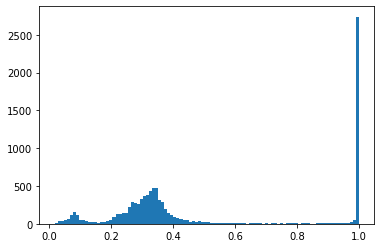

In [61]:
if __name__ == '__main__':
    main(train_df)

if CFG.epochs > 100:
    from IPython.display import clear_output  # セルの出力削除（1000epもログあると重すぎるので消す）
    clear_output()

In [62]:
#%debug

In [63]:
#=====

# Predict and submit

In [64]:
%reload_ext autoreload
%autoreload 2
from src import tta_util

In [65]:
@torch.inference_mode()  # pytorch >= 1.9
def inference(model, pth, test_loader, device, tta_transforms=None, tta_ops=[0]):
    if len(CFG.device_ids) > 1:
        model.load_state_dict(loadpth(pth))
    else:
        model.load_state_dict(torch.load(pth)['model'])
    model.eval().to(device)
    
    if len(CFG.device_ids) > 1:
        LOGGER.info(f"=> inference is_multiGPU {CFG.device_ids}")
        model = nn.DataParallel(model)  # make parallel
        cudnn.benchmark = True
    
    # ttach
    if tta_transforms is not None:
        model = tta.ClassificationTTAWrapper(model, tta_transforms)
    
    LOGGER.info(f"tta_ops: {str(tta_ops)}")
    preds = []
    preds2 = []  # for MultiOutput
    preds3 = []  # for MultiOutput2,3
    for i, (images, _, _,) in tqdm(enumerate(test_loader), total=len(test_loader)):
        images = images.to(device)
        outputs = None
        outputs2 = 0
        outputs3 = 0
        with torch.no_grad():
            
            for _ops in tta_ops:
                
                if "MultiOutput" in CFG.model_cls:
                    if (CFG.model_cls == "CustomModelMultiOutput2") or (CFG.model_cls == "CustomModelMultiOutput3"):
                        o, o2, o3 = model( tta_util.tta_tensor(images, _ops) )  # 予測値の算出  for MultiOutput2,3
                    else:
                        o, o2 = model( tta_util.tta_tensor(images, _ops) )  # 予測値の算出  for MultiOutput
                        o3 = 0
                else:
                    o = model( tta_util.tta_tensor(images, _ops) )  # 予測値の算出  for MultiOutput
                    o2, o3 = 0, 0
                
                if outputs is None:
                    outputs = o
                    outputs2 = o2
                    outputs3 = o3
                else:
                    outputs += o
                    outputs2 += o2
                    outputs3 += o3
        outputs /= len(tta_ops)
        outputs2 /= len(tta_ops)
        outputs3 /= len(tta_ops)
        
        # for BCE
        preds.append(outputs.sigmoid().cpu().detach().numpy())
        if "CustomModelMultiOutput" in CFG.model_cls:
            preds2.append(outputs2.argmax(1).cpu().detach().numpy())  # for MultiOutput
        if CFG.model_cls == "CustomModelMultiOutput2":
            preds3.append(outputs3.sigmoid().cpu().detach().numpy())  # for MultiOutput2
        elif CFG.model_cls == "CustomModelMultiOutput3":
            preds3.append(outputs3.argmax(1).cpu().detach().numpy())  # for MultiOutput3
    
    predictions = np.concatenate(preds)
    # for MultiOutput
    if len(preds2) == 0:
        predictions2 = None
    else:
        predictions2 = np.concatenate(preds2) 
    if len(preds3) == 0:
        predictions3 = None
    else:
        predictions3 = np.concatenate(preds3)
    
    # 推論うまくいかず欠損になったのは0にする
    predictions = np.nan_to_num(predictions, nan=0)
    
    del model
    gc.collect()
    torch.cuda.empty_cache()
    
    #return predictions, predictions2
    return predictions, predictions2, predictions3  # for MultiOutput2,3

In [66]:
def main_test(test, pths, tta_transforms=None, transforms_type="valid", test_dataset=None, tta_ops=[0], is_cr=False):
    model = eval(CFG.model_cls)(CFG)
    if test_dataset is None:
        test_dataset = TrainDataset(test, 
                                    transforms=get_transforms(data=transforms_type),
                                    is_npy=CFG.is_npy,
                                    #add_ch_type=CFG.add_ch_type,
                                   )
    test_loader = DataLoader(test_dataset, 
                             batch_size=CFG.batch_size * 2, 
                             shuffle=False, 
                             num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    predictions = None
    LOGGER.info(f'========== TEST ==========')  # for MultiOutput
    for i, pth in enumerate(pths):
        print("pth:", pth)
        
        #p, p2 = inference(model, pth, test_loader, device, tta_transforms, tta_ops=tta_ops)  # for MultiOutput
        p, p2, p3 = inference(model, pth, test_loader, device, tta_transforms, tta_ops=tta_ops)  # for MultiOutput2,3
        # 各foldの予測個別で持つ
        test[f'preds_fold{i}'] = p
        # for MultiOutput
        if "CustomModelMultiOutput" in CFG.model_cls:
            test[f'preds_freq_min//N_fold{i}'] = p2
            score2 = accuracy_score(test["freq_min//N"].to_numpy(), p2)
            LOGGER.info(f'freq_min//N {str(Path(pth).stem)} Accuracy: {score2:<.4f}')
            if is_cr:
                LOGGER.info(classification_report(test["freq_min//N"].to_numpy(), p2))
        if CFG.model_cls == "CustomModelMultiOutput2":
            test[f'preds_real_sim_fold{i}'] = p3
            score3 = get_score(test["real_sim"].to_numpy(), p3)
            LOGGER.info(f'real_sim {str(Path(pth).stem)} AUC: {score3:<.4f}')
        elif CFG.model_cls == "CustomModelMultiOutput3":
            test[f'preds_h0deg//10_fold{i}'] = p3
            #score3 = accuracy_score(test["h0deg//10"].to_numpy(), p3)  # testに h0deg//10 は無いのでコメントアウト
            #LOGGER.info(classification_report(test["h0deg//10"].to_numpy(), p3))  # testに h0deg//10 は無いのでコメントアウト
        
        if predictions is None:
            predictions = p
        else:
            predictions += p

    test['preds'] = predictions / len(pths)
    
    return test

In [67]:
# ttach param
# https://www.guruguru.science/competitions/17/discussions/4864ee81-6336-4cad-bb74-a4c9b46e6eb2/
tta_transforms = tta.Compose(
    [
        #tta.HorizontalFlip(),
        #tta.VerticalFlip(),
        #tta.Rotate90(angles=[0, 90, 180, 270]),  # 90度回転
        #tta.Scale(scales=[0.9, 1.1], interpolation="nearest"),  # 画像の大きさscales倍. h * scale_factor, w * scale_factor
        #tta.Add(values=[-1, 0, 1, 2]),  # 画素にfactorの値足す. x + value
        #tta.Multiply(factors=[0.9, 1, 1.1]),  # 画素をfactor倍. x * factor
        #tta.FiveCrops(crop_height=CFG.size//3, crop_width=CFG.size//3),  # 画像を5分割. crop_height: cropする画像の高さ. crop_width: cropする画像の幅
        #tta.Resize(sizes=[(224, 224), (384, 384)], original_size=(CFG.size, CFG.size), interpolation="nearest")  # 指定の大きさにリサイズ
    ]
)
tta_transforms = None

In [68]:
# ==========================================================
# valid inference
# ==========================================================
def _run_valid_tta(tta_ops):
    seed = CFG.seeds[0]
    valid = pd.read_csv(OUTPUT_DIR + f"/folds_seed{seed}.csv")

    # tta inference
    score_list = []
    pred_valid = pd.DataFrame()
    for fold in CFG.trn_fold:
        print(f"===== valid fold{fold} =====")

        # model pths
        pths = sorted(glob.glob(OUTPUT_DIR + f"/*_fold{fold}*_best_score.pth"))
        #pths = sorted(glob.glob(OUTPUT_DIR + f"/*_fold{fold}*_best_loss.pth"))
        print(pths)

        valid_f = valid[valid.fold == fold]
        print(valid_f.shape)

        if (CFG.alb_norm_mean_th > 0) or (CFG.alb_norm_std_th > 0):
            transforms_type = 'valid_norm'
        else:
            transforms_type = 'valid'
        valid_f = main_test(valid_f, pths=pths, tta_transforms=tta_transforms, transforms_type=transforms_type, tta_ops=tta_ops, is_cr=False)

        ## =============================
        ## tta alb
        ## =============================
        #valid_f_tta1 = main_test(valid_f, pths=pths, tta_transforms=tta_transforms, transforms_type="tta1")
        #valid_f_tta1 = valid_f_tta1.rename(columns={"preds": "preds_tta1"})
        #
        #valid_f = pd.merge(valid_f, valid_f_tta1[["id", "preds_tta1"]], on="id")
        #valid_f["preds"] = (valid_f["preds"].to_numpy() + valid_f["preds_tta1"].to_numpy()) / 2.0
        ## =============================

        ## =============================
        ## tta Dataset
        ## =============================
        #_test_dataset = TrainDataset(valid_f, 
        #                             transforms=get_transforms(data="valid"),
        #                             #prob_spec_start_random=1.0,
        #                             #prob_vshift=1.0,  # CV悪化
        #                             prob_swap_nega=1.0,  # CV悪化
        #                             is_npy=CFG.is_npy,
        #                             add_ch_type=CFG.add_ch_type,
        #                           )
        #valid_f_ttaD = main_test(valid_f, pths=pths, tta_transforms=tta_transforms, transforms_type="valid", test_dataset=_test_dataset)
        #valid_f_ttaD = valid_f_ttaD.rename(columns={"preds": "preds_ttaD"})
        #
        #valid_f = pd.merge(valid_f, valid_f_ttaD[["id", "preds_ttaD"]], on="id")
        #valid_f["preds"] = (valid_f["preds"].to_numpy() + valid_f["preds_ttaD"].to_numpy()) / 2.0
        ## =============================

        score = get_result(valid_f, preds_col="preds", add_info=f"TTA fold{fold} ")
        score_list.append(score)
        pred_valid = pd.concat([pred_valid, valid_f])

    LOGGER.info(f"macro mean folds Score ± std: {str(round(np.mean(score_list), 4))} ± {str(round(np.std(score_list), 4))}")
    tta_oof_score = get_result(pred_valid, preds_col="preds", add_info=f"TTA oof ")
    pred_valid.to_csv(OUTPUT_DIR + f'/{CFG.name}_oof_df_seed{seed}_tta{"".join([str(_) for _ in tta_ops])}.csv', index=False)
    display(pred_valid.head())

    #if CFG.is_wandb:
    #    # save log wandb
    #    wandb.log({f"TTA oof Score": tta_oof_score})

In [69]:
_run_valid_tta([0,1,2])
_run_valid_tta([0,1])
_run_valid_tta([0,2])
_run_valid_tta([0])

===== valid fold0 =====
['/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold0_seed0_best_score.pth']
(1960, 40)


========== TEST ==========


valid_norm
pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold0_seed0_best_score.pth


tta_ops: [0, 1, 2]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.17it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold0_seed0_best_score Accuracy: 0.2020
TTA fold0 Score: 0.8859


===== valid fold1 =====
['/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold1_seed0_best_score.pth']
(1959, 40)


========== TEST ==========


valid_norm
pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold1_seed0_best_score.pth


tta_ops: [0, 1, 2]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.17it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold1_seed0_best_score Accuracy: 0.1904
TTA fold1 Score: 0.8903


===== valid fold2 =====
['/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold2_seed0_best_score.pth']
(1959, 40)


========== TEST ==========


valid_norm
pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold2_seed0_best_score.pth


tta_ops: [0, 1, 2]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.17it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold2_seed0_best_score Accuracy: 0.2113
TTA fold2 Score: 0.8890


===== valid fold3 =====
['/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold3_seed0_best_score.pth']
(1959, 40)


========== TEST ==========


valid_norm
pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold3_seed0_best_score.pth


tta_ops: [0, 1, 2]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.17it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold3_seed0_best_score Accuracy: 0.2200
TTA fold3 Score: 0.8749


===== valid fold4 =====
['/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold4_seed0_best_score.pth']
(1959, 40)


========== TEST ==========


valid_norm
pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold4_seed0_best_score.pth


tta_ops: [0, 1, 2]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.17it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold4_seed0_best_score Accuracy: 0.2032
TTA fold4 Score: 0.8827
macro mean folds Score ± std: 0.8846 ± 0.0055
TTA oof Score: 0.8799


id    freq min    freq max  H1 SFTs h  H1 SFTs w   H1 time min  \
5   0197bacf8  316.482222  316.681667      360.0     4545.0  1.238168e+09   
12  02c478b09  462.168333  462.367778      360.0     4655.0  1.238168e+09   
17  047e6e2a3   72.943889   73.143333      360.0     4773.0  1.238168e+09   
18  0517ef7fe   99.727778   99.927222      360.0     4647.0  1.238171e+09   
32  09ecddbba  488.741111  488.940556      360.0     4600.0  1.238167e+09   

     H1 time max  H1 max inteval  L1 SFTs h  L1 SFTs w   L1 time min  \
5   1.248583e+09         60558.0      360.0     4523.0  1.238182e+09   
12  1.248513e+09         36492.0      360.0     4625.0  1.238174e+09   
17  1.248583e+09         34177.0      360.0     4538.0  1.238168e+09   
18  1.248559e+09         31868.0      360.0     4719.0  1.238179e+09   
32  1.248532e+09         43189.0      360.0     4634.0  1.238166e+09   

     L1 time max  L1 max inteval  target  freq_min//10 freq_min//10_target  \
5   1.248555e+09         60558.0     1.0          31.0                31_1   
12  1.248543e+09         36492.0     1.0          46.0                46_1   
17  1.248565e+09         34177.0     1.0           7.0                 7_1   
18  1.248545e+09         31868.0     1.0           9.0                 9_1   
32  1.248533e+09         43189.0     1.0          48.0                48_1   

                                                 path  orig   h1_mean  \
5   /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...   1.0  2.252390   
12  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...   1.0  2.247005   
17  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...   1.0  2.250768   
18  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...   1.0  2.256312   
32  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...   1.0  2.257586   

     l1_mean    h1_std    l1_std  freq_min//N  h1_l1_mean  h1_l1_std  fold  \
5   2.253793  0.400924  0.401087          6.0    4.506183   0.802011     0   
12  2.250381  0.398699  0.399798          9.0    4.497386   0.798497     0   
17  2.253459  0.403756  0.401150          1.0    4.504227   0.804906     0   
18  2.249809  0.401606  0.402489          1.0    4.506121   0.804095     0   
32  2.257342  0.408922  0.412729          9.0    4.514927   0.821651     0   

    sqrtSX  F0 type dir_name  F1  h0deg  h1_minstd  h1_maxstd  h1_stddiff  \
5      NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
12     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
17     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
18     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
32     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   

    l1_minstd  l1_maxstd  l1_stddiff  h1_max/l1_max  real_sim  preds_fold0  \
5         NaN        NaN         NaN            NaN       NaN     0.995862   
12        NaN        NaN         NaN            NaN       NaN     0.380894   
17        NaN        NaN         NaN            NaN       NaN     0.999601   
18        NaN        NaN         NaN            NaN       NaN     0.998148   
32        NaN        NaN         NaN            NaN       NaN     0.999848   

    preds_freq_min//N_fold0     preds  
5                         5  0.995862  
12                        3  0.380894  
17                        1  0.999601  
18                        1  0.998148  
32                        8  0.999848

===== valid fold0 =====
['/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold0_seed0_best_score.pth']
(1960, 40)


========== TEST ==========


valid_norm
pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold0_seed0_best_score.pth


tta_ops: [0, 1]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.73it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold0_seed0_best_score Accuracy: 0.1995
TTA fold0 Score: 0.8872


===== valid fold1 =====
['/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold1_seed0_best_score.pth']
(1959, 40)


========== TEST ==========


valid_norm
pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold1_seed0_best_score.pth


tta_ops: [0, 1]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.74it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold1_seed0_best_score Accuracy: 0.1924
TTA fold1 Score: 0.8887


===== valid fold2 =====
['/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold2_seed0_best_score.pth']
(1959, 40)


========== TEST ==========


valid_norm
pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold2_seed0_best_score.pth


tta_ops: [0, 1]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.74it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold2_seed0_best_score Accuracy: 0.2047
TTA fold2 Score: 0.8895


===== valid fold3 =====
['/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold3_seed0_best_score.pth']
(1959, 40)


========== TEST ==========


valid_norm
pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold3_seed0_best_score.pth


tta_ops: [0, 1]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.72it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold3_seed0_best_score Accuracy: 0.2169
TTA fold3 Score: 0.8735


===== valid fold4 =====
['/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold4_seed0_best_score.pth']
(1959, 40)


========== TEST ==========


valid_norm
pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold4_seed0_best_score.pth


tta_ops: [0, 1]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.74it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold4_seed0_best_score Accuracy: 0.2047
TTA fold4 Score: 0.8817
macro mean folds Score ± std: 0.8841 ± 0.006
TTA oof Score: 0.8792


id    freq min    freq max  H1 SFTs h  H1 SFTs w   H1 time min  \
5   0197bacf8  316.482222  316.681667      360.0     4545.0  1.238168e+09   
12  02c478b09  462.168333  462.367778      360.0     4655.0  1.238168e+09   
17  047e6e2a3   72.943889   73.143333      360.0     4773.0  1.238168e+09   
18  0517ef7fe   99.727778   99.927222      360.0     4647.0  1.238171e+09   
32  09ecddbba  488.741111  488.940556      360.0     4600.0  1.238167e+09   

     H1 time max  H1 max inteval  L1 SFTs h  L1 SFTs w   L1 time min  \
5   1.248583e+09         60558.0      360.0     4523.0  1.238182e+09   
12  1.248513e+09         36492.0      360.0     4625.0  1.238174e+09   
17  1.248583e+09         34177.0      360.0     4538.0  1.238168e+09   
18  1.248559e+09         31868.0      360.0     4719.0  1.238179e+09   
32  1.248532e+09         43189.0      360.0     4634.0  1.238166e+09   

     L1 time max  L1 max inteval  target  freq_min//10 freq_min//10_target  \
5   1.248555e+09         60558.0     1.0          31.0                31_1   
12  1.248543e+09         36492.0     1.0          46.0                46_1   
17  1.248565e+09         34177.0     1.0           7.0                 7_1   
18  1.248545e+09         31868.0     1.0           9.0                 9_1   
32  1.248533e+09         43189.0     1.0          48.0                48_1   

                                                 path  orig   h1_mean  \
5   /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...   1.0  2.252390   
12  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...   1.0  2.247005   
17  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...   1.0  2.250768   
18  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...   1.0  2.256312   
32  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...   1.0  2.257586   

     l1_mean    h1_std    l1_std  freq_min//N  h1_l1_mean  h1_l1_std  fold  \
5   2.253793  0.400924  0.401087          6.0    4.506183   0.802011     0   
12  2.250381  0.398699  0.399798          9.0    4.497386   0.798497     0   
17  2.253459  0.403756  0.401150          1.0    4.504227   0.804906     0   
18  2.249809  0.401606  0.402489          1.0    4.506121   0.804095     0   
32  2.257342  0.408922  0.412729          9.0    4.514927   0.821651     0   

    sqrtSX  F0 type dir_name  F1  h0deg  h1_minstd  h1_maxstd  h1_stddiff  \
5      NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
12     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
17     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
18     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
32     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   

    l1_minstd  l1_maxstd  l1_stddiff  h1_max/l1_max  real_sim  preds_fold0  \
5         NaN        NaN         NaN            NaN       NaN     0.995730   
12        NaN        NaN         NaN            NaN       NaN     0.386877   
17        NaN        NaN         NaN            NaN       NaN     0.999484   
18        NaN        NaN         NaN            NaN       NaN     0.997873   
32        NaN        NaN         NaN            NaN       NaN     0.999868   

    preds_freq_min//N_fold0     preds  
5                         5  0.995730  
12                        3  0.386877  
17                        1  0.999484  
18                        1  0.997873  
32                        8  0.999868

===== valid fold0 =====
['/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold0_seed0_best_score.pth']
(1960, 40)


========== TEST ==========


valid_norm
pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold0_seed0_best_score.pth


tta_ops: [0, 2]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.73it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold0_seed0_best_score Accuracy: 0.1980
TTA fold0 Score: 0.8832


===== valid fold1 =====
['/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold1_seed0_best_score.pth']
(1959, 40)


========== TEST ==========


valid_norm
pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold1_seed0_best_score.pth


tta_ops: [0, 2]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.74it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold1_seed0_best_score Accuracy: 0.1884
TTA fold1 Score: 0.8902


===== valid fold2 =====
['/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold2_seed0_best_score.pth']
(1959, 40)


========== TEST ==========


valid_norm
pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold2_seed0_best_score.pth


tta_ops: [0, 2]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.74it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold2_seed0_best_score Accuracy: 0.2093
TTA fold2 Score: 0.8913


===== valid fold3 =====
['/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold3_seed0_best_score.pth']
(1959, 40)


========== TEST ==========


valid_norm
pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold3_seed0_best_score.pth


tta_ops: [0, 2]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.74it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold3_seed0_best_score Accuracy: 0.2185
TTA fold3 Score: 0.8754


===== valid fold4 =====
['/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold4_seed0_best_score.pth']
(1959, 40)


========== TEST ==========


valid_norm
pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold4_seed0_best_score.pth


tta_ops: [0, 2]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.74it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold4_seed0_best_score Accuracy: 0.1996
TTA fold4 Score: 0.8828
macro mean folds Score ± std: 0.8846 ± 0.0058
TTA oof Score: 0.8802


id    freq min    freq max  H1 SFTs h  H1 SFTs w   H1 time min  \
5   0197bacf8  316.482222  316.681667      360.0     4545.0  1.238168e+09   
12  02c478b09  462.168333  462.367778      360.0     4655.0  1.238168e+09   
17  047e6e2a3   72.943889   73.143333      360.0     4773.0  1.238168e+09   
18  0517ef7fe   99.727778   99.927222      360.0     4647.0  1.238171e+09   
32  09ecddbba  488.741111  488.940556      360.0     4600.0  1.238167e+09   

     H1 time max  H1 max inteval  L1 SFTs h  L1 SFTs w   L1 time min  \
5   1.248583e+09         60558.0      360.0     4523.0  1.238182e+09   
12  1.248513e+09         36492.0      360.0     4625.0  1.238174e+09   
17  1.248583e+09         34177.0      360.0     4538.0  1.238168e+09   
18  1.248559e+09         31868.0      360.0     4719.0  1.238179e+09   
32  1.248532e+09         43189.0      360.0     4634.0  1.238166e+09   

     L1 time max  L1 max inteval  target  freq_min//10 freq_min//10_target  \
5   1.248555e+09         60558.0     1.0          31.0                31_1   
12  1.248543e+09         36492.0     1.0          46.0                46_1   
17  1.248565e+09         34177.0     1.0           7.0                 7_1   
18  1.248545e+09         31868.0     1.0           9.0                 9_1   
32  1.248533e+09         43189.0     1.0          48.0                48_1   

                                                 path  orig   h1_mean  \
5   /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...   1.0  2.252390   
12  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...   1.0  2.247005   
17  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...   1.0  2.250768   
18  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...   1.0  2.256312   
32  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...   1.0  2.257586   

     l1_mean    h1_std    l1_std  freq_min//N  h1_l1_mean  h1_l1_std  fold  \
5   2.253793  0.400924  0.401087          6.0    4.506183   0.802011     0   
12  2.250381  0.398699  0.399798          9.0    4.497386   0.798497     0   
17  2.253459  0.403756  0.401150          1.0    4.504227   0.804906     0   
18  2.249809  0.401606  0.402489          1.0    4.506121   0.804095     0   
32  2.257342  0.408922  0.412729          9.0    4.514927   0.821651     0   

    sqrtSX  F0 type dir_name  F1  h0deg  h1_minstd  h1_maxstd  h1_stddiff  \
5      NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
12     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
17     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
18     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
32     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   

    l1_minstd  l1_maxstd  l1_stddiff  h1_max/l1_max  real_sim  preds_fold0  \
5         NaN        NaN         NaN            NaN       NaN     0.995488   
12        NaN        NaN         NaN            NaN       NaN     0.370398   
17        NaN        NaN         NaN            NaN       NaN     0.999633   
18        NaN        NaN         NaN            NaN       NaN     0.997986   
32        NaN        NaN         NaN            NaN       NaN     0.999788   

    preds_freq_min//N_fold0     preds  
5                         5  0.995488  
12                        3  0.370398  
17                        1  0.999633  
18                        1  0.997986  
32                        8  0.999788

===== valid fold0 =====
['/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold0_seed0_best_score.pth']
(1960, 40)


========== TEST ==========


valid_norm
pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold0_seed0_best_score.pth


tta_ops: [0]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.37it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold0_seed0_best_score Accuracy: 0.1995
TTA fold0 Score: 0.8836


===== valid fold1 =====
['/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold1_seed0_best_score.pth']
(1959, 40)


========== TEST ==========


valid_norm
pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold1_seed0_best_score.pth


tta_ops: [0]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.38it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold1_seed0_best_score Accuracy: 0.1858
TTA fold1 Score: 0.8866


===== valid fold2 =====
['/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold2_seed0_best_score.pth']
(1959, 40)


========== TEST ==========


valid_norm
pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold2_seed0_best_score.pth


tta_ops: [0]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.34it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold2_seed0_best_score Accuracy: 0.2011
TTA fold2 Score: 0.8947


===== valid fold3 =====
['/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold3_seed0_best_score.pth']
(1959, 40)


========== TEST ==========


valid_norm
pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold3_seed0_best_score.pth


tta_ops: [0]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.39it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold3_seed0_best_score Accuracy: 0.2210
TTA fold3 Score: 0.8744


===== valid fold4 =====
['/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold4_seed0_best_score.pth']
(1959, 40)


========== TEST ==========


valid_norm
pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold4_seed0_best_score.pth


tta_ops: [0]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.38it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold4_seed0_best_score Accuracy: 0.2042
TTA fold4 Score: 0.8804
macro mean folds Score ± std: 0.8839 ± 0.0067
TTA oof Score: 0.8792


id    freq min    freq max  H1 SFTs h  H1 SFTs w   H1 time min  \
5   0197bacf8  316.482222  316.681667      360.0     4545.0  1.238168e+09   
12  02c478b09  462.168333  462.367778      360.0     4655.0  1.238168e+09   
17  047e6e2a3   72.943889   73.143333      360.0     4773.0  1.238168e+09   
18  0517ef7fe   99.727778   99.927222      360.0     4647.0  1.238171e+09   
32  09ecddbba  488.741111  488.940556      360.0     4600.0  1.238167e+09   

     H1 time max  H1 max inteval  L1 SFTs h  L1 SFTs w   L1 time min  \
5   1.248583e+09         60558.0      360.0     4523.0  1.238182e+09   
12  1.248513e+09         36492.0      360.0     4625.0  1.238174e+09   
17  1.248583e+09         34177.0      360.0     4538.0  1.238168e+09   
18  1.248559e+09         31868.0      360.0     4719.0  1.238179e+09   
32  1.248532e+09         43189.0      360.0     4634.0  1.238166e+09   

     L1 time max  L1 max inteval  target  freq_min//10 freq_min//10_target  \
5   1.248555e+09         60558.0     1.0          31.0                31_1   
12  1.248543e+09         36492.0     1.0          46.0                46_1   
17  1.248565e+09         34177.0     1.0           7.0                 7_1   
18  1.248545e+09         31868.0     1.0           9.0                 9_1   
32  1.248533e+09         43189.0     1.0          48.0                48_1   

                                                 path  orig   h1_mean  \
5   /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...   1.0  2.252390   
12  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...   1.0  2.247005   
17  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...   1.0  2.250768   
18  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...   1.0  2.256312   
32  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...   1.0  2.257586   

     l1_mean    h1_std    l1_std  freq_min//N  h1_l1_mean  h1_l1_std  fold  \
5   2.253793  0.400924  0.401087          6.0    4.506183   0.802011     0   
12  2.250381  0.398699  0.399798          9.0    4.497386   0.798497     0   
17  2.253459  0.403756  0.401150          1.0    4.504227   0.804906     0   
18  2.249809  0.401606  0.402489          1.0    4.506121   0.804095     0   
32  2.257342  0.408922  0.412729          9.0    4.514927   0.821651     0   

    sqrtSX  F0 type dir_name  F1  h0deg  h1_minstd  h1_maxstd  h1_stddiff  \
5      NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
12     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
17     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
18     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
32     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   

    l1_minstd  l1_maxstd  l1_stddiff  h1_max/l1_max  real_sim  preds_fold0  \
5         NaN        NaN         NaN            NaN       NaN     0.994759   
12        NaN        NaN         NaN            NaN       NaN     0.371763   
17        NaN        NaN         NaN            NaN       NaN     0.999434   
18        NaN        NaN         NaN            NaN       NaN     0.997111   
32        NaN        NaN         NaN            NaN       NaN     0.999777   

    preds_freq_min//N_fold0     preds  
5                         5  0.994759  
12                        3  0.371763  
17                        1  0.999434  
18                        1  0.997111  
32                        8  0.999777

In [70]:
#%debug

In [71]:
#=====

In [72]:
def _run_test_tta(tta_ops):
    if IS_MAKE_SUB:
        # model pths
        pths = sorted(glob.glob(OUTPUT_DIR + "/*best_score.pth"))
        #pths = sorted(glob.glob(OUTPUT_DIR + "/*best_loss.pth"))
        print(pths)

        # 'h0deg//10'列無いとエラーになるので入れとく
        test_df['h0deg//10'] = 0

        # ==========================================================
        # test inference
        # ==========================================================
        if (CFG.alb_norm_mean_th > 0) or (CFG.alb_norm_std_th > 0):
            transforms_type = 'valid_norm'
        else:
            transforms_type = 'valid'
        #submit = main_test(test_df, pths=pths, tta_transforms=tta_transforms, transforms_type=transforms_type)
        submit = main_test(test_df, pths=pths, tta_transforms=tta_transforms, transforms_type=transforms_type, tta_ops=tta_ops)

        ## =============================
        ## tta alb
        ## =============================
        #submit_tta1 = main_test(test_df, pths=pths, tta_transforms=tta_transforms, transforms_type="tta1")
        #submit_tta1 = submit_tta1.rename(columns={"preds": "preds_tta1"})
        #
        #submit = pd.merge(submit, submit_tta1[["id", "preds_tta1"]], on="id")
        #submit["preds"] = (submit["preds"].to_numpy() + submit["preds_tta1"].to_numpy()) / 2.0
        ## =============================

        submit["target"] = submit["preds"].to_numpy()
        display(submit.head())
        submit.to_csv(OUTPUT_DIR + f'/{CFG.name}_test_tta{"".join([str(_) for _ in tta_ops])}.csv', index=False)

        submit = submit[["id", "target"]]
        print('target range [%.6f, %.6f]' % (submit['target'].min(), submit['target'].max()))

        # Write prediction
        submit.to_csv(OUTPUT_DIR + f'/{CFG.name}_submission_tta{"".join([str(_) for _ in tta_ops])}.csv', index=False)
        display(submit)

        plt.hist(submit["target"], bins=100)
        plt.show()
        plt.clf()  # メモリ解放
        plt.close()

['/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold0_seed0_best_score.pth', '/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold1_seed0_best_score.pth', '/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold2_seed0_best_score.pth', '/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold3_seed0_best_score.pth', '/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_s

========== TEST ==========


valid_norm
pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold0_seed0_best_score.pth


tta_ops: [0, 1, 2]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:55<00:00,  1.14it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold0_seed0_best_score Accuracy: 0.1893


pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold1_seed0_best_score.pth


tta_ops: [0, 1, 2]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:54<00:00,  1.15it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold1_seed0_best_score Accuracy: 0.1977


pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold2_seed0_best_score.pth


tta_ops: [0, 1, 2]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:54<00:00,  1.15it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold2_seed0_best_score Accuracy: 0.1957


pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold3_seed0_best_score.pth


tta_ops: [0, 1, 2]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:54<00:00,  1.15it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold3_seed0_best_score Accuracy: 0.1999


pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold4_seed0_best_score.pth


tta_ops: [0, 1, 2]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:54<00:00,  1.15it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold4_seed0_best_score Accuracy: 0.2045


id    freq min    freq max  H1 SFTs h  H1 SFTs w   H1 time min  \
0  00054c878  306.402222  306.601667      360.0     4639.0  1.238170e+09   
1  0007285a3  126.348889  126.548333      360.0     4427.0  1.238168e+09   
2  00076c5a6  197.289444  197.488889      360.0     4599.0  1.238169e+09   
3  001349290   94.908333   95.107778      360.0     4609.0  1.238171e+09   
4  001a52e92  464.077222  464.276667      360.0     4601.0  1.238167e+09   

    H1 time max  H1 max inteval  L1 SFTs h  L1 SFTs w   L1 time min  \
0  1.248567e+09         43102.0      360.0     4566.0  1.238169e+09   
1  1.248520e+09         42746.0      360.0     4650.0  1.238170e+09   
2  1.248535e+09         55878.0      360.0     4633.0  1.238172e+09   
3  1.248536e+09         48020.0      360.0     4621.0  1.238167e+09   
4  1.248535e+09         45246.0      360.0     4366.0  1.238167e+09   

    L1 time max  L1 max inteval    target  \
0  1.248561e+09         43102.0  0.284655   
1  1.248537e+09         42746.0  0.390703   
2  1.248567e+09         55878.0  0.287834   
3  1.248537e+09         48020.0  0.680783   
4  1.248543e+09         45246.0  0.818564   

                                                path  orig  freq_min//10  \
0  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...     1          30.0   
1  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...     1          12.0   
2  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...     1          19.0   
3  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...     1           9.0   
4  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...     1          46.0   

    h1_mean   l1_mean    h1_std    l1_std     h1_minstd     h1_maxstd  \
0  2.251338  2.247327  0.397542  0.397476  1.058791e-22  1.058791e-22   
1  2.250531  2.253083  0.399520  0.399918  1.058791e-22  1.058791e-22   
2  2.249787  2.250360  0.399082  0.401004  1.058791e-22  1.058791e-22   
3  2.251309  2.250812  0.399954  0.399532  1.058791e-22  1.058791e-22   
4  2.250533  2.250065  0.402394  0.400455  1.058791e-22  1.058791e-22   

   h1_stddiff     l1_minstd     l1_maxstd  l1_stddiff  h1_max/l1_max  \
0         0.0  1.058791e-22  1.058791e-22         0.0       1.085967   
1         0.0  1.058791e-22  1.058791e-22         0.0       0.971284   
2         0.0  1.058791e-22  1.058791e-22         0.0       1.037622   
3         0.0  1.058791e-22  1.058791e-22         0.0       1.025819   
4         0.0  1.058791e-22  1.058791e-22         0.0       0.976649   

   real_sim  freq_min//N  h1_l1_mean  h1_l1_std  h0deg//10  preds_fold0  \
0         0          6.0    4.498665   0.795017          0     0.331727   
1         0          2.0    4.503615   0.799438          0     0.381623   
2         0          3.0    4.500148   0.800086          0     0.328691   
3         0          1.0    4.502120   0.799486          0     0.629970   
4         0          9.0    4.500598   0.802849          0     0.667461   

   preds_freq_min//N_fold0  preds_fold1  preds_freq_min//N_fold1  preds_fold2  \
0                        3     0.318442                        7     0.205215   
1                        3     0.583933                        1     0.189295   
2                        3     0.354330                        7     0.186186   
3                        1     0.908250                        2     0.486584   
4                        1     0.920991                        2     0.841449   

   preds_freq_min//N_fold2  preds_fold3  preds_freq_min//N_fold3  preds_fold4  \
0                        6     0.271618                        4     0.296272   
1                        6     0.371476                        3     0.427188   
2                        6     0.266554                        4     0.303409   
3                        2     0.577812                        2     0.801298   
4                        2     0.810460                        1     0.852458   

   preds_freq_min//N_fold4     preds  
0                        6  0.284655  
1                      

target range [0.056546, 0.999973]


id    target
0     00054c878  0.284655
1     0007285a3  0.390703
2     00076c5a6  0.287834
3     001349290  0.680783
4     001a52e92  0.818564
...         ...       ...
7970  ffbce04ef  0.998150
7971  ffc2d976b  0.235558
7972  ffc905909  0.232675
7973  ffe276f3e  0.329609
7974  fffa17f67  0.270274

[7975 rows x 2 columns]

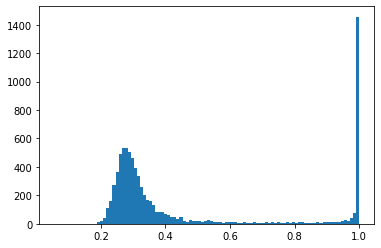

['/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold0_seed0_best_score.pth', '/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold1_seed0_best_score.pth', '/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold2_seed0_best_score.pth', '/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold3_seed0_best_score.pth', '/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_s

========== TEST ==========


valid_norm
pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold0_seed0_best_score.pth


tta_ops: [0, 1]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:36<00:00,  1.71it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold0_seed0_best_score Accuracy: 0.1866


pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold1_seed0_best_score.pth


tta_ops: [0, 1]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:36<00:00,  1.71it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold1_seed0_best_score Accuracy: 0.1913


pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold2_seed0_best_score.pth


tta_ops: [0, 1]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:36<00:00,  1.71it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold2_seed0_best_score Accuracy: 0.1926


pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold3_seed0_best_score.pth


tta_ops: [0, 1]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:36<00:00,  1.71it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold3_seed0_best_score Accuracy: 0.2013


pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold4_seed0_best_score.pth


tta_ops: [0, 1]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:36<00:00,  1.71it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold4_seed0_best_score Accuracy: 0.2041


id    freq min    freq max  H1 SFTs h  H1 SFTs w   H1 time min  \
0  00054c878  306.402222  306.601667      360.0     4639.0  1.238170e+09   
1  0007285a3  126.348889  126.548333      360.0     4427.0  1.238168e+09   
2  00076c5a6  197.289444  197.488889      360.0     4599.0  1.238169e+09   
3  001349290   94.908333   95.107778      360.0     4609.0  1.238171e+09   
4  001a52e92  464.077222  464.276667      360.0     4601.0  1.238167e+09   

    H1 time max  H1 max inteval  L1 SFTs h  L1 SFTs w   L1 time min  \
0  1.248567e+09         43102.0      360.0     4566.0  1.238169e+09   
1  1.248520e+09         42746.0      360.0     4650.0  1.238170e+09   
2  1.248535e+09         55878.0      360.0     4633.0  1.238172e+09   
3  1.248536e+09         48020.0      360.0     4621.0  1.238167e+09   
4  1.248535e+09         45246.0      360.0     4366.0  1.238167e+09   

    L1 time max  L1 max inteval    target  \
0  1.248561e+09         43102.0  0.284828   
1  1.248537e+09         42746.0  0.378525   
2  1.248567e+09         55878.0  0.282976   
3  1.248537e+09         48020.0  0.642718   
4  1.248543e+09         45246.0  0.841062   

                                                path  orig  freq_min//10  \
0  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...     1          30.0   
1  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...     1          12.0   
2  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...     1          19.0   
3  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...     1           9.0   
4  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...     1          46.0   

    h1_mean   l1_mean    h1_std    l1_std     h1_minstd     h1_maxstd  \
0  2.251338  2.247327  0.397542  0.397476  1.058791e-22  1.058791e-22   
1  2.250531  2.253083  0.399520  0.399918  1.058791e-22  1.058791e-22   
2  2.249787  2.250360  0.399082  0.401004  1.058791e-22  1.058791e-22   
3  2.251309  2.250812  0.399954  0.399532  1.058791e-22  1.058791e-22   
4  2.250533  2.250065  0.402394  0.400455  1.058791e-22  1.058791e-22   

   h1_stddiff     l1_minstd     l1_maxstd  l1_stddiff  h1_max/l1_max  \
0         0.0  1.058791e-22  1.058791e-22         0.0       1.085967   
1         0.0  1.058791e-22  1.058791e-22         0.0       0.971284   
2         0.0  1.058791e-22  1.058791e-22         0.0       1.037622   
3         0.0  1.058791e-22  1.058791e-22         0.0       1.025819   
4         0.0  1.058791e-22  1.058791e-22         0.0       0.976649   

   real_sim  freq_min//N  h1_l1_mean  h1_l1_std  h0deg//10  preds_fold0  \
0         0          6.0    4.498665   0.795017          0     0.330196   
1         0          2.0    4.503615   0.799438          0     0.378599   
2         0          3.0    4.500148   0.800086          0     0.331883   
3         0          1.0    4.502120   0.799486          0     0.649996   
4         0          9.0    4.500598   0.802849          0     0.777501   

   preds_freq_min//N_fold0  preds_fold1  preds_freq_min//N_fold1  preds_fold2  \
0                        3     0.325551                        7     0.204121   
1                        3     0.585828                        1     0.172663   
2                        3     0.349053                        7     0.157765   
3                        1     0.844355                        2     0.412107   
4                        1     0.900522                        2     0.834747   

   preds_freq_min//N_fold2  preds_fold3  preds_freq_min//N_fold3  preds_fold4  \
0                        6     0.275857                        4     0.288413   
1                        4     0.326491                        6     0.429044   
2                        6     0.262180                        4     0.313998   
3                        2     0.521955                        2     0.785178   
4                        2     0.815662                        2     0.876878   

   preds_freq_min//N_fold4     preds  
0                        7  0.284828  
1                      

target range [0.056722, 0.999963]


id    target
0     00054c878  0.284828
1     0007285a3  0.378525
2     00076c5a6  0.282976
3     001349290  0.642718
4     001a52e92  0.841062
...         ...       ...
7970  ffbce04ef  0.998227
7971  ffc2d976b  0.237775
7972  ffc905909  0.232763
7973  ffe276f3e  0.316440
7974  fffa17f67  0.274504

[7975 rows x 2 columns]

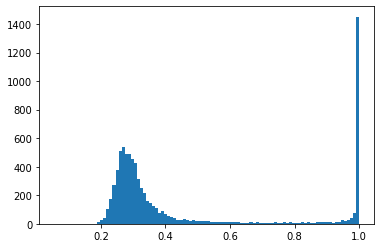

['/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold0_seed0_best_score.pth', '/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold1_seed0_best_score.pth', '/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold2_seed0_best_score.pth', '/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold3_seed0_best_score.pth', '/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_s

========== TEST ==========


valid_norm
pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold0_seed0_best_score.pth


tta_ops: [0, 2]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:36<00:00,  1.71it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold0_seed0_best_score Accuracy: 0.1893


pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold1_seed0_best_score.pth


tta_ops: [0, 2]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:36<00:00,  1.71it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold1_seed0_best_score Accuracy: 0.1977


pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold2_seed0_best_score.pth


tta_ops: [0, 2]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:36<00:00,  1.71it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold2_seed0_best_score Accuracy: 0.1994


pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold3_seed0_best_score.pth


tta_ops: [0, 2]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:36<00:00,  1.71it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold3_seed0_best_score Accuracy: 0.1987


pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold4_seed0_best_score.pth


tta_ops: [0, 2]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:36<00:00,  1.71it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold4_seed0_best_score Accuracy: 0.2066


id    freq min    freq max  H1 SFTs h  H1 SFTs w   H1 time min  \
0  00054c878  306.402222  306.601667      360.0     4639.0  1.238170e+09   
1  0007285a3  126.348889  126.548333      360.0     4427.0  1.238168e+09   
2  00076c5a6  197.289444  197.488889      360.0     4599.0  1.238169e+09   
3  001349290   94.908333   95.107778      360.0     4609.0  1.238171e+09   
4  001a52e92  464.077222  464.276667      360.0     4601.0  1.238167e+09   

    H1 time max  H1 max inteval  L1 SFTs h  L1 SFTs w   L1 time min  \
0  1.248567e+09         43102.0      360.0     4566.0  1.238169e+09   
1  1.248520e+09         42746.0      360.0     4650.0  1.238170e+09   
2  1.248535e+09         55878.0      360.0     4633.0  1.238172e+09   
3  1.248536e+09         48020.0      360.0     4621.0  1.238167e+09   
4  1.248535e+09         45246.0      360.0     4366.0  1.238167e+09   

    L1 time max  L1 max inteval    target  \
0  1.248561e+09         43102.0  0.284714   
1  1.248537e+09         42746.0  0.381435   
2  1.248567e+09         55878.0  0.299676   
3  1.248537e+09         48020.0  0.724808   
4  1.248543e+09         45246.0  0.809535   

                                                path  orig  freq_min//10  \
0  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...     1          30.0   
1  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...     1          12.0   
2  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...     1          19.0   
3  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...     1           9.0   
4  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...     1          46.0   

    h1_mean   l1_mean    h1_std    l1_std     h1_minstd     h1_maxstd  \
0  2.251338  2.247327  0.397542  0.397476  1.058791e-22  1.058791e-22   
1  2.250531  2.253083  0.399520  0.399918  1.058791e-22  1.058791e-22   
2  2.249787  2.250360  0.399082  0.401004  1.058791e-22  1.058791e-22   
3  2.251309  2.250812  0.399954  0.399532  1.058791e-22  1.058791e-22   
4  2.250533  2.250065  0.402394  0.400455  1.058791e-22  1.058791e-22   

   h1_stddiff     l1_minstd     l1_maxstd  l1_stddiff  h1_max/l1_max  \
0         0.0  1.058791e-22  1.058791e-22         0.0       1.085967   
1         0.0  1.058791e-22  1.058791e-22         0.0       0.971284   
2         0.0  1.058791e-22  1.058791e-22         0.0       1.037622   
3         0.0  1.058791e-22  1.058791e-22         0.0       1.025819   
4         0.0  1.058791e-22  1.058791e-22         0.0       0.976649   

   real_sim  freq_min//N  h1_l1_mean  h1_l1_std  h0deg//10  preds_fold0  \
0         0          6.0    4.498665   0.795017          0     0.326798   
1         0          2.0    4.503615   0.799438          0     0.383216   
2         0          3.0    4.500148   0.800086          0     0.326594   
3         0          1.0    4.502120   0.799486          0     0.704728   
4         0          9.0    4.500598   0.802849          0     0.583979   

   preds_freq_min//N_fold0  preds_fold1  preds_freq_min//N_fold1  preds_fold2  \
0                        3     0.323800                        7     0.206838   
1                        3     0.553540                        1     0.180564   
2                        3     0.359831                        7     0.236569   
3                        1     0.933563                        2     0.563221   
4                        1     0.926971                        2     0.863235   

   preds_freq_min//N_fold2  preds_fold3  preds_freq_min//N_fold3  preds_fold4  \
0                        6     0.266740                        4     0.299395   
1                        6     0.369212                        3     0.420642   
2                        6     0.281154                        3     0.294233   
3                        2     0.637305                        2     0.785224   
4                        2     0.803644                        1     0.869848   

   preds_freq_min//N_fold4     preds  
0                        6  0.284714  
1                      

target range [0.054875, 0.999977]


id    target
0     00054c878  0.284714
1     0007285a3  0.381435
2     00076c5a6  0.299676
3     001349290  0.724808
4     001a52e92  0.809535
...         ...       ...
7970  ffbce04ef  0.997946
7971  ffc2d976b  0.236933
7972  ffc905909  0.224536
7973  ffe276f3e  0.341741
7974  fffa17f67  0.266525

[7975 rows x 2 columns]

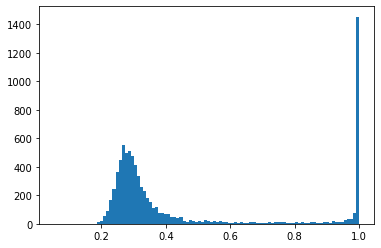

['/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold0_seed0_best_score.pth', '/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold1_seed0_best_score.pth', '/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold2_seed0_best_score.pth', '/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold3_seed0_best_score.pth', '/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_s

========== TEST ==========


valid_norm
pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold0_seed0_best_score.pth


tta_ops: [0]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:18<00:00,  3.38it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold0_seed0_best_score Accuracy: 0.1842


pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold1_seed0_best_score.pth


tta_ops: [0]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:18<00:00,  3.39it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold1_seed0_best_score Accuracy: 0.1906


pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold2_seed0_best_score.pth


tta_ops: [0]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:18<00:00,  3.38it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold2_seed0_best_score Accuracy: 0.1952


pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold3_seed0_best_score.pth


tta_ops: [0]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:18<00:00,  3.37it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold3_seed0_best_score Accuracy: 0.2006


pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold4_seed0_best_score.pth


tta_ops: [0]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:18<00:00,  3.38it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_fold4_seed0_best_score Accuracy: 0.2009


id    freq min    freq max  H1 SFTs h  H1 SFTs w   H1 time min  \
0  00054c878  306.402222  306.601667      360.0     4639.0  1.238170e+09   
1  0007285a3  126.348889  126.548333      360.0     4427.0  1.238168e+09   
2  00076c5a6  197.289444  197.488889      360.0     4599.0  1.238169e+09   
3  001349290   94.908333   95.107778      360.0     4609.0  1.238171e+09   
4  001a52e92  464.077222  464.276667      360.0     4601.0  1.238167e+09   

    H1 time max  H1 max inteval  L1 SFTs h  L1 SFTs w   L1 time min  \
0  1.248567e+09         43102.0      360.0     4566.0  1.238169e+09   
1  1.248520e+09         42746.0      360.0     4650.0  1.238170e+09   
2  1.248535e+09         55878.0      360.0     4633.0  1.238172e+09   
3  1.248536e+09         48020.0      360.0     4621.0  1.238167e+09   
4  1.248535e+09         45246.0      360.0     4366.0  1.238167e+09   

    L1 time max  L1 max inteval    target  \
0  1.248561e+09         43102.0  0.285178   
1  1.248537e+09         42746.0  0.349241   
2  1.248567e+09         55878.0  0.299593   
3  1.248537e+09         48020.0  0.693358   
4  1.248543e+09         45246.0  0.848442   

                                                path  orig  freq_min//10  \
0  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...     1          30.0   
1  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...     1          12.0   
2  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...     1          19.0   
3  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...     1           9.0   
4  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...     1          46.0   

    h1_mean   l1_mean    h1_std    l1_std     h1_minstd     h1_maxstd  \
0  2.251338  2.247327  0.397542  0.397476  1.058791e-22  1.058791e-22   
1  2.250531  2.253083  0.399520  0.399918  1.058791e-22  1.058791e-22   
2  2.249787  2.250360  0.399082  0.401004  1.058791e-22  1.058791e-22   
3  2.251309  2.250812  0.399954  0.399532  1.058791e-22  1.058791e-22   
4  2.250533  2.250065  0.402394  0.400455  1.058791e-22  1.058791e-22   

   h1_stddiff     l1_minstd     l1_maxstd  l1_stddiff  h1_max/l1_max  \
0         0.0  1.058791e-22  1.058791e-22         0.0       1.085967   
1         0.0  1.058791e-22  1.058791e-22         0.0       0.971284   
2         0.0  1.058791e-22  1.058791e-22         0.0       1.037622   
3         0.0  1.058791e-22  1.058791e-22         0.0       1.025819   
4         0.0  1.058791e-22  1.058791e-22         0.0       0.976649   

   real_sim  freq_min//N  h1_l1_mean  h1_l1_std  h0deg//10  preds_fold0  \
0         0          6.0    4.498665   0.795017          0     0.318895   
1         0          2.0    4.503615   0.799438          0     0.378752   
2         0          3.0    4.500148   0.800086          0     0.330861   
3         0          1.0    4.502120   0.799486          0     0.799249   
4         0          9.0    4.500598   0.802849          0     0.748460   

   preds_freq_min//N_fold0  preds_fold1  preds_freq_min//N_fold1  preds_fold2  \
0                        3     0.343741                        7     0.206260   
1                        3     0.526633                        1     0.142458   
2                        3     0.354703                        7     0.219583   
3                        1     0.856946                        2     0.489752   
4                        1     0.892885                        2     0.871804   

   preds_freq_min//N_fold2  preds_fold3  preds_freq_min//N_fold3  preds_fold4  \
0                        6     0.270247                        4     0.286748   
1                        4     0.280551                        4     0.417808   
2                        3     0.286939                        4     0.305877   
3                        2     0.589457                        2     0.731387   
4                        2     0.807511                        2     0.921549   

   preds_freq_min//N_fold4     preds  
0                        6  0.285178  
1                      

target range [0.053525, 0.999966]


id    target
0     00054c878  0.285178
1     0007285a3  0.349241
2     00076c5a6  0.299593
3     001349290  0.693358
4     001a52e92  0.848442
...         ...       ...
7970  ffbce04ef  0.998039
7971  ffc2d976b  0.242968
7972  ffc905909  0.216398
7973  ffe276f3e  0.323696
7974  fffa17f67  0.271129

[7975 rows x 2 columns]

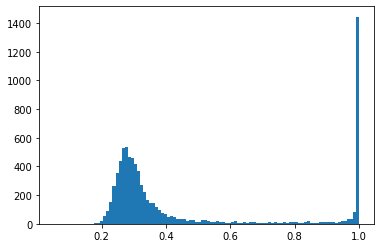

In [73]:
_run_test_tta([0,1,2])
_run_test_tta([0,1])
_run_test_tta([0,2])
_run_test_tta([0])

In [74]:
if CFG.is_wandb:
    wandb.finish()

In [75]:
## submitファイル連結
#if IS_MAKE_SUB:
#    
#    # シュミレーションデータのsubmitファイル
#    _name = CFG.name.replace("_real", "_sim")
#    sim_csv = OUTPUT_DIR + f'/../{_name}/{_name}_submission.csv'
#    
#    if os.path.isfile(sim_csv):
#        submit_real = pd.read_csv(OUTPUT_DIR + f'/{CFG.name}_submission.csv')
#        submit_sim = pd.read_csv(sim_csv)
#        submit = pd.concat([submit_sim, submit_real])
#        
#        # 行の順番をtest_dfの順番にする
#        test_df = pd.read_csv(INPUT_DIR_TEST + '/sample_submission.csv')
#        submit = pd.merge(test_df[["id"]], submit, on="id")
#        
#        submit = submit[["id", "target"]]
#        print('target range [%.6f, %.6f]' % (submit['target'].min(), submit['target'].max()))
#
#        # Write prediction
#        submit.to_csv(OUTPUT_DIR + f'/{CFG.name.split("_real")[0]}_sim_real_submission.csv', index=False)
#        display(submit)
#
#        plt.hist(submit["target"], bins=100)
#        plt.show()
#        plt.clf()  # メモリ解放
#        plt.close()

# Stacking

In [76]:
#### stacking用にtest set全体で推論
#test_df = pd.read_csv(f"./kaggle_dl/eda-g2net2-detecting-continuous-gw_v3/test_summary.csv").rename(columns={"Unnamed: 0":'id'})
#test_df["target"] = 0.5
#if cfg_is_npy:
#    test_df["path"] = f"{_npy_dir}/test/" + test_df["id"] + ".npy"
#else:
#    test_df["path"] = INPUT_DIR_TEST + "/test/" + test_df["id"] + ".hdf5"
#    
#if IS_MAKE_SUB:
#    pths = sorted(glob.glob(OUTPUT_DIR + "/*best_score.pth"))
#    #pths = sorted(glob.glob(OUTPUT_DIR + "/*best_loss.pth"))
#    
#    if (CFG.alb_norm_mean_th > 0) or (CFG.alb_norm_std_th > 0):
#        transforms_type = 'valid_norm'
#    else:
#        transforms_type = 'valid'
#    submit = main_test(test_df, pths=pths, tta_transforms=tta_transforms, transforms_type=transforms_type)
#
#    submit["target"] = submit["preds"].to_numpy()
#    display(submit.head())
#    submit.to_csv(OUTPUT_DIR + f'/{CFG.name}_test_all.csv', index=False)

In [77]:
import joblib
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

def set_seed(seed=0):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)


def table_train_fn(df, feature_cols, target_col, out_dir):
    os.makedirs(out_dir, exist_ok=True)

    lgb_params = {
            "objective": "binary",
            "learning_rate": 0.03,
            "n_estimators": 100_000,
        }
    
    Y_pred = np.zeros((len(df)))

    for i in tqdm(CFG.seeds):
        print(f"------------ seed:{i} ------------")
        set_seed(seed=i)
        folds = df.copy()

        for j in range(CFG.n_fold):
            print(f"------------ fold:{j} ------------")

            train = folds[folds["fold"] != j]
            val = folds[folds["fold"] == j]
            val_idx = val.index
            
            X_train, X_val = train[feature_cols], val[feature_cols]
            y_train, y_val = train[target_col], val[target_col]
            X_train, X_val = X_train.values, X_val.values
            y_train, y_val = y_train.values, y_val.values

            ### lgb.LGBMClassifier
            #model = lgb.LGBMClassifier(random_state=i, **lgb_params)
            #model.fit(X_train, y_train,
            #          eval_set=[(X_val, y_val)],
            #          eval_metric="error",
            #          early_stopping_rounds=100,
            #          verbose=-1,
            #         )
            
            ### RandomForestClassifier
            #model = RandomForestClassifier(random_state=i)
            #model = model.fit(X_train, y_train)
            
            ### LogisticRegression
            model = LogisticRegression(random_state=i)
            model = model.fit(X_train, y_train)
            
            pred = model.predict_proba(X_val) / len(CFG.seeds)
            Y_pred[val_idx] += pred[:,1]
            
            joblib.dump(model, out_dir + f"/model_seed_{i}_fold_{j}_{target_col}.jlb", compress=True)

    folds["pred"] = Y_pred
    print("oof score:", get_score(folds[target_col].values, folds["pred"].values))
    
    folds.to_csv(out_dir + f"/{target_col}_oof.csv", index=False)
    
    return folds

def table_test_fn(df, feature_cols, target_col, out_dir, model_paths):
    os.makedirs(out_dir, exist_ok=True)
    X = df[feature_cols]
    Y_pred = np.zeros((len(df)))
    for m_p in sorted(model_paths):
        model = joblib.load(m_p)
        
        ### LogisticRegression
        print("model.coef_:", model.coef_)
        
        pred = model.predict_proba(X) / len(model_paths)
        Y_pred += pred[:,1]
    df[target_col] = Y_pred
    df[["id", "target"]].to_csv(out_dir + f"/{target_col}_sub.csv", index=False)
    return df


#### train
#_name = CFG.name.replace("_real", "_sim")
#sim_csv = OUTPUT_DIR + f'/../{_name}/{_name}_oof_df_seed{CFG.seeds[0]}.csv'
#if os.path.isfile(sim_csv):
#    sim_oof = pd.read_csv(sim_csv)
#    real_oof = pd.read_csv(OUTPUT_DIR + f'/{CFG.name}_oof_df_seed{CFG.seeds[0]}.csv')
#    stacking_oof = pd.merge(real_oof[["id", "target", "fold", "preds"]], sim_oof[["id", "preds"]], on="id")
#    stacking_oof = stacking_oof.rename(columns={"preds_x":'real_p', "preds_y":'sim_p'})
#    #display(stacking_oof)
#    _ = table_train_fn(stacking_oof, ["real_p", "sim_p"], "target", OUTPUT_DIR + "/stacking")
#
#### test
#_name = CFG.name.replace("_real", "_sim")
#sim_csv = OUTPUT_DIR + f'/../{_name}/{_name}_test_all.csv'
#if os.path.isfile(sim_csv):
#    sim_sub = pd.read_csv(sim_csv)
#    real_sub = pd.read_csv(OUTPUT_DIR + f'/{CFG.name}_test_all.csv')
#    stacking_sub = pd.merge(real_sub[["id", "target"]], sim_sub[["id", "target"]], on="id")
#    stacking_sub = stacking_sub.rename(columns={"target_x":'real_p', "target_y":'sim_p'})
#    stacking_sub = table_test_fn(stacking_sub, ["real_p", "sim_p"], "target", OUTPUT_DIR + "/stacking", 
#                                 glob.glob(OUTPUT_DIR + "/stacking/*.jlb"))
#    display(stacking_sub)
#    plt.hist(stacking_sub["target"], bins=100)
#    plt.show()
#    plt.clf()  # メモリ解放
#    plt.close()